In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/legalcasedocuments/fold2.json
/kaggle/input/legalcasedocuments/fold1.json
/kaggle/input/legalcasedocuments/fold3.json


# **Step 1: Install Required Libraries**

In [2]:
!pip install transformers pytorch-crf seaborn scikit-learn

In [3]:
# Standard library imports
import os
import gc
import json
import time
import random

# Data science and visualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and metrics
from sklearn.metrics import classification_report, confusion_matrix

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# HuggingFace Transformers
from transformers import (
    AutoTokenizer,
    AutoModel,
    get_linear_schedule_with_warmup
)

# CRF Layer
from torchcrf import CRF

# Progress bar
from tqdm.auto import tqdm

# IPython display
from IPython.display import display, HTML

# Kaggle and HuggingFace utilities
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login


## Setup: Seeding, Device Selection, and Hugging Face Authentication

- **`set_seed(seed=42)`**: Sets random seeds for Python, NumPy, and PyTorch (CPU and GPU) to ensure reproducibility.
- **Device setup**: Automatically selects `"cuda"` if available, otherwise defaults to `"cpu"`.
- **Hugging Face login**: Retrieves the Hugging Face token from Kaggle Secrets and logs in for model access.

In [4]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [6]:
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HUGGINGFACE_TOKEN")
os.environ["HUGGINGFACE_TOKEN"] = hf_token

login(token=hf_token)

## Memory Cleanup

- **`clean_memory()`**: Frees unused CPU memory (via `gc.collect()`) and clears cached GPU memory (via `torch.cuda.empty_cache()` if CUDA is available).

In [7]:
def clean_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

## Model Configurations Summary

- **Models**: bert-base-uncased, legal-bert-base-uncased, InCaseLawBERT, InLegalBERT
- **CRF mode (`use_crf=True`)**: LR=1e-4, batch_size=8, gradient_accumulation=2, extra transformer layers, weighted rare entities.
- **Non-CRF mode (`use_crf=False`)**: LR=3e-5, batch_size=8, fp16 enabled, no CRF layer.
- **Common settings**: max_length=512, stride=128, weight_decay=0.01, epochs=15, warmup_ratio=0.1.
- **Visualization**: Training curves, entity examples, confusion matrix enabled.
- **Data**: 3-fold split (`fold1.json`, `fold2.json`, `fold3.json`).

In [8]:
# Common configuration settings
common_config = {
    "max_length": 512,                    # Sequence length
    "stride": 128,                        # Overlap for chunking
    "batch_size": 8,                      # Batch size
    "weight_decay": 0.01,                 # Regularization
    "epochs": 15,                         # Max epochs
    "warmup_ratio": 0.1,                  # Warmup for scheduler
    "early_stop_patience": 3,             # Early stopping patience
    "visualize_training": True,           # Plot training metrics
    "visualize_entities": True,           # Plot entity examples
    "visualize_confusion": True,          # Plot confusion matrix
    "problematic_entities": {             # Entity weights for loss
        "R.COUNSEL": 4.0,
        "A.COUNSEL": 3.5,
        "JUDGE": 3.0,
        "WIT": 3.2,
        "RESP": 2.3,
        "APP": 1.8,
        "CASENO": 1.4,
        "AUTH": 1.4
    },
    "data_files": {
        "fold1": "/kaggle/input/legalcasedocuments/fold1.json",
        "fold2": "/kaggle/input/legalcasedocuments/fold2.json",
        "fold3": "/kaggle/input/legalcasedocuments/fold3.json"
    }
}

# Specific settings for CRF mode
crf_config = {
    **common_config,
    "model_name": "bert-base-uncased",
    "use_crf": True,
    "metrics_per_label": True,
    "gradient_accumulation": 2,
    "learning_rate": 1e-4,
    "fp16": False,                       
    "extra_transformer_layers": 2,
    "transformer_nhead": 8,
    "transformer_dim_feedforward": 3072,
    "transformer_dropout": 0.1
}

# Specific settings for non-CRF mode
non_crf_config = {
    **common_config,
    "model_name": "bert-base-uncased", 
    "use_crf": False,
    "metrics_per_label": True,
    "gradient_accumulation": 1,
    "learning_rate": 3e-5,                        
    "fp16": True                         
}

## Configuration Selection

- **`config = crf_config/non_crf_config`**: Sets the active configuration to the CRF (or) non-CRF setup for training and evaluation.

In [72]:
config = non_crf_config

In [9]:
config = crf_config

# **Step 2: Initialize tokenizer**

## Color Map Generator

- **`get_color_map(entity_types)`**: Assigns each entity type a distinct color from a predefined color palette.
- Cycles through the color list if there are more entity types than available colors.
- Returns a dictionary mapping each entity type to a color code (hex).

In [10]:
def get_color_map(entity_types):
    color_map = {}
    colors = ["#FFD700", "#98FB98", "#87CEFA", "#FFA07A", "#D8BFD8", "#F0E68C", 
              "#E6E6FA", "#B0E0E6", "#FFDAB9", "#C1FFC1", "#CAE1FF", "#FFC1C1"]
    
    for i, entity_type in enumerate(entity_types):
        color_map[entity_type] = colors[i % len(colors)]
    
    return color_map

## Data Preparation and Tagging Workflow

| Step | Description |
|:----|:------------|
| 1 | **Load folds**: Read `fold1`, `fold2`, and `fold3` JSON files into `fold_data`. |
| 2 | **Extract entity types**: Collect unique entity types from all document labels. |
| 3 | **Create BIO tags**: Generate BIO tag list (`B-`, `I-`, and `O`) for token labeling. |
| 4 | **Tag mappings**: Create `tag2id` and `id2tag` dictionaries for label encoding. |
| 5 | **Color mapping**: Assign distinct colors to each entity type using `get_color_map()`. |
| 6 | **Print stats**: Display number of documents per fold, list of entity types, and total BIO tags. |

In [11]:
fold_data = {}
all_entity_types = set()
for fold_name, file_path in common_config["data_files"].items():
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
        documents = data.get("data", data)
    fold_data[fold_name] = documents
    
    for doc in documents:
        for span in doc.get("labels", []):
            label_type = span[2] 
            all_entity_types.add(label_type)
            
# Define BIO tag list from entity types
entity_types = sorted(list(all_entity_types))
bio_tags = ["O"]
for et in entity_types:
    bio_tags.append(f"B-{et}")
    bio_tags.append(f"I-{et}")
    

tag2id = {tag: idx for idx, tag in enumerate(bio_tags)}
id2tag = {idx: tag for tag, idx in tag2id.items()}

In [12]:
color_map = get_color_map(entity_types)
print(f"Loaded {len(fold_data['fold1'])} docs in fold1, {len(fold_data['fold2'])} in fold2, {len(fold_data['fold3'])} in fold3.")
print("Unique entity types:", entity_types)
print("Number of BIO tags (including O):", len(bio_tags))

Loaded 35 docs in fold1, 35 in fold2, 35 in fold3.
Unique entity types: ['A.COUNSEL', 'APP', 'AUTH', 'CASENO', 'COURT', 'DATE', 'JUDGE', 'PREC', 'R.COUNSEL', 'RESP', 'STAT', 'WIT']
Number of BIO tags (including O): 25


## Tokenizer Initialization

- Loads the tokenizer corresponding to the selected model (`config["model_name"]`) using Hugging Face's `AutoTokenizer`.
- Enables `use_fast=True` to leverage the optimized fast tokenizers for faster processing.

In [13]:
def load_tokenizer(config):
    tokenizer = AutoTokenizer.from_pretrained(config["model_name"], use_fast=True)
    print(f"Tokenizer loaded for model: {config['model_name']}")
    return tokenizer

In [14]:
# tokenizer = load_tokenizer(crf_config)
# tokenizer = load_tokenizer(non_crf_config) #for non-crf
tokenizer = load_tokenizer(crf_config) #for crf

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizer loaded for model: bert-base-uncased


## Tokenization and Label Alignment

- **`tokenize_and_align(doc)`**: Tokenizes a document into overlapping chunks and aligns entity spans to token-level BIO labels.
- Handles long documents with sliding window (`stride`) and assigns labels to real tokens.
- Returns a list of samples with `input_ids`, `attention_mask`, `labels`, and `offsets`.

In [15]:
def tokenize_and_align(doc):
    text = doc["text"]
    entities = doc.get("labels", [])
    
    encodings = tokenizer(
        text,
        max_length=config["max_length"],
        truncation=True,
        stride=config["stride"],
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding=False
    )
    
    input_ids_list = encodings["input_ids"]
    offsets_list = encodings["offset_mapping"]
    attention_masks = encodings["attention_mask"]
    
    samples = []
    assigned_spans = set()
    
    for chunk_idx, input_ids in enumerate(input_ids_list):
        offsets = offsets_list[chunk_idx]
        mask = attention_masks[chunk_idx]
        
        seq_labels = []
        for off in offsets:
            if off == (0, 0):
                # [CLS], [SEP], or padding token
                seq_labels.append(tag2id["O"] if config["use_crf"] else -100)
            else:
                seq_labels.append(tag2id["O"])
        
        real_token_indices = [i for i, off in enumerate(offsets) if off != (0, 0)]
        if len(real_token_indices) > 0:
            chunk_char_start = offsets[real_token_indices[0]][0] 
            chunk_char_end = offsets[real_token_indices[-1]][1]
        else:
            chunk_char_start, chunk_char_end = 0, 0
        
        for (start_char, end_char, label_type, _) in entities:
            if (start_char, end_char, label_type) in assigned_spans:
                continue 
            
            if start_char >= chunk_char_start and end_char <= chunk_char_end:
                token_indices = [
                    i for i, off in enumerate(offsets)
                    if off != (0, 0) and off[0] >= start_char and off[1] <= end_char
                ]
                
                if token_indices:
                    seq_labels[token_indices[0]] = tag2id[f"B-{label_type}"]
                    for idx in token_indices[1:]:
                        seq_labels[idx] = tag2id[f"I-{label_type}"]
                    
                    assigned_spans.add((start_char, end_char, label_type))
        
        samples.append({
            "input_ids": input_ids,
            "attention_mask": mask,
            "labels": seq_labels,
            "offsets": offsets
        })
    
    return samples

In [16]:
# Process one document to test the alignment function
example_doc = fold_data["fold1"][0]
example_samples = tokenize_and_align(example_doc)
print(example_doc["text"][:50], "...")
print("First sample tokens:", tokenizer.convert_ids_to_tokens(example_samples[0]["input_ids"][:10]))
print("First sample labels:", [id2tag[l] if l != -100 else "IGN" for l in example_samples[0]["labels"][:10]])

REPORTABLE IN THE SUPREME COURT OF INDIA CRIMINAL  ...
First sample tokens: ['[CLS]', 'report', '##able', 'in', 'the', 'supreme', 'court', 'of', 'india', 'criminal']
First sample labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


## Entity Class Weight Calculation

- **`calculate_entity_weights(train_docs)`**: Calculates dynamic class weights for each entity type based on its frequency across the tokenized training samples.
- Entities that appear less frequently receive higher weights (inverse frequency weighting), helping to handle class imbalance during training.
- Known problematic entities (defined in `config["problematic_entities"]`) are further boosted with extra weight multipliers.
- Outputs a dictionary mapping entity types to their computed weight.
- Prints entity frequency statistics and corresponding weights for transparency.


In [17]:
def calculate_entity_weights(train_docs):
    train_samples = []
    for doc in train_docs:
        train_samples.extend(tokenize_and_align(doc))
    
    entity_counts = {}
    total_entities = 0
    
    for sample in train_samples:
        labels = sample["labels"]
        current_entity = None
        
        for label_id in labels:
            label_id_int = label_id.item() if isinstance(label_id, torch.Tensor) else label_id
            
            if label_id_int == -100:
                continue
                
            tag = id2tag.get(label_id_int, "O")
            
            if tag.startswith("B-"):
                entity_type = tag[2:]
                current_entity = entity_type
                entity_counts[entity_type] = entity_counts.get(entity_type, 0) + 1
                total_entities += 1
                
            elif tag.startswith("I-"):
                pass
                
            elif tag == "O":
                current_entity = None
    
    print(f"Found {total_entities} total entities across {len(entity_counts)} types")
    
    if not entity_counts:
        print("Warning: No entities found in training data. Using uniform weights.")
        for tag in tag2id:
            if tag.startswith("B-") or tag.startswith("I-"):
                entity_type = tag[2:]
                entity_counts[entity_type] = 1
                total_entities += 1
    
    weights = {}
    if total_entities > 0:
        mean_freq = total_entities / max(1, len(entity_counts))
        
        for entity_type, count in entity_counts.items():
            weight = mean_freq / max(1, count)
            weight = min(weight, 5.0)
            if entity_type in config.get("problematic_entities", {}):
                bonus = config["problematic_entities"][entity_type]
                weight *= bonus
            weights[entity_type] = weight
    
    sorted_entities = sorted(entity_counts.items(), key=lambda x: x[1])
    print("\nEntity frequencies and weights:")
    for entity_type, count in sorted_entities:
        print(f"  {entity_type}: {count} instances, weight = {weights.get(entity_type, 1.0):.2f}")
    
    return weights

In [18]:
for fold_name, path in config["data_files"].items():
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    docs = data.get("data", data)
    fold_data[fold_name] = docs

train_docs = (
    fold_data["fold1"] +
    fold_data["fold2"] +
    fold_data["fold3"]
)

weights = calculate_entity_weights(train_docs)
print("Calculated weights for all folds:\n", weights)

Found 12577 total entities across 12 types

Entity frequencies and weights:
  R.COUNSEL: 255 instances, weight = 16.44
  A.COUNSEL: 288 instances, weight = 12.74
  WIT: 312 instances, weight = 10.75
  JUDGE: 366 instances, weight = 8.59
  RESP: 516 instances, weight = 4.67
  APP: 660 instances, weight = 2.86
  CASENO: 1102 instances, weight = 1.33
  AUTH: 1341 instances, weight = 1.09
  COURT: 1572 instances, weight = 0.67
  PREC: 1804 instances, weight = 0.58
  STAT: 2045 instances, weight = 0.51
  DATE: 2316 instances, weight = 0.45
Calculated weights for all folds:
 {'RESP': 4.671689276485788, 'DATE': 0.4525402993667242, 'COURT': 0.66671967769296, 'WIT': 10.749572649572649, 'APP': 2.858409090909091, 'STAT': 0.5125101874490627, 'A.COUNSEL': 12.737123842592592, 'PREC': 0.5809774575018477, 'JUDGE': 8.590846994535518, 'R.COUNSEL': 16.440522875816992, 'CASENO': 1.3315033272837262, 'AUTH': 1.0941958737260749}


# **Step 3: Model Setup**

## Dataset, Collator, and Model Setup

- **`NERDataset`**: A simple PyTorch `Dataset` wrapper for tokenized NER samples.
- **`collate_fn`**: Batches variable-length sequences by padding `input_ids`, `attention_mask`, and `labels` to the maximum length in the batch. Handles CRF and non-CRF padding separately.
- **`LegalNERModel`**: A BERT-based NER model with an optional CRF layer.
  - If `use_crf=True`, computes the CRF loss and decodes entity sequences.
  - If `use_crf=False`, uses standard softmax classification with cross-entropy loss.

In [19]:
class NERDataset(Dataset):
    def __init__(self, samples): self.samples = samples
    def __len__(self): return len(self.samples)
    def __getitem__(self, i): return self.samples[i]

In [20]:
def collate_fn(batch):
    max_len = max(len(x['input_ids']) for x in batch)
    ids, masks, labs = [], [], []
    for x in batch:
        seq_len = len(x['input_ids'])
        ids.append(x['input_ids'] + [tokenizer.pad_token_id]*(max_len-seq_len))
        masks.append(x['attention_mask'] + [0]*(max_len-seq_len))
        labs.append(x['labels'] + [-100]*(max_len-seq_len))
    return {
        'input_ids': torch.tensor(ids, device=device),
        'attention_mask': torch.tensor(masks, device=device),
        'labels': torch.tensor(labs, device=device)
    }

In [21]:
class LegalNERModel(nn.Module):
    def __init__(self, base_model_name: str, num_tags: int):
        super().__init__()
        self.bert = AutoModel.from_pretrained(base_model_name)
        hidden_size = self.bert.config.hidden_size
        
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(hidden_size, num_tags)

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor,
        labels = None
    ):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        seq_output = outputs.last_hidden_state
        
        seq_output = self.dropout(seq_output)
        emissions = self.classifier(seq_output)

        if labels is not None:
            loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
            return loss_fn(
                emissions.view(-1, emissions.size(-1)),
                labels.view(-1)
            )
        
        return emissions

# **Step 5: Define a function to compute metrics**

## Evaluation Metrics Computation

- **`compute_metrics(true_tags, pred_tags)`**: Calculates precision, recall, and F1-score based on entity span matching.
- Extracts entities from BIO tag sequences and compares predicted vs true spans.
- Computes both overall and per-entity-type metrics if `metrics_per_label` is enabled in config.
- Returns a dictionary with overall scores and optionally detailed per-entity scores.

In [22]:
def compute_metrics(true_tags, pred_tags):
    def extract_entities(tags):
        entities = []
        start_idx, ent_type = None, None
        
        for i, tag in enumerate(tags + ["O"]):
            if tag.startswith("B-"):
                if ent_type is not None:
                    entities.append((ent_type, start_idx, i))
                ent_type = tag[2:]
                start_idx = i
            elif tag.startswith("I-") and ent_type is not None:
                if tag[2:] != ent_type:
                    entities.append((ent_type, start_idx, i))
                    ent_type = tag[2:]
                    start_idx = i
            else:
                if ent_type is not None:
                    entities.append((ent_type, start_idx, i))
                    ent_type = None
                    start_idx = None
        
        return entities
    
    total_pred = total_true = 0
    correct = 0
    
    # Metrics per label type
    pred_per_type = {}
    true_per_type = {}
    correct_per_type = {}
    
    for t_tags, p_tags in zip(true_tags, pred_tags):
        true_entities = set(extract_entities(t_tags))
        pred_entities = set(extract_entities(p_tags))
        
        total_true += len(true_entities)
        total_pred += len(pred_entities)
        
        for ent_type, _, _ in true_entities:
            true_per_type[ent_type] = true_per_type.get(ent_type, 0) + 1
        
        for ent_type, _, _ in pred_entities:
            pred_per_type[ent_type] = pred_per_type.get(ent_type, 0) + 1
        
        for ent in true_entities & pred_entities:  # intersection of sets
            correct += 1
            ent_type = ent[0]
            correct_per_type[ent_type] = correct_per_type.get(ent_type, 0) + 1
    
    # Calculate overall metrics
    precision = correct / total_pred if total_pred > 0 else 0
    recall = correct / total_true if total_true > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    metrics = {"precision": precision, "recall": recall, "f1": f1}
    
    if config["metrics_per_label"]:
        metrics["per_type"] = {}
        all_types = set(list(true_per_type.keys()) + list(pred_per_type.keys()))
        
        for ent_type in all_types:
            tp = correct_per_type.get(ent_type, 0)
            tp_fp = pred_per_type.get(ent_type, 0)
            tp_fn = true_per_type.get(ent_type, 0)
            
            p = tp / tp_fp if tp_fp > 0 else 0
            r = tp / tp_fn if tp_fn > 0 else 0
            f = (2 * p * r) / (p + r) if (p + r) > 0 else 0
            
            metrics["per_type"][ent_type] = {"precision": p, "recall": r, "f1": f, "support": tp_fn}
    
    return metrics

# **Step 6: Define a function to compute weighted loss**

## Weighted Loss Computation

- **`compute_weighted_loss(model, batch, problematic_entities=None)`**: Computes loss for a batch, applying custom weights to rare entity classes if provided.
- Supports additional transformer encoder layers before classification if present in the model.
- Returns the computed loss tensor.

In [23]:
def compute_weighted_loss(model, batch, problematic_entities=None):
    outputs = model.bert(
        input_ids=batch["input_ids"],
        attention_mask=batch["attention_mask"]
    )
    seq_output = outputs.last_hidden_state
    seq_output = model.dropout(seq_output)
    emissions = model.classifier(seq_output)

    # Build weight tensor
    weight_tensor = torch.ones(len(tag2id), device=batch["input_ids"].device)
    for ent, w in (problematic_entities or {}).items():
        b_idx = tag2id.get(f"B-{ent}")
        i_idx = tag2id.get(f"I-{ent}")
        if b_idx is not None: weight_tensor[b_idx] = w
        if i_idx is not None: weight_tensor[i_idx] = w

    loss_fn = nn.CrossEntropyLoss(weight=weight_tensor, ignore_index=-100)
    loss = loss_fn(emissions.view(-1, emissions.size(-1)), batch["labels"].view(-1))
    return loss

# **Step 7: Define a function to visualise predicted entities**

## Entity Prediction Visualization

- **`visualize_predictions(text, entities, title="Entity Visualization")`**: Displays the input text with predicted entities highlighted using colored spans.
- Supports both dictionary-style and tuple-style entity formats.
- Highlights each entity with a color based on its label and shows a tooltip with the entity type.
- Prints a numbered list of detected entities alongside the visualization.

In [24]:
def visualize_predictions(text, entities, title="Entity Visualization"):
    sorted_entities = sorted(entities, key=lambda x: x["start"] if isinstance(x, dict) else x[0])
    
    html_text = text
    offsets = 0
    
    for entity in sorted_entities:
        if isinstance(entity, dict):
            start = entity["start"] + offsets
            end = entity["end"] + offsets
            label = entity["label"]
            entity_text = entity["text"]
        else:
            start = entity[0] + offsets
            end = entity[1] + offsets
            label = entity[2]
            entity_text = entity[3]
        
        color = color_map.get(label, "#FFFF00")  # Default to yellow
        highlight = f'<span style="background-color:{color}; padding:2px; border-radius:3px;" title="{label}">{text[start-offsets:end-offsets]}</span>'
        
        html_text = html_text[:start] + highlight + html_text[end:]
        
        offsets += len(highlight) - (end - start)
    
    # Display with title
    display(HTML(f"<h3>{title}</h3><div style='font-family:monospace; white-space:pre-wrap;'>{html_text}</div>"))
    
    # Print entity list
    print(f"Found {len(sorted_entities)} entities:")
    for i, entity in enumerate(sorted_entities):
        if isinstance(entity, dict):
            print(f"{i+1}. {entity['label']}: '{entity['text']}'")
        else:
            print(f"{i+1}. {entity[2]}: '{entity[3]}'")

# **Step 8: Define a function to evaluate the model on a dataloader, compute predictions**

## Model Evaluation

- **`evaluate(model, dataloader)`**: Evaluates the model on a validation dataloader and computes overall and per-entity metrics.
- Handles both CRF and non-CRF models separately during prediction and loss calculation.
- Collects true and predicted BIO tags, then computes precision, recall, F1-score, and average loss.
- Returns a dictionary containing the computed metrics and evaluation loss.

In [25]:
def evaluate(model, dataloader):
    model.eval()
    all_true_tags = []
    all_pred_tags = []
    total_loss = 0.0
    num_batches = 0

    loss_fn = nn.CrossEntropyLoss(ignore_index=-100)

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]
            labels = batch["labels"]

            emissions = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )  # shape: (batch, seq_len, num_tags)

            loss = loss_fn(
                emissions.view(-1, emissions.size(-1)),
                labels.view(-1)
            )

            preds = torch.argmax(emissions, dim=2).cpu().numpy()

            total_loss += loss.item()
            num_batches += 1

            labels_np = labels.cpu().numpy()
            for i in range(len(labels_np)):
                true_seq = []
                pred_seq = []
                pred_ids = preds[i]

                # Build filtered sequences (ignore -100)
                for j, label_id in enumerate(labels_np[i]):
                    if label_id != -100:
                        true_seq.append(id2tag[label_id])
                        pred_seq.append(id2tag[pred_ids[j]])

                if true_seq:
                    all_true_tags.append(true_seq)
                    all_pred_tags.append(pred_seq)

    n_docs = len(all_true_tags)
    print(f"Processing {n_docs} documents")

    if n_docs > 0:
        metrics = compute_metrics(all_true_tags, all_pred_tags)
    else:
        print("WARNING: No valid sequences found in evaluation!")
        metrics = {"precision": 0, "recall": 0, "f1": 0, "per_type": {}}

    # Attach average loss
    metrics["loss"] = total_loss / max(num_batches, 1)
    return metrics

# **Step 9: Define a function to predict and extract entities from input using a trained model**

## Entity Prediction from Text

- **`predict_entities(model, text, max_length=512)`**: Runs inference on a raw text input to extract entities with their character offsets and labels.
- Handles both CRF and non-CRF models for prediction decoding.
- Reconstructs complete entity spans from BIO-tagged predictions based on token offsets.
- Returns a list of extracted entities with their start, end positions, label, and text.

In [26]:
def predict_entities(model, text, max_length=512):
    model.eval()
    
    encodings = tokenizer(
        text,
        max_length=max_length,
        truncation=True,
        return_offsets_mapping=True,
        padding="max_length",
        return_tensors="pt"
    )
    input_ids = encodings["input_ids"].to(device)
    attention_mask = encodings["attention_mask"].to(device)
    offset_mapping = encodings["offset_mapping"].squeeze().cpu().numpy()
    
    with torch.no_grad():
        emissions = model(input_ids=input_ids, attention_mask=attention_mask)
        pred_ids = torch.argmax(emissions, dim=2).cpu().numpy()[0]
    
    entities = []
    current_entity = None
    
    for i, (pid, (start, end)) in enumerate(zip(pred_ids, offset_mapping)):
        if start == 0 and end == 0:
            continue
        
        tag = id2tag[pid]
        if tag.startswith("B-"):
            if current_entity:
                entities.append(current_entity)
            ent_type = tag[2:]
            current_entity = {
                "start": start,
                "end": end,
                "label": ent_type,
                "text": text[start:end]
            }
        elif tag.startswith("I-") and current_entity:
            if tag[2:] == current_entity["label"]:
                current_entity["end"] = end
                current_entity["text"] = text[current_entity["start"]:end]
        else:  # tag == "O"
            if current_entity:
                entities.append(current_entity)
                current_entity = None
    
    if current_entity:
        entities.append(current_entity)
    
    return entities

# **Step 10: Define a set of utility functions to visualize training metrics**

## Visualization and Error Analysis Functions

- **`visualize_training_metrics(history)`**: Plots training and validation loss, F1 score, precision, and recall curves across epochs.
- **`plot_entity_confusion_matrix(true_entities, pred_entities)`**: Displays a confusion matrix comparing true vs. predicted entity types.
- **`plot_entity_distribution(all_entities, title="Entity Type Distribution")`**: Plots a bar chart showing the frequency of each entity type in the dataset or predictions.
- **`plot_error_analysis(true_entities, pred_entities)`**: Analyzes and visualizes entity recognition errors (missed, wrong type, wrong boundary, hallucinated) with detailed breakdowns by entity type.

In [27]:
def visualize_training_metrics(history):
    plt.figure(figsize=(15, 5))
    
    # Plot training and validation loss
    plt.subplot(1, 3, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    
    # Plot validation F1 score
    plt.subplot(1, 3, 2)
    plt.plot(history["val_f1"], label="F1 Score")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title("Validation F1 Score")
    plt.legend()
    
    # Plot validation precision and recall
    plt.subplot(1, 3, 3)
    plt.plot(history["val_precision"], label="Precision")
    plt.plot(history["val_recall"], label="Recall")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Validation Precision and Recall")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [28]:
def plot_entity_confusion_matrix(true_entities, pred_entities):
    y_true = []
    y_pred = []
    
    true_spans = {(e["start"], e["end"]): e["label"] for e in true_entities}
    pred_spans = {(e["start"], e["end"]): e["label"] for e in pred_entities}
    
    all_spans = set(true_spans.keys()) | set(pred_spans.keys())
    
    for span in all_spans:
        if span in true_spans:
            y_true.append(true_spans[span])
        else:
            y_true.append("O")
            
        if span in pred_spans:
            y_pred.append(pred_spans[span])
        else:
            y_pred.append("O")
    
    entity_types_with_o = sorted(list(set(y_true) | set(y_pred)))
    
    cm = confusion_matrix(y_true, y_pred, labels=entity_types_with_o)
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=entity_types_with_o, 
                yticklabels=entity_types_with_o)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Entity Type Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [29]:
def plot_entity_distribution(all_entities, title="Entity Type Distribution"):
    type_counts = {}
    for entity in all_entities:
        if isinstance(entity, dict):
            entity_type = entity["label"]
        else:
            entity_type = entity[2]
        
        type_counts[entity_type] = type_counts.get(entity_type, 0) + 1
    
    sorted_types = sorted(type_counts.items(), key=lambda x: x[1], reverse=True)
    types = [t[0] for t in sorted_types]
    counts = [t[1] for t in sorted_types]
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(types, counts, color='skyblue')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{height}', ha='center', va='bottom')
    
    plt.xlabel('Entity Type')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return type_counts

In [30]:
def plot_error_analysis(true_entities, pred_entities):
    true_dict = {(e["start"], e["end"]): e for e in true_entities}
    pred_dict = {(e["start"], e["end"]): e for e in pred_entities}
    
    # Error types
    missed_entities = [] 
    wrong_type = [] 
    wrong_boundary = [] 
    hallucinated = []
    
    for span, entity in true_dict.items():
        if span not in pred_dict:
            has_overlap = False
            for pred_span, pred_entity in pred_dict.items():
                if (span[0] < pred_span[1] and span[1] > pred_span[0]):
                    wrong_boundary.append((entity, pred_entity))
                    has_overlap = True
                    break
            
            if not has_overlap:
                missed_entities.append(entity)
        elif pred_dict[span]["label"] != entity["label"]:
            wrong_type.append((entity, pred_dict[span]))
    
    for span, entity in pred_dict.items():
        if span not in true_dict and not any(
            (span[0] < true_span[1] and span[1] > true_span[0]) 
            for true_span in true_dict.keys()
        ):
            hallucinated.append(entity)
    
    # Plot error counts by type
    error_types = ['Missed', 'Wrong Type', 'Wrong Boundary', 'Hallucinated']
    error_counts = [len(missed_entities), len(wrong_type), len(wrong_boundary), len(hallucinated)]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(error_types, error_counts, color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{height}', ha='center', va='bottom')
    
    plt.xlabel('Error Type')
    plt.ylabel('Count')
    plt.title('Entity Recognition Error Analysis')
    plt.tight_layout()
    plt.show()
    
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    
    # Missed entities by type
    missed_by_type = {}
    for entity in missed_entities:
        missed_by_type[entity["label"]] = missed_by_type.get(entity["label"], 0) + 1
    
    if missed_by_type:
        axs[0, 0].bar(missed_by_type.keys(), missed_by_type.values(), color='#ff9999')
        axs[0, 0].set_title('Missed Entities by Type')
        axs[0, 0].set_xlabel('Entity Type')
        axs[0, 0].set_ylabel('Count')
        axs[0, 0].tick_params(axis='x', rotation=45)
    
    # Wrong type errors
    wrong_type_pairs = {}
    for true_entity, pred_entity in wrong_type:
        pair = f"{true_entity['label']}→{pred_entity['label']}"
        wrong_type_pairs[pair] = wrong_type_pairs.get(pair, 0) + 1
    
    if wrong_type_pairs:
        sorted_pairs = sorted(wrong_type_pairs.items(), key=lambda x: x[1], reverse=True)
        axs[0, 1].bar([p[0] for p in sorted_pairs[:10]], [p[1] for p in sorted_pairs[:10]], color='#66b3ff')
        axs[0, 1].set_title('Top Wrong Type Errors')
        axs[0, 1].set_xlabel('True→Predicted Type')
        axs[0, 1].set_ylabel('Count')
        axs[0, 1].tick_params(axis='x', rotation=45)
    
    # Wrong boundary by type
    boundary_by_type = {}
    for true_entity, pred_entity in wrong_boundary:
        boundary_by_type[true_entity["label"]] = boundary_by_type.get(true_entity["label"], 0) + 1
    
    if boundary_by_type:
        axs[1, 0].bar(boundary_by_type.keys(), boundary_by_type.values(), color='#99ff99')
        axs[1, 0].set_title('Wrong Boundary Errors by Type')
        axs[1, 0].set_xlabel('Entity Type')
        axs[1, 0].set_ylabel('Count')
        axs[1, 0].tick_params(axis='x', rotation=45)
    
    # Hallucinated by type
    hallucinated_by_type = {}
    for entity in hallucinated:
        hallucinated_by_type[entity["label"]] = hallucinated_by_type.get(entity["label"], 0) + 1
    
    if hallucinated_by_type:
        axs[1, 1].bar(hallucinated_by_type.keys(), hallucinated_by_type.values(), color='#ffcc99')
        axs[1, 1].set_title('Hallucinated Entities by Type')
        axs[1, 1].set_xlabel('Entity Type')
        axs[1, 1].set_ylabel('Count')
        axs[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# **Step 11: Define a function to test the model on a sample document**

## Sample Document Testing

- **`test_on_sample(model, sample_idx=0, fold_name="fold1")`**: Tests the model on a single document and evaluates entity extraction performance.
- Predicts entities, compares them with the gold-standard labels, and computes precision, recall, and F1 score.
- Visualizes predicted and true entities, confusion matrix, and detailed error analysis.
- Returns the list of predicted entities and true entities for further inspection.

In [31]:
def test_on_sample(model, sample_idx=0, fold_name="fold1"):
    model.eval()
    
    sample_doc = fold_data[fold_name][sample_idx]
    text = sample_doc["text"]
    true_entities = []
    
    for start, end, label, entity_text in sample_doc["labels"]:
        true_entities.append({
            "start": start,
            "end": end,
            "label": label,
            "text": entity_text
        })
    
    print("\nTesting entity extraction on a sample document:")
    print("\nSample document excerpt:")
    print(text[:500] + "..." if len(text) > 500 else text)
    print()
    
    predicted_entities = predict_entities(model, text)
    
    if config.get("visualize_entities", True):
        print("\nPredicted entities visualization:")
        visualize_predictions(text, predicted_entities, "Predicted entities")
        
        print("\nGold standard entities:")
        visualize_predictions(text, true_entities, "Gold standard entities")
    
    true_set = {(e["start"], e["end"], e["label"]) for e in true_entities}
    pred_set = {(e["start"], e["end"], e["label"]) for e in predicted_entities}
    
    correct = len(true_set & pred_set)
    precision = correct / len(pred_set) if pred_set else 0
    recall = correct / len(true_set) if true_set else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    
    print("\nEvaluation:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  True entities: {len(true_entities)}")
    print(f"  Predicted entities: {len(predicted_entities)}")
    print(f"  Correct predictions: {correct}")
    
    # Add confusion matrix
    if config.get("visualize_confusion", True):
        print("\nEntity type confusion matrix:")
        plot_entity_confusion_matrix(true_entities, predicted_entities)
    
    # Add error analysis
    print("\nEntity recognition error analysis:")
    plot_error_analysis(true_entities, predicted_entities)
    
    return predicted_entities, true_entities

# **Step 12: Define a function to train and validate a Legal NER model on specified folds**

## Training Function for One Fold

- **`train_fold(train_fold_names, val_fold_name)`**: Trains and validates a model on specified folds using tokenized NER samples.
- Handles data preparation, model initialization, optimizer and scheduler setup, and mixed-precision training if enabled.
- Tracks training loss, validation loss, F1, precision, and recall across epochs.
- Applies early stopping based on validation F1 score improvement.
- Saves the best model checkpoint during training and performs final evaluation.
- Returns the trained model, final validation metrics, and best F1 score achieved.

In [32]:
def train_fold(train_fold_names, val_fold_name):
    print("\n" + "=" * 40)
    print(f"Training on {', '.join(train_fold_names)} and validating on {val_fold_name}")
    print("=" * 40 + "\n")
    
    # 1. Gather docs
    train_docs = []
    for fold in train_fold_names:
        train_docs.extend(fold_data[fold])
    val_docs = fold_data[val_fold_name]
    
    # 2. Tokenize & align into samples
    train_samples, val_samples = [], []
    for doc in train_docs:
        train_samples.extend(tokenize_and_align(doc))
    for doc in val_docs:
        val_samples.extend(tokenize_and_align(doc))
    
    print(f"Created {len(train_samples)} training samples and {len(val_samples)} validation samples")
    
    # 3. Datasets & loaders
    train_dataset = NERDataset(train_samples)
    val_dataset   = NERDataset(val_samples)
    train_loader  = DataLoader(
        train_dataset,
        batch_size=config["batch_size"],
        shuffle=True,
        collate_fn=collate_fn
    )
    val_loader    = DataLoader(
        val_dataset,
        batch_size=config["batch_size"],
        shuffle=False,
        collate_fn=collate_fn
    )
    
    # 4. Model, optimizer, scheduler, scaler
    clean_memory()
    model = LegalNERModel(
        base_model_name=config["model_name"],
        num_tags=len(bio_tags)
    ).to(device)
    
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config["learning_rate"],
        weight_decay=config["weight_decay"]
    )
    total_steps  = len(train_loader) * config["epochs"]
    warmup_steps = int(total_steps * config["warmup_ratio"])
    scheduler    = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    scaler       = torch.cuda.amp.GradScaler() if config["fp16"] and torch.cuda.is_available() else None
    
    # 5. Training bookkeeping
    best_val_f1      = 0.0
    best_model_state = None
    history = {
        "train_loss": [], 
        "val_loss": [], 
        "val_f1": [],
        "val_precision": [], 
        "val_recall": []
    }
    patience_counter = 0
    
    # 6. Epoch loop
    for epoch in range(config["epochs"]):
        model.train()
        train_loss, train_steps = 0.0, 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']} [Train]")
        
        for batch in progress_bar:
            optimizer.zero_grad()
            
            # compute weighted loss every time
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    loss = compute_weighted_loss(
                        model, batch, problematic_entities=config["problematic_entities"]
                    )
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss = compute_weighted_loss(
                    model, batch, problematic_entities=config["problematic_entities"]
                )
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            
            scheduler.step()
            train_loss += loss.item()
            train_steps += 1
            progress_bar.set_postfix(loss=loss.item())
            
            if train_steps % 20 == 0:
                clean_memory()
        
        train_loss /= max(train_steps, 1)
        clean_memory()
        
        # 7. Validation & logging
        val_metrics = evaluate(model, val_loader)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_metrics["loss"])
        history["val_f1"].append(val_metrics["f1"])
        history["val_precision"].append(val_metrics["precision"])
        history["val_recall"].append(val_metrics["recall"])
        
        print(f"Epoch {epoch+1}/{config['epochs']}:")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val   Loss: {val_metrics['loss']:.4f}")
        print(f"  Val   F1:   {val_metrics['f1']:.4f} (P: {val_metrics['precision']:.4f}, R: {val_metrics['recall']:.4f})")
        
        if "per_type" in val_metrics and config["metrics_per_label"]:
            print("  Per-type metrics (top 5 by support):")
            for ent, m in sorted(
                val_metrics["per_type"].items(),
                key=lambda x: x[1]["support"],
                reverse=True
            )[:5]:
                print(f"    {ent}: F1={m['f1']:.4f}, P={m['precision']:.4f}, R={m['recall']:.4f}, N={m['support']}")
        
        # 8. EarlyStopping
        if val_metrics["f1"] > best_val_f1:
            print(f"  ↗ New best F1: {val_metrics['f1']:.4f} (was {best_val_f1:.4f})")
            best_val_f1 = val_metrics["f1"]
            best_model_state = {
                k: v.cpu().clone()
                for k, v in model.state_dict().items()
            }
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"  ↘ No improvement ({patience_counter}/{config['early_stop_patience']})")
            if patience_counter >= config["early_stop_patience"]:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        clean_memory()
    
    # 9. Final eval & return
    if config.get("visualize_training", True):
        visualize_training_metrics(history)
    
    model.load_state_dict(best_model_state)
    print("\nFinal evaluation on validation set:")
    final_metrics = evaluate(model, val_loader)
    print(f"  F1:        {final_metrics['f1']:.4f}")
    print(f"  Precision: {final_metrics['precision']:.4f}")
    print(f"  Recall:    {final_metrics['recall']:.4f}")
    
    return model, final_metrics, best_val_f1

# **Step 13: Define a function to perform 3-fold cross-validation**

## Cross-Validation Runner

- **`run_cross_validation()`**: Performs 3-fold cross-validation, training on two folds and validating on the third in each cycle.
- Tracks fold-wise metrics (F1, precision, recall) and identifies the best model based on validation F1 score.
- Aggregates and plots cross-validation results for all folds.
- Analyzes and visualizes entity distribution across the full dataset.
- Saves the best model checkpoint and related metadata (configuration and metrics) to disk.
- Returns the best trained model and a summary of results from all folds.

In [33]:
def run_cross_validation():
    results = []
    best_f1 = 0
    best_model = None
    
    # Fold 1: Train on fold2+fold3, validate on fold1
    model1, metrics1, best_f1_1 = train_fold(["fold2", "fold3"], "fold1")
    results.append({"fold": "fold1", "metrics": metrics1, "best_f1": best_f1_1})
    
    if best_f1_1 > best_f1:
        best_f1 = best_f1_1
        best_model = model1
    
    # Fold 2: Train on fold1+fold3, validate on fold2
    model2, metrics2, best_f1_2 = train_fold(["fold1", "fold3"], "fold2")
    results.append({"fold": "fold2", "metrics": metrics2, "best_f1": best_f1_2})
    
    if best_f1_2 > best_f1:
        best_f1 = best_f1_2
        best_model = model2
    
    # Fold 3: Train on fold1+fold2, validate on fold3
    model3, metrics3, best_f1_3 = train_fold(["fold1", "fold2"], "fold3")
    results.append({"fold": "fold3", "metrics": metrics3, "best_f1": best_f1_3})
    
    if best_f1_3 > best_f1:
        best_f1 = best_f1_3
        best_model = model3
    
    avg_f1 = (best_f1_1 + best_f1_2 + best_f1_3) / 3
    avg_precision = (metrics1["precision"] + metrics2["precision"] + metrics3["precision"]) / 3
    avg_recall = (metrics1["recall"] + metrics2["recall"] + metrics3["recall"]) / 3
    
    print("\n" + "=" * 40)
    print("Cross-validation results:")
    print(f"  Fold 1: F1 = {best_f1_1:.4f}")
    print(f"  Fold 2: F1 = {best_f1_2:.4f}")
    print(f"  Fold 3: F1 = {best_f1_3:.4f}")
    print(f"  Average: F1 = {avg_f1:.4f}, Precision = {avg_precision:.4f}, Recall = {avg_recall:.4f}")
    print("=" * 40)
    
    plt.figure(figsize=(10, 6))
    folds = ["Fold 1", "Fold 2", "Fold 3"]
    f1_scores = [best_f1_1, best_f1_2, best_f1_3]
    precision = [metrics1["precision"], metrics2["precision"], metrics3["precision"]]
    recall = [metrics1["recall"], metrics2["recall"], metrics3["recall"]]
    
    x = np.arange(len(folds))
    width = 0.25
    
    plt.bar(x - width, precision, width, label='Precision')
    plt.bar(x, f1_scores, width, label='F1 Score')
    plt.bar(x + width, recall, width, label='Recall')
    
    plt.axhline(y=avg_f1, linestyle='--', color='r', label=f'Avg F1: {avg_f1:.4f}')
    
    plt.xlabel('Cross-Validation Folds')
    plt.ylabel('Score')
    plt.title('Cross-Validation Results')
    plt.xticks(x, folds)
    plt.ylim(0, 1.0)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    all_true_entities = []
    for fold_name in ["fold1", "fold2", "fold3"]:
        for doc in fold_data[fold_name]:
            for start, end, label, text in doc["labels"]:
                all_true_entities.append({"start": start, "end": end, "label": label, "text": text})
                
    print("\nAnalyzing entity distribution across the dataset:")
    plot_entity_distribution(all_true_entities, "Entity Type Distribution in Dataset")
    
    if best_model is not None:
        model_base_name = config["model_name"].replace("-", "_").replace("/", "_")
        crf_status = "CRF_true" if config["use_crf"] else "CRF_false"
        
        model_save_path = f"best_legal_ner_model_{model_base_name}_{crf_status}.pt"
        config_save_path = f"model_config_{model_base_name}_{crf_status}.json"
        
        # Save state dictionary
        torch.save(best_model.state_dict(), model_save_path)
        
        # Save configuration
        model_config = {
            "model_name": config["model_name"],
            "use_crf": config["use_crf"],
            "num_tags": len(bio_tags),
            "tag2id": tag2id,
            "id2tag": {str(k): v for k, v in id2tag.items()},
            "entity_types": entity_types
        }
        
        with open(config_save_path, "w") as f:
            json.dump(model_config, f, indent=2)
        
        print(f"Best model saved to {model_save_path}")
        print(f"Model configuration saved to {config_save_path}")
    
    return best_model, results

# **Step 14: Run cross-validation**

# **Main Execution Block**

- Runs the full cross-validation procedure by calling `run_cross_validation()`.
- Evaluates the best model on a sample document from each fold (`fold1`, `fold2`, `fold3`).
- Visualizes entity predictions and error analysis for each sample.
- Prints cross-validation completion confirmation.

# **use_crf : False**

## **Model : bert-base-uncased**

**Using a learning rate of `3e-5` was selected for the non-CRF configuration, following the BERT-recommended range of `1e-5` to `5e-5`.**


Training on fold2, fold3 and validating on fold1

Created 1335 training samples and 643 validation samples


/tmp/ipykernel_31/446815027.py:52: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler       = torch.cuda.amp.GradScaler() if config["fp16"] and torch.cuda.is_available() else None


Epoch 1/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

/tmp/ipykernel_31/446815027.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 1/15:
  Train Loss: 0.8715
  Val   Loss: 0.1779
  Val   F1:   0.3185 (P: 0.7801, R: 0.2001)
  Per-type metrics (top 5 by support):
    DATE: F1=0.8124, P=0.9521, R=0.7085, N=813
    PREC: F1=0.0000, P=0.0000, R=0.0000, N=624
    AUTH: F1=0.0000, P=0.0000, R=0.0000, N=534
    STAT: F1=0.0000, P=0.0000, R=0.0000, N=519
    COURT: F1=0.5959, P=0.6604, R=0.5429, N=455
  ↗ New best F1: 0.3185 (was 0.0000)


Epoch 2/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 2/15:
  Train Loss: 0.1648
  Val   Loss: 0.1133
  Val   F1:   0.4974 (P: 0.4766, R: 0.5201)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9369, P=0.9246, R=0.9496, N=813
    PREC: F1=0.3066, P=0.2980, R=0.3157, N=624
    AUTH: F1=0.3897, P=0.3977, R=0.3820, N=534
    STAT: F1=0.7006, P=0.6851, R=0.7168, N=519
    COURT: F1=0.7167, P=0.6904, R=0.7451, N=455
  ↗ New best F1: 0.4974 (was 0.3185)


Epoch 3/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 3/15:
  Train Loss: 0.0976
  Val   Loss: 0.1093
  Val   F1:   0.5553 (P: 0.5326, R: 0.5801)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9435, P=0.9317, R=0.9557, N=813
    PREC: F1=0.2806, P=0.2989, R=0.2644, N=624
    AUTH: F1=0.4841, P=0.4286, R=0.5562, N=534
    STAT: F1=0.7635, P=0.7257, R=0.8054, N=519
    COURT: F1=0.7465, P=0.7331, R=0.7604, N=455
  ↗ New best F1: 0.5553 (was 0.4974)


Epoch 4/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 4/15:
  Train Loss: 0.0703
  Val   Loss: 0.1048
  Val   F1:   0.5626 (P: 0.5270, R: 0.6035)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9415, P=0.9324, R=0.9508, N=813
    PREC: F1=0.3896, P=0.3947, R=0.3846, N=624
    AUTH: F1=0.4770, P=0.4312, R=0.5337, N=534
    STAT: F1=0.7316, P=0.7180, R=0.7457, N=519
    COURT: F1=0.6764, P=0.6063, R=0.7648, N=455
  ↗ New best F1: 0.5626 (was 0.5553)


Epoch 5/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 5/15:
  Train Loss: 0.0518
  Val   Loss: 0.1140
  Val   F1:   0.5774 (P: 0.5867, R: 0.5684)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9512, P=0.9432, R=0.9594, N=813
    PREC: F1=0.3826, P=0.4183, R=0.3526, N=624
    AUTH: F1=0.3606, P=0.4405, R=0.3052, N=534
    STAT: F1=0.7483, P=0.7549, R=0.7418, N=519
    COURT: F1=0.7285, P=0.7506, R=0.7077, N=455
  ↗ New best F1: 0.5774 (was 0.5626)


Epoch 6/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 6/15:
  Train Loss: 0.0386
  Val   Loss: 0.1164
  Val   F1:   0.5940 (P: 0.5678, R: 0.6227)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9460, P=0.9330, R=0.9594, N=813
    PREC: F1=0.4348, P=0.4148, R=0.4567, N=624
    AUTH: F1=0.4347, P=0.4242, R=0.4457, N=534
    STAT: F1=0.7399, P=0.7216, R=0.7592, N=519
    COURT: F1=0.7177, P=0.6356, R=0.8242, N=455
  ↗ New best F1: 0.5940 (was 0.5774)


Epoch 7/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 7/15:
  Train Loss: 0.0299
  Val   Loss: 0.1335
  Val   F1:   0.5790 (P: 0.5530, R: 0.6076)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9487, P=0.9429, R=0.9545, N=813
    PREC: F1=0.3984, P=0.3873, R=0.4103, N=624
    AUTH: F1=0.4294, P=0.4506, R=0.4101, N=534
    STAT: F1=0.7509, P=0.7357, R=0.7669, N=519
    COURT: F1=0.7203, P=0.6790, R=0.7670, N=455
  ↘ No improvement (1/3)


Epoch 8/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 8/15:
  Train Loss: 0.0212
  Val   Loss: 0.1413
  Val   F1:   0.5818 (P: 0.5639, R: 0.6008)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9509, P=0.9378, R=0.9643, N=813
    PREC: F1=0.3904, P=0.3913, R=0.3894, N=624
    AUTH: F1=0.4498, P=0.4465, R=0.4532, N=534
    STAT: F1=0.7540, P=0.7380, R=0.7707, N=519
    COURT: F1=0.7185, P=0.6724, R=0.7714, N=455
  ↘ No improvement (2/3)


Epoch 9/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 9/15:
  Train Loss: 0.0169
  Val   Loss: 0.1494
  Val   F1:   0.5759 (P: 0.5508, R: 0.6035)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9472, P=0.9353, R=0.9594, N=813
    PREC: F1=0.4030, P=0.3735, R=0.4375, N=624
    AUTH: F1=0.4048, P=0.4304, R=0.3820, N=534
    STAT: F1=0.7406, P=0.7413, R=0.7399, N=519
    COURT: F1=0.7411, P=0.7058, R=0.7802, N=455
  ↘ No improvement (3/3)
Early stopping at epoch 9


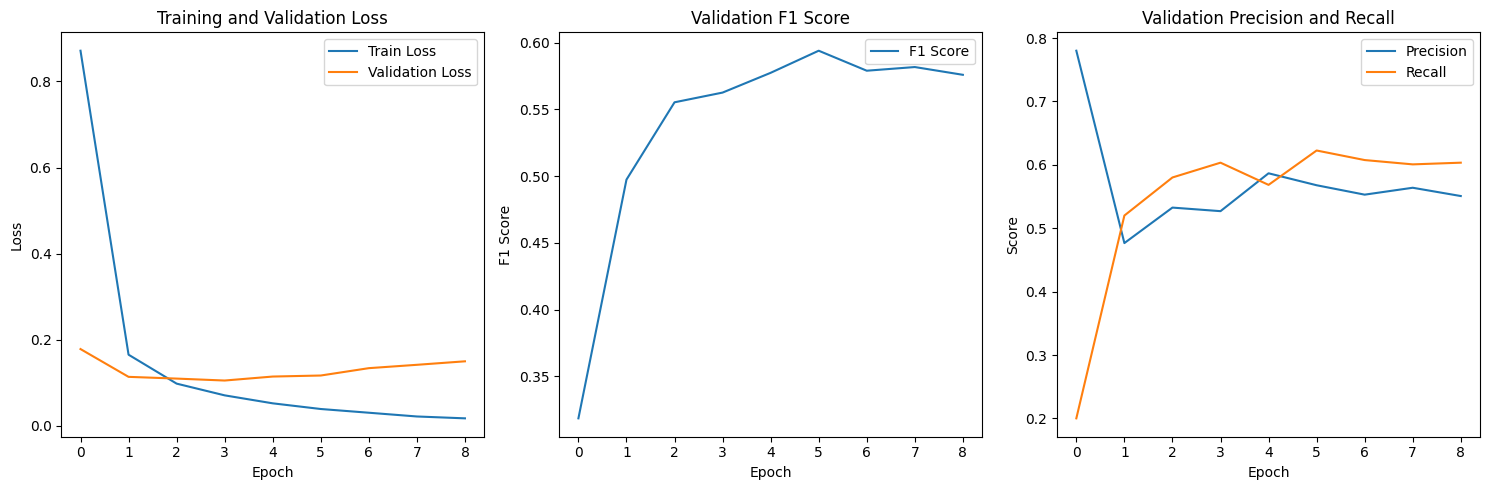


Final evaluation on validation set:


Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
  F1:        0.5940
  Precision: 0.5678
  Recall:    0.6227

Training on fold1, fold3 and validating on fold2

Created 1330 training samples and 648 validation samples


Epoch 1/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 1/15:
  Train Loss: 0.9227
  Val   Loss: 0.1952
  Val   F1:   0.1334 (P: 0.6206, R: 0.0747)
  Per-type metrics (top 5 by support):
    DATE: F1=0.0729, P=0.8529, R=0.0381, N=762
    STAT: F1=0.0000, P=0.0000, R=0.0000, N=731
    PREC: F1=0.0000, P=0.0000, R=0.0000, N=559
    COURT: F1=0.5609, P=0.6092, R=0.5197, N=558
    AUTH: F1=0.0000, P=0.0000, R=0.0000, N=468
  ↗ New best F1: 0.1334 (was 0.0000)


Epoch 2/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 2/15:
  Train Loss: 0.1651
  Val   Loss: 0.1226
  Val   F1:   0.5532 (P: 0.5713, R: 0.5362)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9160, P=0.9020, R=0.9304, N=762
    STAT: F1=0.6690, P=0.6760, R=0.6621, N=731
    PREC: F1=0.3281, P=0.3187, R=0.3381, N=559
    COURT: F1=0.7569, P=0.7469, R=0.7670, N=558
    AUTH: F1=0.4245, P=0.4612, R=0.3932, N=468
  ↗ New best F1: 0.5532 (was 0.1334)


Epoch 3/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 3/15:
  Train Loss: 0.0954
  Val   Loss: 0.1273
  Val   F1:   0.5108 (P: 0.4323, R: 0.6240)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9233, P=0.9002, R=0.9475, N=762
    STAT: F1=0.7548, P=0.7143, R=0.8003, N=731
    PREC: F1=0.3865, P=0.3445, R=0.4401, N=559
    COURT: F1=0.7909, P=0.7496, R=0.8369, N=558
    AUTH: F1=0.4940, P=0.4344, R=0.5726, N=468
  ↘ No improvement (1/3)


Epoch 4/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 4/15:
  Train Loss: 0.0667
  Val   Loss: 0.1175
  Val   F1:   0.5467 (P: 0.5404, R: 0.5531)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9446, P=0.9607, R=0.9291, N=762
    STAT: F1=0.6610, P=0.7589, R=0.5855, N=731
    PREC: F1=0.3128, P=0.2965, R=0.3309, N=559
    COURT: F1=0.8068, P=0.8054, R=0.8082, N=558
    AUTH: F1=0.5068, P=0.6053, R=0.4359, N=468
  ↘ No improvement (2/3)


Epoch 5/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 5/15:
  Train Loss: 0.0524
  Val   Loss: 0.1194
  Val   F1:   0.5815 (P: 0.5430, R: 0.6259)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9311, P=0.9227, R=0.9396, N=762
    STAT: F1=0.7750, P=0.7526, R=0.7989, N=731
    PREC: F1=0.4099, P=0.3698, R=0.4597, N=559
    COURT: F1=0.7919, P=0.7445, R=0.8459, N=558
    AUTH: F1=0.4367, P=0.4464, R=0.4274, N=468
  ↗ New best F1: 0.5815 (was 0.5532)


Epoch 6/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 6/15:
  Train Loss: 0.0392
  Val   Loss: 0.1282
  Val   F1:   0.5898 (P: 0.5718, R: 0.6090)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9378, P=0.9453, R=0.9304, N=762
    STAT: F1=0.7168, P=0.7448, R=0.6908, N=731
    PREC: F1=0.4289, P=0.4048, R=0.4562, N=559
    COURT: F1=0.8081, P=0.7907, R=0.8262, N=558
    AUTH: F1=0.5016, P=0.5054, R=0.4979, N=468
  ↗ New best F1: 0.5898 (was 0.5815)


Epoch 7/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 7/15:
  Train Loss: 0.0302
  Val   Loss: 0.1362
  Val   F1:   0.5917 (P: 0.5703, R: 0.6147)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9325, P=0.9229, R=0.9423, N=762
    STAT: F1=0.7448, P=0.7553, R=0.7346, N=731
    PREC: F1=0.4565, P=0.4219, R=0.4973, N=559
    COURT: F1=0.8102, P=0.7983, R=0.8226, N=558
    AUTH: F1=0.4247, P=0.4679, R=0.3889, N=468
  ↗ New best F1: 0.5917 (was 0.5898)


Epoch 8/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 8/15:
  Train Loss: 0.0224
  Val   Loss: 0.1444
  Val   F1:   0.6121 (P: 0.6019, R: 0.6226)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9386, P=0.9338, R=0.9436, N=762
    STAT: F1=0.7537, P=0.7417, R=0.7661, N=731
    PREC: F1=0.4310, P=0.4160, R=0.4472, N=559
    COURT: F1=0.8174, P=0.8088, R=0.8262, N=558
    AUTH: F1=0.4208, P=0.4584, R=0.3889, N=468
  ↗ New best F1: 0.6121 (was 0.5917)


Epoch 9/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 9/15:
  Train Loss: 0.0184
  Val   Loss: 0.1514
  Val   F1:   0.6068 (P: 0.5691, R: 0.6498)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9329, P=0.9175, R=0.9488, N=762
    STAT: F1=0.7680, P=0.7553, R=0.7811, N=731
    PREC: F1=0.4529, P=0.4146, R=0.4991, N=559
    COURT: F1=0.8007, P=0.7720, R=0.8315, N=558
    AUTH: F1=0.4838, P=0.4725, R=0.4957, N=468
  ↘ No improvement (1/3)


Epoch 10/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 10/15:
  Train Loss: 0.0141
  Val   Loss: 0.1570
  Val   F1:   0.6169 (P: 0.5951, R: 0.6404)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9383, P=0.9292, R=0.9475, N=762
    STAT: F1=0.7623, P=0.7445, R=0.7811, N=731
    PREC: F1=0.4536, P=0.4222, R=0.4902, N=559
    COURT: F1=0.8073, P=0.7828, R=0.8333, N=558
    AUTH: F1=0.4283, P=0.4429, R=0.4145, N=468
  ↗ New best F1: 0.6169 (was 0.6121)


Epoch 11/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 11/15:
  Train Loss: 0.0113
  Val   Loss: 0.1654
  Val   F1:   0.6199 (P: 0.5937, R: 0.6484)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9410, P=0.9296, R=0.9528, N=762
    STAT: F1=0.7722, P=0.7701, R=0.7743, N=731
    PREC: F1=0.4656, P=0.4297, R=0.5081, N=559
    COURT: F1=0.8042, P=0.7917, R=0.8172, N=558
    AUTH: F1=0.4493, P=0.4817, R=0.4209, N=468
  ↗ New best F1: 0.6199 (was 0.6169)


Epoch 12/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 12/15:
  Train Loss: 0.0091
  Val   Loss: 0.1721
  Val   F1:   0.6138 (P: 0.5719, R: 0.6625)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9390, P=0.9293, R=0.9488, N=762
    STAT: F1=0.7690, P=0.7510, R=0.7880, N=731
    PREC: F1=0.4576, P=0.4019, R=0.5313, N=559
    COURT: F1=0.8120, P=0.7966, R=0.8280, N=558
    AUTH: F1=0.4410, P=0.4556, R=0.4274, N=468
  ↘ No improvement (1/3)


Epoch 13/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 13/15:
  Train Loss: 0.0073
  Val   Loss: 0.1749
  Val   F1:   0.6182 (P: 0.5835, R: 0.6573)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9426, P=0.9377, R=0.9475, N=762
    STAT: F1=0.7781, P=0.7522, R=0.8057, N=731
    PREC: F1=0.4633, P=0.4108, R=0.5313, N=559
    COURT: F1=0.8138, P=0.8053, R=0.8226, N=558
    AUTH: F1=0.4230, P=0.4391, R=0.4081, N=468
  ↘ No improvement (2/3)


Epoch 14/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 14/15:
  Train Loss: 0.0066
  Val   Loss: 0.1789
  Val   F1:   0.6176 (P: 0.5821, R: 0.6578)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9382, P=0.9303, R=0.9462, N=762
    STAT: F1=0.7813, P=0.7620, R=0.8016, N=731
    PREC: F1=0.4665, P=0.4136, R=0.5349, N=559
    COURT: F1=0.8070, P=0.7938, R=0.8208, N=558
    AUTH: F1=0.4397, P=0.4603, R=0.4209, N=468
  ↘ No improvement (3/3)
Early stopping at epoch 14


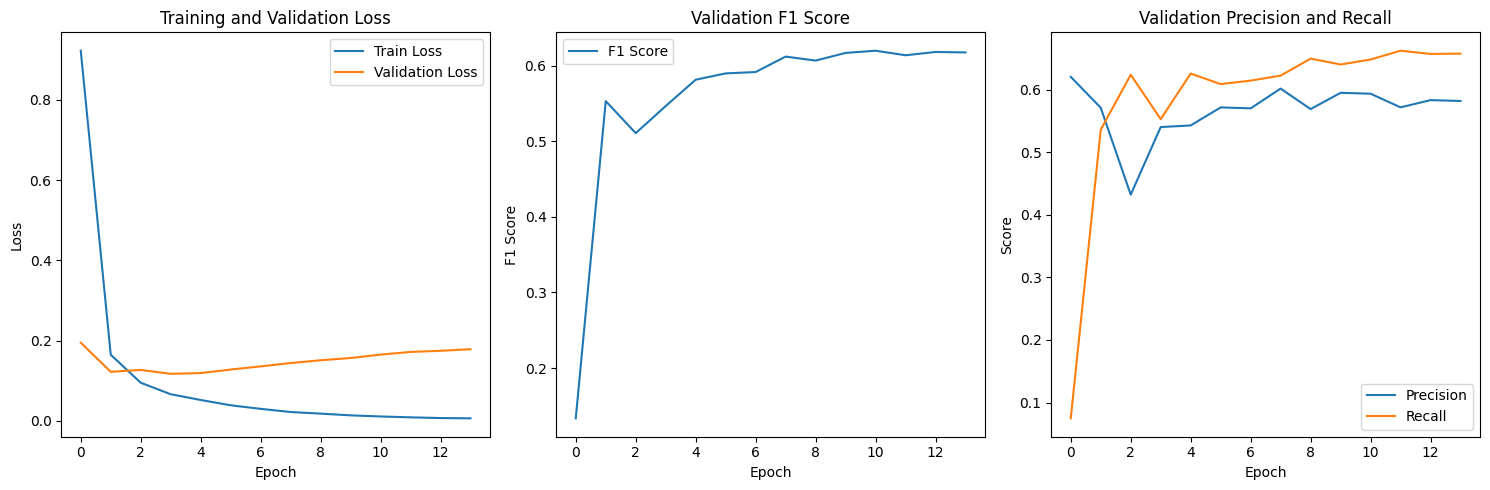


Final evaluation on validation set:


Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
  F1:        0.6199
  Precision: 0.5937
  Recall:    0.6484

Training on fold1, fold2 and validating on fold3

Created 1291 training samples and 687 validation samples


Epoch 1/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
Epoch 1/15:
  Train Loss: 0.9638
  Val   Loss: 0.1756
  Val   F1:   0.1335 (P: 0.9617, R: 0.0718)
  Per-type metrics (top 5 by support):
    STAT: F1=0.0000, P=0.0000, R=0.0000, N=795
    DATE: F1=0.4772, P=0.9631, R=0.3171, N=741
    PREC: F1=0.0000, P=0.0000, R=0.0000, N=621
    COURT: F1=0.2102, P=0.9565, R=0.1181, N=559
    CASENO: F1=0.0000, P=0.0000, R=0.0000, N=342
  ↗ New best F1: 0.1335 (was 0.0000)


Epoch 2/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
Epoch 2/15:
  Train Loss: 0.1833
  Val   Loss: 0.1107
  Val   F1:   0.5169 (P: 0.5034, R: 0.5311)
  Per-type metrics (top 5 by support):
    STAT: F1=0.6168, P=0.5845, R=0.6528, N=795
    DATE: F1=0.9181, P=0.9132, R=0.9231, N=741
    PREC: F1=0.2202, P=0.2302, R=0.2110, N=621
    COURT: F1=0.8180, P=0.7933, R=0.8444, N=559
    CASENO: F1=0.5664, P=0.5714, R=0.5614, N=342
  ↗ New best F1: 0.5169 (was 0.1335)


Epoch 3/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
Epoch 3/15:
  Train Loss: 0.1060
  Val   Loss: 0.1050
  Val   F1:   0.5549 (P: 0.4946, R: 0.6319)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7401, P=0.6743, R=0.8201, N=795
    DATE: F1=0.9165, P=0.8806, R=0.9555, N=741
    PREC: F1=0.2778, P=0.2739, R=0.2818, N=621
    COURT: F1=0.8153, P=0.8132, R=0.8175, N=559
    CASENO: F1=0.5442, P=0.5229, R=0.5673, N=342
  ↗ New best F1: 0.5549 (was 0.5169)


Epoch 4/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
Epoch 4/15:
  Train Loss: 0.0786
  Val   Loss: 0.1014
  Val   F1:   0.5930 (P: 0.5529, R: 0.6393)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7694, P=0.7276, R=0.8164, N=795
    DATE: F1=0.9325, P=0.9233, R=0.9420, N=741
    PREC: F1=0.3707, P=0.3664, R=0.3752, N=621
    COURT: F1=0.8136, P=0.7929, R=0.8354, N=559
    CASENO: F1=0.6325, P=0.7290, R=0.5585, N=342
  ↗ New best F1: 0.5930 (was 0.5549)


Epoch 5/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
Epoch 5/15:
  Train Loss: 0.0585
  Val   Loss: 0.1162
  Val   F1:   0.5911 (P: 0.5175, R: 0.6892)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7638, P=0.6933, R=0.8503, N=795
    DATE: F1=0.9473, P=0.9367, R=0.9582, N=741
    PREC: F1=0.3827, P=0.3469, R=0.4267, N=621
    COURT: F1=0.8224, P=0.7832, R=0.8658, N=559
    CASENO: F1=0.6067, P=0.5608, R=0.6608, N=342
  ↘ No improvement (1/3)


Epoch 6/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
Epoch 6/15:
  Train Loss: 0.0456
  Val   Loss: 0.1085
  Val   F1:   0.6222 (P: 0.5842, R: 0.6656)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7668, P=0.7162, R=0.8252, N=795
    DATE: F1=0.9479, P=0.9391, R=0.9568, N=741
    PREC: F1=0.4264, P=0.4032, R=0.4525, N=621
    COURT: F1=0.8198, P=0.7843, R=0.8587, N=559
    CASENO: F1=0.6032, P=0.5954, R=0.6111, N=342
  ↗ New best F1: 0.6222 (was 0.5930)


Epoch 7/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
Epoch 7/15:
  Train Loss: 0.0336
  Val   Loss: 0.1163
  Val   F1:   0.6165 (P: 0.5661, R: 0.6768)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7759, P=0.7143, R=0.8491, N=795
    DATE: F1=0.9436, P=0.9282, R=0.9595, N=741
    PREC: F1=0.4663, P=0.4400, R=0.4960, N=621
    COURT: F1=0.7856, P=0.7240, R=0.8587, N=559
    CASENO: F1=0.6078, P=0.6017, R=0.6140, N=342
  ↘ No improvement (1/3)


Epoch 8/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
Epoch 8/15:
  Train Loss: 0.0264
  Val   Loss: 0.1281
  Val   F1:   0.6138 (P: 0.5674, R: 0.6684)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7625, P=0.7068, R=0.8277, N=795
    DATE: F1=0.9271, P=0.8956, R=0.9609, N=741
    PREC: F1=0.4296, P=0.4115, R=0.4493, N=621
    COURT: F1=0.8274, P=0.8030, R=0.8533, N=559
    CASENO: F1=0.5435, P=0.4952, R=0.6023, N=342
  ↘ No improvement (2/3)


Epoch 9/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
Epoch 9/15:
  Train Loss: 0.0203
  Val   Loss: 0.1326
  Val   F1:   0.6251 (P: 0.5798, R: 0.6779)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7696, P=0.7055, R=0.8465, N=795
    DATE: F1=0.9389, P=0.9154, R=0.9636, N=741
    PREC: F1=0.4497, P=0.4269, R=0.4750, N=621
    COURT: F1=0.8241, P=0.7953, R=0.8551, N=559
    CASENO: F1=0.5758, P=0.5443, R=0.6111, N=342
  ↗ New best F1: 0.6251 (was 0.6222)


Epoch 10/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
Epoch 10/15:
  Train Loss: 0.0149
  Val   Loss: 0.1396
  Val   F1:   0.6299 (P: 0.5783, R: 0.6915)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7761, P=0.7201, R=0.8415, N=795
    DATE: F1=0.9368, P=0.9151, R=0.9595, N=741
    PREC: F1=0.4974, P=0.4591, R=0.5427, N=621
    COURT: F1=0.8062, P=0.7451, R=0.8784, N=559
    CASENO: F1=0.5811, P=0.5613, R=0.6023, N=342
  ↗ New best F1: 0.6299 (was 0.6251)


Epoch 11/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
Epoch 11/15:
  Train Loss: 0.0117
  Val   Loss: 0.1443
  Val   F1:   0.6302 (P: 0.5867, R: 0.6806)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7661, P=0.7206, R=0.8176, N=795
    DATE: F1=0.9430, P=0.9259, R=0.9609, N=741
    PREC: F1=0.4756, P=0.4337, R=0.5266, N=621
    COURT: F1=0.8187, P=0.7808, R=0.8605, N=559
    CASENO: F1=0.5888, P=0.5958, R=0.5819, N=342
  ↗ New best F1: 0.6302 (was 0.6299)


Epoch 12/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
Epoch 12/15:
  Train Loss: 0.0099
  Val   Loss: 0.1446
  Val   F1:   0.6427 (P: 0.6166, R: 0.6710)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7549, P=0.7116, R=0.8038, N=795
    DATE: F1=0.9447, P=0.9329, R=0.9568, N=741
    PREC: F1=0.4870, P=0.4507, R=0.5298, N=621
    COURT: F1=0.8224, P=0.7937, R=0.8533, N=559
    CASENO: F1=0.6069, P=0.6208, R=0.5936, N=342
  ↗ New best F1: 0.6427 (was 0.6302)


Epoch 13/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
Epoch 13/15:
  Train Loss: 0.0080
  Val   Loss: 0.1540
  Val   F1:   0.6383 (P: 0.6047, R: 0.6758)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7687, P=0.7223, R=0.8214, N=795
    DATE: F1=0.9416, P=0.9268, R=0.9568, N=741
    PREC: F1=0.4920, P=0.4468, R=0.5475, N=621
    COURT: F1=0.8287, P=0.8103, R=0.8479, N=559
    CASENO: F1=0.5753, P=0.5866, R=0.5643, N=342
  ↘ No improvement (1/3)


Epoch 14/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
Epoch 14/15:
  Train Loss: 0.0071
  Val   Loss: 0.1564
  Val   F1:   0.6385 (P: 0.6096, R: 0.6703)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7687, P=0.7273, R=0.8151, N=795
    DATE: F1=0.9410, P=0.9245, R=0.9582, N=741
    PREC: F1=0.4818, P=0.4406, R=0.5314, N=621
    COURT: F1=0.8236, P=0.8007, R=0.8479, N=559
    CASENO: F1=0.5794, P=0.5828, R=0.5760, N=342
  ↘ No improvement (2/3)


Epoch 15/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
Epoch 15/15:
  Train Loss: 0.0064
  Val   Loss: 0.1560
  Val   F1:   0.6368 (P: 0.6076, R: 0.6689)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7629, P=0.7199, R=0.8113, N=795
    DATE: F1=0.9416, P=0.9257, R=0.9582, N=741
    PREC: F1=0.4648, P=0.4301, R=0.5056, N=621
    COURT: F1=0.8264, P=0.8027, R=0.8515, N=559
    CASENO: F1=0.5731, P=0.5731, R=0.5731, N=342
  ↘ No improvement (3/3)
Early stopping at epoch 15


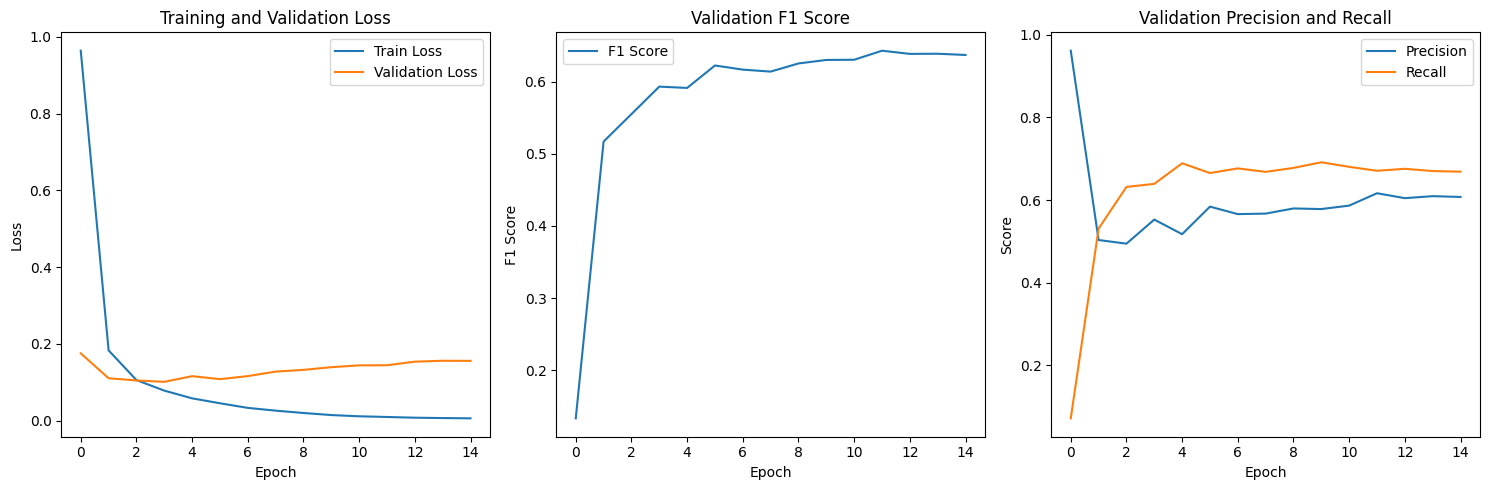


Final evaluation on validation set:


Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
  F1:        0.6427
  Precision: 0.6166
  Recall:    0.6710

Cross-validation results:
  Fold 1: F1 = 0.5940
  Fold 2: F1 = 0.6199
  Fold 3: F1 = 0.6427
  Average: F1 = 0.6189, Precision = 0.5927, Recall = 0.6474


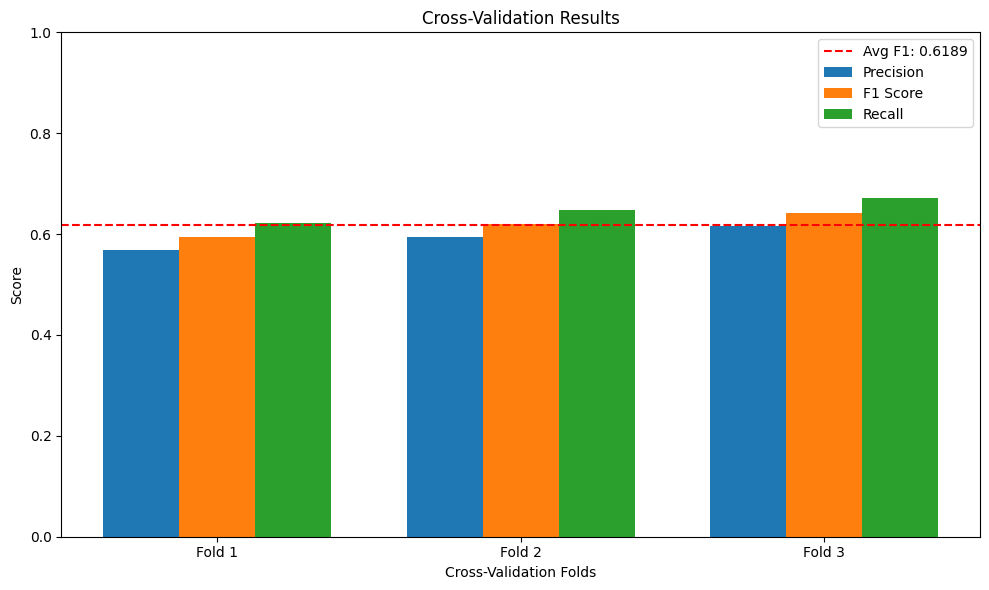


Analyzing entity distribution across the dataset:


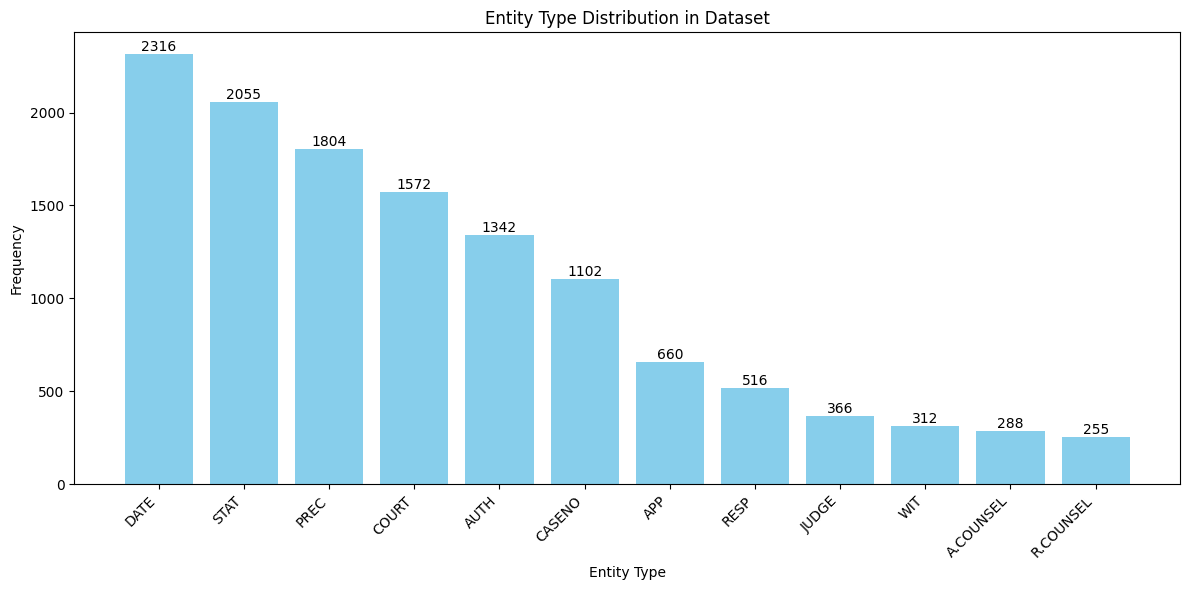

Best model saved to best_legal_ner_model_bert_base_uncased_CRF_false.pt
Model configuration saved to model_config_bert_base_uncased_CRF_false.json

Testing on sample document from fold1:

Testing entity extraction on a sample document:

Sample document excerpt:
REPORTABLE IN THE SUPREME COURT OF INDIA CRIMINAL APPELLATE JURISDICTION CRIMINAL APPEAL NO. 92/2015 JAGE RAM & ORS. ..Appellants Versus STATE OF HARYANA ..Respondent J U D G M E N T R. BANUMATHI, J. This appeal is preferred against the judgment dated 19.8.2011 passed by the High Court of Punjab and Haryana in Criminal Appeal No.181 SB of 2000, whereby the High Court partly allowed the appeal filed by the appellants thereby confirming the conviction of the appellants with certain modifications. ...


Predicted entities visualization:


Found 13 entities:
1. RESP: 'STATE OF HARYANA'
2. DATE: '19.8.2011'
3. COURT: 'High Court of Punjab and Haryana'
4. COURT: 'High Court'
5. DATE: '18.11.1994'
6. WIT: 'Jagdish'
7. WIT: 'Mange Ram'
8. APP: 'Jage Ram'
9. APP: 'Jage Ram'
10. APP: 'Jage Ram'
11. WIT: 'Jagdish'
12. WIT: 'Jagdish'
13. WIT: 'Pardeep Kumar'

Gold standard entities:


Found 104 entities:
1. RESP: 'STATE OF HARYANA'
2. DATE: '19.8.2011'
3. COURT: 'High Court of Punjab and Haryana'
4. COURT: 'High Court'
5. DATE: '18.11.1994'
6. WIT: 'Jagdish'
7. WIT: 'Mange Ram'
8. APP: 'Jage Ram'
9. APP: 'Jage Ram'
10. APP: 'Jage Ram'
11. WIT: 'Jagdish'
12. WIT: 'Jagdish'
13. WIT: 'Pardeep Kumar'
14. WIT: 'Pardeep Kumar'
15. WIT: 'Jagdish'
16. WIT: 'Mange Ram'
17. WIT: 'Jagdish'
18. STAT: 'IPC'
19. WIT: 'Ramesh Kumar'
20. STAT: 'IPC'
21. WIT: 'Jagdish'
22. WIT: 'Mange Ram'
23. WIT: 'Prem Kumar'
24. WIT: 'HiIol Kanti Pal'
25. STAT: 'Cr.P.C.'
26. APP: 'Jage Ram'
27. WIT: 'Jagdish'
28. WIT: 'Mange Ram'
29. WIT: 'Jagdish'
30. APP: 'Jage Ram'
31. DATE: '17.2.2000'
32. STAT: 'IPC'
33. COURT: 'High Court of Punjab and Haryana'
34. COURT: 'High Court'
35. DATE: '19.8.2011'
36. APP: 'Jage Ram'
37. STAT: 'IPC'
38. STAT: 'IPC'
39. COURT: 'High Court'
40. STAT: 'IPC'
41. STAT: 'IPC'
42. COURT: 'High Court'
43. STAT: 'IPC'
44. A.COUNSEL: 'Vibha Datta Makhija'
45. STAT: 'IPC'
46.

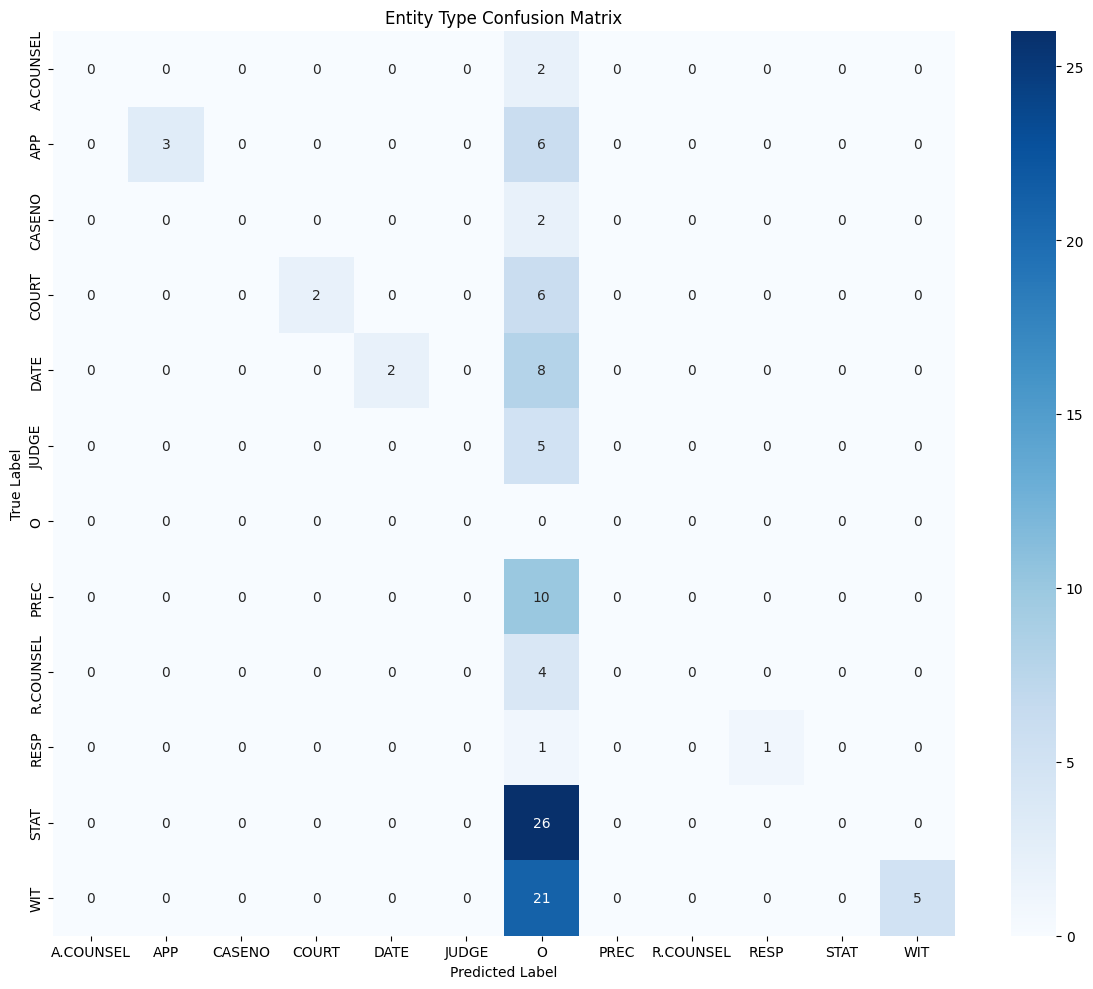


Entity recognition error analysis:


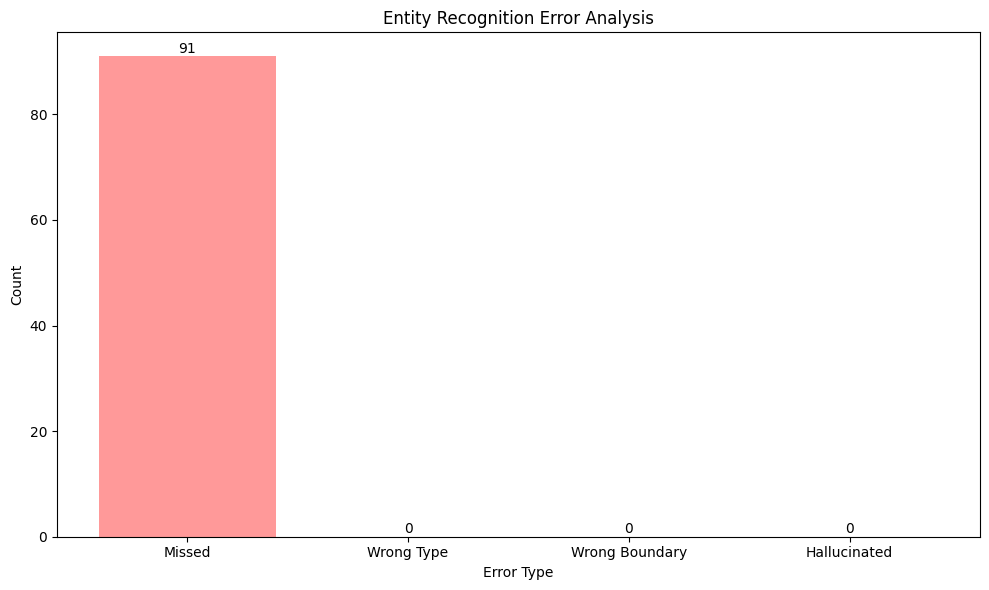

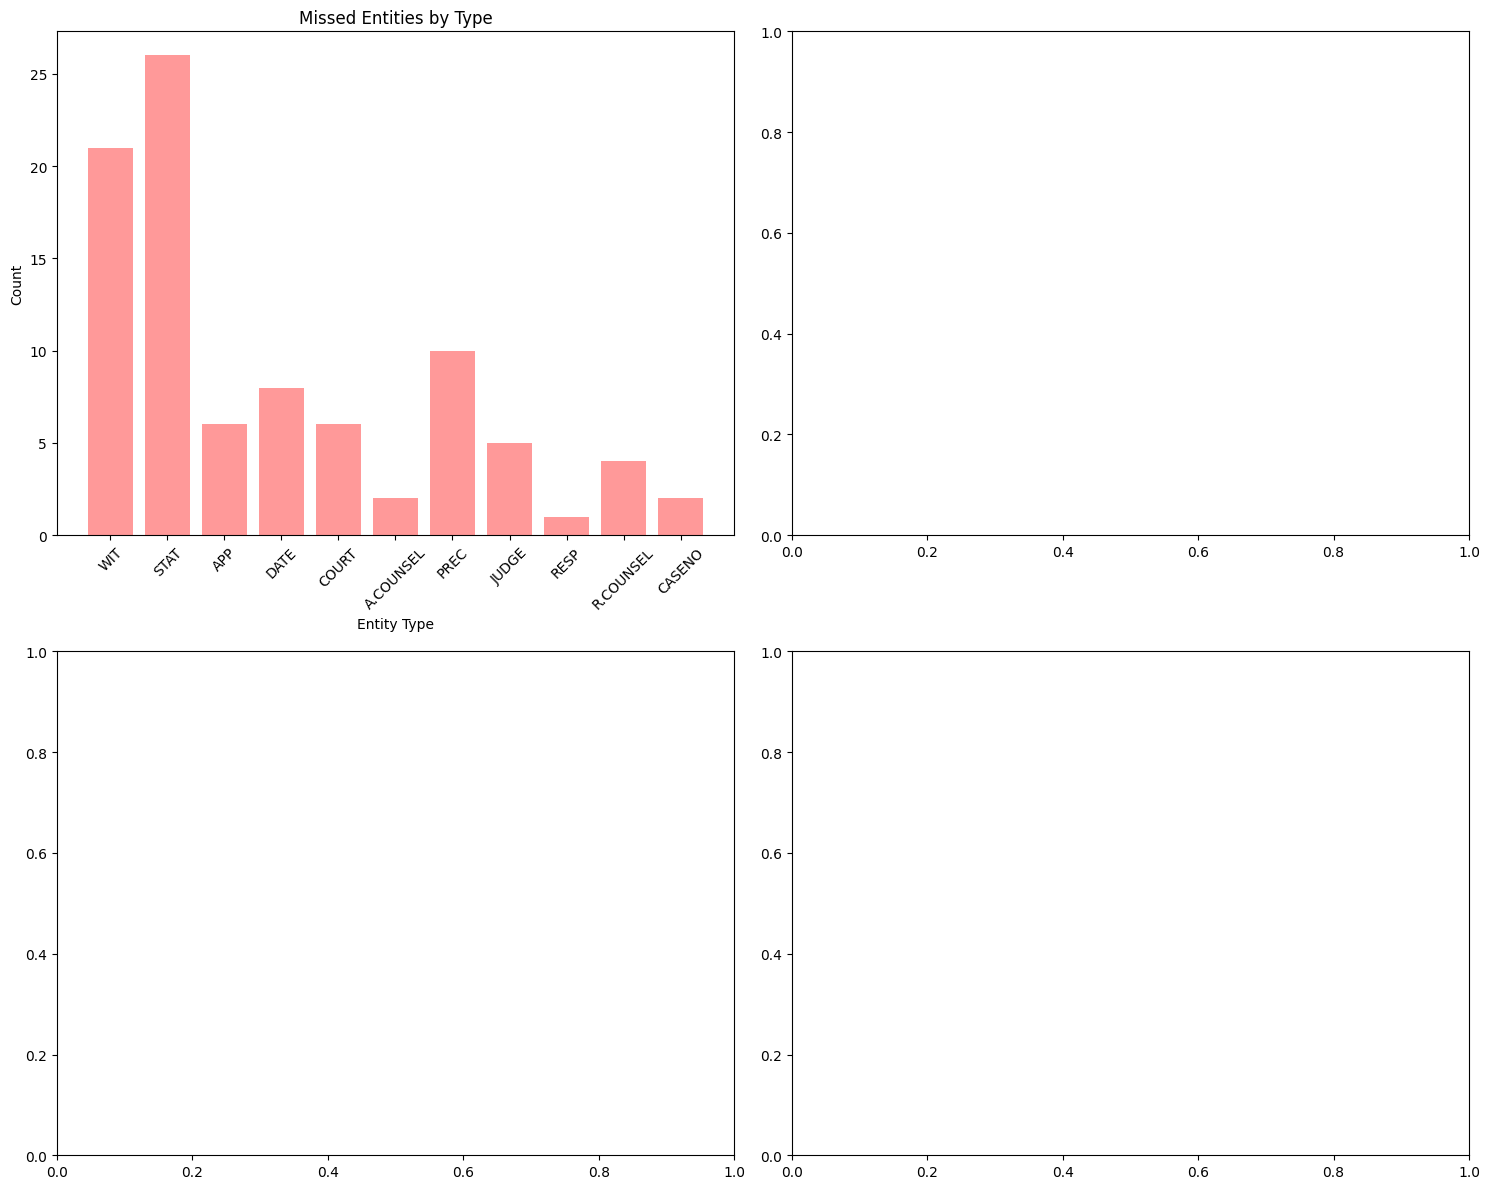


Testing on sample document from fold2:

Testing entity extraction on a sample document:

Sample document excerpt:
IN THE HIGH COURT AT CALCUTTA CIVIL REVISIONAL JURISDICTION APPELLATE SIDE Before: The Hon'ble Justice Hiranmay Bhattacharyya C.O. 3346 of 2018 The Kolkata Municipal Corporation Vs. Smt. Kajari Banerjee For the petitioner : Mr. Alok Kr. Ghosh, Mr. S.K. Debnath..... advocates For the opposite party : Mr. R.N. Chakraborty, Mr. M. Ahmed............ advocates Heard on : 18.12.2020 Judgment on : 22.12.2020 Hiranmay Bhattacharyya, J.: This application under Article 227 of the Constitution of India is ...


Predicted entities visualization:


Found 31 entities:
1. JUDGE: 'Hiranmay Bhattacharyya'
2. CASENO: 'C.O. 3346 of 2018'
3. APP: 'Kolkata Municipal Corporation'
4. A.COUNSEL: 'Alok'
5. A.COUNSEL: 'Ghosh'
6. R.COUNSEL: 'R.N. Chakraborty'
7. R.COUNSEL: 'M. Ahmed'
8. CASENO: '18.12.2020'
9. CASENO: '22.12.2020'
10. JUDGE: 'Hiranmay Bhattacharyya'
11. STAT: 'Constitution of India'
12. APP: 'Kolkata Municipal Corporation'
13. DATE: 'March 27, 2018'
14. AUTH: 'Municipal Assessment Tribunal'
15. APP: 'Kolkata Municipal Corporation'
16. CASENO: 'M.A. Appeal no. 947 of 2012'
17. DATE: 'March 24, 2012'
18. DATE: 'fourth quarter of 2009-10'
19. CASENO: 'M.A. Appeal no. 947 of 2012'
20. DATE: 'March 24, 2012'
21. AUTH: 'Municipal Assessment Tribunal'
22. DATE: 'February 16, 2015'
23. APP: 'Kolkata Municipal Corporation'
24. DATE: 'February 16, 2015'
25. STAT: 'Constitution of India'
26. CASENO: 'C.O. no. 2623 of 2017'
27. DATE: 'December 18, 2017'
28. CASENO: 'Civil Order No. 2623 of 2017'
29. DATE: 'February 16, 2015'
30. DATE: 'Ma

Found 113 entities:
1. JUDGE: 'Hiranmay Bhattacharyya'
2. CASENO: 'C.O. 3346 of 2018'
3. APP: 'Kolkata Municipal Corporation'
4. RESP: 'Smt. Kajari Banerjee'
5. A.COUNSEL: 'Ghosh'
6. R.COUNSEL: 'R.N. Chakraborty'
7. R.COUNSEL: 'M. Ahmed'
8. CASENO: '18.12.2020'
9. CASENO: '22.12.2020'
10. JUDGE: 'Hiranmay Bhattacharyya'
11. STAT: 'Constitution of India'
12. APP: 'Kolkata Municipal Corporation'
13. DATE: 'March 27, 2018'
14. AUTH: 'Municipal Assessment Tribunal'
15. APP: 'Kolkata Municipal Corporation'
16. CASENO: 'M.A. Appeal no. 947 of 2012'
17. DATE: 'March 24, 2012'
18. DATE: 'fourth quarter of 2009-10'
19. CASENO: 'M.A. Appeal no. 947 of 2012'
20. DATE: 'March 24, 2012'
21. AUTH: 'Municipal Assessment Tribunal'
22. DATE: 'February 16, 2015'
23. APP: 'Kolkata Municipal Corporation'
24. DATE: 'February 16, 2015'
25. STAT: 'Constitution of India'
26. CASENO: 'C.O. no. 2623 of 2017'
27. DATE: 'December 18, 2017'
28. CASENO: 'Civil Order No. 2623 of 2017'
29. DATE: 'February 16, 2015'
3

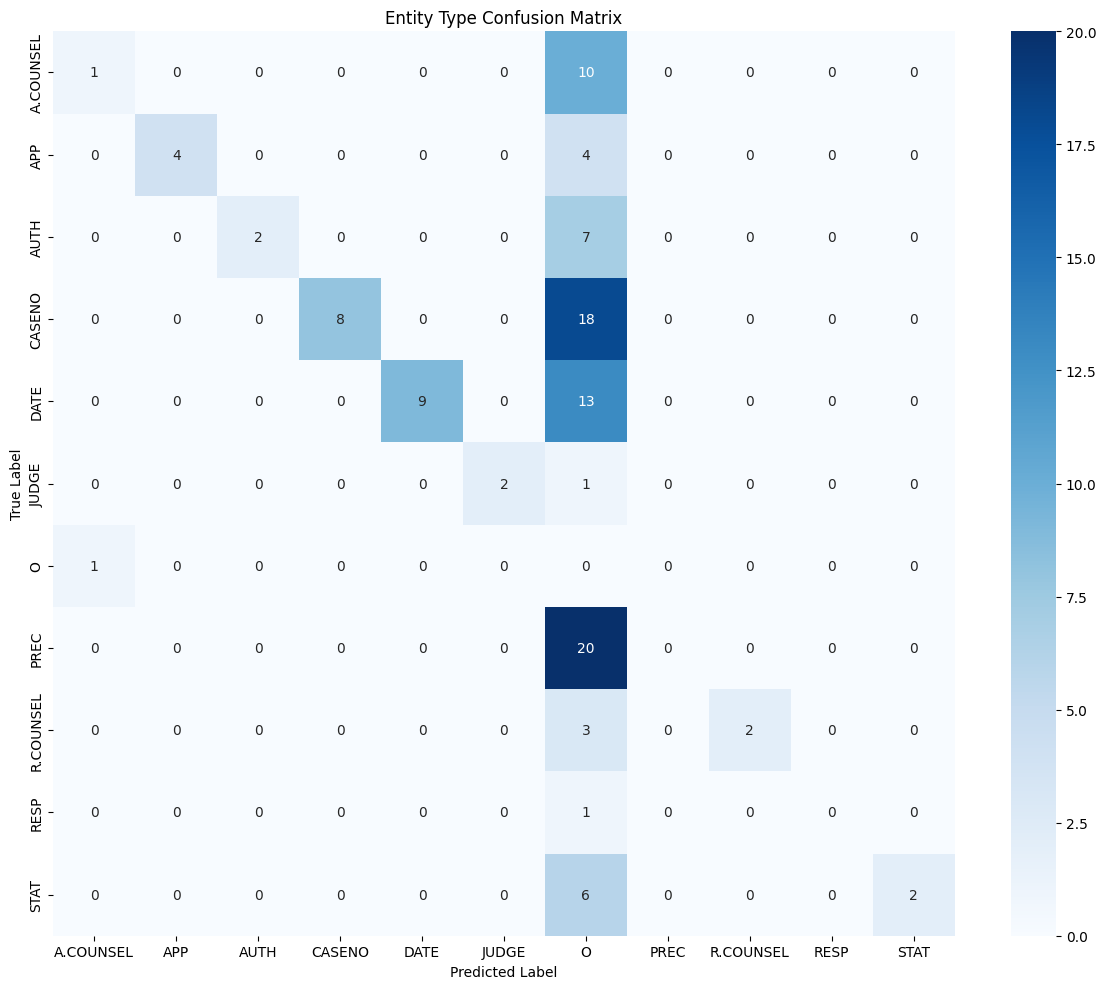


Entity recognition error analysis:


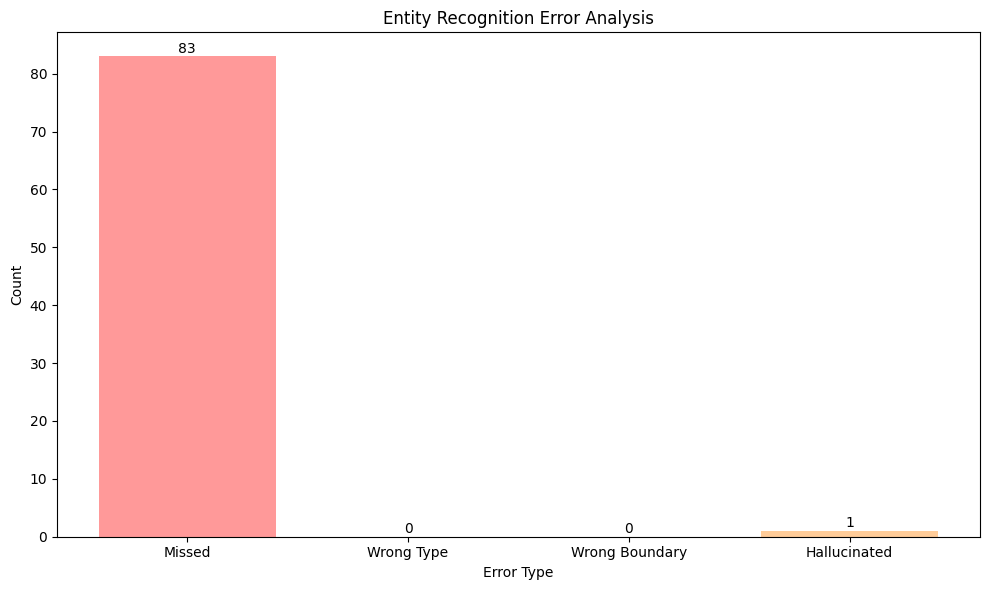

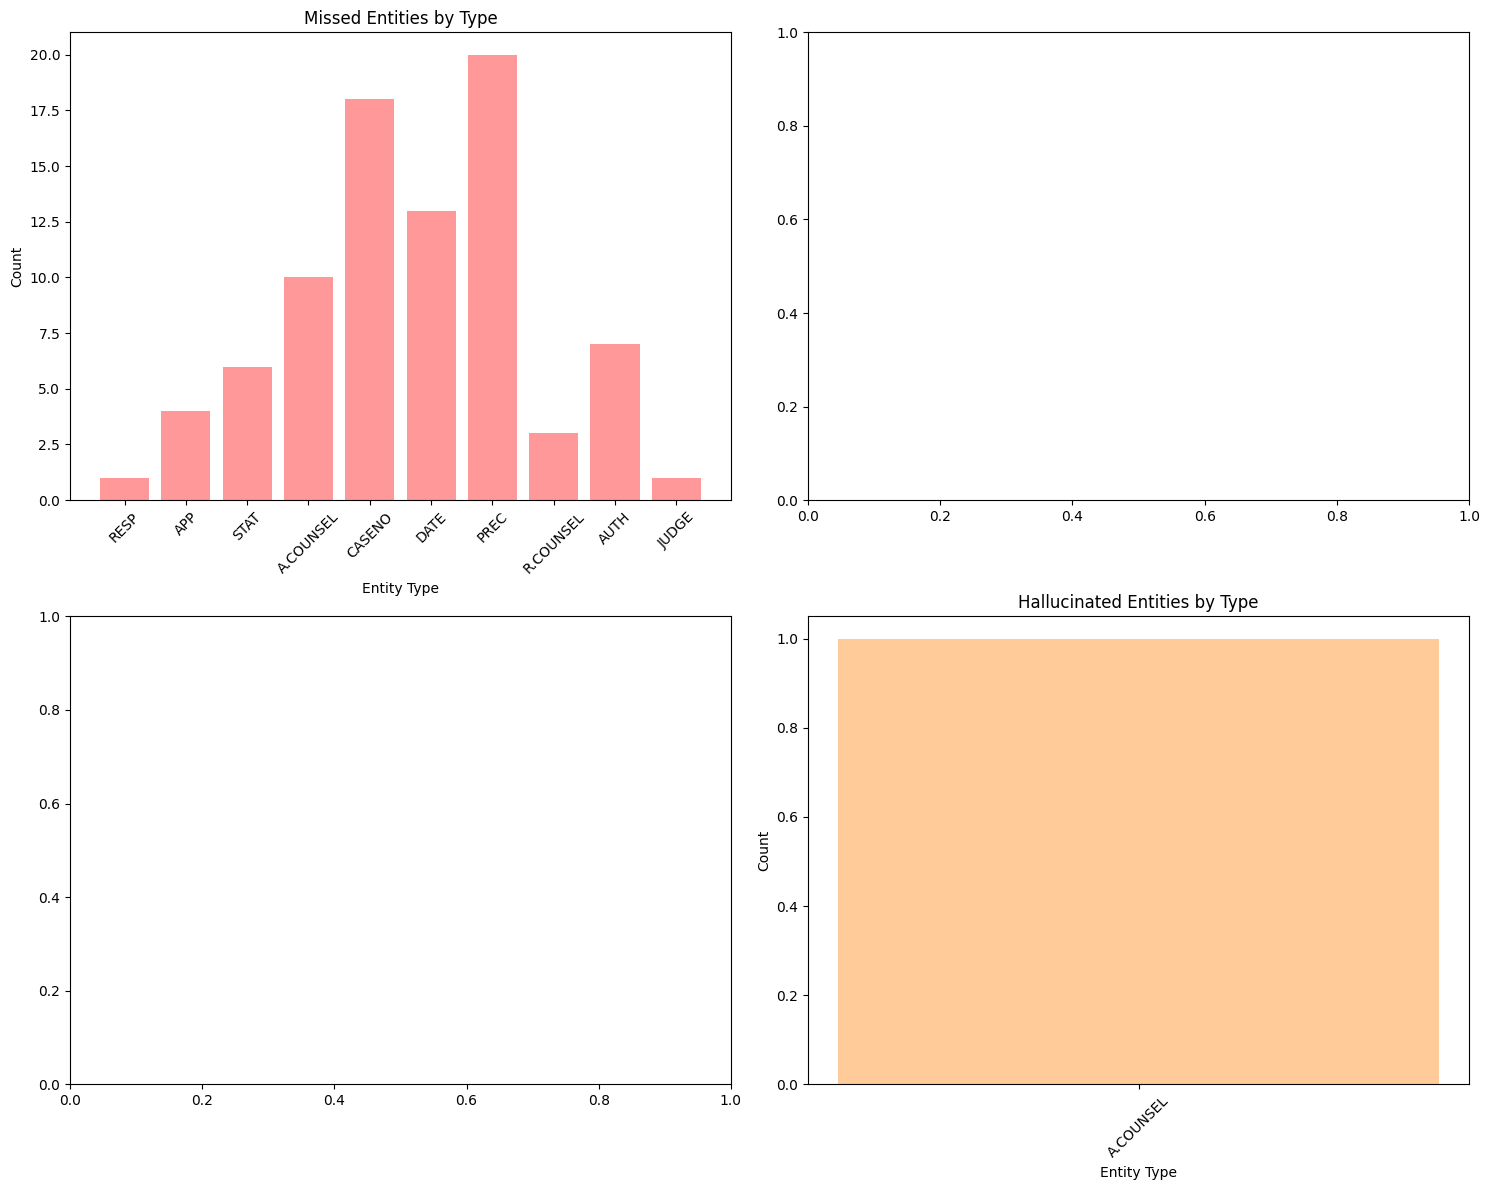


Testing on sample document from fold3:

Testing entity extraction on a sample document:

Sample document excerpt:
REPORTABLE IN THE SUPREME COURT OF INDIA CIVIL APPELLATE JURISDICTION CIVIL APPEAL NO.6580 OF 2008 ARISING OUT OF SPECIAL LEAVE PETITION (CIVIL) NO. 15449 OF 2004 ESSCO FABS PVT. LTD. & ANR. ... APPELLANTS VERSUS STATE OF HARYANA & ANR. ... RESPONDENTS WITH CIVIL APPEAL NO.6581 OF 2008 ARISING OUT OF SPECIAL LEAVE PETITION (CIVIL) NO. 15544 OF 2004 THE PANIPAT TEACHERS (RECOGNISED SCHOOLS)HOUSING CO-OPEATIVE SOCIETY LTD. & ANR. ... APPELLANTS VERSUS STATE OF HARYANA & ORS. ... RESPONDENTS WITH C...


Predicted entities visualization:


Found 24 entities:
1. COURT: 'SUPREME COURT OF INDIA'
2. CASENO: 'CIVIL APPEAL NO.6580 OF 2008'
3. CASENO: 'SPECIAL LEAVE PETITION (CIVIL) NO. 15449 OF 2004'
4. APP: 'ESSCO FABS PVT. LTD.'
5. RESP: 'STATE OF HARYANA'
6. CASENO: 'CIVIL APPEAL NO.6581 OF 2008'
7. CASENO: 'SPECIAL LEAVE PETITION (CIVIL) NO. 15544 OF 2004'
8. RESP: 'STATE OF HARYANA'
9. CASENO: 'CONTEMPT PETITION NO. 30 OF 2007'
10. CASENO: 'CIVIL APPEAL NO.6580 OF 2008'
11. CASENO: 'SPECIAL LEAVE PETITION (CIVIL) NO. 15449 OF 2004'
12. APP: 'ESSCO FABS PVT. LTD.'
13. RESP: 'STATE OF HARYANA'
14. JUDGE: 'C.K. THAKKER'
15. DATE: 'April 02, 2004'
16. COURT: 'High Court of Punjab & Haryana'
17. CASENO: 'Civil Writ Petition Nos. 1853 of 2003 and 2077 of 2002'
18. RESP: 'Es'
19. RESP: 'Es'
20. AUTH: 'Government'
21. STAT: 'Land Acquisition Act, 1894'
22. DATE: 'December 15, 1982'
23. DATE: 'June 20, 1984'
24. RESP: 'Es'

Gold standard entities:


Found 87 entities:
1. COURT: 'SUPREME COURT OF INDIA'
2. CASENO: 'SPECIAL LEAVE PETITION (CIVIL) NO. 15449 OF 2004'
3. RESP: 'STATE OF HARYANA'
4. CASENO: 'SPECIAL LEAVE PETITION (CIVIL) NO. 15544 OF 2004'
5. APP: 'PANIPAT TEACHERS (RECOGNISED SCHOOLS)HOUSING CO-OPEATIVE SOCIETY LTD.'
6. RESP: 'STATE OF HARYANA'
7. CASENO: 'SPECIAL LEAVE PETITION (CIVIL) NO. 15449 OF 2004'
8. RESP: 'STATE OF HARYANA'
9. JUDGE: 'C.K. THAKKER'
10. DATE: 'April 02, 2004'
11. COURT: 'High Court of Punjab & Haryana'
12. CASENO: 'Civil Writ Petition Nos.'
13. APP: 'Essco Fabs Pvt. Ltd.'
14. APP: 'Essco'
15. AUTH: 'Haryana Urban Development Authority'
16. AUTH: 'HUDA'
17. DATE: 'December 15, 1982'
18. DATE: 'June 20, 1984'
19. APP: 'Essco'
20. DATE: 'June 6, 1991'
21. AUTH: 'Director, Town & Country Planning, Haryana'
22. DATE: 'September 5, 1991'
23. DATE: 'August 1, 2001'
24. AUTH: 'HUDA'
25. DATE: 'August 2, 2001'
26. CASENO: 'Civil Writ Petition No. 1853 of 2003'
27. COURT: 'High Court of Punjab & Haryana

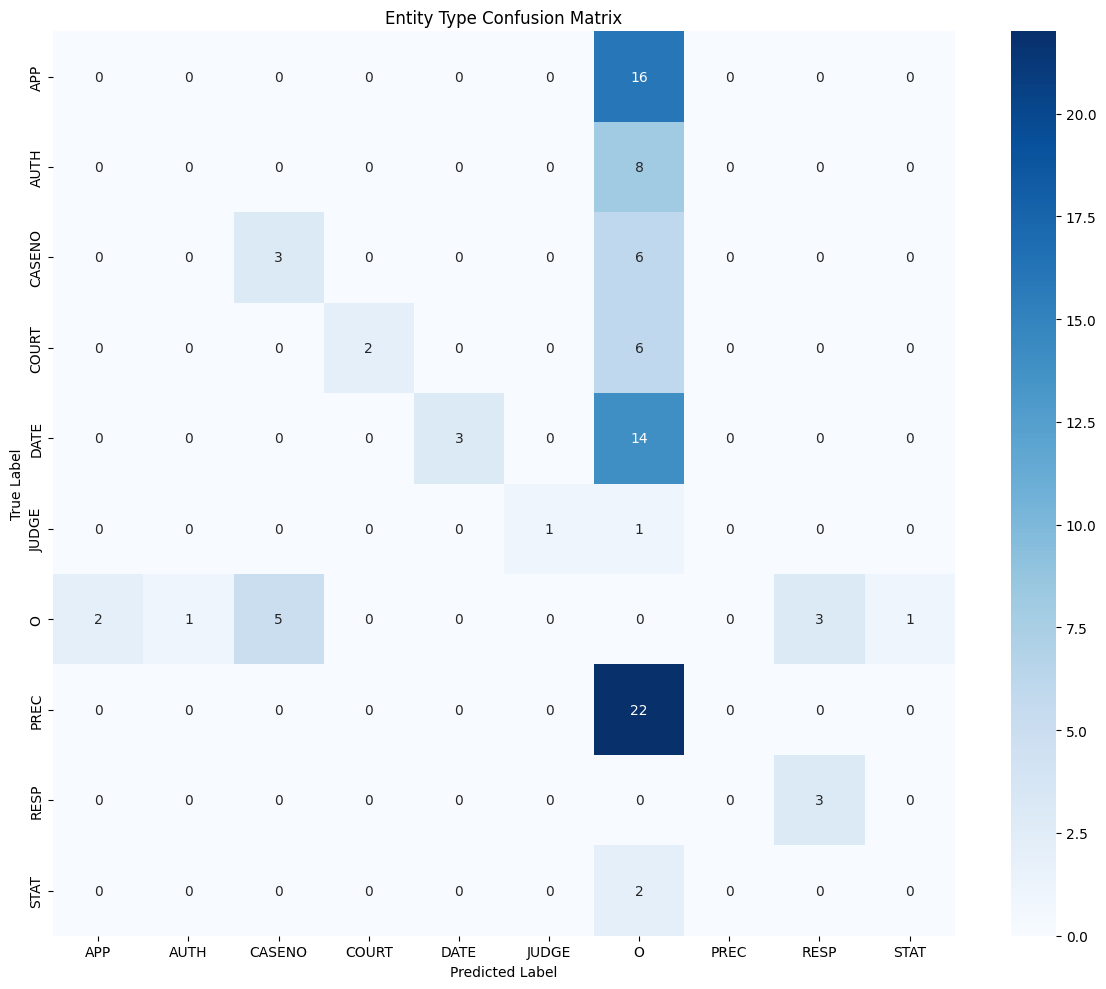


Entity recognition error analysis:


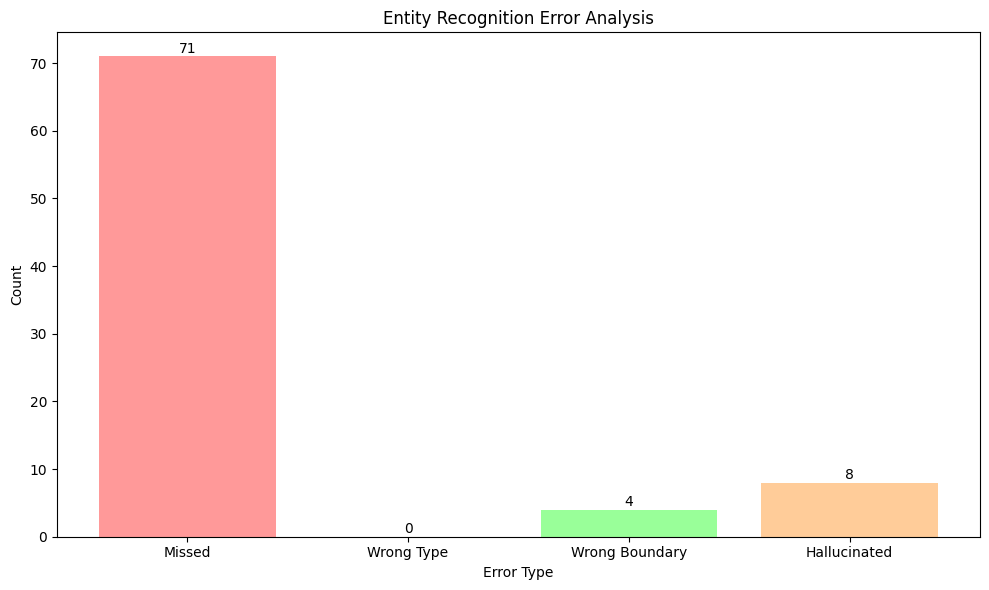

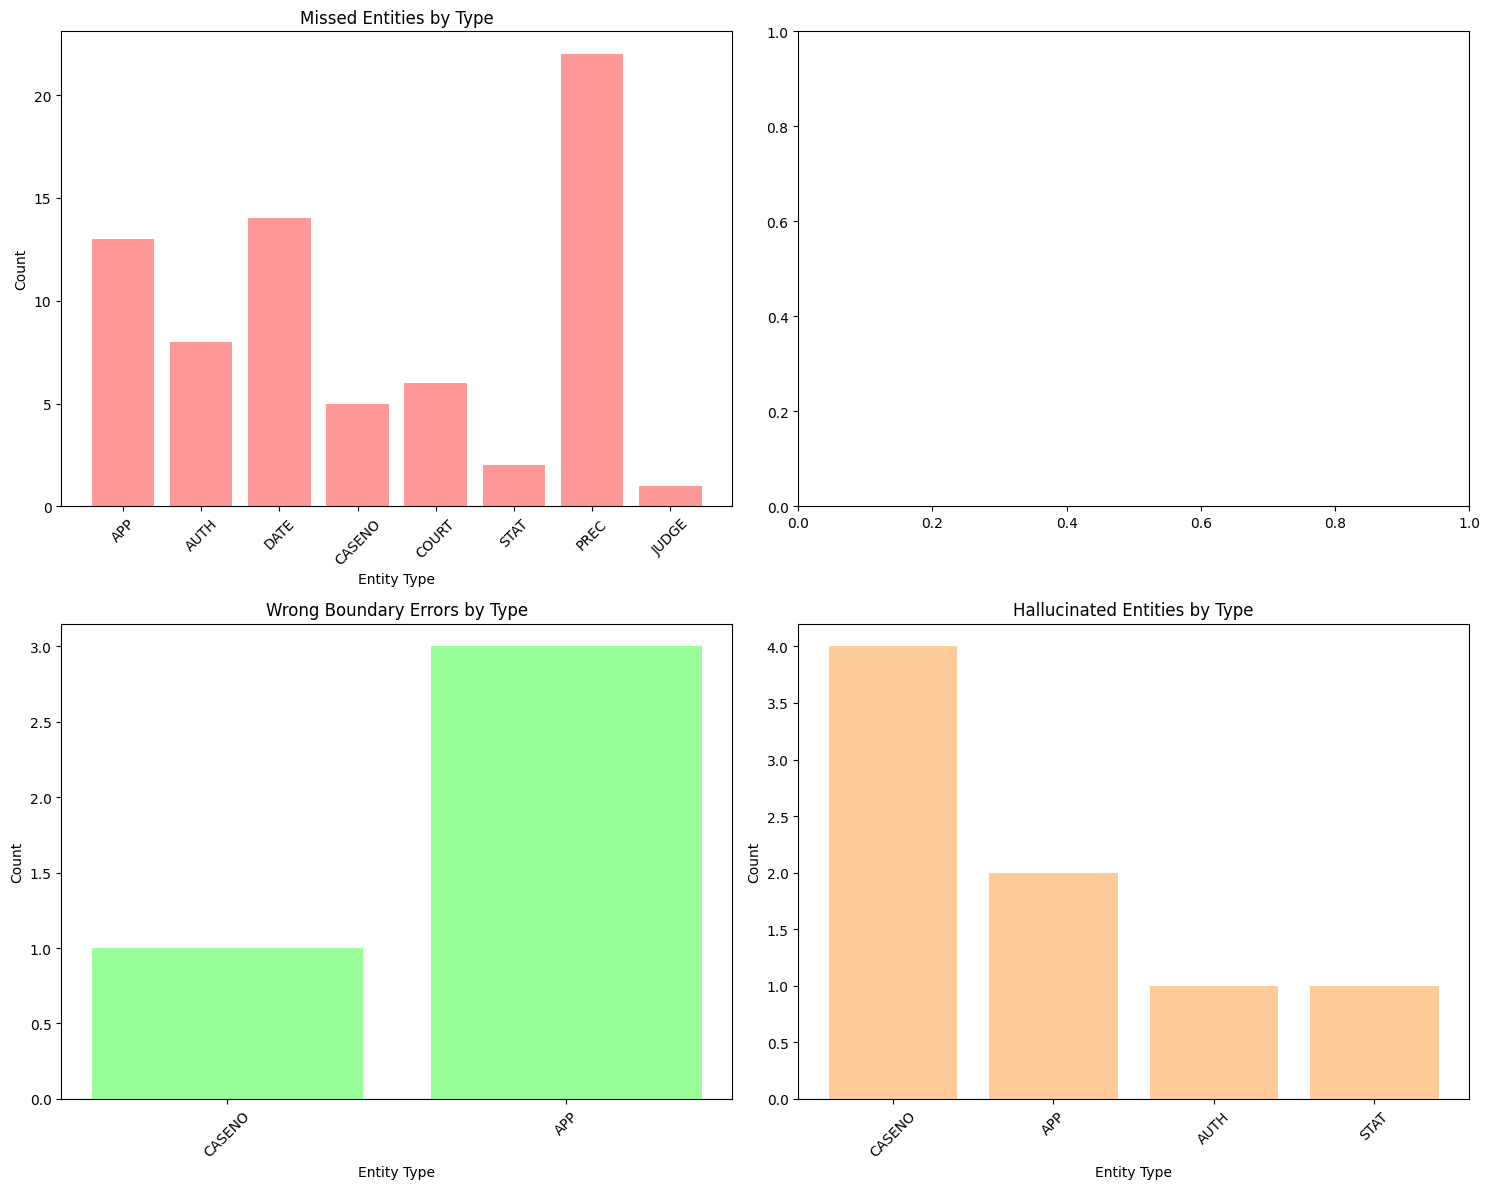

Cross-validation complete!


In [104]:
if __name__ == "__main__":
    best_model, cv_results = run_cross_validation()
    
    # Test on sample documents from each fold
    print("\nTesting on sample document from fold1:")
    predicted_entities1, true_entities1 = test_on_sample(best_model, sample_idx=0, fold_name="fold1")
    
    print("\nTesting on sample document from fold2:")
    predicted_entities2, true_entities2 = test_on_sample(best_model, sample_idx=0, fold_name="fold2")
    
    print("\nTesting on sample document from fold3:")
    predicted_entities3, true_entities3 = test_on_sample(best_model, sample_idx=0, fold_name="fold3")
    
    print("Cross-validation complete!")

## **Model : nlpaueb/legal-bert-base-uncased**

**Using a learning rate of `3e-5` was selected for the non-CRF configuration, following the BERT-recommended range of `1e-5` to `5e-5`.**

In [121]:
# Update the model name in non_crf_config
non_crf_config["model_name"] = "nlpaueb/legal-bert-base-uncased"

print("Non-CRF Config Model Name:", non_crf_config["model_name"])

Non-CRF Config Model Name: nlpaueb/legal-bert-base-uncased


In [122]:
# tokenizer = load_tokenizer(crf_config)
tokenizer = load_tokenizer(non_crf_config) #for non-crf

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Tokenizer loaded for model: nlpaueb/legal-bert-base-uncased


In [123]:
for key, value in config.items():
    print(f"{key}: {value}")

max_length: 512
stride: 128
batch_size: 8
weight_decay: 0.01
epochs: 15
warmup_ratio: 0.1
early_stop_patience: 3
visualize_training: True
visualize_entities: True
visualize_confusion: True
problematic_entities: {'R.COUNSEL': 4.0, 'A.COUNSEL': 3.5, 'JUDGE': 3.0, 'WIT': 3.2, 'RESP': 2.3, 'APP': 1.8, 'CASENO': 1.4, 'AUTH': 1.4}
data_files: {'fold1': '/kaggle/input/legalcasedocuments/fold1.json', 'fold2': '/kaggle/input/legalcasedocuments/fold2.json', 'fold3': '/kaggle/input/legalcasedocuments/fold3.json'}
model_name: nlpaueb/legal-bert-base-uncased
use_crf: False
metrics_per_label: True
gradient_accumulation: 1
learning_rate: 3e-05
fp16: True



Training on fold2, fold3 and validating on fold1

Created 1325 training samples and 639 validation samples


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

/tmp/ipykernel_31/446815027.py:52: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler       = torch.cuda.amp.GradScaler() if config["fp16"] and torch.cuda.is_available() else None


Epoch 1/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

/tmp/ipykernel_31/446815027.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 1/15:
  Train Loss: 1.0313
  Val   Loss: 0.2274
  Val   F1:   0.0207 (P: 0.8600, R: 0.0105)
  Per-type metrics (top 5 by support):
    DATE: F1=0.0478, P=0.8696, R=0.0246, N=813
    PREC: F1=0.0000, P=0.0000, R=0.0000, N=624
    AUTH: F1=0.0000, P=0.0000, R=0.0000, N=534
    STAT: F1=0.0000, P=0.0000, R=0.0000, N=519
    COURT: F1=0.0954, P=0.8519, R=0.0505, N=455
  ↗ New best F1: 0.0207 (was 0.0000)


Epoch 2/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 2/15:
  Train Loss: 0.1868
  Val   Loss: 0.1120
  Val   F1:   0.5656 (P: 0.6237, R: 0.5174)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9295, P=0.9267, R=0.9323, N=813
    PREC: F1=0.3871, P=0.4000, R=0.3750, N=624
    AUTH: F1=0.2510, P=0.3882, R=0.1854, N=534
    STAT: F1=0.7774, P=0.7496, R=0.8073, N=519
    COURT: F1=0.6962, P=0.7217, R=0.6725, N=455
  ↗ New best F1: 0.5656 (was 0.0207)


Epoch 3/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 3/15:
  Train Loss: 0.1025
  Val   Loss: 0.1111
  Val   F1:   0.5969 (P: 0.5750, R: 0.6205)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9483, P=0.9271, R=0.9705, N=813
    PREC: F1=0.4578, P=0.4638, R=0.4519, N=624
    AUTH: F1=0.4066, P=0.4231, R=0.3914, N=534
    STAT: F1=0.8028, P=0.7418, R=0.8748, N=519
    COURT: F1=0.7486, P=0.7414, R=0.7560, N=455
  ↗ New best F1: 0.5969 (was 0.5656)


Epoch 4/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 4/15:
  Train Loss: 0.0730
  Val   Loss: 0.1128
  Val   F1:   0.6023 (P: 0.5984, R: 0.6064)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9557, P=0.9436, R=0.9680, N=813
    PREC: F1=0.3874, P=0.4007, R=0.3750, N=624
    AUTH: F1=0.3776, P=0.3889, R=0.3670, N=534
    STAT: F1=0.7926, P=0.7629, R=0.8247, N=519
    COURT: F1=0.7344, P=0.7082, R=0.7626, N=455
  ↗ New best F1: 0.6023 (was 0.5969)


Epoch 5/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 5/15:
  Train Loss: 0.0557
  Val   Loss: 0.1255
  Val   F1:   0.5761 (P: 0.5192, R: 0.6470)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9410, P=0.9122, R=0.9717, N=813
    PREC: F1=0.4393, P=0.4080, R=0.4760, N=624
    AUTH: F1=0.3679, P=0.3707, R=0.3652, N=534
    STAT: F1=0.8220, P=0.7607, R=0.8940, N=519
    COURT: F1=0.7065, P=0.6367, R=0.7934, N=455
  ↘ No improvement (1/3)


Epoch 6/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 6/15:
  Train Loss: 0.0414
  Val   Loss: 0.1245
  Val   F1:   0.5943 (P: 0.5877, R: 0.6010)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9517, P=0.9348, R=0.9692, N=813
    PREC: F1=0.3673, P=0.3833, R=0.3526, N=624
    AUTH: F1=0.3417, P=0.3881, R=0.3052, N=534
    STAT: F1=0.8264, P=0.7895, R=0.8671, N=519
    COURT: F1=0.7211, P=0.7235, R=0.7187, N=455
  ↘ No improvement (2/3)


Epoch 7/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 7/15:
  Train Loss: 0.0327
  Val   Loss: 0.1333
  Val   F1:   0.6094 (P: 0.5646, R: 0.6620)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9569, P=0.9438, R=0.9705, N=813
    PREC: F1=0.4546, P=0.4274, R=0.4856, N=624
    AUTH: F1=0.3973, P=0.4075, R=0.3876, N=534
    STAT: F1=0.8114, P=0.7731, R=0.8536, N=519
    COURT: F1=0.7164, P=0.6545, R=0.7912, N=455
  ↗ New best F1: 0.6094 (was 0.6023)


Epoch 8/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 8/15:
  Train Loss: 0.0234
  Val   Loss: 0.1415
  Val   F1:   0.6169 (P: 0.5715, R: 0.6701)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9557, P=0.9436, R=0.9680, N=813
    PREC: F1=0.4561, P=0.4037, R=0.5240, N=624
    AUTH: F1=0.3819, P=0.4025, R=0.3633, N=534
    STAT: F1=0.8312, P=0.7856, R=0.8825, N=519
    COURT: F1=0.7269, P=0.6572, R=0.8132, N=455
  ↗ New best F1: 0.6169 (was 0.6094)


Epoch 9/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 9/15:
  Train Loss: 0.0173
  Val   Loss: 0.1481
  Val   F1:   0.6056 (P: 0.5792, R: 0.6346)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9537, P=0.9456, R=0.9619, N=813
    PREC: F1=0.4403, P=0.3995, R=0.4904, N=624
    AUTH: F1=0.3696, P=0.4237, R=0.3277, N=534
    STAT: F1=0.7572, P=0.7514, R=0.7630, N=519
    COURT: F1=0.7408, P=0.7282, R=0.7538, N=455
  ↘ No improvement (1/3)


Epoch 10/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 10/15:
  Train Loss: 0.0142
  Val   Loss: 0.1568
  Val   F1:   0.6116 (P: 0.5773, R: 0.6504)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9541, P=0.9382, R=0.9705, N=813
    PREC: F1=0.4557, P=0.4111, R=0.5112, N=624
    AUTH: F1=0.3980, P=0.4200, R=0.3783, N=534
    STAT: F1=0.7962, P=0.7800, R=0.8131, N=519
    COURT: F1=0.7497, P=0.7054, R=0.8000, N=455
  ↘ No improvement (2/3)


Epoch 11/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 11/15:
  Train Loss: 0.0103
  Val   Loss: 0.1560
  Val   F1:   0.6228 (P: 0.6170, R: 0.6287)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9552, P=0.9415, R=0.9692, N=813
    PREC: F1=0.4433, P=0.4173, R=0.4728, N=624
    AUTH: F1=0.3751, P=0.4491, R=0.3221, N=534
    STAT: F1=0.7660, P=0.7689, R=0.7630, N=519
    COURT: F1=0.7532, P=0.7241, R=0.7846, N=455
  ↗ New best F1: 0.6228 (was 0.6169)


Epoch 12/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 12/15:
  Train Loss: 0.0086
  Val   Loss: 0.1692
  Val   F1:   0.6138 (P: 0.5762, R: 0.6567)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9541, P=0.9371, R=0.9717, N=813
    PREC: F1=0.4419, P=0.3959, R=0.5000, N=624
    AUTH: F1=0.4059, P=0.4283, R=0.3858, N=534
    STAT: F1=0.8092, P=0.7756, R=0.8459, N=519
    COURT: F1=0.7472, P=0.7043, R=0.7956, N=455
  ↘ No improvement (1/3)


Epoch 13/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 13/15:
  Train Loss: 0.0073
  Val   Loss: 0.1704
  Val   F1:   0.6226 (P: 0.5923, R: 0.6562)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9546, P=0.9403, R=0.9692, N=813
    PREC: F1=0.4652, P=0.4143, R=0.5304, N=624
    AUTH: F1=0.3902, P=0.4292, R=0.3577, N=534
    STAT: F1=0.8126, P=0.7801, R=0.8478, N=519
    COURT: F1=0.7555, P=0.7229, R=0.7912, N=455
  ↘ No improvement (2/3)


Epoch 14/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 14/15:
  Train Loss: 0.0064
  Val   Loss: 0.1734
  Val   F1:   0.6196 (P: 0.5902, R: 0.6521)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9553, P=0.9394, R=0.9717, N=813
    PREC: F1=0.4614, P=0.4194, R=0.5128, N=624
    AUTH: F1=0.3836, P=0.4240, R=0.3502, N=534
    STAT: F1=0.7989, P=0.7764, R=0.8227, N=519
    COURT: F1=0.7568, P=0.7234, R=0.7934, N=455
  ↘ No improvement (3/3)
Early stopping at epoch 14


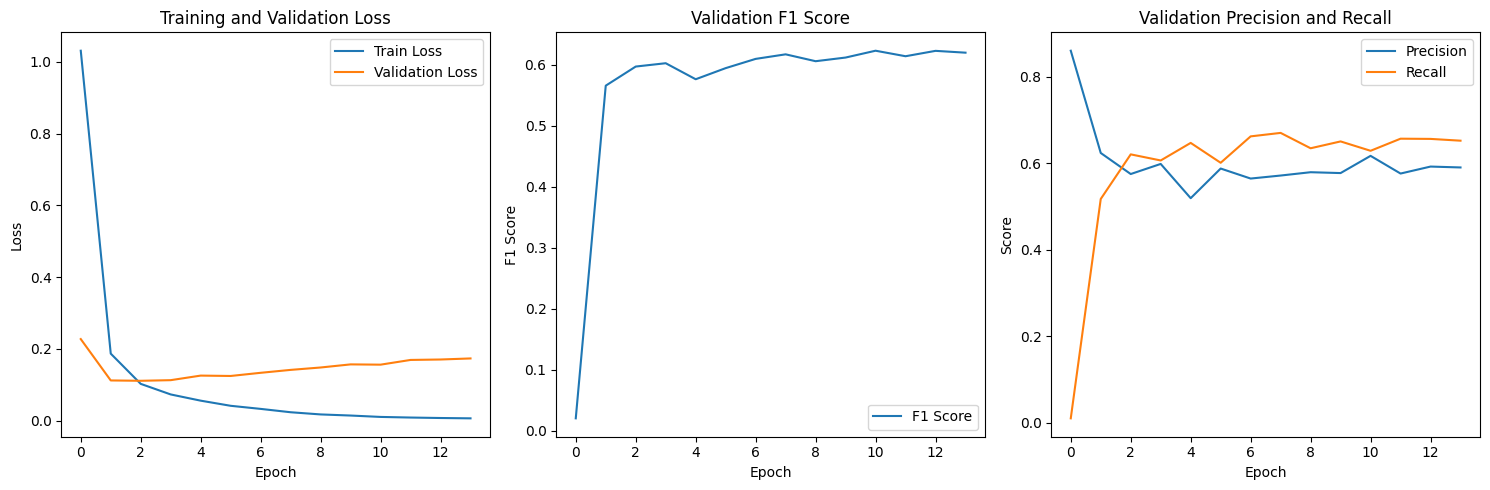


Final evaluation on validation set:


Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
  F1:        0.6228
  Precision: 0.6170
  Recall:    0.6287

Training on fold1, fold3 and validating on fold2

Created 1320 training samples and 644 validation samples


Epoch 1/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 1/15:
  Train Loss: 0.9507
  Val   Loss: 0.2115
  Val   F1:   0.0976 (P: 0.9129, R: 0.0515)
  Per-type metrics (top 5 by support):
    DATE: F1=0.0000, P=0.0000, R=0.0000, N=762
    STAT: F1=0.0000, P=0.0000, R=0.0000, N=731
    PREC: F1=0.0000, P=0.0000, R=0.0000, N=559
    COURT: F1=0.5507, P=0.9129, R=0.3943, N=558
    AUTH: F1=0.0000, P=0.0000, R=0.0000, N=468
  ↗ New best F1: 0.0976 (was 0.0000)


Epoch 2/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 2/15:
  Train Loss: 0.1767
  Val   Loss: 0.1408
  Val   F1:   0.5697 (P: 0.5403, R: 0.6025)
  Per-type metrics (top 5 by support):
    DATE: F1=0.8866, P=0.8360, R=0.9436, N=762
    STAT: F1=0.7212, P=0.6718, R=0.7784, N=731
    PREC: F1=0.4165, P=0.3736, R=0.4705, N=559
    COURT: F1=0.7723, P=0.7293, R=0.8208, N=558
    AUTH: F1=0.5373, P=0.5028, R=0.5769, N=468
  ↗ New best F1: 0.5697 (was 0.0976)


Epoch 3/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 3/15:
  Train Loss: 0.1011
  Val   Loss: 0.1205
  Val   F1:   0.5851 (P: 0.5618, R: 0.6104)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9317, P=0.9329, R=0.9304, N=762
    STAT: F1=0.7358, P=0.7441, R=0.7278, N=731
    PREC: F1=0.4943, P=0.4507, R=0.5474, N=559
    COURT: F1=0.8084, P=0.7897, R=0.8280, N=558
    AUTH: F1=0.4485, P=0.6598, R=0.3397, N=468
  ↗ New best F1: 0.5851 (was 0.5697)


Epoch 4/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 4/15:
  Train Loss: 0.0717
  Val   Loss: 0.1297
  Val   F1:   0.6225 (P: 0.5957, R: 0.6519)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9420, P=0.9458, R=0.9383, N=762
    STAT: F1=0.7736, P=0.7784, R=0.7688, N=731
    PREC: F1=0.5184, P=0.4867, R=0.5546, N=559
    COURT: F1=0.8157, P=0.7922, R=0.8405, N=558
    AUTH: F1=0.5082, P=0.5590, R=0.4658, N=468
  ↗ New best F1: 0.6225 (was 0.5851)


Epoch 5/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 5/15:
  Train Loss: 0.0518
  Val   Loss: 0.1406
  Val   F1:   0.6389 (P: 0.5937, R: 0.6915)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9255, P=0.8986, R=0.9541, N=762
    STAT: F1=0.7757, P=0.7490, R=0.8044, N=731
    PREC: F1=0.5191, P=0.4460, R=0.6208, N=559
    COURT: F1=0.7905, P=0.7532, R=0.8315, N=558
    AUTH: F1=0.5144, P=0.5346, R=0.4957, N=468
  ↗ New best F1: 0.6389 (was 0.6225)


Epoch 6/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 6/15:
  Train Loss: 0.0381
  Val   Loss: 0.1408
  Val   F1:   0.6426 (P: 0.5950, R: 0.6985)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9197, P=0.8936, R=0.9475, N=762
    STAT: F1=0.8011, P=0.7899, R=0.8126, N=731
    PREC: F1=0.5154, P=0.4371, R=0.6279, N=559
    COURT: F1=0.7599, P=0.7062, R=0.8226, N=558
    AUTH: F1=0.5308, P=0.5831, R=0.4872, N=468
  ↗ New best F1: 0.6426 (was 0.6389)


Epoch 7/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 7/15:
  Train Loss: 0.0288
  Val   Loss: 0.1551
  Val   F1:   0.6578 (P: 0.6242, R: 0.6952)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9395, P=0.9316, R=0.9475, N=762
    STAT: F1=0.8050, P=0.7812, R=0.8304, N=731
    PREC: F1=0.5292, P=0.4683, R=0.6082, N=559
    COURT: F1=0.8031, P=0.7750, R=0.8333, N=558
    AUTH: F1=0.4913, P=0.5858, R=0.4231, N=468
  ↗ New best F1: 0.6578 (was 0.6426)


Epoch 8/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 8/15:
  Train Loss: 0.0221
  Val   Loss: 0.1705
  Val   F1:   0.6513 (P: 0.6112, R: 0.6971)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9312, P=0.9130, R=0.9501, N=762
    STAT: F1=0.7960, P=0.7739, R=0.8194, N=731
    PREC: F1=0.5159, P=0.4327, R=0.6386, N=559
    COURT: F1=0.7814, P=0.7659, R=0.7975, N=558
    AUTH: F1=0.5034, P=0.5282, R=0.4808, N=468
  ↘ No improvement (1/3)


Epoch 9/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 9/15:
  Train Loss: 0.0175
  Val   Loss: 0.1748
  Val   F1:   0.6545 (P: 0.6132, R: 0.7018)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9306, P=0.9118, R=0.9501, N=762
    STAT: F1=0.8034, P=0.7758, R=0.8331, N=731
    PREC: F1=0.5207, P=0.4439, R=0.6297, N=559
    COURT: F1=0.7944, P=0.7761, R=0.8136, N=558
    AUTH: F1=0.5305, P=0.6016, R=0.4744, N=468
  ↘ No improvement (2/3)


Epoch 10/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 10/15:
  Train Loss: 0.0143
  Val   Loss: 0.1814
  Val   F1:   0.6448 (P: 0.5953, R: 0.7032)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9171, P=0.8852, R=0.9514, N=762
    STAT: F1=0.8038, P=0.7563, R=0.8577, N=731
    PREC: F1=0.5266, P=0.4489, R=0.6369, N=559
    COURT: F1=0.7976, P=0.7678, R=0.8297, N=558
    AUTH: F1=0.4753, P=0.5288, R=0.4316, N=468
  ↘ No improvement (3/3)
Early stopping at epoch 10


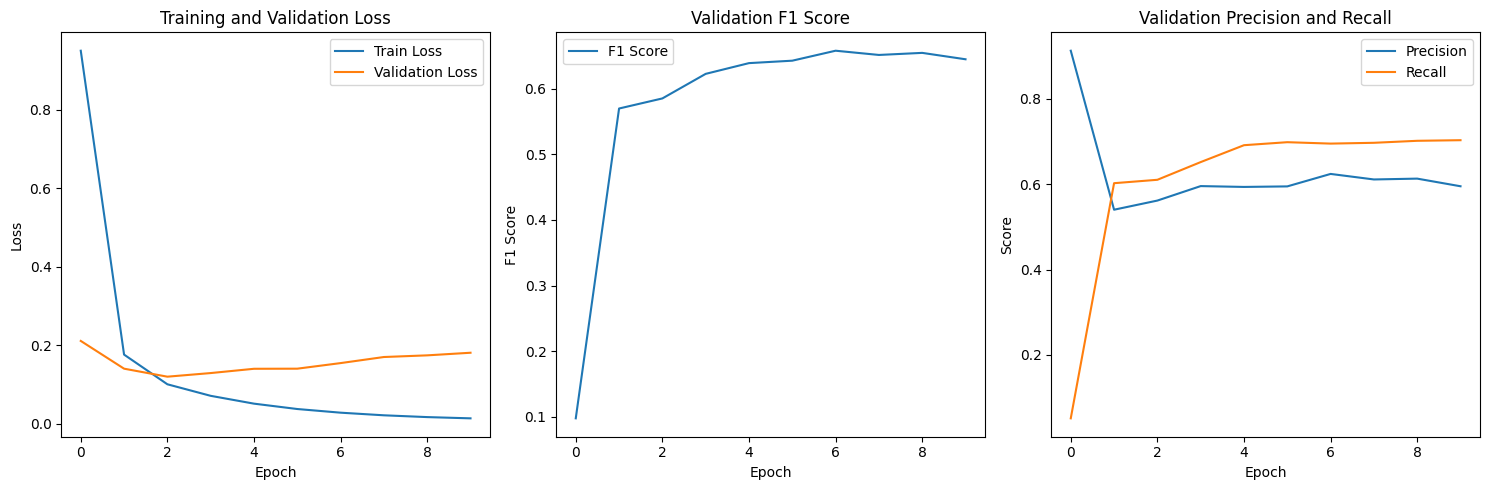


Final evaluation on validation set:


Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
  F1:        0.6578
  Precision: 0.6242
  Recall:    0.6952

Training on fold1, fold2 and validating on fold3

Created 1283 training samples and 681 validation samples


Epoch 1/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
Epoch 1/15:
  Train Loss: 1.1675
  Val   Loss: 0.2030
  Val   F1:   0.0033 (P: 1.0000, R: 0.0017)
  Per-type metrics (top 5 by support):
    STAT: F1=0.0000, P=0.0000, R=0.0000, N=795
    DATE: F1=0.0187, P=1.0000, R=0.0094, N=741
    PREC: F1=0.0000, P=0.0000, R=0.0000, N=621
    COURT: F1=0.0000, P=0.0000, R=0.0000, N=559
    CASENO: F1=0.0000, P=0.0000, R=0.0000, N=342
  ↗ New best F1: 0.0033 (was 0.0000)


Epoch 2/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
Epoch 2/15:
  Train Loss: 0.2081
  Val   Loss: 0.1254
  Val   F1:   0.5354 (P: 0.4829, R: 0.6007)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7585, P=0.6838, R=0.8516, N=795
    DATE: F1=0.9320, P=0.9209, R=0.9433, N=741
    PREC: F1=0.4302, P=0.3921, R=0.4767, N=621
    COURT: F1=0.7379, P=0.6469, R=0.8587, N=559
    CASENO: F1=0.6272, P=0.6926, R=0.5731, N=342
  ↗ New best F1: 0.5354 (was 0.0033)


Epoch 3/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
Epoch 3/15:
  Train Loss: 0.1164
  Val   Loss: 0.1007
  Val   F1:   0.6176 (P: 0.5782, R: 0.6627)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7845, P=0.7338, R=0.8428, N=795
    DATE: F1=0.9477, P=0.9536, R=0.9420, N=741
    PREC: F1=0.5205, P=0.5000, R=0.5427, N=621
    COURT: F1=0.8185, P=0.8142, R=0.8229, N=559
    CASENO: F1=0.6260, P=0.6550, R=0.5994, N=342
  ↗ New best F1: 0.6176 (was 0.5354)


Epoch 4/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
Epoch 4/15:
  Train Loss: 0.0789
  Val   Loss: 0.1087
  Val   F1:   0.6518 (P: 0.6029, R: 0.7094)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7685, P=0.6904, R=0.8667, N=795
    DATE: F1=0.9564, P=0.9507, R=0.9622, N=741
    PREC: F1=0.5057, P=0.4825, R=0.5314, N=621
    COURT: F1=0.8339, P=0.8154, R=0.8533, N=559
    CASENO: F1=0.6564, P=0.6283, R=0.6871, N=342
  ↗ New best F1: 0.6518 (was 0.6176)


Epoch 5/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
Epoch 5/15:
  Train Loss: 0.0587
  Val   Loss: 0.1157
  Val   F1:   0.6478 (P: 0.6012, R: 0.7023)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7815, P=0.7150, R=0.8616, N=795
    DATE: F1=0.9328, P=0.9112, R=0.9555, N=741
    PREC: F1=0.5302, P=0.4931, R=0.5733, N=621
    COURT: F1=0.8096, P=0.7807, R=0.8408, N=559
    CASENO: F1=0.6270, P=0.5725, R=0.6930, N=342
  ↘ No improvement (1/3)


Epoch 6/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
Epoch 6/15:
  Train Loss: 0.0446
  Val   Loss: 0.1155
  Val   F1:   0.6561 (P: 0.5940, R: 0.7328)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7826, P=0.7116, R=0.8692, N=795
    DATE: F1=0.9398, P=0.9323, R=0.9474, N=741
    PREC: F1=0.6029, P=0.5743, R=0.6345, N=621
    COURT: F1=0.8256, P=0.7905, R=0.8640, N=559
    CASENO: F1=0.6338, P=0.6114, R=0.6579, N=342
  ↗ New best F1: 0.6561 (was 0.6518)


Epoch 7/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
Epoch 7/15:
  Train Loss: 0.0326
  Val   Loss: 0.1251
  Val   F1:   0.6617 (P: 0.6166, R: 0.7139)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7901, P=0.7313, R=0.8591, N=795
    DATE: F1=0.9562, P=0.9543, R=0.9582, N=741
    PREC: F1=0.5114, P=0.4985, R=0.5250, N=621
    COURT: F1=0.8323, P=0.8091, R=0.8569, N=559
    CASENO: F1=0.6444, P=0.6398, R=0.6491, N=342
  ↗ New best F1: 0.6617 (was 0.6561)


Epoch 8/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
Epoch 8/15:
  Train Loss: 0.0243
  Val   Loss: 0.1340
  Val   F1:   0.6672 (P: 0.6160, R: 0.7278)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7739, P=0.6999, R=0.8654, N=795
    DATE: F1=0.9480, P=0.9486, R=0.9474, N=741
    PREC: F1=0.5490, P=0.5202, R=0.5813, N=621
    COURT: F1=0.8230, P=0.7917, R=0.8569, N=559
    CASENO: F1=0.6481, P=0.6180, R=0.6813, N=342
  ↗ New best F1: 0.6672 (was 0.6617)


Epoch 9/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
Epoch 9/15:
  Train Loss: 0.0183
  Val   Loss: 0.1439
  Val   F1:   0.6761 (P: 0.6242, R: 0.7373)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7922, P=0.7252, R=0.8730, N=795
    DATE: F1=0.9521, P=0.9515, R=0.9528, N=741
    PREC: F1=0.5643, P=0.5167, R=0.6216, N=621
    COURT: F1=0.8260, P=0.8003, R=0.8533, N=559
    CASENO: F1=0.6540, P=0.6531, R=0.6550, N=342
  ↗ New best F1: 0.6761 (was 0.6672)


Epoch 10/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
Epoch 10/15:
  Train Loss: 0.0137
  Val   Loss: 0.1494
  Val   F1:   0.6793 (P: 0.6340, R: 0.7316)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7836, P=0.7176, R=0.8629, N=795
    DATE: F1=0.9497, P=0.9440, R=0.9555, N=741
    PREC: F1=0.6003, P=0.5608, R=0.6457, N=621
    COURT: F1=0.8193, P=0.8038, R=0.8354, N=559
    CASENO: F1=0.6535, P=0.6304, R=0.6784, N=342
  ↗ New best F1: 0.6793 (was 0.6761)


Epoch 11/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
Epoch 11/15:
  Train Loss: 0.0117
  Val   Loss: 0.1538
  Val   F1:   0.6892 (P: 0.6519, R: 0.7311)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7906, P=0.7268, R=0.8667, N=795
    DATE: F1=0.9512, P=0.9430, R=0.9595, N=741
    PREC: F1=0.5932, P=0.5620, R=0.6280, N=621
    COURT: F1=0.8285, P=0.8068, R=0.8515, N=559
    CASENO: F1=0.6686, P=0.6647, R=0.6725, N=342
  ↗ New best F1: 0.6892 (was 0.6793)


Epoch 12/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
Epoch 12/15:
  Train Loss: 0.0095
  Val   Loss: 0.1609
  Val   F1:   0.6856 (P: 0.6452, R: 0.7313)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7885, P=0.7259, R=0.8629, N=795
    DATE: F1=0.9484, P=0.9415, R=0.9555, N=741
    PREC: F1=0.5840, P=0.5533, R=0.6184, N=621
    COURT: F1=0.8239, P=0.8111, R=0.8372, N=559
    CASENO: F1=0.6563, P=0.6332, R=0.6813, N=342
  ↘ No improvement (1/3)


Epoch 13/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
Epoch 13/15:
  Train Loss: 0.0079
  Val   Loss: 0.1649
  Val   F1:   0.6895 (P: 0.6569, R: 0.7256)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7871, P=0.7271, R=0.8579, N=795
    DATE: F1=0.9517, P=0.9466, R=0.9568, N=741
    PREC: F1=0.5937, P=0.5695, R=0.6200, N=621
    COURT: F1=0.8252, P=0.8068, R=0.8444, N=559
    CASENO: F1=0.6452, P=0.6199, R=0.6725, N=342
  ↗ New best F1: 0.6895 (was 0.6892)


Epoch 14/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
Epoch 14/15:
  Train Loss: 0.0069
  Val   Loss: 0.1679
  Val   F1:   0.6876 (P: 0.6572, R: 0.7209)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7956, P=0.7371, R=0.8642, N=795
    DATE: F1=0.9524, P=0.9455, R=0.9595, N=741
    PREC: F1=0.5673, P=0.5400, R=0.5974, N=621
    COURT: F1=0.8310, P=0.8180, R=0.8444, N=559
    CASENO: F1=0.6458, P=0.6288, R=0.6637, N=342
  ↘ No improvement (1/3)


Epoch 15/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
Epoch 15/15:
  Train Loss: 0.0064
  Val   Loss: 0.1683
  Val   F1:   0.6871 (P: 0.6542, R: 0.7235)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7919, P=0.7326, R=0.8616, N=795
    DATE: F1=0.9517, P=0.9466, R=0.9568, N=741
    PREC: F1=0.5795, P=0.5490, R=0.6135, N=621
    COURT: F1=0.8244, P=0.8136, R=0.8354, N=559
    CASENO: F1=0.6543, P=0.6397, R=0.6696, N=342
  ↘ No improvement (2/3)


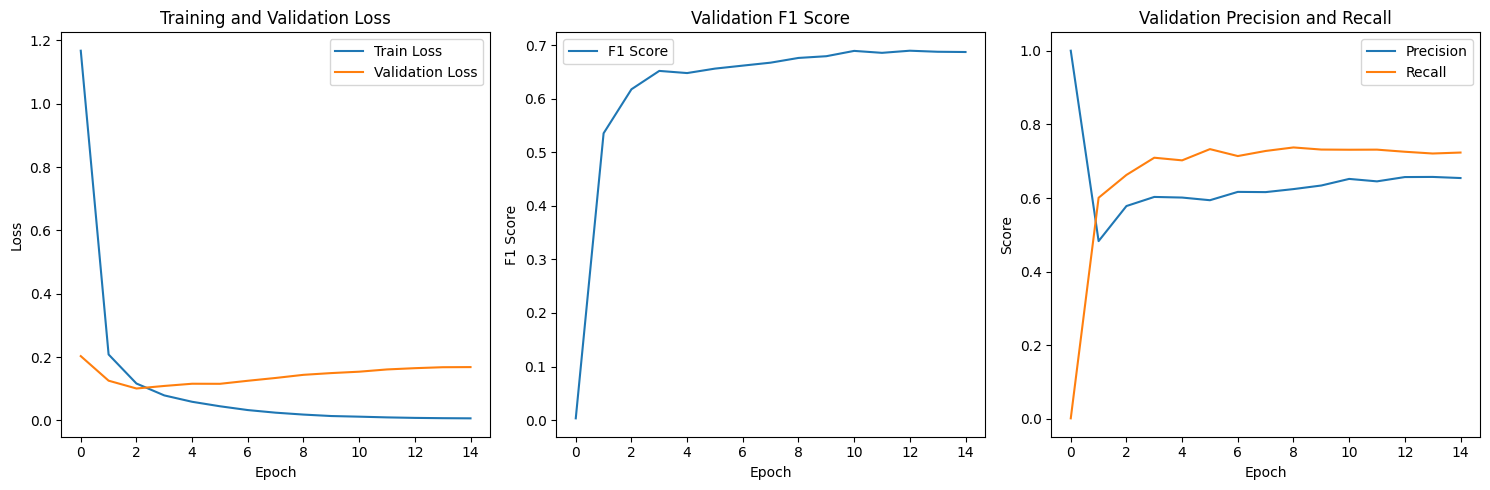


Final evaluation on validation set:


Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
  F1:        0.6895
  Precision: 0.6569
  Recall:    0.7256

Cross-validation results:
  Fold 1: F1 = 0.6228
  Fold 2: F1 = 0.6578
  Fold 3: F1 = 0.6895
  Average: F1 = 0.6567, Precision = 0.6327, Recall = 0.6832


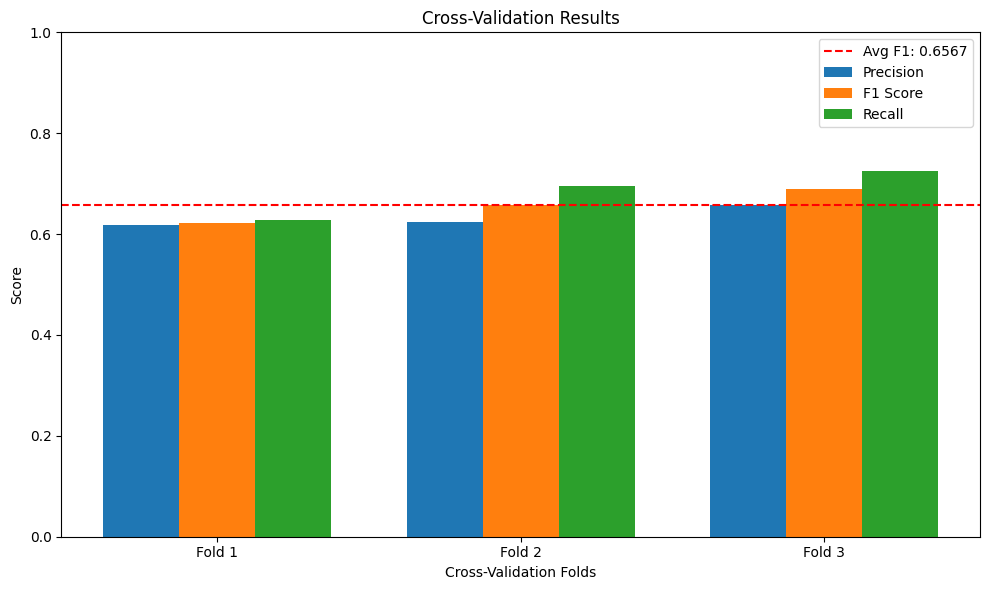


Analyzing entity distribution across the dataset:


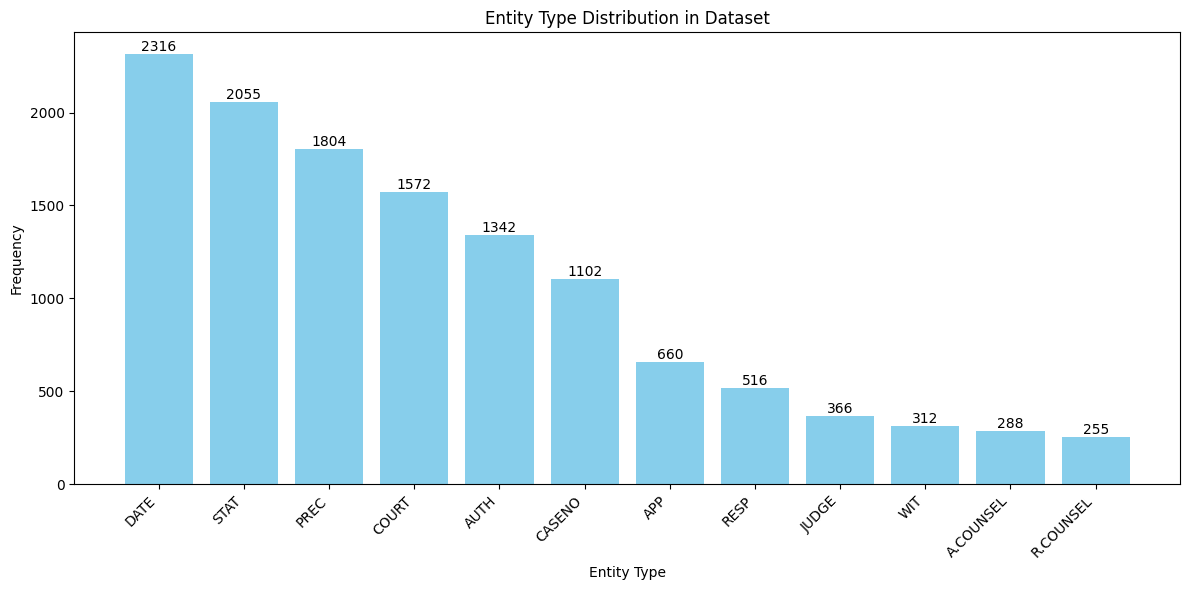

Best model saved to best_legal_ner_model_nlpaueb_legal_bert_base_uncased_CRF_false.pt
Model configuration saved to model_config_nlpaueb_legal_bert_base_uncased_CRF_false.json

Testing on sample document from fold2:

Testing entity extraction on a sample document:

Sample document excerpt:
IN THE HIGH COURT AT CALCUTTA CIVIL REVISIONAL JURISDICTION APPELLATE SIDE Before: The Hon'ble Justice Hiranmay Bhattacharyya C.O. 3346 of 2018 The Kolkata Municipal Corporation Vs. Smt. Kajari Banerjee For the petitioner : Mr. Alok Kr. Ghosh, Mr. S.K. Debnath..... advocates For the opposite party : Mr. R.N. Chakraborty, Mr. M. Ahmed............ advocates Heard on : 18.12.2020 Judgment on : 22.12.2020 Hiranmay Bhattacharyya, J.: This application under Article 227 of the Constitution of India is ...


Predicted entities visualization:


Found 32 entities:
1. JUDGE: 'Hiranmay Bhattacharyya'
2. CASENO: 'C.O. 3346 of 2018'
3. APP: 'Kolkata Municipal Corporation'
4. RESP: 'Smt. Kajari Banerjee'
5. A.COUNSEL: 'Al'
6. A.COUNSEL: 'S'
7. R.COUNSEL: 'R.N. Chakraborty'
8. R.COUNSEL: 'M. Ahmed'
9. CASENO: '18.12.2020'
10. CASENO: '22.12.2020'
11. JUDGE: 'Hiranmay Bhattacharyya'
12. STAT: 'Constitution of India'
13. APP: 'Kolkata Municipal Corporation'
14. DATE: 'March 27, 2018'
15. AUTH: 'Municipal Assessment Tribunal'
16. APP: 'Kolkata Municipal Corporation'
17. CASENO: 'M.A. Appeal no. 947 of 2012'
18. DATE: 'March 24, 2012'
19. DATE: 'fourth quarter of 2009-10'
20. CASENO: 'M.A. Appeal no. 947 of 2012'
21. DATE: 'March 24, 2012'
22. AUTH: 'Municipal Assessment Tribunal'
23. DATE: 'February 16, 2015'
24. APP: 'Kolkata Municipal Corporation'
25. DATE: 'February 16, 2015'
26. STAT: 'Constitution of India'
27. CASENO: 'C.O. no. 2623 of 2017'
28. DATE: 'December 18, 2017'
29. CASENO: 'Civil Order No. 2623 of 2017'
30. DATE: 'Febru

Found 113 entities:
1. JUDGE: 'Hiranmay Bhattacharyya'
2. CASENO: 'C.O. 3346 of 2018'
3. APP: 'Kolkata Municipal Corporation'
4. RESP: 'Smt. Kajari Banerjee'
5. A.COUNSEL: 'Ghosh'
6. R.COUNSEL: 'R.N. Chakraborty'
7. R.COUNSEL: 'M. Ahmed'
8. CASENO: '18.12.2020'
9. CASENO: '22.12.2020'
10. JUDGE: 'Hiranmay Bhattacharyya'
11. STAT: 'Constitution of India'
12. APP: 'Kolkata Municipal Corporation'
13. DATE: 'March 27, 2018'
14. AUTH: 'Municipal Assessment Tribunal'
15. APP: 'Kolkata Municipal Corporation'
16. CASENO: 'M.A. Appeal no. 947 of 2012'
17. DATE: 'March 24, 2012'
18. DATE: 'fourth quarter of 2009-10'
19. CASENO: 'M.A. Appeal no. 947 of 2012'
20. DATE: 'March 24, 2012'
21. AUTH: 'Municipal Assessment Tribunal'
22. DATE: 'February 16, 2015'
23. APP: 'Kolkata Municipal Corporation'
24. DATE: 'February 16, 2015'
25. STAT: 'Constitution of India'
26. CASENO: 'C.O. no. 2623 of 2017'
27. DATE: 'December 18, 2017'
28. CASENO: 'Civil Order No. 2623 of 2017'
29. DATE: 'February 16, 2015'
3

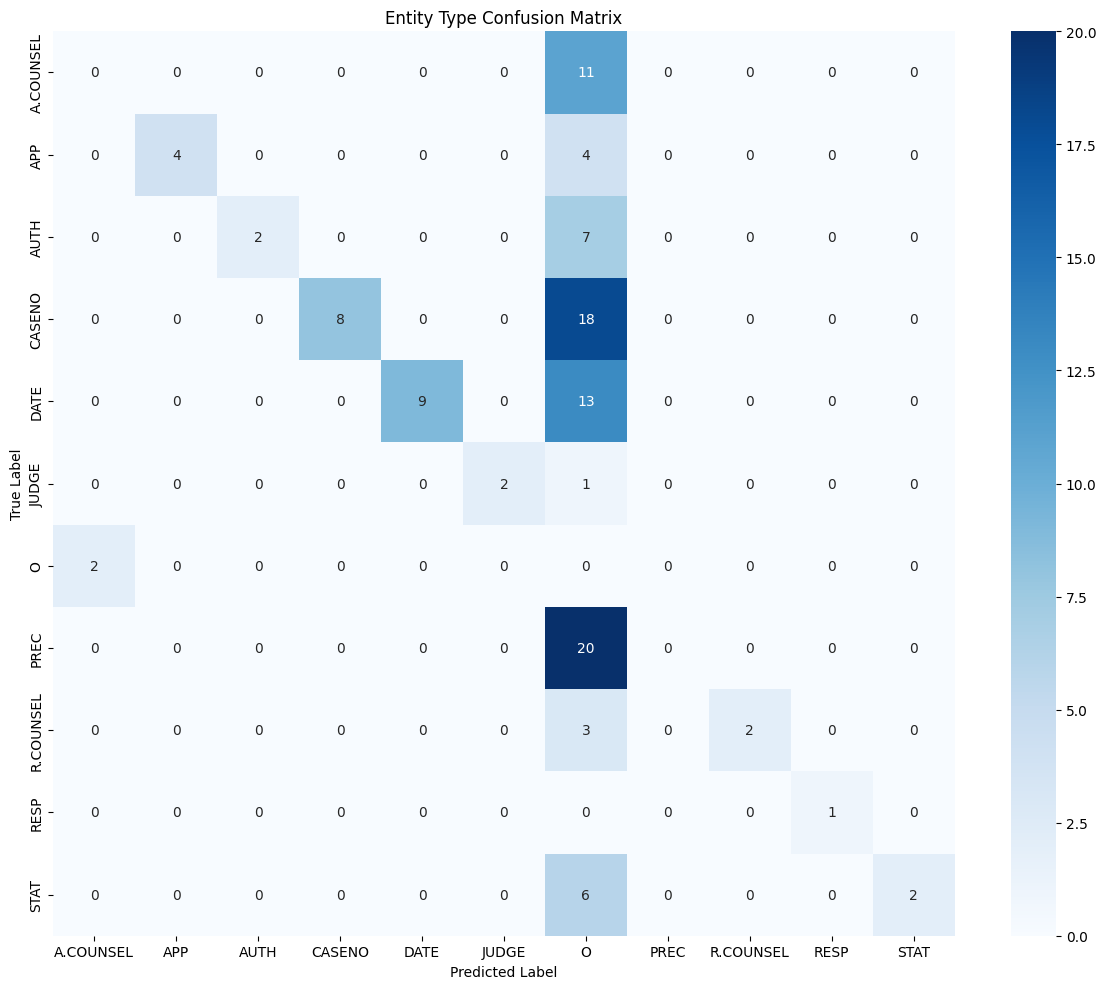


Entity recognition error analysis:


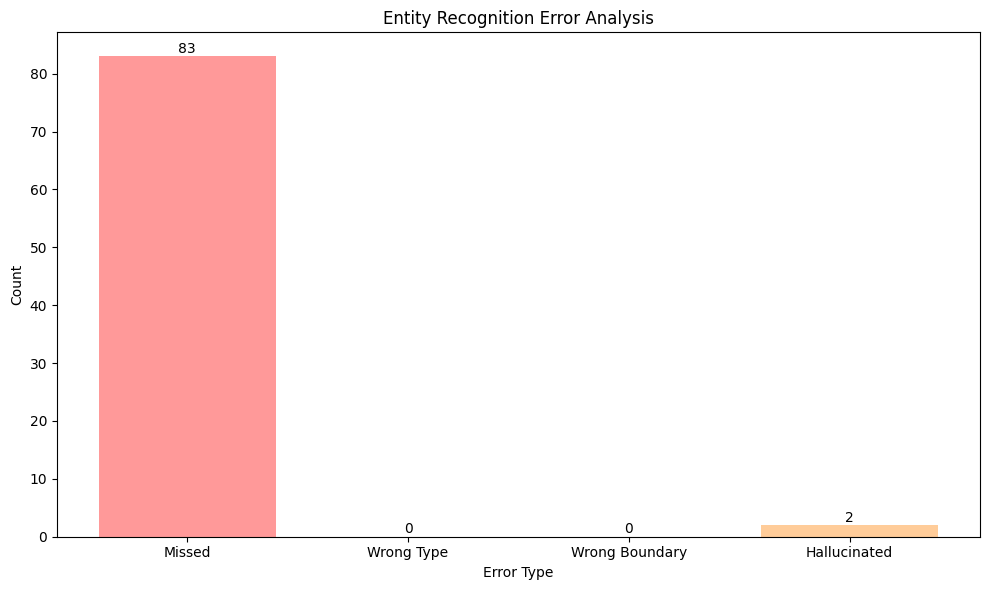

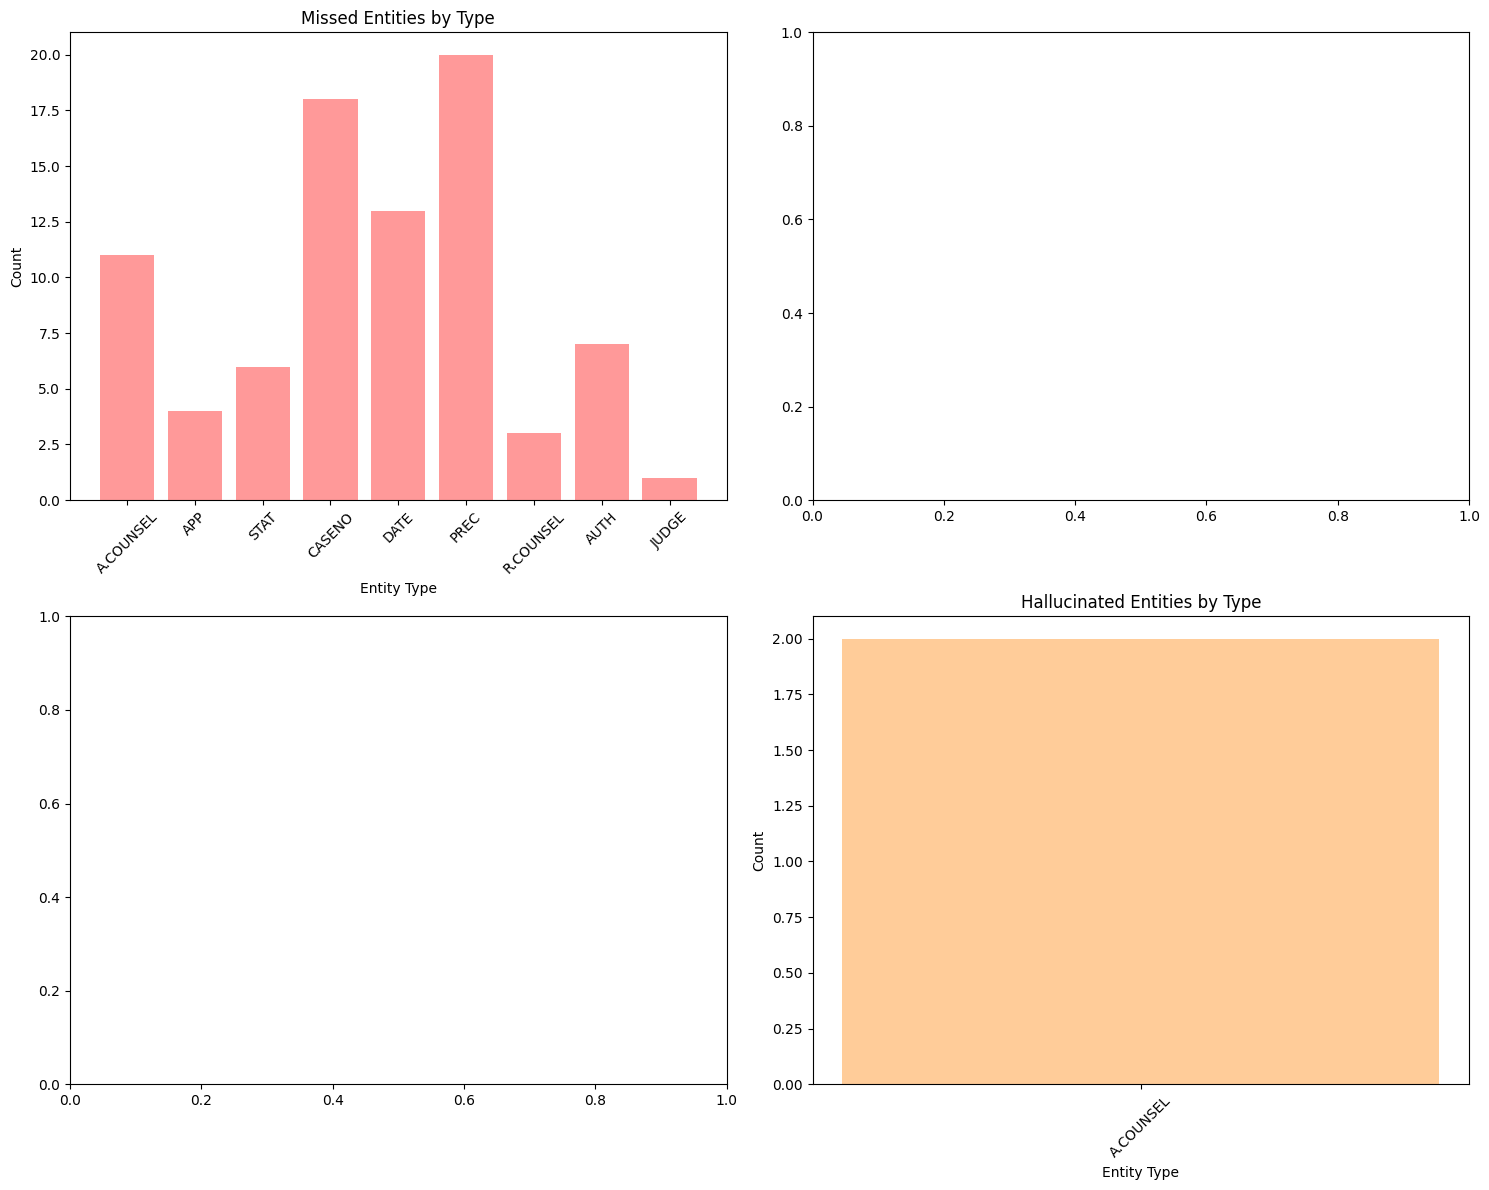

Cross-validation complete!


In [124]:
if __name__ == "__main__":
    best_model, cv_results = run_cross_validation()
    
    # Test on sample documents from fold 2   
    print("\nTesting on sample document from fold2:")
    predicted_entities2, true_entities2 = test_on_sample(best_model, sample_idx=0, fold_name="fold2")
    
    print("Cross-validation complete!")

## **Model : law-ai/InCaseLawBERT**

**Using a learning rate of `3e-5` was selected for the non-CRF configuration, following the BERT-recommended range of `1e-5` to `5e-5`.**

In [127]:
# Update the model name in non_crf_config
non_crf_config["model_name"] = "law-ai/InCaseLawBERT"

print("Non-CRF Config Model Name:", non_crf_config["model_name"])

Non-CRF Config Model Name: law-ai/InCaseLawBERT


In [128]:
# tokenizer = load_tokenizer(crf_config)
tokenizer = load_tokenizer(non_crf_config) #for non-crf

tokenizer_config.json:   0%|          | 0.00/343 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Tokenizer loaded for model: law-ai/InCaseLawBERT


In [129]:
for key, value in config.items():
    print(f"{key}: {value}")

max_length: 512
stride: 128
batch_size: 8
weight_decay: 0.01
epochs: 15
warmup_ratio: 0.1
early_stop_patience: 3
visualize_training: True
visualize_entities: True
visualize_confusion: True
problematic_entities: {'R.COUNSEL': 4.0, 'A.COUNSEL': 3.5, 'JUDGE': 3.0, 'WIT': 3.2, 'RESP': 2.3, 'APP': 1.8, 'CASENO': 1.4, 'AUTH': 1.4}
data_files: {'fold1': '/kaggle/input/legalcasedocuments/fold1.json', 'fold2': '/kaggle/input/legalcasedocuments/fold2.json', 'fold3': '/kaggle/input/legalcasedocuments/fold3.json'}
model_name: law-ai/InCaseLawBERT
use_crf: False
metrics_per_label: True
gradient_accumulation: 1
learning_rate: 3e-05
fp16: True



Training on fold2, fold3 and validating on fold1

Created 1335 training samples and 643 validation samples


config.json:   0%|          | 0.00/861 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/534M [00:00<?, ?B/s]

/tmp/ipykernel_31/446815027.py:52: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler       = torch.cuda.amp.GradScaler() if config["fp16"] and torch.cuda.is_available() else None


Epoch 1/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

/tmp/ipykernel_31/446815027.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


model.safetensors:   0%|          | 0.00/534M [00:00<?, ?B/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 1/15:
  Train Loss: 1.1171
  Val   Loss: 0.1938
  Val   F1:   0.0000 (P: 0.0000, R: 0.0000)
  Per-type metrics (top 5 by support):
    DATE: F1=0.0000, P=0.0000, R=0.0000, N=813
    PREC: F1=0.0000, P=0.0000, R=0.0000, N=624
    AUTH: F1=0.0000, P=0.0000, R=0.0000, N=534
    STAT: F1=0.0000, P=0.0000, R=0.0000, N=519
    COURT: F1=0.0000, P=0.0000, R=0.0000, N=455
  ↘ No improvement (1/3)


Epoch 2/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 2/15:
  Train Loss: 0.1659
  Val   Loss: 0.1146
  Val   F1:   0.5394 (P: 0.5005, R: 0.5847)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9393, P=0.9178, R=0.9619, N=813
    PREC: F1=0.3384, P=0.3200, R=0.3590, N=624
    AUTH: F1=0.4241, P=0.3671, R=0.5019, N=534
    STAT: F1=0.7718, P=0.6835, R=0.8863, N=519
    COURT: F1=0.6843, P=0.6605, R=0.7099, N=455
  ↗ New best F1: 0.5394 (was 0.0000)


Epoch 3/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 3/15:
  Train Loss: 0.0896
  Val   Loss: 0.0999
  Val   F1:   0.5602 (P: 0.5012, R: 0.6348)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9504, P=0.9356, R=0.9656, N=813
    PREC: F1=0.3173, P=0.3126, R=0.3221, N=624
    AUTH: F1=0.5087, P=0.4399, R=0.6030, N=534
    STAT: F1=0.7865, P=0.7306, R=0.8516, N=519
    COURT: F1=0.7368, P=0.7071, R=0.7692, N=455
  ↗ New best F1: 0.5602 (was 0.5394)


Epoch 4/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 4/15:
  Train Loss: 0.0650
  Val   Loss: 0.1077
  Val   F1:   0.5692 (P: 0.5075, R: 0.6479)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9498, P=0.9345, R=0.9656, N=813
    PREC: F1=0.2637, P=0.2614, R=0.2660, N=624
    AUTH: F1=0.4988, P=0.4416, R=0.5730, N=534
    STAT: F1=0.8091, P=0.7416, R=0.8902, N=519
    COURT: F1=0.7099, P=0.6872, R=0.7341, N=455
  ↗ New best F1: 0.5692 (was 0.5602)


Epoch 5/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 5/15:
  Train Loss: 0.0513
  Val   Loss: 0.1035
  Val   F1:   0.5856 (P: 0.5379, R: 0.6426)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9451, P=0.9267, R=0.9643, N=813
    PREC: F1=0.4088, P=0.4174, R=0.4006, N=624
    AUTH: F1=0.5118, P=0.4531, R=0.5880, N=534
    STAT: F1=0.7528, P=0.7221, R=0.7861, N=519
    COURT: F1=0.7113, P=0.7105, R=0.7121, N=455
  ↗ New best F1: 0.5856 (was 0.5692)


Epoch 6/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 6/15:
  Train Loss: 0.0389
  Val   Loss: 0.1119
  Val   F1:   0.6114 (P: 0.5827, R: 0.6431)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9534, P=0.9391, R=0.9680, N=813
    PREC: F1=0.4664, P=0.4602, R=0.4728, N=624
    AUTH: F1=0.4173, P=0.4398, R=0.3970, N=534
    STAT: F1=0.7878, P=0.7386, R=0.8439, N=519
    COURT: F1=0.7290, P=0.7137, R=0.7451, N=455
  ↗ New best F1: 0.6114 (was 0.5856)


Epoch 7/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 7/15:
  Train Loss: 0.0299
  Val   Loss: 0.1195
  Val   F1:   0.5931 (P: 0.5733, R: 0.6144)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9472, P=0.9342, R=0.9606, N=813
    PREC: F1=0.3934, P=0.4079, R=0.3798, N=624
    AUTH: F1=0.4345, P=0.4345, R=0.4345, N=534
    STAT: F1=0.7140, P=0.7113, R=0.7168, N=519
    COURT: F1=0.7258, P=0.7425, R=0.7099, N=455
  ↘ No improvement (1/3)


Epoch 8/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 8/15:
  Train Loss: 0.0228
  Val   Loss: 0.1256
  Val   F1:   0.6045 (P: 0.5611, R: 0.6552)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9493, P=0.9324, R=0.9668, N=813
    PREC: F1=0.4296, P=0.4093, R=0.4519, N=624
    AUTH: F1=0.4521, P=0.4293, R=0.4775, N=534
    STAT: F1=0.7552, P=0.7155, R=0.7996, N=519
    COURT: F1=0.6905, P=0.6802, R=0.7011, N=455
  ↘ No improvement (2/3)


Epoch 9/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 9/15:
  Train Loss: 0.0179
  Val   Loss: 0.1288
  Val   F1:   0.6029 (P: 0.5798, R: 0.6280)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9470, P=0.9373, R=0.9569, N=813
    PREC: F1=0.3858, P=0.3793, R=0.3926, N=624
    AUTH: F1=0.4507, P=0.4395, R=0.4625, N=534
    STAT: F1=0.7582, P=0.7408, R=0.7765, N=519
    COURT: F1=0.7111, P=0.7191, R=0.7033, N=455
  ↘ No improvement (3/3)
Early stopping at epoch 9


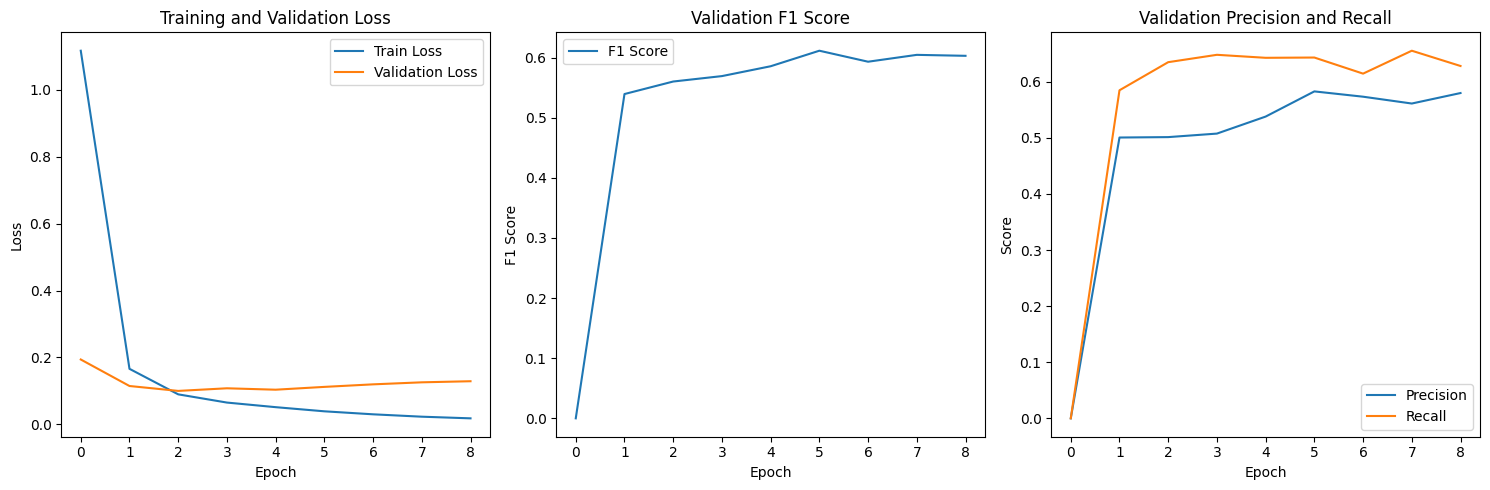


Final evaluation on validation set:


Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
  F1:        0.6114
  Precision: 0.5827
  Recall:    0.6431

Training on fold1, fold3 and validating on fold2

Created 1330 training samples and 648 validation samples


Epoch 1/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 1/15:
  Train Loss: 1.0660
  Val   Loss: 0.1889
  Val   F1:   0.1533 (P: 0.8205, R: 0.0846)
  Per-type metrics (top 5 by support):
    DATE: F1=0.2788, P=0.8873, R=0.1654, N=762
    STAT: F1=0.0000, P=0.0000, R=0.0000, N=731
    PREC: F1=0.0000, P=0.0000, R=0.0000, N=559
    COURT: F1=0.5510, P=0.7966, R=0.4211, N=558
    AUTH: F1=0.0000, P=0.0000, R=0.0000, N=468
  ↗ New best F1: 0.1533 (was 0.0000)


Epoch 2/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 2/15:
  Train Loss: 0.1557
  Val   Loss: 0.1098
  Val   F1:   0.5943 (P: 0.5821, R: 0.6069)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9426, P=0.9365, R=0.9488, N=762
    STAT: F1=0.7153, P=0.7072, R=0.7237, N=731
    PREC: F1=0.4429, P=0.3980, R=0.4991, N=559
    COURT: F1=0.7660, P=0.7293, R=0.8065, N=558
    AUTH: F1=0.4800, P=0.4730, R=0.4872, N=468
  ↗ New best F1: 0.5943 (was 0.1533)


Epoch 3/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 3/15:
  Train Loss: 0.0880
  Val   Loss: 0.1045
  Val   F1:   0.5791 (P: 0.5354, R: 0.6306)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9450, P=0.9437, R=0.9462, N=762
    STAT: F1=0.7335, P=0.7525, R=0.7155, N=731
    PREC: F1=0.3736, P=0.3500, R=0.4007, N=559
    COURT: F1=0.8265, P=0.8048, R=0.8495, N=558
    AUTH: F1=0.4813, P=0.4568, R=0.5085, N=468
  ↘ No improvement (1/3)


Epoch 4/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 4/15:
  Train Loss: 0.0637
  Val   Loss: 0.1107
  Val   F1:   0.6107 (P: 0.6033, R: 0.6182)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9507, P=0.9526, R=0.9488, N=762
    STAT: F1=0.6968, P=0.7605, R=0.6430, N=731
    PREC: F1=0.4867, P=0.4428, R=0.5403, N=559
    COURT: F1=0.7976, P=0.7772, R=0.8190, N=558
    AUTH: F1=0.3953, P=0.5050, R=0.3248, N=468
  ↗ New best F1: 0.6107 (was 0.5943)


Epoch 5/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 5/15:
  Train Loss: 0.0477
  Val   Loss: 0.1156
  Val   F1:   0.6236 (P: 0.6148, R: 0.6327)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9481, P=0.9499, R=0.9462, N=762
    STAT: F1=0.7413, P=0.7738, R=0.7114, N=731
    PREC: F1=0.4612, P=0.4286, R=0.4991, N=559
    COURT: F1=0.8147, P=0.8177, R=0.8118, N=558
    AUTH: F1=0.4898, P=0.5556, R=0.4380, N=468
  ↗ New best F1: 0.6236 (was 0.6107)


Epoch 6/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 6/15:
  Train Loss: 0.0355
  Val   Loss: 0.1201
  Val   F1:   0.6342 (P: 0.6197, R: 0.6493)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9514, P=0.9526, R=0.9501, N=762
    STAT: F1=0.7517, P=0.7623, R=0.7415, N=731
    PREC: F1=0.4763, P=0.4270, R=0.5385, N=559
    COURT: F1=0.8132, P=0.8111, R=0.8154, N=558
    AUTH: F1=0.4575, P=0.5512, R=0.3910, N=468
  ↗ New best F1: 0.6342 (was 0.6236)


Epoch 7/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 7/15:
  Train Loss: 0.0263
  Val   Loss: 0.1205
  Val   F1:   0.6387 (P: 0.6102, R: 0.6699)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9480, P=0.9511, R=0.9449, N=762
    STAT: F1=0.7926, P=0.7905, R=0.7948, N=731
    PREC: F1=0.4034, P=0.3833, R=0.4258, N=559
    COURT: F1=0.8221, P=0.8045, R=0.8405, N=558
    AUTH: F1=0.4995, P=0.5124, R=0.4872, N=468
  ↗ New best F1: 0.6387 (was 0.6342)


Epoch 8/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 8/15:
  Train Loss: 0.0216
  Val   Loss: 0.1316
  Val   F1:   0.6482 (P: 0.6205, R: 0.6786)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9513, P=0.9538, R=0.9488, N=762
    STAT: F1=0.7857, P=0.7890, R=0.7825, N=731
    PREC: F1=0.4925, P=0.4396, R=0.5599, N=559
    COURT: F1=0.8181, P=0.8102, R=0.8262, N=558
    AUTH: F1=0.4977, P=0.5288, R=0.4701, N=468
  ↗ New best F1: 0.6482 (was 0.6387)


Epoch 9/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 9/15:
  Train Loss: 0.0163
  Val   Loss: 0.1390
  Val   F1:   0.6526 (P: 0.6226, R: 0.6856)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9519, P=0.9563, R=0.9475, N=762
    STAT: F1=0.7984, P=0.7898, R=0.8071, N=731
    PREC: F1=0.5073, P=0.4650, R=0.5581, N=559
    COURT: F1=0.8129, P=0.7935, R=0.8333, N=558
    AUTH: F1=0.5081, P=0.5142, R=0.5021, N=468
  ↗ New best F1: 0.6526 (was 0.6482)


Epoch 10/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 10/15:
  Train Loss: 0.0125
  Val   Loss: 0.1465
  Val   F1:   0.6536 (P: 0.6406, R: 0.6671)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9494, P=0.9501, R=0.9488, N=762
    STAT: F1=0.7793, P=0.7960, R=0.7633, N=731
    PREC: F1=0.4984, P=0.4586, R=0.5456, N=559
    COURT: F1=0.8124, P=0.8024, R=0.8226, N=558
    AUTH: F1=0.4629, P=0.5382, R=0.4060, N=468
  ↗ New best F1: 0.6536 (was 0.6526)


Epoch 11/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 11/15:
  Train Loss: 0.0102
  Val   Loss: 0.1510
  Val   F1:   0.6484 (P: 0.6400, R: 0.6571)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9513, P=0.9538, R=0.9488, N=762
    STAT: F1=0.7562, P=0.7822, R=0.7319, N=731
    PREC: F1=0.4939, P=0.4536, R=0.5420, N=559
    COURT: F1=0.8100, P=0.8064, R=0.8136, N=558
    AUTH: F1=0.4367, P=0.5207, R=0.3761, N=468
  ↘ No improvement (1/3)


Epoch 12/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 12/15:
  Train Loss: 0.0084
  Val   Loss: 0.1613
  Val   F1:   0.6523 (P: 0.6364, R: 0.6690)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9521, P=0.9527, R=0.9514, N=762
    STAT: F1=0.7781, P=0.7890, R=0.7674, N=731
    PREC: F1=0.5077, P=0.4619, R=0.5635, N=559
    COURT: F1=0.8078, P=0.7986, R=0.8172, N=558
    AUTH: F1=0.4511, P=0.5180, R=0.3996, N=468
  ↘ No improvement (2/3)


Epoch 13/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 13/15:
  Train Loss: 0.0072
  Val   Loss: 0.1633
  Val   F1:   0.6522 (P: 0.6348, R: 0.6706)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9514, P=0.9514, R=0.9514, N=762
    STAT: F1=0.7815, P=0.7902, R=0.7729, N=731
    PREC: F1=0.4988, P=0.4520, R=0.5564, N=559
    COURT: F1=0.8138, P=0.8017, R=0.8262, N=558
    AUTH: F1=0.4582, P=0.5189, R=0.4103, N=468
  ↘ No improvement (3/3)
Early stopping at epoch 13


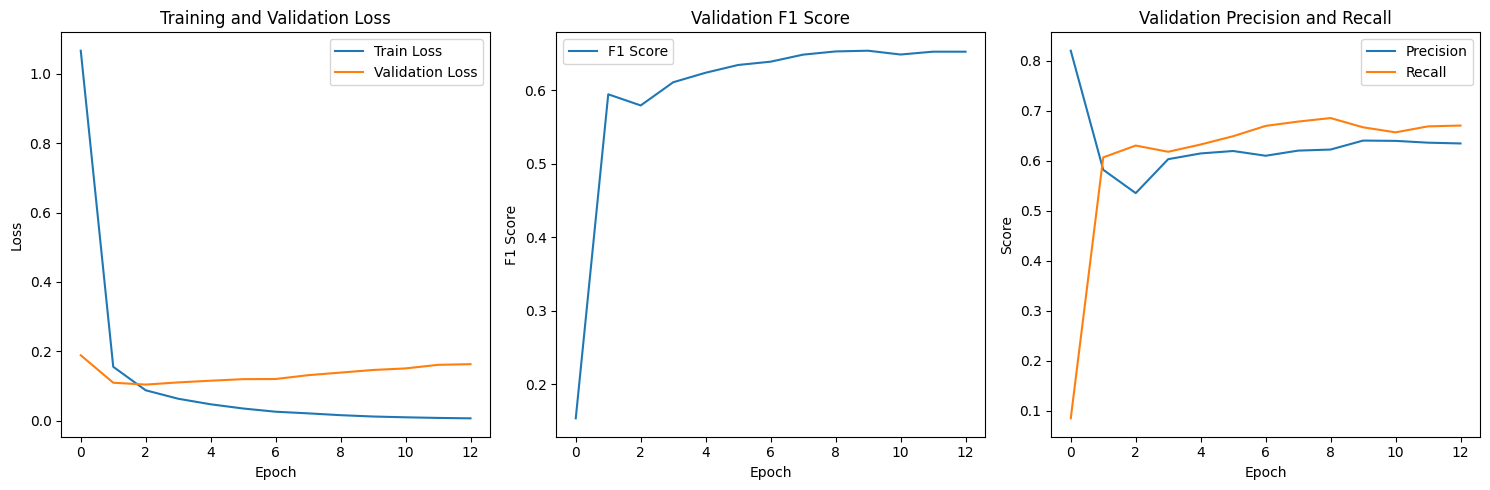


Final evaluation on validation set:


Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
  F1:        0.6536
  Precision: 0.6406
  Recall:    0.6671

Training on fold1, fold2 and validating on fold3

Created 1291 training samples and 687 validation samples


Epoch 1/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
Epoch 1/15:
  Train Loss: 1.1447
  Val   Loss: 0.1724
  Val   F1:   0.1183 (P: 0.8000, R: 0.0639)
  Per-type metrics (top 5 by support):
    STAT: F1=0.0000, P=0.0000, R=0.0000, N=795
    DATE: F1=0.5038, P=0.8297, R=0.3617, N=741
    PREC: F1=0.0000, P=0.0000, R=0.0000, N=621
    COURT: F1=0.0000, P=0.0000, R=0.0000, N=559
    CASENO: F1=0.0000, P=0.0000, R=0.0000, N=342
  ↗ New best F1: 0.1183 (was 0.0000)


Epoch 2/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
Epoch 2/15:
  Train Loss: 0.1741
  Val   Loss: 0.0950
  Val   F1:   0.5864 (P: 0.5951, R: 0.5778)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7256, P=0.6783, R=0.7799, N=795
    DATE: F1=0.9501, P=0.9501, R=0.9501, N=741
    PREC: F1=0.3572, P=0.3569, R=0.3575, N=621
    COURT: F1=0.7798, P=0.7869, R=0.7728, N=559
    CASENO: F1=0.4598, P=0.6373, R=0.3596, N=342
  ↗ New best F1: 0.5864 (was 0.1183)


Epoch 3/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
Epoch 3/15:
  Train Loss: 0.0976
  Val   Loss: 0.0932
  Val   F1:   0.6003 (P: 0.5630, R: 0.6429)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7616, P=0.7237, R=0.8038, N=795
    DATE: F1=0.9430, P=0.9482, R=0.9379, N=741
    PREC: F1=0.2506, P=0.2411, R=0.2609, N=621
    COURT: F1=0.8007, P=0.7702, R=0.8336, N=559
    CASENO: F1=0.7018, P=0.7236, R=0.6813, N=342
  ↗ New best F1: 0.6003 (was 0.5864)


Epoch 4/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
Epoch 4/15:
  Train Loss: 0.0704
  Val   Loss: 0.0923
  Val   F1:   0.6413 (P: 0.5935, R: 0.6975)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7826, P=0.7194, R=0.8579, N=795
    DATE: F1=0.9589, P=0.9582, R=0.9595, N=741
    PREC: F1=0.4320, P=0.3995, R=0.4702, N=621
    COURT: F1=0.8127, P=0.7630, R=0.8694, N=559
    CASENO: F1=0.6885, P=0.7021, R=0.6754, N=342
  ↗ New best F1: 0.6413 (was 0.6003)


Epoch 5/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
Epoch 5/15:
  Train Loss: 0.0520
  Val   Loss: 0.0985
  Val   F1:   0.6365 (P: 0.5827, R: 0.7013)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7710, P=0.6920, R=0.8704, N=795
    DATE: F1=0.9511, P=0.9441, R=0.9582, N=741
    PREC: F1=0.3684, P=0.3547, R=0.3833, N=621
    COURT: F1=0.8053, P=0.7473, R=0.8730, N=559
    CASENO: F1=0.6851, P=0.6831, R=0.6871, N=342
  ↘ No improvement (1/3)


Epoch 6/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
Epoch 6/15:
  Train Loss: 0.0407
  Val   Loss: 0.1004
  Val   F1:   0.6462 (P: 0.6082, R: 0.6892)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7835, P=0.7359, R=0.8377, N=795
    DATE: F1=0.9527, P=0.9540, R=0.9514, N=741
    PREC: F1=0.3958, P=0.3739, R=0.4203, N=621
    COURT: F1=0.8125, P=0.7696, R=0.8605, N=559
    CASENO: F1=0.6656, P=0.7036, R=0.6316, N=342
  ↗ New best F1: 0.6462 (was 0.6413)


Epoch 7/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
Epoch 7/15:
  Train Loss: 0.0297
  Val   Loss: 0.1052
  Val   F1:   0.6646 (P: 0.6254, R: 0.7089)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7758, P=0.7206, R=0.8403, N=795
    DATE: F1=0.9535, P=0.9528, R=0.9541, N=741
    PREC: F1=0.4634, P=0.4440, R=0.4847, N=621
    COURT: F1=0.8152, P=0.7716, R=0.8640, N=559
    CASENO: F1=0.6784, P=0.6784, R=0.6784, N=342
  ↗ New best F1: 0.6646 (was 0.6462)


Epoch 8/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
Epoch 8/15:
  Train Loss: 0.0222
  Val   Loss: 0.1172
  Val   F1:   0.6664 (P: 0.6343, R: 0.7020)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7805, P=0.7334, R=0.8340, N=795
    DATE: F1=0.9561, P=0.9580, R=0.9541, N=741
    PREC: F1=0.4879, P=0.4607, R=0.5185, N=621
    COURT: F1=0.8085, P=0.7681, R=0.8533, N=559
    CASENO: F1=0.6478, P=0.6616, R=0.6345, N=342
  ↗ New best F1: 0.6664 (was 0.6646)


Epoch 9/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
Epoch 9/15:
  Train Loss: 0.0172
  Val   Loss: 0.1236
  Val   F1:   0.6683 (P: 0.6287, R: 0.7132)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7639, P=0.7149, R=0.8201, N=795
    DATE: F1=0.9519, P=0.9552, R=0.9487, N=741
    PREC: F1=0.4989, P=0.4628, R=0.5411, N=621
    COURT: F1=0.8144, P=0.7803, R=0.8515, N=559
    CASENO: F1=0.6657, P=0.6647, R=0.6667, N=342
  ↗ New best F1: 0.6683 (was 0.6664)


Epoch 10/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
Epoch 10/15:
  Train Loss: 0.0134
  Val   Loss: 0.1303
  Val   F1:   0.6615 (P: 0.6072, R: 0.7266)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7726, P=0.7063, R=0.8528, N=795
    DATE: F1=0.9562, P=0.9555, R=0.9568, N=741
    PREC: F1=0.4947, P=0.4665, R=0.5266, N=621
    COURT: F1=0.8043, P=0.7417, R=0.8784, N=559
    CASENO: F1=0.6773, P=0.6705, R=0.6842, N=342
  ↘ No improvement (1/3)


Epoch 11/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
Epoch 11/15:
  Train Loss: 0.0112
  Val   Loss: 0.1306
  Val   F1:   0.6778 (P: 0.6477, R: 0.7108)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7789, P=0.7297, R=0.8352, N=795
    DATE: F1=0.9568, P=0.9568, R=0.9568, N=741
    PREC: F1=0.4984, P=0.4827, R=0.5153, N=621
    COURT: F1=0.8144, P=0.7976, R=0.8318, N=559
    CASENO: F1=0.6815, P=0.6907, R=0.6725, N=342
  ↗ New best F1: 0.6778 (was 0.6683)


Epoch 12/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
Epoch 12/15:
  Train Loss: 0.0095
  Val   Loss: 0.1351
  Val   F1:   0.6690 (P: 0.6278, R: 0.7159)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7685, P=0.7211, R=0.8226, N=795
    DATE: F1=0.9568, P=0.9568, R=0.9568, N=741
    PREC: F1=0.5189, P=0.4893, R=0.5523, N=621
    COURT: F1=0.8189, P=0.7871, R=0.8533, N=559
    CASENO: F1=0.6825, P=0.6928, R=0.6725, N=342
  ↘ No improvement (1/3)


Epoch 13/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
Epoch 13/15:
  Train Loss: 0.0080
  Val   Loss: 0.1416
  Val   F1:   0.6734 (P: 0.6302, R: 0.7230)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7761, P=0.7201, R=0.8415, N=795
    DATE: F1=0.9562, P=0.9543, R=0.9582, N=741
    PREC: F1=0.5019, P=0.4768, R=0.5298, N=621
    COURT: F1=0.8151, P=0.7816, R=0.8515, N=559
    CASENO: F1=0.6813, P=0.6813, R=0.6813, N=342
  ↘ No improvement (2/3)


Epoch 14/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
Epoch 14/15:
  Train Loss: 0.0070
  Val   Loss: 0.1419
  Val   F1:   0.6774 (P: 0.6393, R: 0.7204)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7776, P=0.7237, R=0.8403, N=795
    DATE: F1=0.9555, P=0.9542, R=0.9568, N=741
    PREC: F1=0.5156, P=0.4899, R=0.5443, N=621
    COURT: F1=0.8200, P=0.7907, R=0.8515, N=559
    CASENO: F1=0.6775, P=0.6825, R=0.6725, N=342
  ↘ No improvement (3/3)
Early stopping at epoch 14


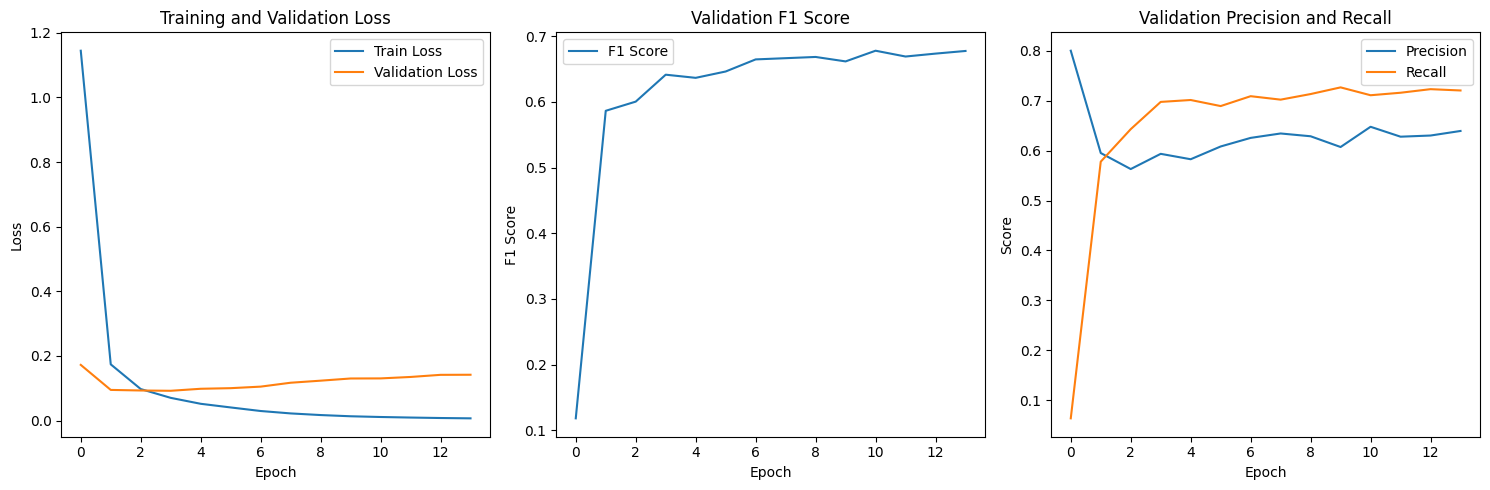


Final evaluation on validation set:


Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 686 documents
  F1:        0.6778
  Precision: 0.6477
  Recall:    0.7108

Cross-validation results:
  Fold 1: F1 = 0.6114
  Fold 2: F1 = 0.6536
  Fold 3: F1 = 0.6778
  Average: F1 = 0.6476, Precision = 0.6237, Recall = 0.6737


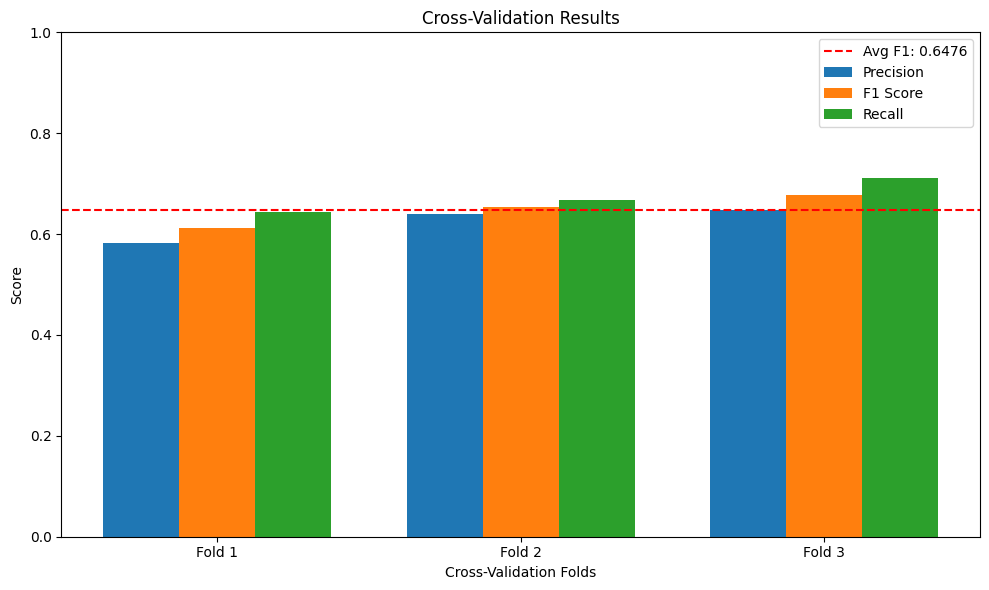


Analyzing entity distribution across the dataset:


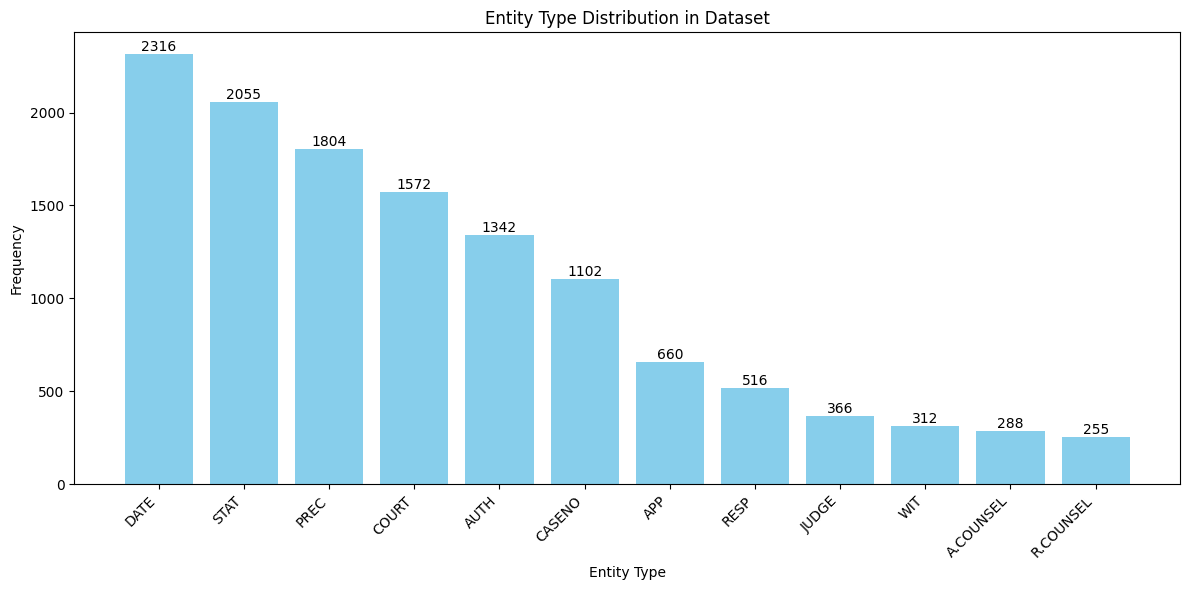

Best model saved to best_legal_ner_model_law_ai_InCaseLawBERT_CRF_false.pt
Model configuration saved to model_config_law_ai_InCaseLawBERT_CRF_false.json

Testing on sample document from fold3:

Testing entity extraction on a sample document:

Sample document excerpt:
REPORTABLE IN THE SUPREME COURT OF INDIA CIVIL APPELLATE JURISDICTION CIVIL APPEAL NO.6580 OF 2008 ARISING OUT OF SPECIAL LEAVE PETITION (CIVIL) NO. 15449 OF 2004 ESSCO FABS PVT. LTD. & ANR. ... APPELLANTS VERSUS STATE OF HARYANA & ANR. ... RESPONDENTS WITH CIVIL APPEAL NO.6581 OF 2008 ARISING OUT OF SPECIAL LEAVE PETITION (CIVIL) NO. 15544 OF 2004 THE PANIPAT TEACHERS (RECOGNISED SCHOOLS)HOUSING CO-OPEATIVE SOCIETY LTD. & ANR. ... APPELLANTS VERSUS STATE OF HARYANA & ORS. ... RESPONDENTS WITH C...


Predicted entities visualization:


Found 25 entities:
1. CASENO: 'CIVIL APPEAL NO.6580 OF 2008'
2. CASENO: 'SPECIAL LEAVE PETITION (CIVIL) NO. 15449 OF 2004'
3. APP: 'ESSCO FABS PVT. LTD.'
4. RESP: 'STATE OF HARYANA'
5. CASENO: 'CIVIL APPEAL NO.6581 OF 2008'
6. CASENO: 'SPECIAL LEAVE PETITION (CIVIL) NO. 15544 OF 2004'
7. RESP: 'STATE OF HARYANA'
8. CASENO: 'CONTEMPT PETITION NO. 30 OF 2007'
9. CASENO: 'CIVIL APPEAL NO.6580 OF 2008'
10. CASENO: 'SPECIAL LEAVE PETITION (CIVIL) NO. 15449 OF 2004'
11. APP: 'ESSCO FABS PVT. LTD.'
12. RESP: 'STATE OF HARYANA'
13. JUDGE: 'C.K. THAKKER'
14. DATE: 'April 02, 2004'
15. COURT: 'High Court of Punjab & Haryana'
16. CASENO: 'Civil Writ Petition Nos. 1853 of 2003 and 2077 of 2002'
17. APP: 'Essco Fabs Pvt. Ltd.'
18. APP: 'Essco'
19. AUTH: 'Government of Haryana'
20. AUTH: 'Haryana Urban Development Authority'
21. AUTH: 'HUDA'
22. STAT: 'Land Acquisition Act, 1894'
23. DATE: 'December 15, 1982'
24. DATE: 'June 20, 1984'
25. RESP: 'Es'

Gold standard entities:


Found 87 entities:
1. COURT: 'SUPREME COURT OF INDIA'
2. CASENO: 'SPECIAL LEAVE PETITION (CIVIL) NO. 15449 OF 2004'
3. RESP: 'STATE OF HARYANA'
4. CASENO: 'SPECIAL LEAVE PETITION (CIVIL) NO. 15544 OF 2004'
5. APP: 'PANIPAT TEACHERS (RECOGNISED SCHOOLS)HOUSING CO-OPEATIVE SOCIETY LTD.'
6. RESP: 'STATE OF HARYANA'
7. CASENO: 'SPECIAL LEAVE PETITION (CIVIL) NO. 15449 OF 2004'
8. RESP: 'STATE OF HARYANA'
9. JUDGE: 'C.K. THAKKER'
10. DATE: 'April 02, 2004'
11. COURT: 'High Court of Punjab & Haryana'
12. CASENO: 'Civil Writ Petition Nos.'
13. APP: 'Essco Fabs Pvt. Ltd.'
14. APP: 'Essco'
15. AUTH: 'Haryana Urban Development Authority'
16. AUTH: 'HUDA'
17. DATE: 'December 15, 1982'
18. DATE: 'June 20, 1984'
19. APP: 'Essco'
20. DATE: 'June 6, 1991'
21. AUTH: 'Director, Town & Country Planning, Haryana'
22. DATE: 'September 5, 1991'
23. DATE: 'August 1, 2001'
24. AUTH: 'HUDA'
25. DATE: 'August 2, 2001'
26. CASENO: 'Civil Writ Petition No. 1853 of 2003'
27. COURT: 'High Court of Punjab & Haryana

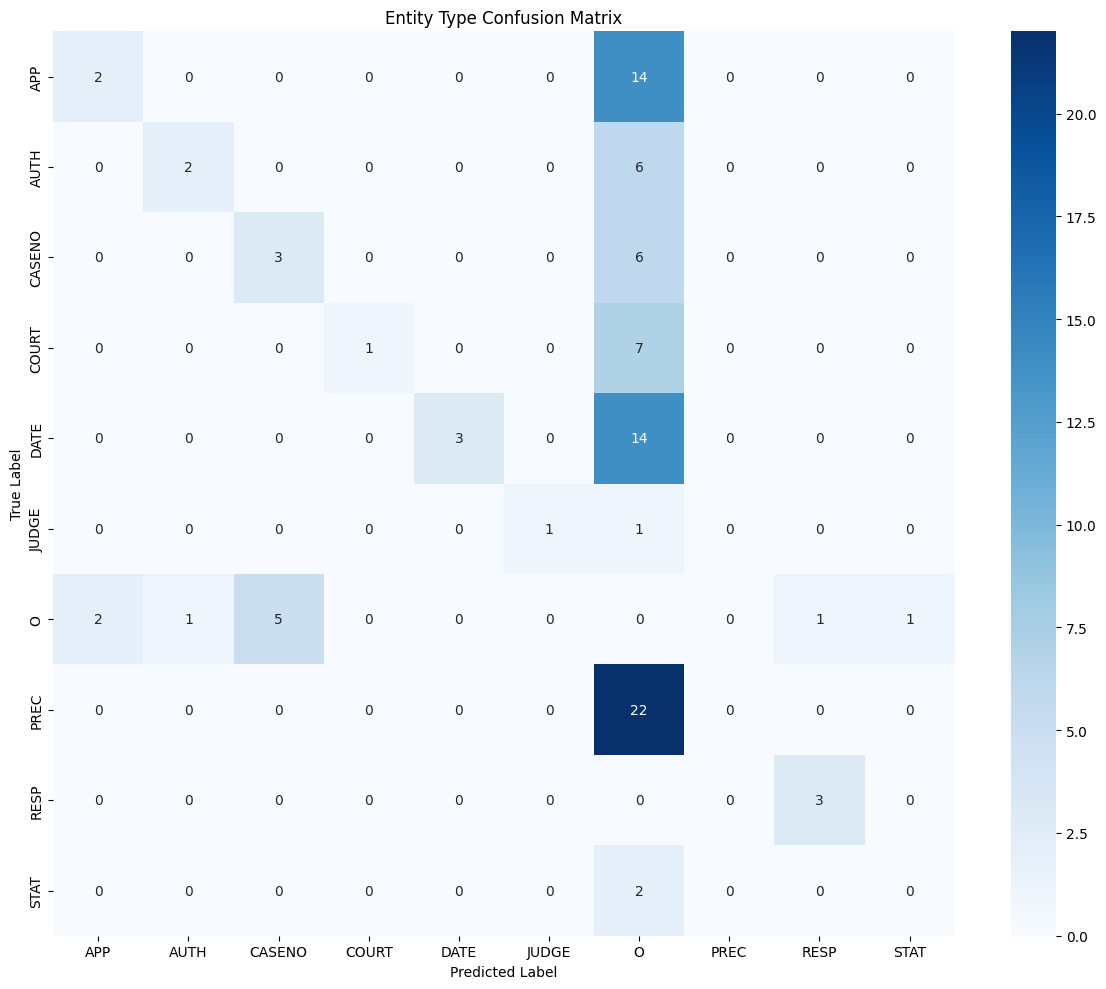


Entity recognition error analysis:


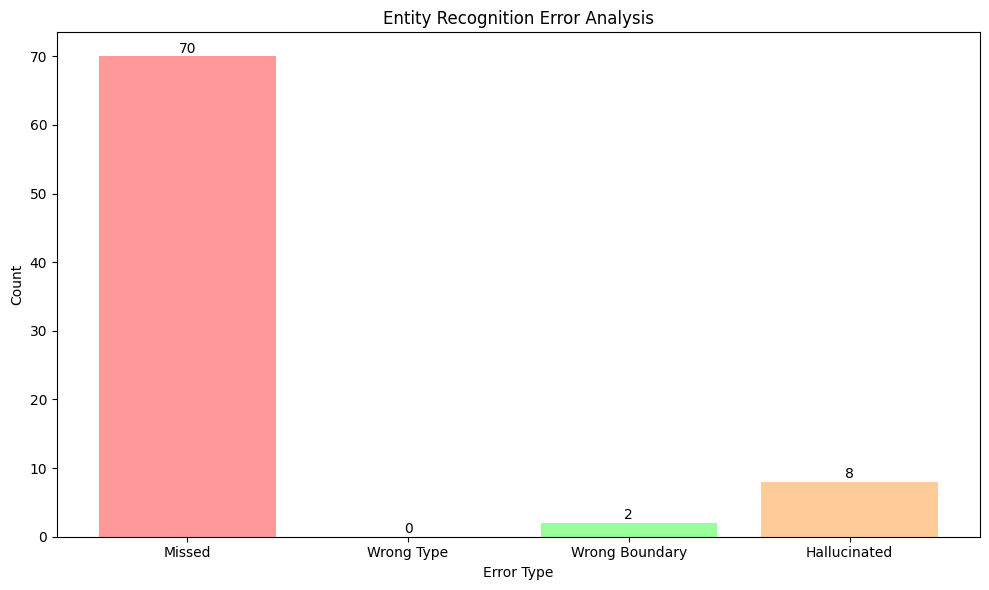

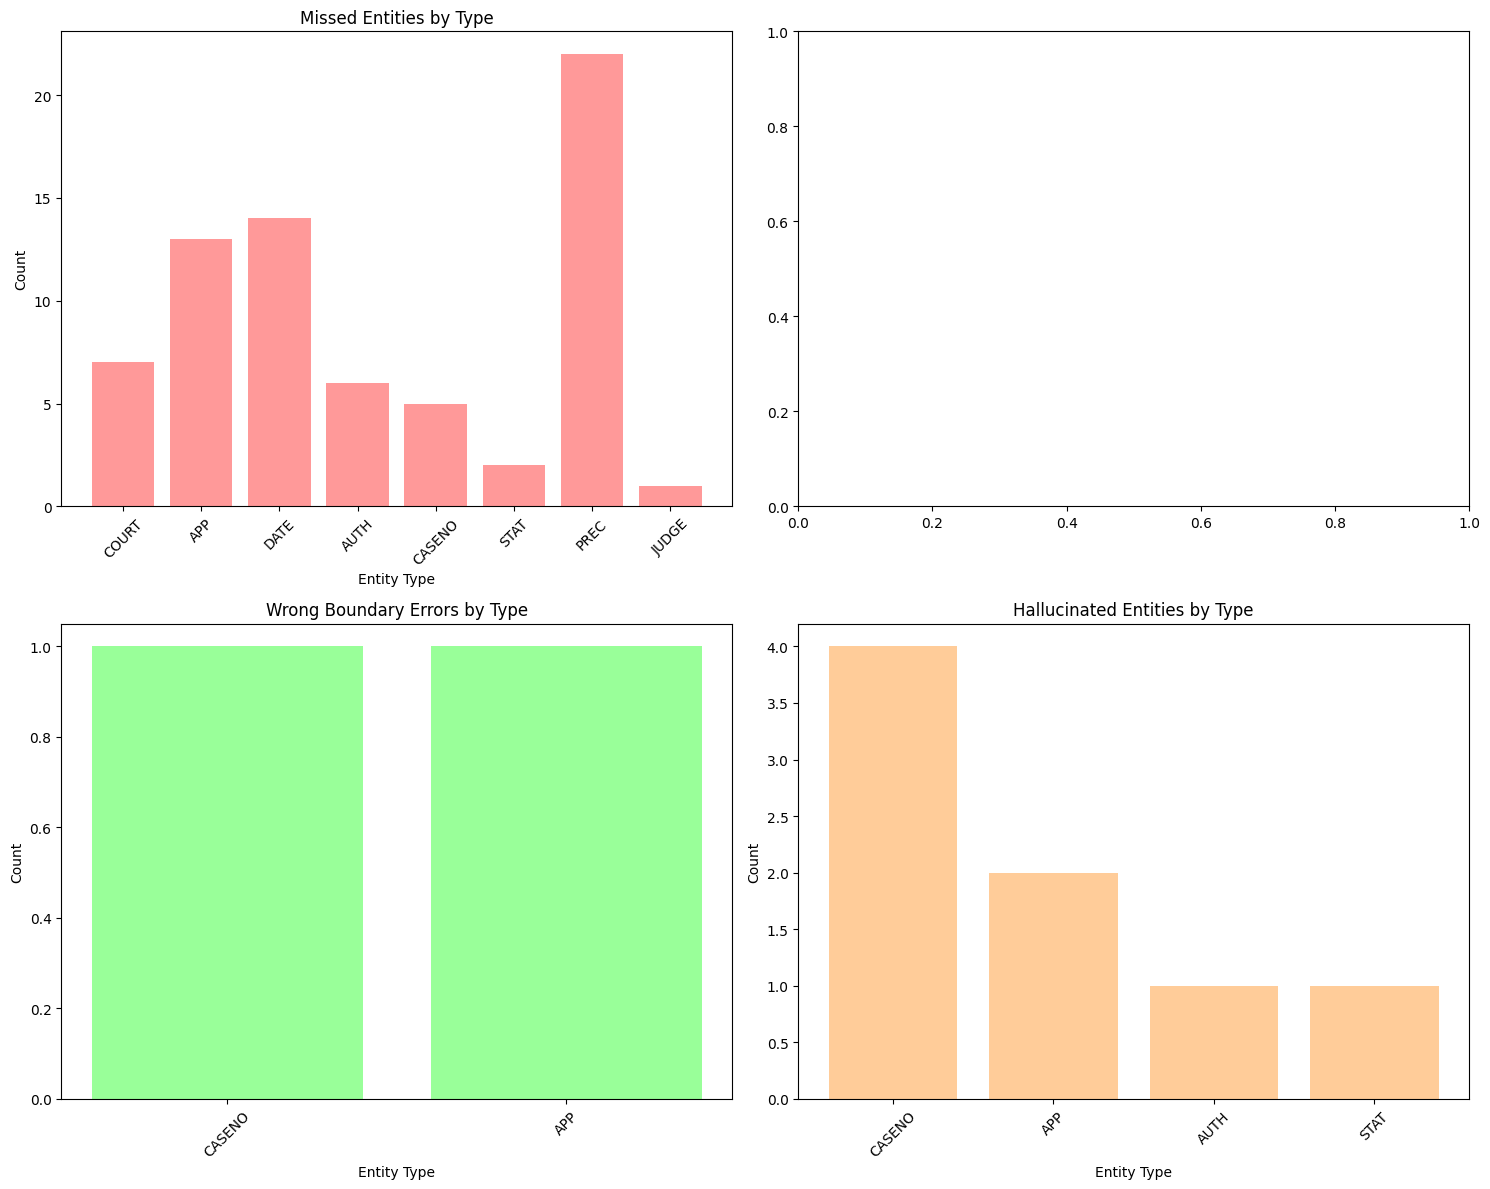

Cross-validation complete!


In [130]:
if __name__ == "__main__":
    best_model, cv_results = run_cross_validation()
    
    # Test on sample documents from fold 3
    print("\nTesting on sample document from fold3:")
    predicted_entities3, true_entities3 = test_on_sample(best_model, sample_idx=0, fold_name="fold3")
    
    print("Cross-validation complete!")

## **Model : law-ai/InLegalBERT**

**Using a learning rate of `3e-5` was selected for the non-CRF configuration, following the BERT-recommended range of `1e-5` to `5e-5`.**

In [133]:
# Update the model name in non_crf_config
non_crf_config["model_name"] = "law-ai/InLegalBERT"

print("Non-CRF Config Model Name:", non_crf_config["model_name"])

Non-CRF Config Model Name: law-ai/InLegalBERT


In [134]:
# tokenizer = load_tokenizer(crf_config)
tokenizer = load_tokenizer(non_crf_config) #for non-crf

tokenizer_config.json:   0%|          | 0.00/516 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Tokenizer loaded for model: law-ai/InLegalBERT


In [135]:
for key, value in config.items():
    print(f"{key}: {value}")

max_length: 512
stride: 128
batch_size: 8
weight_decay: 0.01
epochs: 15
warmup_ratio: 0.1
early_stop_patience: 3
visualize_training: True
visualize_entities: True
visualize_confusion: True
problematic_entities: {'R.COUNSEL': 4.0, 'A.COUNSEL': 3.5, 'JUDGE': 3.0, 'WIT': 3.2, 'RESP': 2.3, 'APP': 1.8, 'CASENO': 1.4, 'AUTH': 1.4}
data_files: {'fold1': '/kaggle/input/legalcasedocuments/fold1.json', 'fold2': '/kaggle/input/legalcasedocuments/fold2.json', 'fold3': '/kaggle/input/legalcasedocuments/fold3.json'}
model_name: law-ai/InLegalBERT
use_crf: False
metrics_per_label: True
gradient_accumulation: 1
learning_rate: 3e-05
fp16: True



Training on fold2, fold3 and validating on fold1

Created 1325 training samples and 639 validation samples


config.json:   0%|          | 0.00/671 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/534M [00:00<?, ?B/s]

/tmp/ipykernel_31/446815027.py:52: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler       = torch.cuda.amp.GradScaler() if config["fp16"] and torch.cuda.is_available() else None


Epoch 1/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

/tmp/ipykernel_31/446815027.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


model.safetensors:   0%|          | 0.00/534M [00:00<?, ?B/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 1/15:
  Train Loss: 1.2673
  Val   Loss: 0.1908
  Val   F1:   0.2690 (P: 0.9040, R: 0.1580)
  Per-type metrics (top 5 by support):
    DATE: F1=0.8491, P=0.9053, R=0.7995, N=813
    PREC: F1=0.0000, P=0.0000, R=0.0000, N=624
    AUTH: F1=0.0000, P=0.0000, R=0.0000, N=534
    STAT: F1=0.0000, P=0.0000, R=0.0000, N=519
    COURT: F1=0.0000, P=0.0000, R=0.0000, N=455
  ↗ New best F1: 0.2690 (was 0.0000)


Epoch 2/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 2/15:
  Train Loss: 0.1674
  Val   Loss: 0.1273
  Val   F1:   0.5171 (P: 0.4476, R: 0.6122)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9395, P=0.9159, R=0.9643, N=813
    PREC: F1=0.4333, P=0.4292, R=0.4375, N=624
    AUTH: F1=0.4150, P=0.3616, R=0.4869, N=534
    STAT: F1=0.7772, P=0.7134, R=0.8536, N=519
    COURT: F1=0.6134, P=0.5268, R=0.7341, N=455
  ↗ New best F1: 0.5171 (was 0.2690)


Epoch 3/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 3/15:
  Train Loss: 0.0976
  Val   Loss: 0.1053
  Val   F1:   0.5858 (P: 0.5519, R: 0.6241)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9516, P=0.9358, R=0.9680, N=813
    PREC: F1=0.4399, P=0.4659, R=0.4167, N=624
    AUTH: F1=0.4658, P=0.4433, R=0.4906, N=534
    STAT: F1=0.7711, P=0.7099, R=0.8439, N=519
    COURT: F1=0.6939, P=0.6633, R=0.7275, N=455
  ↗ New best F1: 0.5858 (was 0.5171)


Epoch 4/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 4/15:
  Train Loss: 0.0744
  Val   Loss: 0.1092
  Val   F1:   0.5655 (P: 0.5096, R: 0.6353)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9500, P=0.9304, R=0.9705, N=813
    PREC: F1=0.4979, P=0.5145, R=0.4824, N=624
    AUTH: F1=0.4505, P=0.4264, R=0.4775, N=534
    STAT: F1=0.7638, P=0.7327, R=0.7977, N=519
    COURT: F1=0.6992, P=0.6748, R=0.7253, N=455
  ↘ No improvement (1/3)


Epoch 5/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 5/15:
  Train Loss: 0.0567
  Val   Loss: 0.1110
  Val   F1:   0.5893 (P: 0.5340, R: 0.6574)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9498, P=0.9345, R=0.9656, N=813
    PREC: F1=0.4902, P=0.5017, R=0.4792, N=624
    AUTH: F1=0.4432, P=0.4337, R=0.4532, N=534
    STAT: F1=0.7828, P=0.7328, R=0.8401, N=519
    COURT: F1=0.6673, P=0.5892, R=0.7692, N=455
  ↗ New best F1: 0.5893 (was 0.5858)


Epoch 6/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 6/15:
  Train Loss: 0.0443
  Val   Loss: 0.1142
  Val   F1:   0.6018 (P: 0.5456, R: 0.6710)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9414, P=0.9162, R=0.9680, N=813
    PREC: F1=0.5109, P=0.5155, R=0.5064, N=624
    AUTH: F1=0.4262, P=0.4037, R=0.4513, N=534
    STAT: F1=0.7658, P=0.7119, R=0.8285, N=519
    COURT: F1=0.6726, P=0.6145, R=0.7429, N=455
  ↗ New best F1: 0.6018 (was 0.5893)


Epoch 7/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 7/15:
  Train Loss: 0.0342
  Val   Loss: 0.1301
  Val   F1:   0.5856 (P: 0.5426, R: 0.6360)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9468, P=0.9310, R=0.9631, N=813
    PREC: F1=0.4032, P=0.4497, R=0.3654, N=624
    AUTH: F1=0.3754, P=0.3743, R=0.3764, N=534
    STAT: F1=0.7572, P=0.7270, R=0.7900, N=519
    COURT: F1=0.6897, P=0.6250, R=0.7692, N=455
  ↘ No improvement (1/3)


Epoch 8/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 8/15:
  Train Loss: 0.0272
  Val   Loss: 0.1256
  Val   F1:   0.5930 (P: 0.5474, R: 0.6467)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9230, P=0.9034, R=0.9434, N=813
    PREC: F1=0.4696, P=0.4633, R=0.4760, N=624
    AUTH: F1=0.4397, P=0.4322, R=0.4476, N=534
    STAT: F1=0.7092, P=0.7019, R=0.7168, N=519
    COURT: F1=0.6922, P=0.6263, R=0.7736, N=455
  ↘ No improvement (2/3)


Epoch 9/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 9/15:
  Train Loss: 0.0198
  Val   Loss: 0.1396
  Val   F1:   0.6042 (P: 0.5685, R: 0.6448)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9447, P=0.9236, R=0.9668, N=813
    PREC: F1=0.4712, P=0.4712, R=0.4712, N=624
    AUTH: F1=0.4057, P=0.4425, R=0.3745, N=534
    STAT: F1=0.7347, P=0.7204, R=0.7495, N=519
    COURT: F1=0.6871, P=0.6407, R=0.7407, N=455
  ↗ New best F1: 0.6042 (was 0.6018)


Epoch 10/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 10/15:
  Train Loss: 0.0156
  Val   Loss: 0.1525
  Val   F1:   0.5962 (P: 0.5533, R: 0.6462)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9284, P=0.9092, R=0.9483, N=813
    PREC: F1=0.4457, P=0.4614, R=0.4311, N=624
    AUTH: F1=0.4096, P=0.4209, R=0.3989, N=534
    STAT: F1=0.7618, P=0.7339, R=0.7919, N=519
    COURT: F1=0.6835, P=0.6330, R=0.7429, N=455
  ↘ No improvement (1/3)


Epoch 11/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 11/15:
  Train Loss: 0.0128
  Val   Loss: 0.1460
  Val   F1:   0.6090 (P: 0.5823, R: 0.6382)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9487, P=0.9313, R=0.9668, N=813
    PREC: F1=0.4712, P=0.4847, R=0.4583, N=624
    AUTH: F1=0.3858, P=0.4213, R=0.3558, N=534
    STAT: F1=0.7021, P=0.7049, R=0.6994, N=519
    COURT: F1=0.6883, P=0.6396, R=0.7451, N=455
  ↗ New best F1: 0.6090 (was 0.6042)


Epoch 12/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 12/15:
  Train Loss: 0.0109
  Val   Loss: 0.1572
  Val   F1:   0.6163 (P: 0.5883, R: 0.6470)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9398, P=0.9199, R=0.9606, N=813
    PREC: F1=0.4667, P=0.4789, R=0.4551, N=624
    AUTH: F1=0.4045, P=0.4477, R=0.3689, N=534
    STAT: F1=0.7524, P=0.7384, R=0.7669, N=519
    COURT: F1=0.6847, P=0.6303, R=0.7495, N=455
  ↗ New best F1: 0.6163 (was 0.6090)


Epoch 13/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 13/15:
  Train Loss: 0.0094
  Val   Loss: 0.1596
  Val   F1:   0.6082 (P: 0.5679, R: 0.6545)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9464, P=0.9269, R=0.9668, N=813
    PREC: F1=0.4623, P=0.4630, R=0.4615, N=624
    AUTH: F1=0.3949, P=0.4109, R=0.3801, N=534
    STAT: F1=0.7354, P=0.7292, R=0.7418, N=519
    COURT: F1=0.6958, P=0.6352, R=0.7692, N=455
  ↘ No improvement (1/3)


Epoch 14/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 14/15:
  Train Loss: 0.0080
  Val   Loss: 0.1634
  Val   F1:   0.6142 (P: 0.5810, R: 0.6513)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9476, P=0.9291, R=0.9668, N=813
    PREC: F1=0.4762, P=0.4797, R=0.4728, N=624
    AUTH: F1=0.3936, P=0.4242, R=0.3670, N=534
    STAT: F1=0.7292, P=0.7243, R=0.7341, N=519
    COURT: F1=0.6955, P=0.6407, R=0.7604, N=455
  ↘ No improvement (2/3)


Epoch 15/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 15/15:
  Train Loss: 0.0078
  Val   Loss: 0.1663
  Val   F1:   0.6172 (P: 0.5821, R: 0.6569)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9452, P=0.9257, R=0.9656, N=813
    PREC: F1=0.4730, P=0.4750, R=0.4712, N=624
    AUTH: F1=0.4060, P=0.4356, R=0.3801, N=534
    STAT: F1=0.7540, P=0.7380, R=0.7707, N=519
    COURT: F1=0.6927, P=0.6360, R=0.7604, N=455
  ↗ New best F1: 0.6172 (was 0.6163)


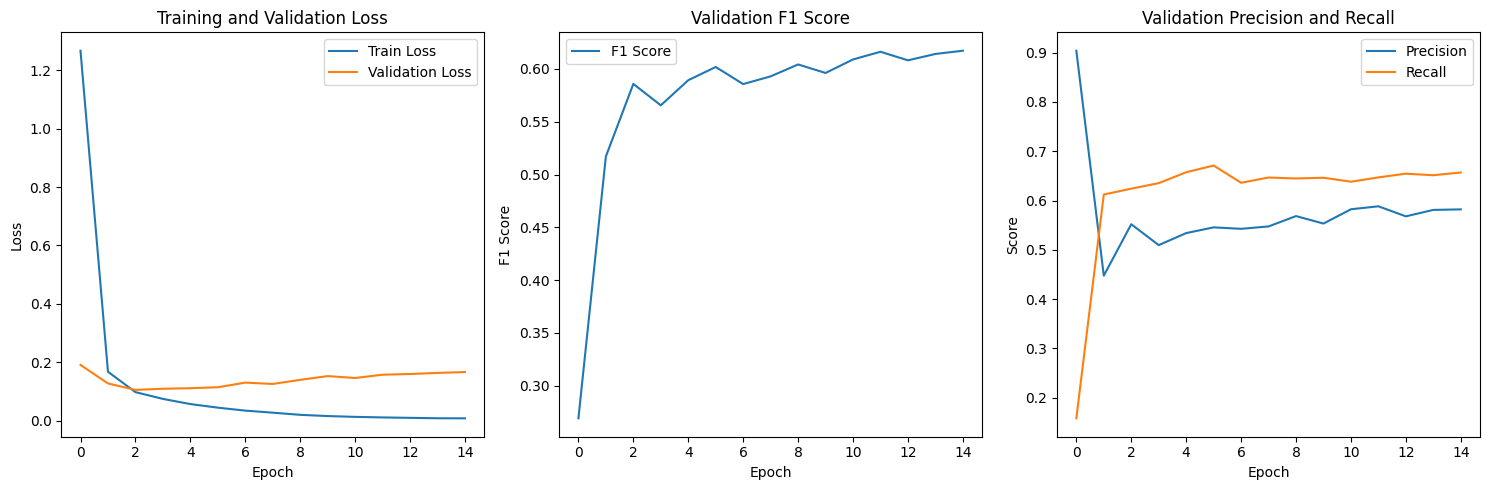


Final evaluation on validation set:


Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
  F1:        0.6172
  Precision: 0.5821
  Recall:    0.6569

Training on fold1, fold3 and validating on fold2

Created 1320 training samples and 644 validation samples


Epoch 1/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 1/15:
  Train Loss: 1.2088
  Val   Loss: 0.2136
  Val   F1:   0.0438 (P: 0.8421, R: 0.0225)
  Per-type metrics (top 5 by support):
    DATE: F1=0.0000, P=0.0000, R=0.0000, N=762
    STAT: F1=0.0000, P=0.0000, R=0.0000, N=731
    PREC: F1=0.0000, P=0.0000, R=0.0000, N=559
    COURT: F1=0.2857, P=0.8421, R=0.1720, N=558
    AUTH: F1=0.0000, P=0.0000, R=0.0000, N=468
  ↗ New best F1: 0.0438 (was 0.0000)


Epoch 2/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 2/15:
  Train Loss: 0.1657
  Val   Loss: 0.1183
  Val   F1:   0.5560 (P: 0.5289, R: 0.5861)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9164, P=0.8919, R=0.9423, N=762
    STAT: F1=0.6704, P=0.6195, R=0.7305, N=731
    PREC: F1=0.4701, P=0.4194, R=0.5349, N=559
    COURT: F1=0.7860, P=0.7666, R=0.8065, N=558
    AUTH: F1=0.3555, P=0.3989, R=0.3205, N=468
  ↗ New best F1: 0.5560 (was 0.0438)


Epoch 3/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 3/15:
  Train Loss: 0.0935
  Val   Loss: 0.1212
  Val   F1:   0.6096 (P: 0.5448, R: 0.6917)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9240, P=0.9076, R=0.9409, N=762
    STAT: F1=0.7588, P=0.6910, R=0.8413, N=731
    PREC: F1=0.4858, P=0.4554, R=0.5206, N=559
    COURT: F1=0.7970, P=0.7520, R=0.8477, N=558
    AUTH: F1=0.5500, P=0.5169, R=0.5876, N=468
  ↗ New best F1: 0.6096 (was 0.5560)


Epoch 4/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 4/15:
  Train Loss: 0.0681
  Val   Loss: 0.1268
  Val   F1:   0.6078 (P: 0.5581, R: 0.6671)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9409, P=0.9318, R=0.9501, N=762
    STAT: F1=0.7583, P=0.7119, R=0.8112, N=731
    PREC: F1=0.4878, P=0.4259, R=0.5707, N=559
    COURT: F1=0.7893, P=0.7617, R=0.8190, N=558
    AUTH: F1=0.4912, P=0.5939, R=0.4188, N=468
  ↘ No improvement (1/3)


Epoch 5/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 5/15:
  Train Loss: 0.0512
  Val   Loss: 0.1245
  Val   F1:   0.6516 (P: 0.6034, R: 0.7081)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9503, P=0.9478, R=0.9528, N=762
    STAT: F1=0.7980, P=0.7409, R=0.8646, N=731
    PREC: F1=0.5323, P=0.4711, R=0.6118, N=559
    COURT: F1=0.7708, P=0.7323, R=0.8136, N=558
    AUTH: F1=0.5336, P=0.5170, R=0.5513, N=468
  ↗ New best F1: 0.6516 (was 0.6096)


Epoch 6/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 6/15:
  Train Loss: 0.0381
  Val   Loss: 0.1329
  Val   F1:   0.6432 (P: 0.6278, R: 0.6594)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9525, P=0.9576, R=0.9475, N=762
    STAT: F1=0.7855, P=0.8000, R=0.7715, N=731
    PREC: F1=0.4959, P=0.4545, R=0.5456, N=559
    COURT: F1=0.7947, P=0.7816, R=0.8082, N=558
    AUTH: F1=0.4923, P=0.6154, R=0.4103, N=468
  ↘ No improvement (1/3)


Epoch 7/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 7/15:
  Train Loss: 0.0290
  Val   Loss: 0.1507
  Val   F1:   0.6546 (P: 0.6292, R: 0.6821)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9540, P=0.9553, R=0.9528, N=762
    STAT: F1=0.7927, P=0.7617, R=0.8263, N=731
    PREC: F1=0.5116, P=0.4386, R=0.6136, N=559
    COURT: F1=0.7958, P=0.7853, R=0.8065, N=558
    AUTH: F1=0.4637, P=0.5888, R=0.3825, N=468
  ↗ New best F1: 0.6546 (was 0.6516)


Epoch 8/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 8/15:
  Train Loss: 0.0234
  Val   Loss: 0.1548
  Val   F1:   0.6665 (P: 0.6437, R: 0.6910)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9518, P=0.9587, R=0.9449, N=762
    STAT: F1=0.8153, P=0.7770, R=0.8577, N=731
    PREC: F1=0.5174, P=0.4638, R=0.5850, N=559
    COURT: F1=0.8093, P=0.7804, R=0.8405, N=558
    AUTH: F1=0.4851, P=0.5804, R=0.4167, N=468
  ↗ New best F1: 0.6665 (was 0.6546)


Epoch 9/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 9/15:
  Train Loss: 0.0191
  Val   Loss: 0.1620
  Val   F1:   0.6662 (P: 0.6251, R: 0.7130)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9503, P=0.9478, R=0.9528, N=762
    STAT: F1=0.8305, P=0.7877, R=0.8782, N=731
    PREC: F1=0.5325, P=0.4693, R=0.6154, N=559
    COURT: F1=0.8073, P=0.7796, R=0.8369, N=558
    AUTH: F1=0.5262, P=0.5634, R=0.4936, N=468
  ↘ No improvement (1/3)


Epoch 10/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 10/15:
  Train Loss: 0.0148
  Val   Loss: 0.1693
  Val   F1:   0.6588 (P: 0.6305, R: 0.6899)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9521, P=0.9527, R=0.9514, N=762
    STAT: F1=0.7939, P=0.7723, R=0.8167, N=731
    PREC: F1=0.5332, P=0.4780, R=0.6029, N=559
    COURT: F1=0.8021, P=0.7979, R=0.8065, N=558
    AUTH: F1=0.4933, P=0.5718, R=0.4338, N=468
  ↘ No improvement (2/3)


Epoch 11/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 11/15:
  Train Loss: 0.0124
  Val   Loss: 0.1718
  Val   F1:   0.6570 (P: 0.6326, R: 0.6833)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9546, P=0.9577, R=0.9514, N=762
    STAT: F1=0.8053, P=0.7781, R=0.8345, N=731
    PREC: F1=0.5331, P=0.4682, R=0.6190, N=559
    COURT: F1=0.7806, P=0.7678, R=0.7939, N=558
    AUTH: F1=0.4561, P=0.5647, R=0.3825, N=468
  ↘ No improvement (3/3)
Early stopping at epoch 11


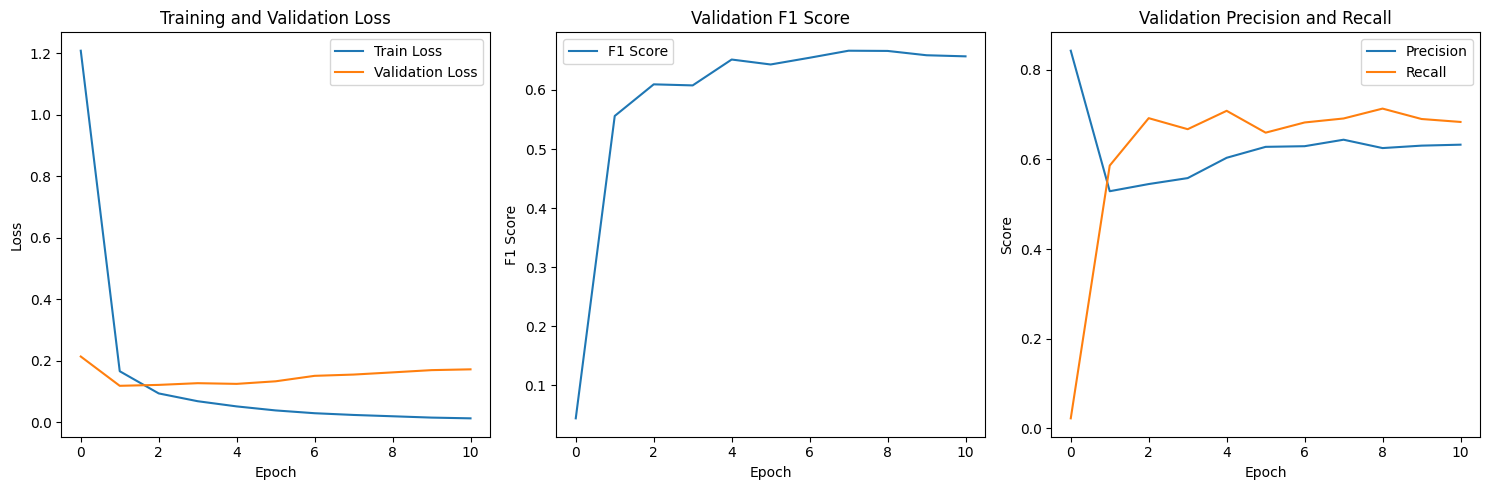


Final evaluation on validation set:


Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
  F1:        0.6665
  Precision: 0.6437
  Recall:    0.6910

Training on fold1, fold2 and validating on fold3

Created 1283 training samples and 681 validation samples


Epoch 1/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
Epoch 1/15:
  Train Loss: 1.2505
  Val   Loss: 0.1946
  Val   F1:   0.0071 (P: 0.8824, R: 0.0036)
  Per-type metrics (top 5 by support):
    STAT: F1=0.0000, P=0.0000, R=0.0000, N=795
    DATE: F1=0.0054, P=1.0000, R=0.0027, N=741
    PREC: F1=0.0000, P=0.0000, R=0.0000, N=621
    COURT: F1=0.0453, P=0.8667, R=0.0233, N=559
    CASENO: F1=0.0000, P=0.0000, R=0.0000, N=342
  ↗ New best F1: 0.0071 (was 0.0000)


Epoch 2/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
Epoch 2/15:
  Train Loss: 0.1790
  Val   Loss: 0.1082
  Val   F1:   0.6205 (P: 0.5992, R: 0.6434)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7477, P=0.7008, R=0.8013, N=795
    DATE: F1=0.9423, P=0.9258, R=0.9595, N=741
    PREC: F1=0.4336, P=0.4308, R=0.4364, N=621
    COURT: F1=0.8294, P=0.8416, R=0.8175, N=559
    CASENO: F1=0.6922, P=0.6973, R=0.6871, N=342
  ↗ New best F1: 0.6205 (was 0.0071)


Epoch 3/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
Epoch 3/15:
  Train Loss: 0.1005
  Val   Loss: 0.1029
  Val   F1:   0.6275 (P: 0.5600, R: 0.7135)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7913, P=0.7271, R=0.8679, N=795
    DATE: F1=0.9470, P=0.9413, R=0.9528, N=741
    PREC: F1=0.5235, P=0.5015, R=0.5475, N=621
    COURT: F1=0.8084, P=0.7623, R=0.8605, N=559
    CASENO: F1=0.6704, P=0.6493, R=0.6930, N=342
  ↗ New best F1: 0.6275 (was 0.6205)


Epoch 4/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
Epoch 4/15:
  Train Loss: 0.0744
  Val   Loss: 0.1012
  Val   F1:   0.6550 (P: 0.6063, R: 0.7123)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7998, P=0.7443, R=0.8642, N=795
    DATE: F1=0.9499, P=0.9405, R=0.9595, N=741
    PREC: F1=0.4398, P=0.4249, R=0.4557, N=621
    COURT: F1=0.8276, P=0.7912, R=0.8676, N=559
    CASENO: F1=0.6976, P=0.7147, R=0.6813, N=342
  ↗ New best F1: 0.6550 (was 0.6275)


Epoch 5/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
Epoch 5/15:
  Train Loss: 0.0551
  Val   Loss: 0.1039
  Val   F1:   0.6648 (P: 0.6358, R: 0.6965)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7882, P=0.7403, R=0.8428, N=795
    DATE: F1=0.9400, P=0.9394, R=0.9406, N=741
    PREC: F1=0.4171, P=0.4444, R=0.3929, N=621
    COURT: F1=0.8358, P=0.8046, R=0.8694, N=559
    CASENO: F1=0.7062, P=0.7169, R=0.6959, N=342
  ↗ New best F1: 0.6648 (was 0.6550)


Epoch 6/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
Epoch 6/15:
  Train Loss: 0.0426
  Val   Loss: 0.1102
  Val   F1:   0.6785 (P: 0.6317, R: 0.7328)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7927, P=0.7415, R=0.8516, N=795
    DATE: F1=0.9528, P=0.9528, R=0.9528, N=741
    PREC: F1=0.5339, P=0.5347, R=0.5330, N=621
    COURT: F1=0.8262, P=0.7886, R=0.8676, N=559
    CASENO: F1=0.6957, P=0.7138, R=0.6784, N=342
  ↗ New best F1: 0.6785 (was 0.6648)


Epoch 7/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
Epoch 7/15:
  Train Loss: 0.0319
  Val   Loss: 0.1163
  Val   F1:   0.6794 (P: 0.6670, R: 0.6923)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7774, P=0.7379, R=0.8214, N=795
    DATE: F1=0.9522, P=0.9503, R=0.9541, N=741
    PREC: F1=0.4751, P=0.5083, R=0.4461, N=621
    COURT: F1=0.8420, P=0.8310, R=0.8533, N=559
    CASENO: F1=0.6879, P=0.7552, R=0.6316, N=342
  ↗ New best F1: 0.6794 (was 0.6785)


Epoch 8/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
Epoch 8/15:
  Train Loss: 0.0246
  Val   Loss: 0.1245
  Val   F1:   0.6795 (P: 0.6521, R: 0.7092)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7889, P=0.7425, R=0.8415, N=795
    DATE: F1=0.9510, P=0.9465, R=0.9555, N=741
    PREC: F1=0.4547, P=0.4569, R=0.4525, N=621
    COURT: F1=0.8356, P=0.8090, R=0.8640, N=559
    CASENO: F1=0.7251, P=0.7372, R=0.7135, N=342
  ↗ New best F1: 0.6795 (was 0.6794)


Epoch 9/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
Epoch 9/15:
  Train Loss: 0.0201
  Val   Loss: 0.1262
  Val   F1:   0.6863 (P: 0.6516, R: 0.7249)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7863, P=0.7427, R=0.8352, N=795
    DATE: F1=0.9528, P=0.9515, R=0.9541, N=741
    PREC: F1=0.5160, P=0.5119, R=0.5201, N=621
    COURT: F1=0.8406, P=0.8151, R=0.8676, N=559
    CASENO: F1=0.7226, P=0.7548, R=0.6930, N=342
  ↗ New best F1: 0.6863 (was 0.6795)


Epoch 10/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
Epoch 10/15:
  Train Loss: 0.0159
  Val   Loss: 0.1282
  Val   F1:   0.6895 (P: 0.6642, R: 0.7168)
  Per-type metrics (top 5 by support):
    STAT: F1=0.8042, P=0.7530, R=0.8629, N=795
    DATE: F1=0.9489, P=0.9463, R=0.9514, N=741
    PREC: F1=0.4907, P=0.4935, R=0.4879, N=621
    COURT: F1=0.8394, P=0.8114, R=0.8694, N=559
    CASENO: F1=0.7123, P=0.7429, R=0.6842, N=342
  ↗ New best F1: 0.6895 (was 0.6863)


Epoch 11/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
Epoch 11/15:
  Train Loss: 0.0125
  Val   Loss: 0.1419
  Val   F1:   0.6959 (P: 0.6674, R: 0.7271)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7909, P=0.7346, R=0.8566, N=795
    DATE: F1=0.9530, P=0.9479, R=0.9582, N=741
    PREC: F1=0.5690, P=0.5514, R=0.5878, N=621
    COURT: F1=0.8341, P=0.8108, R=0.8587, N=559
    CASENO: F1=0.7034, P=0.7372, R=0.6725, N=342
  ↗ New best F1: 0.6959 (was 0.6895)


Epoch 12/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
Epoch 12/15:
  Train Loss: 0.0111
  Val   Loss: 0.1444
  Val   F1:   0.6986 (P: 0.6750, R: 0.7240)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7937, P=0.7450, R=0.8491, N=795
    DATE: F1=0.9530, P=0.9491, R=0.9568, N=741
    PREC: F1=0.5710, P=0.5537, R=0.5894, N=621
    COURT: F1=0.8371, P=0.8199, R=0.8551, N=559
    CASENO: F1=0.7077, P=0.7468, R=0.6725, N=342
  ↗ New best F1: 0.6986 (was 0.6959)


Epoch 13/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
Epoch 13/15:
  Train Loss: 0.0099
  Val   Loss: 0.1448
  Val   F1:   0.6898 (P: 0.6586, R: 0.7240)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7846, P=0.7408, R=0.8340, N=795
    DATE: F1=0.9521, P=0.9515, R=0.9528, N=741
    PREC: F1=0.5350, P=0.5173, R=0.5539, N=621
    COURT: F1=0.8381, P=0.8121, R=0.8658, N=559
    CASENO: F1=0.6959, P=0.7210, R=0.6725, N=342
  ↘ No improvement (1/3)


Epoch 14/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
Epoch 14/15:
  Train Loss: 0.0086
  Val   Loss: 0.1478
  Val   F1:   0.6942 (P: 0.6662, R: 0.7247)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7887, P=0.7430, R=0.8403, N=795
    DATE: F1=0.9576, P=0.9556, R=0.9595, N=741
    PREC: F1=0.5455, P=0.5313, R=0.5604, N=621
    COURT: F1=0.8383, P=0.8156, R=0.8623, N=559
    CASENO: F1=0.6920, P=0.7192, R=0.6667, N=342
  ↘ No improvement (2/3)


Epoch 15/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
Epoch 15/15:
  Train Loss: 0.0081
  Val   Loss: 0.1492
  Val   F1:   0.6941 (P: 0.6632, R: 0.7280)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7880, P=0.7409, R=0.8415, N=795
    DATE: F1=0.9569, P=0.9544, R=0.9595, N=741
    PREC: F1=0.5567, P=0.5340, R=0.5813, N=621
    COURT: F1=0.8349, P=0.8077, R=0.8640, N=559
    CASENO: F1=0.6856, P=0.7025, R=0.6696, N=342
  ↘ No improvement (3/3)
Early stopping at epoch 15


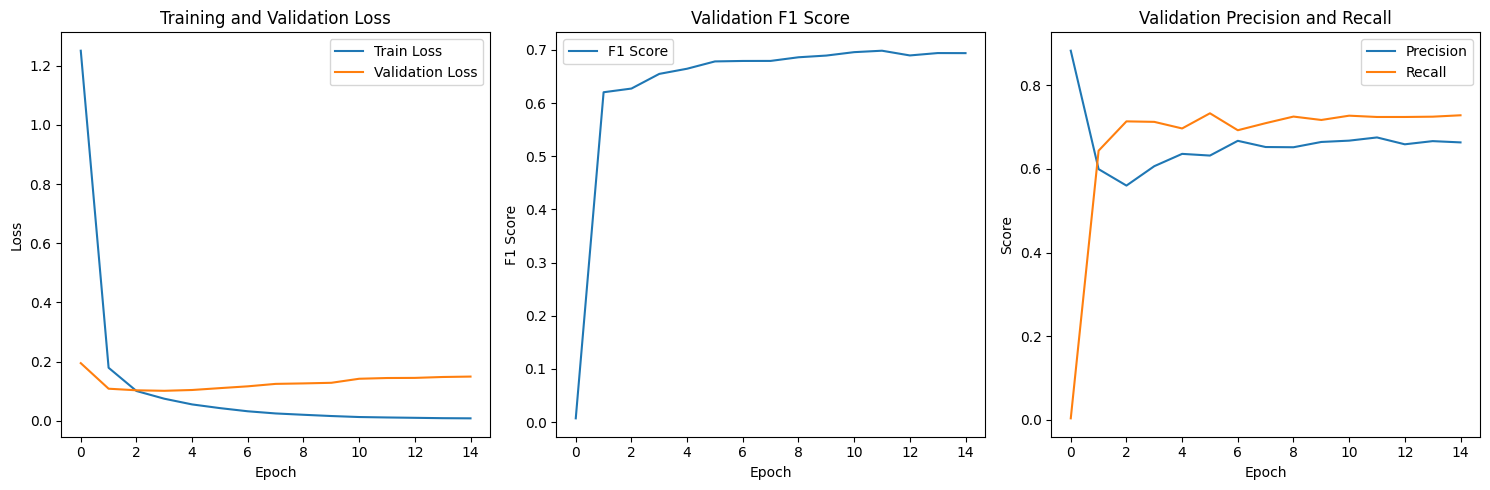


Final evaluation on validation set:


Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 680 documents
  F1:        0.6986
  Precision: 0.6750
  Recall:    0.7240

Cross-validation results:
  Fold 1: F1 = 0.6172
  Fold 2: F1 = 0.6665
  Fold 3: F1 = 0.6986
  Average: F1 = 0.6608, Precision = 0.6336, Recall = 0.6906


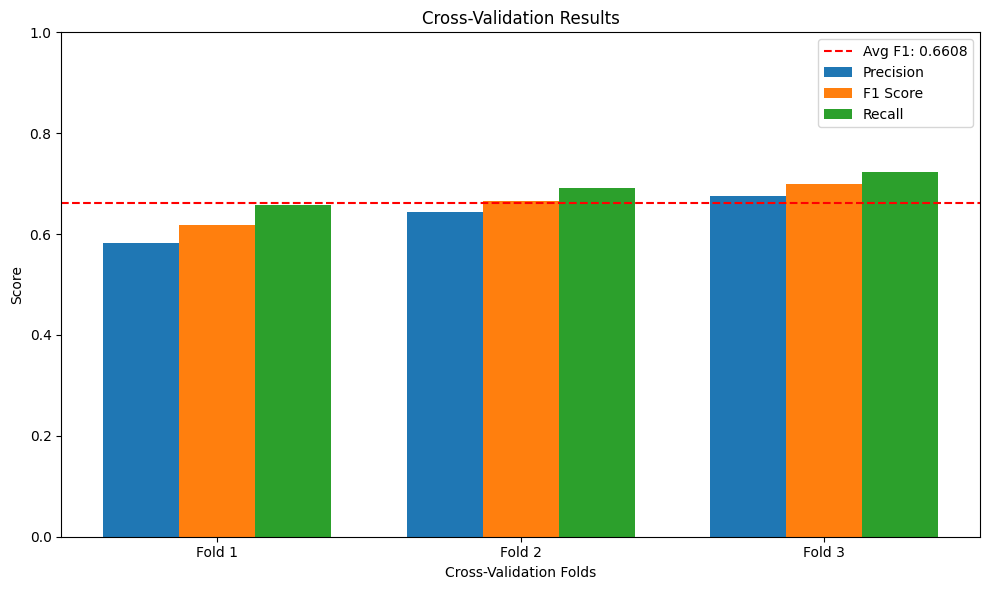


Analyzing entity distribution across the dataset:


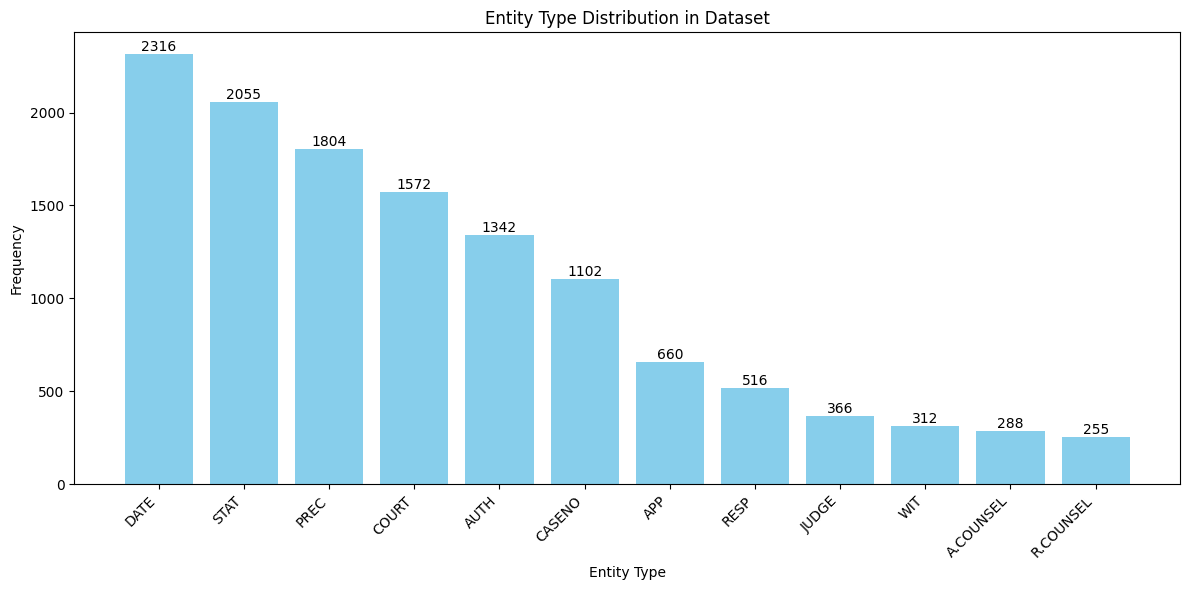

Best model saved to best_legal_ner_model_law_ai_InLegalBERT_CRF_false.pt
Model configuration saved to model_config_law_ai_InLegalBERT_CRF_false.json

Testing on sample document from fold1:

Testing entity extraction on a sample document:

Sample document excerpt:
REPORTABLE IN THE SUPREME COURT OF INDIA CRIMINAL APPELLATE JURISDICTION CRIMINAL APPEAL NO. 92/2015 JAGE RAM & ORS. ..Appellants Versus STATE OF HARYANA ..Respondent J U D G M E N T R. BANUMATHI, J. This appeal is preferred against the judgment dated 19.8.2011 passed by the High Court of Punjab and Haryana in Criminal Appeal No.181 SB of 2000, whereby the High Court partly allowed the appeal filed by the appellants thereby confirming the conviction of the appellants with certain modifications. ...


Predicted entities visualization:


Found 14 entities:
1. APP: 'JAGE RAM'
2. RESP: 'STATE OF HARYANA'
3. DATE: '19.8.2011'
4. COURT: 'High Court of Punjab and Haryana'
5. COURT: 'High Court'
6. DATE: '18.11.1994'
7. WIT: 'Jagdish'
8. WIT: 'Mange Ram'
9. APP: 'Jage Ram'
10. APP: 'Jage Ram'
11. APP: 'Jage Ram'
12. WIT: 'Jagdish'
13. WIT: 'Jagdish'
14. WIT: 'Pardeep Kumar'

Gold standard entities:


Found 104 entities:
1. RESP: 'STATE OF HARYANA'
2. DATE: '19.8.2011'
3. COURT: 'High Court of Punjab and Haryana'
4. COURT: 'High Court'
5. DATE: '18.11.1994'
6. WIT: 'Jagdish'
7. WIT: 'Mange Ram'
8. APP: 'Jage Ram'
9. APP: 'Jage Ram'
10. APP: 'Jage Ram'
11. WIT: 'Jagdish'
12. WIT: 'Jagdish'
13. WIT: 'Pardeep Kumar'
14. WIT: 'Pardeep Kumar'
15. WIT: 'Jagdish'
16. WIT: 'Mange Ram'
17. WIT: 'Jagdish'
18. STAT: 'IPC'
19. WIT: 'Ramesh Kumar'
20. STAT: 'IPC'
21. WIT: 'Jagdish'
22. WIT: 'Mange Ram'
23. WIT: 'Prem Kumar'
24. WIT: 'HiIol Kanti Pal'
25. STAT: 'Cr.P.C.'
26. APP: 'Jage Ram'
27. WIT: 'Jagdish'
28. WIT: 'Mange Ram'
29. WIT: 'Jagdish'
30. APP: 'Jage Ram'
31. DATE: '17.2.2000'
32. STAT: 'IPC'
33. COURT: 'High Court of Punjab and Haryana'
34. COURT: 'High Court'
35. DATE: '19.8.2011'
36. APP: 'Jage Ram'
37. STAT: 'IPC'
38. STAT: 'IPC'
39. COURT: 'High Court'
40. STAT: 'IPC'
41. STAT: 'IPC'
42. COURT: 'High Court'
43. STAT: 'IPC'
44. A.COUNSEL: 'Vibha Datta Makhija'
45. STAT: 'IPC'
46.

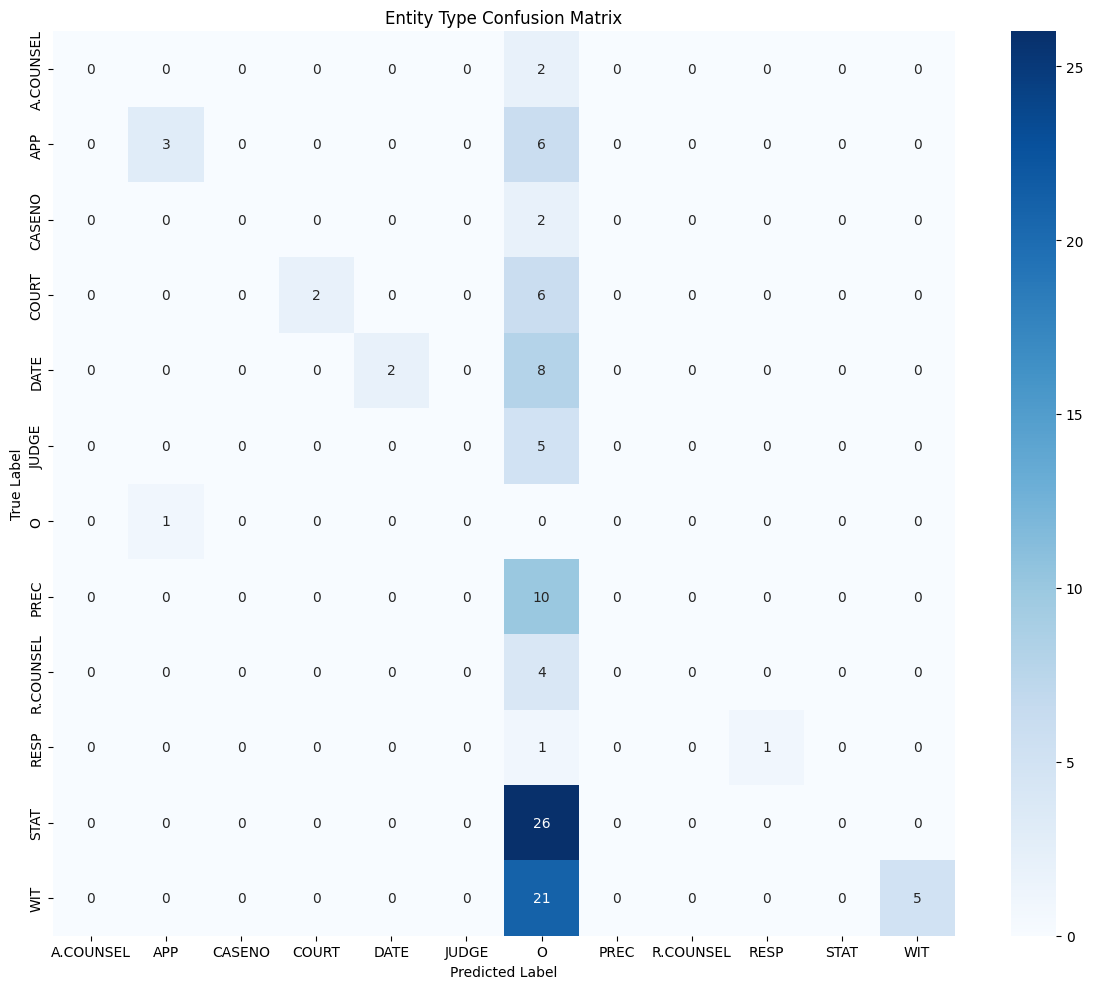


Entity recognition error analysis:


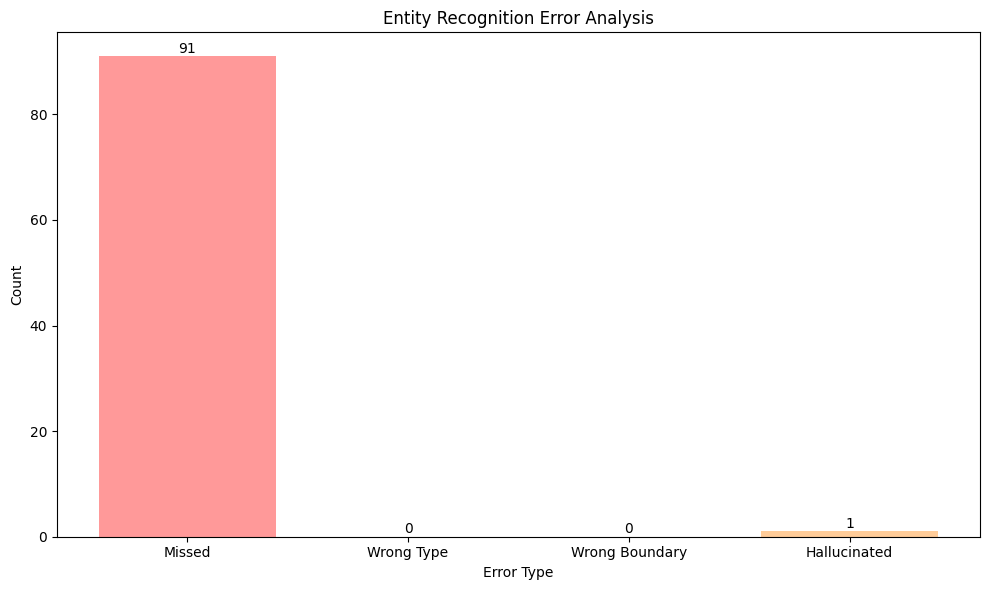

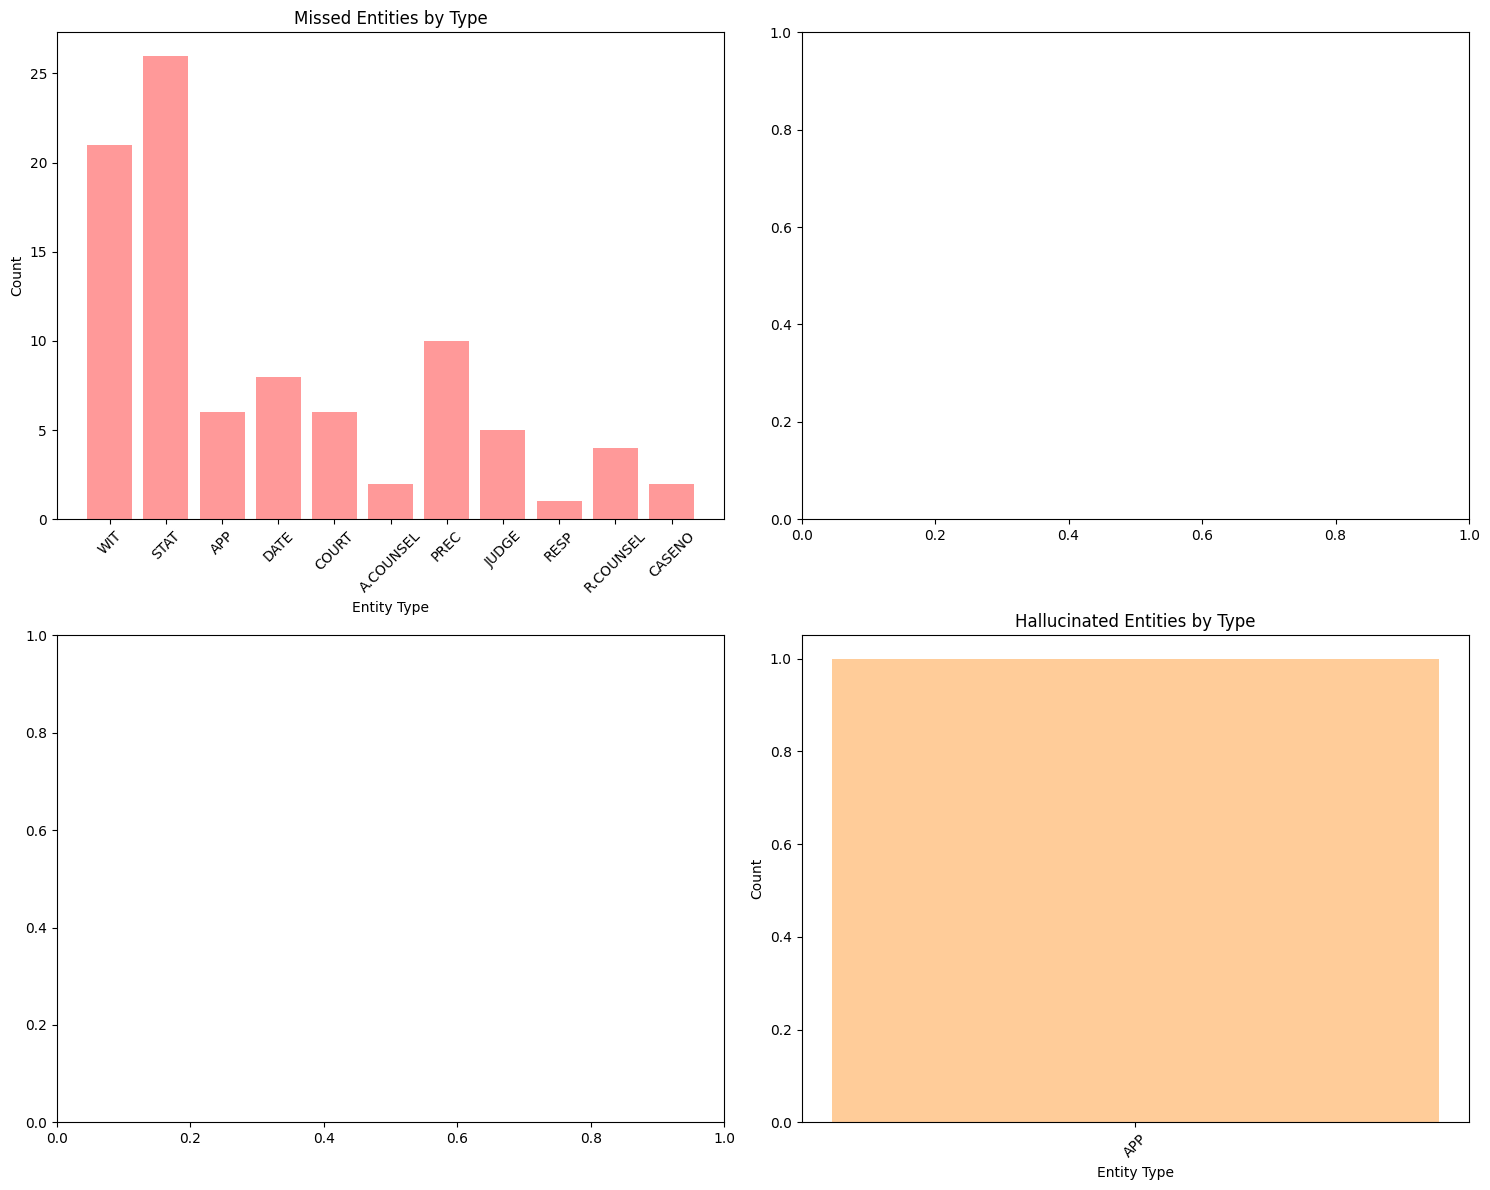

Cross-validation complete!


In [136]:
if __name__ == "__main__":
    best_model, cv_results = run_cross_validation()
    
    # Test on sample documents from fold 1
    print("\nTesting on sample document from fold1:")
    predicted_entities3, true_entities3 = test_on_sample(best_model, sample_idx=0, fold_name="fold1")
    
    print("Cross-validation complete!")

# **use_crf : True**

## Batch Collation Function

- **`collate_fn(batch)`**: Pads input sequences, attention masks, and labels in a batch to the maximum sequence length.
- Always pads labels with `"O"` tag (even if not using CRF).
- Converts all inputs to PyTorch tensors and moves them to the correct device (`cpu` or `cuda`).
- Returns a dictionary containing `input_ids`, `attention_mask`, and `labels` ready for model input.

In [34]:
def collate_fn(batch):
    max_len = max(len(item["input_ids"]) for item in batch)

    input_ids, attention_mask, labels = [], [], []
    for item in batch:
        seq_len = len(item["input_ids"])
        
        ids = item["input_ids"] + [tokenizer.pad_token_id] * (max_len - seq_len)
        mask = item["attention_mask"]   + [0] * (max_len - seq_len)
        
        lab = item["labels"] + [tag2id["O"]] * (max_len - seq_len)
        
        input_ids.append(ids)
        attention_mask.append(mask)
        labels.append(lab)

    input_ids      = torch.tensor(input_ids, dtype=torch.long, device=device)
    attention_mask = torch.tensor(attention_mask, dtype=torch.long, device=device)
    labels         = torch.tensor(labels, dtype=torch.long, device=device)

    return {
        "input_ids":      input_ids,
        "attention_mask": attention_mask,
        "labels":         labels,
    }

## Enhanced LegalNERModel Architecture

- **`LegalNERModel`**: A BERT-based model extended with additional Transformer encoder layers and a CRF layer for sequence labeling.
- After extracting BERT embeddings, multiple Transformer layers refine the representations, followed by layer normalization and dropout.
- Classification is performed via a linear layer, and sequence decoding is handled by a CRF layer.
- Freezes BERT embeddings and the first 6 encoder layers during training for better stability.
- Returns CRF loss during training or decoded entity sequences during inference.

In [35]:
class LegalNERModel(nn.Module):
    def __init__(self, base_model_name: str, num_tags: int):
        super().__init__()
        self.bert = AutoModel.from_pretrained(base_model_name)
        hidden_size = self.bert.config.hidden_size

        num_extra = config.get("extra_transformer_layers", 2)
        self.extra_encoders = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=hidden_size,
                nhead=config.get("transformer_nhead", 8),
                dim_feedforward=config.get("transformer_dim_feedforward", 3072),
                dropout=config.get("transformer_dropout", 0.1),
                batch_first=True
            )
            for _ in range(num_extra)
        ])
        self.norm = nn.LayerNorm(hidden_size)

        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(hidden_size, num_tags)

        self.crf = CRF(num_tags, batch_first=True)

        for param in self.bert.embeddings.parameters():
            param.requires_grad = False
        for i in range(6):
            for p in self.bert.encoder.layer[i].parameters():
                p.requires_grad = False

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor,
        labels = None
    ):
        bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        seq = bert_out.last_hidden_state

        pad_mask = ~attention_mask.bool()
        for enc in self.extra_encoders:
            seq = enc(seq, src_key_padding_mask=pad_mask)

        seq = self.norm(seq)
        seq = self.dropout(seq)
        emissions = self.classifier(seq)

        if labels is not None:
            ll = self.crf(emissions, labels, mask=attention_mask.bool())
            return -ll
        else:
            return self.crf.decode(emissions, mask=attention_mask.bool())

## Model Evaluation Function

- **`evaluate(model, dataloader)`**: Evaluates the model over a given dataloader by computing loss, precision, recall, and F1 score.
- Collects true and predicted tag sequences, ignoring padding tokens.
- Calculates and returns overall evaluation metrics, including the average loss across all batches.

In [36]:
def evaluate(model, dataloader):
    model.eval()
    all_true_tags = []
    all_pred_tags = []
    total_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]
            labels = batch["labels"]

            loss = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            predictions = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            total_loss += loss.item()
            num_batches += 1

            labels_np = labels.cpu().numpy()
            for i, true_arr in enumerate(labels_np):
                # build true tag sequence (ignore -100)
                true_seq = [id2tag[lbl] for lbl in true_arr if lbl != -100]
                pred_seq = [id2tag[p] for p in predictions[i]]

                if true_seq:
                    all_true_tags.append(true_seq)
                    all_pred_tags.append(pred_seq)

    n_docs = len(all_true_tags)
    print(f"Processing {n_docs} documents")

    if n_docs > 0:
        metrics = compute_metrics(all_true_tags, all_pred_tags)
    else:
        print("WARNING: No valid sequences found in evaluation!")
        metrics = {"precision": 0, "recall": 0, "f1": 0, "per_type": {}}

    metrics["loss"] = total_loss / max(num_batches, 1)
    return metrics

## Entity Prediction from Raw Text

- **`predict_entities(model, text, max_length=512)`**: Predicts named entities in raw input text using a trained model.
- Tokenizes the text, applies CRF decoding on the token sequence, and reconstructs entity spans from predicted BIO tags.
- Returns a list of extracted entities with start/end character positions, entity labels, and text spans.

In [37]:
def predict_entities(model, text, max_length=512):
    model.eval()
    
    encodings = tokenizer(
        text,
        max_length=max_length,
        truncation=True,
        return_offsets_mapping=True,
        padding="max_length",
        return_tensors="pt"
    )
    input_ids = encodings["input_ids"].to(device)
    attention_mask = encodings["attention_mask"].to(device)
    offset_mapping = encodings["offset_mapping"].squeeze().cpu().numpy()
    
    with torch.no_grad():
        predictions = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pred_ids = predictions[0]
    
    entities = []
    current_entity = None
    
    for pid, (start, end) in zip(pred_ids, offset_mapping):
        if start == 0 and end == 0:
            continue
        
        tag = id2tag[pid]
        if tag.startswith("B-"):
            if current_entity is not None:
                entities.append(current_entity)
            etype = tag[2:]
            current_entity = {
                "start": int(start),
                "end":   int(end),
                "label": etype,
                "text":  text[int(start):int(end)]
            }
        elif tag.startswith("I-") and current_entity is not None and tag[2:] == current_entity["label"]:
            current_entity["end"] = int(end)
            current_entity["text"] = text[current_entity["start"]:int(end)]
        else:
            if current_entity is not None:
                entities.append(current_entity)
                current_entity = None
    
    if current_entity is not None:
        entities.append(current_entity)
    
    return entities

## Fold Training Procedure with Discriminative Learning Rates

- **`train_fold(train_fold_names, val_fold_name)`**: Trains a Legal NER model on specified folds and validates on a held-out fold.
- Prepares training and validation samples using tokenization and BIO tag alignment.
- Initializes the model with frozen lower BERT layers, additional Transformer encoders, and a CRF layer for decoding.
- Applies discriminative learning rates:
  - Higher LR for classifier, CRF, and extra encoder layers.
  - Medium LR for upper BERT layers.
  - Lower LR for frozen or lower BERT layers.
- Supports mixed-precision training (FP16) and gradient clipping for stability.
- Monitors validation F1 and applies early stopping based on patience.
- Visualizes training metrics if enabled.
- Returns the best model state, final validation metrics, and best validation F1 score achieved.

In [38]:
def train_fold(train_fold_names, val_fold_name):
    print("\n" + "=" * 40)
    print(f"Training on {', '.join(train_fold_names)} and validating on {val_fold_name}")
    print("=" * 40 + "\n")
    
    train_docs = []
    for fold in train_fold_names:
        train_docs.extend(fold_data[fold])
    val_docs = fold_data[val_fold_name]
    
    train_samples, val_samples = [], []
    for doc in train_docs:
        train_samples.extend(tokenize_and_align(doc))
    for doc in val_docs:
        val_samples.extend(tokenize_and_align(doc))
    
    print(f"Created {len(train_samples)} training samples and {len(val_samples)} validation samples")
    
    train_dataset = NERDataset(train_samples)
    val_dataset   = NERDataset(val_samples)
    train_loader  = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True,  collate_fn=collate_fn)
    val_loader    = DataLoader(val_dataset,   batch_size=config["batch_size"], shuffle=False, collate_fn=collate_fn)

    clean_memory()
    model = LegalNERModel(
        base_model_name=config["model_name"],
        num_tags=len(bio_tags)
    ).to(device)
    
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {
            'params': [p for n,p in model.named_parameters()
                       if ('classifier' in n or 'crf' in n or 'extra_encoders' in n)
                          and not any(nd in n for nd in no_decay)],
            'lr': config["learning_rate"] * 5,
            'weight_decay': config["weight_decay"]
        },
        {
            'params': [p for n,p in model.named_parameters()
                       if ('classifier' in n or 'crf' in n or 'extra_encoders' in n)
                          and any(nd in n for nd in no_decay)],
            'lr': config["learning_rate"] * 5,
            'weight_decay': 0.0
        },
        {
            'params': [p for n,p in model.named_parameters()
                       if any(f'encoder.layer.{i}' in n for i in range(6,12))
                          and not any(nd in n for nd in no_decay)
                          and not ('classifier' in n or 'crf' in n or 'extra_encoders' in n)],
            'lr': config["learning_rate"] * 2,
            'weight_decay': config["weight_decay"]
        },
        {
            'params': [p for n,p in model.named_parameters()
                       if any(f'encoder.layer.{i}' in n for i in range(6,12))
                          and any(nd in n for nd in no_decay)
                          and not ('classifier' in n or 'crf' in n or 'extra_encoders' in n)],
            'lr': config["learning_rate"] * 2,
            'weight_decay': 0.0
        },
        {
            'params': [p for n,p in model.named_parameters()
                       if not any(f'encoder.layer.{i}' in n for i in range(6,12))
                          and not ('classifier' in n or 'crf' in n or 'extra_encoders' in n)
                          and not any(nd in n for nd in no_decay)
                          and p.requires_grad],
            'lr': config["learning_rate"],
            'weight_decay': config["weight_decay"]
        },
        {
            'params': [p for n,p in model.named_parameters()
                       if not any(f'encoder.layer.{i}' in n for i in range(6,12))
                          and not ('classifier' in n or 'crf' in n or 'extra_encoders' in n)
                          and any(nd in n for nd in no_decay)
                          and p.requires_grad],
            'lr': config["learning_rate"],
            'weight_decay': 0.0
        },
    ]
    optimizer = optim.AdamW(optimizer_grouped_parameters)
    
    total_steps  = len(train_loader) * config["epochs"]
    warmup_steps = int(total_steps * config["warmup_ratio"])
    scheduler    = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    scaler       = torch.cuda.amp.GradScaler() if config["fp16"] and torch.cuda.is_available() else None
    
    best_val_f1      = 0.0
    best_model_state = None
    history = {
        "train_loss": [], "val_loss": [], "val_f1": [],
        "val_precision": [], "val_recall": []
    }
    patience_counter = 0
    
    for epoch in range(config["epochs"]):
        model.train()
        train_loss, train_steps = 0.0, 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']} [Train]")
        
        for batch in progress_bar:
            optimizer.zero_grad()
            
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    loss = model(
                        input_ids=batch["input_ids"],
                        attention_mask=batch["attention_mask"],
                        labels=batch["labels"]
                    )
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss = model(
                    input_ids=batch["input_ids"],
                    attention_mask=batch["attention_mask"],
                    labels=batch["labels"]
                )
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            
            scheduler.step()
            train_loss += loss.item()
            train_steps += 1
            progress_bar.set_postfix(loss=loss.item())
            
            if train_steps % 20 == 0:
                clean_memory()
        
        train_loss /= max(train_steps, 1)
        clean_memory()
        
        # 7. Validation & logging
        val_metrics = evaluate(model, val_loader)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_metrics["loss"])
        history["val_f1"].append(val_metrics["f1"])
        history["val_precision"].append(val_metrics["precision"])
        history["val_recall"].append(val_metrics["recall"])
        
        print(f"Epoch {epoch+1}/{config['epochs']}:")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val   Loss: {val_metrics['loss']:.4f}")
        print(f"  Val   F1:   {val_metrics['f1']:.4f} "
              f"(P: {val_metrics['precision']:.4f}, R: {val_metrics['recall']:.4f})")
        
        if "per_type" in val_metrics and config["metrics_per_label"]:
            print("  Per-type metrics (top 5 by support):")
            for ent, m in sorted(val_metrics["per_type"].items(),
                                 key=lambda x: x[1]["support"], reverse=True)[:5]:
                print(f"    {ent}: F1={m['f1']:.4f}, "
                      f"P={m['precision']:.4f}, R={m['recall']:.4f}, N={m['support']}")
        
        if val_metrics["f1"] > best_val_f1:
            print(f"  ↗ New best F1: {val_metrics['f1']:.4f} (was {best_val_f1:.4f})")
            best_val_f1 = val_metrics["f1"]
            best_model_state = {k: v.cpu().clone() for k,v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"  ↘ No improvement ({patience_counter}/{config['early_stop_patience']})")
            if patience_counter >= config["early_stop_patience"]:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        clean_memory()
    
    if config.get("visualize_training", True):
        visualize_training_metrics(history)
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    print("\nFinal evaluation on validation set:")
    final_metrics = evaluate(model, val_loader)
    print(f"  F1:        {final_metrics['f1']:.4f}")
    print(f"  Precision: {final_metrics['precision']:.4f}")
    print(f"  Recall:    {final_metrics['recall']:.4f}")
    
    return model, final_metrics, best_val_f1

## **Model : bert-base-uncased**

**Using a learning rate of `1e-4`, for the CRF configuration.**


Training on fold2, fold3 and validating on fold1

Created 1335 training samples and 643 validation samples


2025-04-28 08:27:00.888172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745828821.128617      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745828821.198318      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 1/15:
  Train Loss: 1475.0623
  Val   Loss: 775.8106
  Val   F1:   0.4078 (P: 0.3508, R: 0.4870)
  Per-type metrics (top 5 by support):
    DATE: F1=0.8981, P=0.8663, R=0.9323, N=813
    PREC: F1=0.1356, P=0.1151, R=0.1651, N=624
    AUTH: F1=0.3151, P=0.2827, R=0.3558, N=534
    STAT: F1=0.5599, P=0.4342, R=0.7881, N=519
    COURT: F1=0.5507, P=0.4873, R=0.6330, N=455
  ↗ New best F1: 0.4078 (was 0.0000)


Epoch 2/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 2/15:
  Train Loss: 428.4229
  Val   Loss: 448.9063
  Val   F1:   0.5256 (P: 0.5078, R: 0.5446)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9300, P=0.9205, R=0.9397, N=813
    PREC: F1=0.2988, P=0.2949, R=0.3029, N=624
    AUTH: F1=0.3904, P=0.3250, R=0.4888, N=534
    STAT: F1=0.7185, P=0.6245, R=0.8459, N=519
    COURT: F1=0.6852, P=0.7237, R=0.6505, N=455
  ↗ New best F1: 0.5256 (was 0.4078)


Epoch 3/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 3/15:
  Train Loss: 312.8112
  Val   Loss: 437.7653
  Val   F1:   0.5587 (P: 0.6036, R: 0.5201)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9508, P=0.9399, R=0.9619, N=813
    PREC: F1=0.3793, P=0.4372, R=0.3349, N=624
    AUTH: F1=0.2951, P=0.3937, R=0.2360, N=534
    STAT: F1=0.6991, P=0.7213, R=0.6782, N=519
    COURT: F1=0.6719, P=0.6825, R=0.6615, N=455
  ↗ New best F1: 0.5587 (was 0.5256)


Epoch 4/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 4/15:
  Train Loss: 223.8393
  Val   Loss: 428.3703
  Val   F1:   0.5455 (P: 0.5510, R: 0.5402)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9502, P=0.9377, R=0.9631, N=813
    PREC: F1=0.3610, P=0.3212, R=0.4119, N=624
    AUTH: F1=0.2500, P=0.3136, R=0.2079, N=534
    STAT: F1=0.6983, P=0.7175, R=0.6802, N=519
    COURT: F1=0.6842, P=0.6827, R=0.6857, N=455
  ↘ No improvement (1/3)


Epoch 5/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 5/15:
  Train Loss: 174.0283
  Val   Loss: 462.5947
  Val   F1:   0.5312 (P: 0.4973, R: 0.5699)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9457, P=0.9288, R=0.9631, N=813
    PREC: F1=0.3111, P=0.3493, R=0.2804, N=624
    AUTH: F1=0.3871, P=0.4049, R=0.3708, N=534
    STAT: F1=0.7028, P=0.6708, R=0.7380, N=519
    COURT: F1=0.6722, P=0.5796, R=0.8000, N=455
  ↘ No improvement (2/3)


Epoch 6/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 6/15:
  Train Loss: 137.4861
  Val   Loss: 522.0159
  Val   F1:   0.5724 (P: 0.6003, R: 0.5470)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9074, P=0.8667, R=0.9520, N=813
    PREC: F1=0.3797, P=0.4011, R=0.3606, N=624
    AUTH: F1=0.3832, P=0.4688, R=0.3240, N=534
    STAT: F1=0.6920, P=0.6829, R=0.7013, N=519
    COURT: F1=0.7503, P=0.7796, R=0.7231, N=455
  ↗ New best F1: 0.5724 (was 0.5587)


Epoch 7/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 7/15:
  Train Loss: 108.1359
  Val   Loss: 592.1286
  Val   F1:   0.5815 (P: 0.6682, R: 0.5147)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9556, P=0.9580, R=0.9533, N=813
    PREC: F1=0.3549, P=0.4105, R=0.3125, N=624
    AUTH: F1=0.3246, P=0.4474, R=0.2547, N=534
    STAT: F1=0.7408, P=0.7437, R=0.7380, N=519
    COURT: F1=0.7139, P=0.7878, R=0.6527, N=455
  ↗ New best F1: 0.5815 (was 0.5724)


Epoch 8/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 8/15:
  Train Loss: 85.6734
  Val   Loss: 447.1385
  Val   F1:   0.5847 (P: 0.5692, R: 0.6010)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9562, P=0.9469, R=0.9656, N=813
    PREC: F1=0.4395, P=0.4118, R=0.4712, N=624
    AUTH: F1=0.4434, P=0.4507, R=0.4363, N=534
    STAT: F1=0.6826, P=0.6755, R=0.6898, N=519
    COURT: F1=0.7505, P=0.7409, R=0.7604, N=455
  ↗ New best F1: 0.5847 (was 0.5815)


Epoch 9/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 9/15:
  Train Loss: 62.2835
  Val   Loss: 518.9353
  Val   F1:   0.5790 (P: 0.5427, R: 0.6205)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9556, P=0.9458, R=0.9656, N=813
    PREC: F1=0.3790, P=0.3521, R=0.4103, N=624
    AUTH: F1=0.4566, P=0.4256, R=0.4925, N=534
    STAT: F1=0.7663, P=0.7157, R=0.8247, N=519
    COURT: F1=0.7207, P=0.6763, R=0.7714, N=455
  ↘ No improvement (1/3)


Epoch 10/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 10/15:
  Train Loss: 47.1973
  Val   Loss: 554.9765
  Val   F1:   0.5952 (P: 0.5930, R: 0.5974)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9597, P=0.9527, R=0.9668, N=813
    PREC: F1=0.4031, P=0.3890, R=0.4183, N=624
    AUTH: F1=0.4301, P=0.4858, R=0.3858, N=534
    STAT: F1=0.7180, P=0.7273, R=0.7091, N=519
    COURT: F1=0.7339, P=0.7170, R=0.7516, N=455
  ↗ New best F1: 0.5952 (was 0.5847)


Epoch 11/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 11/15:
  Train Loss: 31.3721
  Val   Loss: 653.0150
  Val   F1:   0.5720 (P: 0.6019, R: 0.5449)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9584, P=0.9537, R=0.9631, N=813
    PREC: F1=0.3588, P=0.3977, R=0.3269, N=624
    AUTH: F1=0.3710, P=0.4483, R=0.3165, N=534
    STAT: F1=0.6432, P=0.6353, R=0.6513, N=519
    COURT: F1=0.7614, P=0.7882, R=0.7363, N=455
  ↘ No improvement (1/3)


Epoch 12/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 12/15:
  Train Loss: 23.3977
  Val   Loss: 680.8164
  Val   F1:   0.5912 (P: 0.6049, R: 0.5782)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9581, P=0.9471, R=0.9692, N=813
    PREC: F1=0.4136, P=0.3922, R=0.4375, N=624
    AUTH: F1=0.3403, P=0.4151, R=0.2884, N=534
    STAT: F1=0.7288, P=0.7058, R=0.7534, N=519
    COURT: F1=0.7554, P=0.7755, R=0.7363, N=455
  ↘ No improvement (2/3)


Epoch 13/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 13/15:
  Train Loss: 15.9221
  Val   Loss: 712.0288
  Val   F1:   0.5879 (P: 0.5937, R: 0.5823)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9561, P=0.9480, R=0.9643, N=813
    PREC: F1=0.3801, P=0.3419, R=0.4279, N=624
    AUTH: F1=0.3681, P=0.4511, R=0.3109, N=534
    STAT: F1=0.7397, P=0.7375, R=0.7418, N=519
    COURT: F1=0.7528, P=0.7561, R=0.7495, N=455
  ↘ No improvement (3/3)
Early stopping at epoch 13


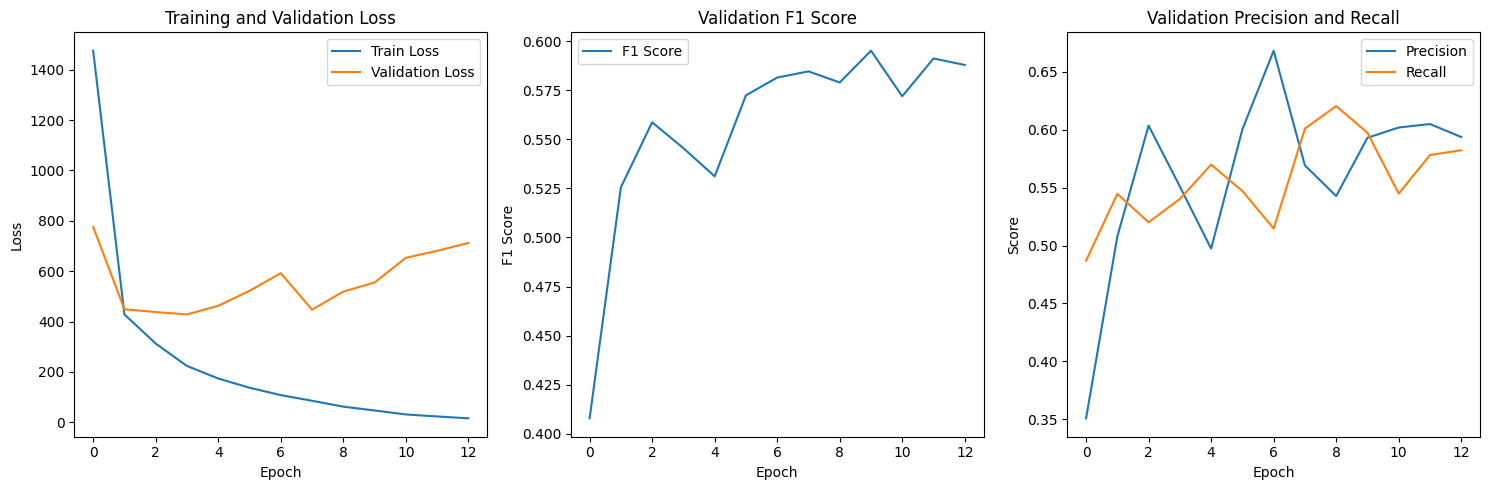


Final evaluation on validation set:


Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
  F1:        0.5952
  Precision: 0.5930
  Recall:    0.5974

Training on fold1, fold3 and validating on fold2

Created 1330 training samples and 648 validation samples


Epoch 1/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 1/15:
  Train Loss: 1332.0673
  Val   Loss: 578.0532
  Val   F1:   0.4386 (P: 0.7655, R: 0.3073)
  Per-type metrics (top 5 by support):
    DATE: F1=0.8582, P=0.9336, R=0.7940, N=762
    STAT: F1=0.5321, P=0.8571, R=0.3858, N=731
    PREC: F1=0.0355, P=0.0747, R=0.0233, N=559
    COURT: F1=0.7563, P=0.8677, R=0.6703, N=558
    AUTH: F1=0.0000, P=0.0000, R=0.0000, N=468
  ↗ New best F1: 0.4386 (was 0.0000)


Epoch 2/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 2/15:
  Train Loss: 402.5470
  Val   Loss: 511.5838
  Val   F1:   0.3971 (P: 0.3792, R: 0.4167)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9263, P=0.9133, R=0.9396, N=762
    STAT: F1=0.2035, P=0.4870, R=0.1286, N=731
    PREC: F1=0.2862, P=0.2648, R=0.3113, N=559
    COURT: F1=0.7679, P=0.7404, R=0.7975, N=558
    AUTH: F1=0.0600, P=0.0830, R=0.0470, N=468
  ↘ No improvement (1/3)


Epoch 3/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 3/15:
  Train Loss: 302.9264
  Val   Loss: 481.5481
  Val   F1:   0.5644 (P: 0.5423, R: 0.5884)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9363, P=0.9476, R=0.9252, N=762
    STAT: F1=0.7424, P=0.6768, R=0.8222, N=731
    PREC: F1=0.4520, P=0.4206, R=0.4884, N=559
    COURT: F1=0.8014, P=0.7862, R=0.8172, N=558
    AUTH: F1=0.4358, P=0.4295, R=0.4423, N=468
  ↗ New best F1: 0.5644 (was 0.4386)


Epoch 4/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 4/15:
  Train Loss: 214.1943
  Val   Loss: 471.7107
  Val   F1:   0.5073 (P: 0.5005, R: 0.5144)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9282, P=0.9313, R=0.9252, N=762
    STAT: F1=0.7559, P=0.6967, R=0.8263, N=731
    PREC: F1=0.0071, P=0.0103, R=0.0054, N=559
    COURT: F1=0.7941, P=0.7707, R=0.8190, N=558
    AUTH: F1=0.1506, P=0.1972, R=0.1218, N=468
  ↘ No improvement (1/3)


Epoch 5/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 5/15:
  Train Loss: 173.9562
  Val   Loss: 483.5707
  Val   F1:   0.5859 (P: 0.5917, R: 0.5802)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9294, P=0.9181, R=0.9409, N=762
    STAT: F1=0.7637, P=0.7858, R=0.7428, N=731
    PREC: F1=0.4588, P=0.4090, R=0.5224, N=559
    COURT: F1=0.7456, P=0.7646, R=0.7276, N=558
    AUTH: F1=0.3355, P=0.4286, R=0.2756, N=468
  ↗ New best F1: 0.5859 (was 0.5644)


Epoch 6/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 6/15:
  Train Loss: 136.1498
  Val   Loss: 440.6048
  Val   F1:   0.6153 (P: 0.6014, R: 0.6299)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9319, P=0.9217, R=0.9423, N=762
    STAT: F1=0.7741, P=0.7484, R=0.8016, N=731
    PREC: F1=0.4426, P=0.4060, R=0.4866, N=559
    COURT: F1=0.8206, P=0.7875, R=0.8566, N=558
    AUTH: F1=0.4010, P=0.5032, R=0.3333, N=468
  ↗ New best F1: 0.6153 (was 0.5859)


Epoch 7/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 7/15:
  Train Loss: 106.1093
  Val   Loss: 528.1352
  Val   F1:   0.5959 (P: 0.6544, R: 0.5470)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9440, P=0.9483, R=0.9396, N=762
    STAT: F1=0.6868, P=0.8170, R=0.5923, N=731
    PREC: F1=0.4415, P=0.4376, R=0.4454, N=559
    COURT: F1=0.7975, P=0.7871, R=0.8082, N=558
    AUTH: F1=0.3377, P=0.5297, R=0.2479, N=468
  ↘ No improvement (1/3)


Epoch 8/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 8/15:
  Train Loss: 79.5096
  Val   Loss: 590.9760
  Val   F1:   0.5993 (P: 0.6284, R: 0.5727)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9452, P=0.9509, R=0.9396, N=762
    STAT: F1=0.6883, P=0.7460, R=0.6389, N=731
    PREC: F1=0.4890, P=0.4139, R=0.5975, N=559
    COURT: F1=0.8059, P=0.8280, R=0.7849, N=558
    AUTH: F1=0.2690, P=0.4259, R=0.1966, N=468
  ↘ No improvement (2/3)


Epoch 9/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 9/15:
  Train Loss: 62.0075
  Val   Loss: 528.7770
  Val   F1:   0.6015 (P: 0.5926, R: 0.6107)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9396, P=0.9396, R=0.9396, N=762
    STAT: F1=0.7665, P=0.7697, R=0.7633, N=731
    PREC: F1=0.4672, P=0.4273, R=0.5152, N=559
    COURT: F1=0.8216, P=0.7878, R=0.8584, N=558
    AUTH: F1=0.3022, P=0.3555, R=0.2628, N=468
  ↘ No improvement (3/3)
Early stopping at epoch 9


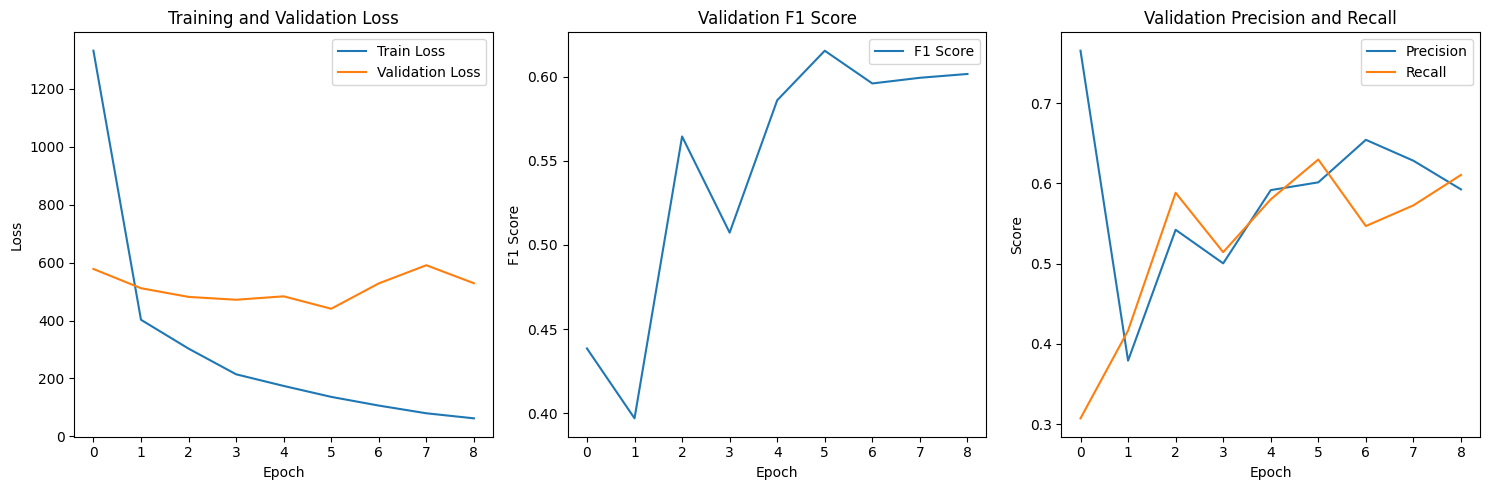


Final evaluation on validation set:


Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
  F1:        0.6153
  Precision: 0.6014
  Recall:    0.6299

Training on fold1, fold2 and validating on fold3

Created 1291 training samples and 687 validation samples


Epoch 1/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 687 documents
Epoch 1/15:
  Train Loss: 1320.7289
  Val   Loss: 435.9982
  Val   F1:   0.5172 (P: 0.5442, R: 0.4927)
  Per-type metrics (top 5 by support):
    STAT: F1=0.5674, P=0.4878, R=0.6780, N=795
    DATE: F1=0.9045, P=0.8780, R=0.9325, N=741
    PREC: F1=0.2891, P=0.2572, R=0.3301, N=621
    COURT: F1=0.7758, P=0.7599, R=0.7925, N=559
    CASENO: F1=0.5305, P=0.6075, R=0.4708, N=342
  ↗ New best F1: 0.5172 (was 0.0000)


Epoch 2/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 687 documents
Epoch 2/15:
  Train Loss: 431.9312
  Val   Loss: 415.6145
  Val   F1:   0.6047 (P: 0.5989, R: 0.6105)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7410, P=0.6910, R=0.7987, N=795
    DATE: F1=0.9033, P=0.8598, R=0.9514, N=741
    PREC: F1=0.3776, P=0.3752, R=0.3800, N=621
    COURT: F1=0.8106, P=0.7780, R=0.8462, N=559
    CASENO: F1=0.5710, P=0.5359, R=0.6111, N=342
  ↗ New best F1: 0.6047 (was 0.5172)


Epoch 3/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 687 documents
Epoch 3/15:
  Train Loss: 314.2413
  Val   Loss: 461.4697
  Val   F1:   0.5151 (P: 0.4416, R: 0.6179)
  Per-type metrics (top 5 by support):
    STAT: F1=0.6426, P=0.5502, R=0.7723, N=795
    DATE: F1=0.9443, P=0.9387, R=0.9501, N=741
    PREC: F1=0.3220, P=0.2821, R=0.3752, N=621
    COURT: F1=0.7597, P=0.6954, R=0.8372, N=559
    CASENO: F1=0.6118, P=0.5762, R=0.6520, N=342
  ↘ No improvement (1/3)


Epoch 4/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 687 documents
Epoch 4/15:
  Train Loss: 230.1965
  Val   Loss: 445.9078
  Val   F1:   0.6186 (P: 0.6669, R: 0.5769)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7537, P=0.6867, R=0.8352, N=795
    DATE: F1=0.9336, P=0.9374, R=0.9298, N=741
    PREC: F1=0.3106, P=0.3770, R=0.2641, N=621
    COURT: F1=0.7996, P=0.8145, R=0.7853, N=559
    CASENO: F1=0.6412, P=0.6450, R=0.6374, N=342
  ↗ New best F1: 0.6186 (was 0.6047)


Epoch 5/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 687 documents
Epoch 5/15:
  Train Loss: 181.6729
  Val   Loss: 364.9390
  Val   F1:   0.5861 (P: 0.5629, R: 0.6112)
  Per-type metrics (top 5 by support):
    STAT: F1=0.6886, P=0.6690, R=0.7094, N=795
    DATE: F1=0.9359, P=0.9260, R=0.9460, N=741
    PREC: F1=0.4185, P=0.4076, R=0.4300, N=621
    COURT: F1=0.7903, P=0.7695, R=0.8122, N=559
    CASENO: F1=0.5689, P=0.5766, R=0.5614, N=342
  ↘ No improvement (1/3)


Epoch 6/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 687 documents
Epoch 6/15:
  Train Loss: 141.1029
  Val   Loss: 398.2583
  Val   F1:   0.5970 (P: 0.6122, R: 0.5826)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7156, P=0.6667, R=0.7723, N=795
    DATE: F1=0.9475, P=0.9450, R=0.9501, N=741
    PREC: F1=0.4240, P=0.3712, R=0.4944, N=621
    COURT: F1=0.7879, P=0.7851, R=0.7907, N=559
    CASENO: F1=0.5854, P=0.5618, R=0.6111, N=342
  ↘ No improvement (2/3)


Epoch 7/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 687 documents
Epoch 7/15:
  Train Loss: 111.3104
  Val   Loss: 387.1312
  Val   F1:   0.6166 (P: 0.6336, R: 0.6005)
  Per-type metrics (top 5 by support):
    STAT: F1=0.6209, P=0.6601, R=0.5862, N=795
    DATE: F1=0.9443, P=0.9508, R=0.9379, N=741
    PREC: F1=0.5065, P=0.4812, R=0.5346, N=621
    COURT: F1=0.8235, P=0.8206, R=0.8265, N=559
    CASENO: F1=0.6422, P=0.7077, R=0.5877, N=342
  ↘ No improvement (3/3)
Early stopping at epoch 7


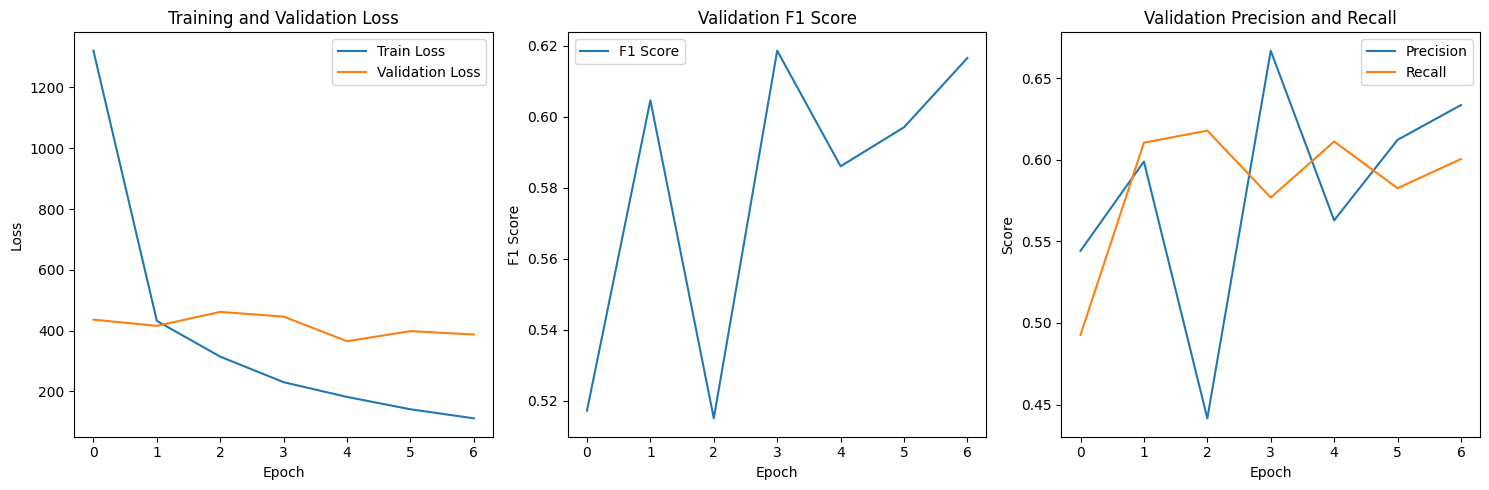


Final evaluation on validation set:


Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 687 documents
  F1:        0.6186
  Precision: 0.6669
  Recall:    0.5769

Cross-validation results:
  Fold 1: F1 = 0.5952
  Fold 2: F1 = 0.6153
  Fold 3: F1 = 0.6186
  Average: F1 = 0.6097, Precision = 0.6204, Recall = 0.6014


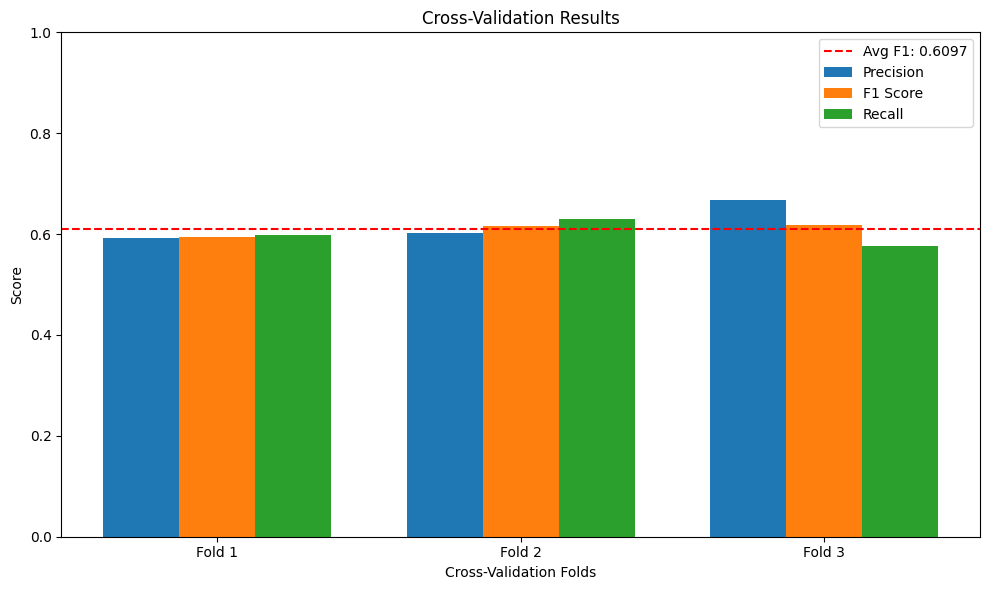


Analyzing entity distribution across the dataset:


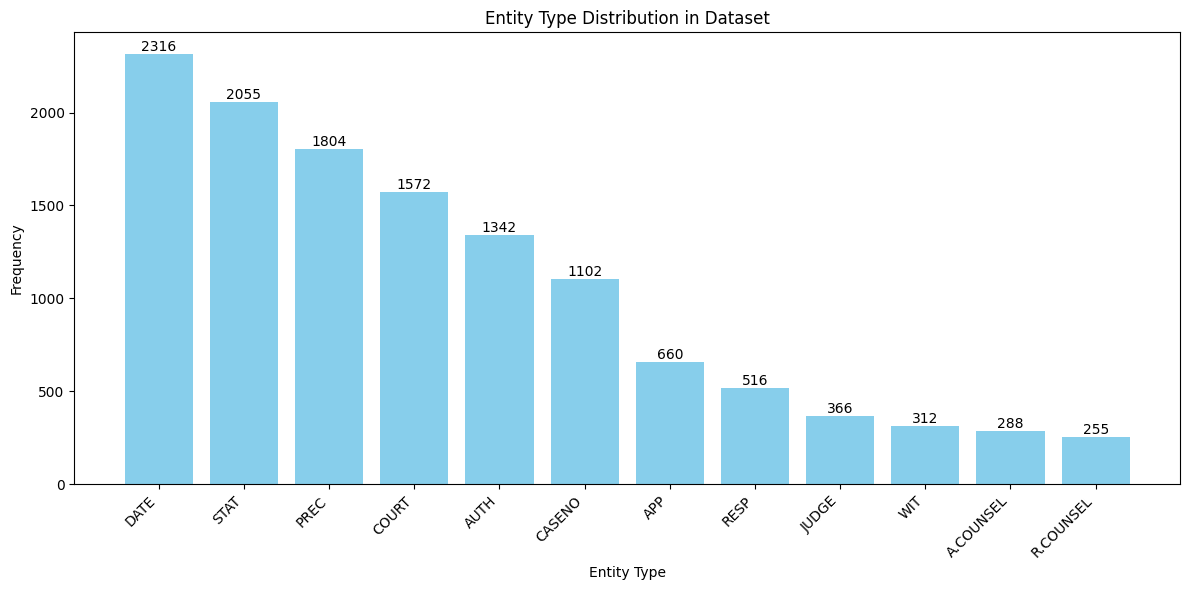

Best model saved to best_legal_ner_model_bert_base_uncased_CRF_true.pt
Model configuration saved to model_config_bert_base_uncased_CRF_true.json

Testing on sample document from fold1:

Testing entity extraction on a sample document:

Sample document excerpt:
REPORTABLE IN THE SUPREME COURT OF INDIA CRIMINAL APPELLATE JURISDICTION CRIMINAL APPEAL NO. 92/2015 JAGE RAM & ORS. ..Appellants Versus STATE OF HARYANA ..Respondent J U D G M E N T R. BANUMATHI, J. This appeal is preferred against the judgment dated 19.8.2011 passed by the High Court of Punjab and Haryana in Criminal Appeal No.181 SB of 2000, whereby the High Court partly allowed the appeal filed by the appellants thereby confirming the conviction of the appellants with certain modifications. ...


Predicted entities visualization:


Found 17 entities:
1. COURT: 'SUPREME'
2. CASENO: 'CRIMINAL APPEAL NO. 92/'
3. APP: 'JAGE RAM'
4. RESP: 'STATE'
5. DATE: '19.8.2011'
6. COURT: 'High Court'
7. CASENO: 'Criminal Appeal No.181'
8. COURT: 'High Court'
9. DATE: '18.11.1994'
10. WIT: 'Jagdish'
11. WIT: 'Mange Ram'
12. WIT: 'Jage Ram'
13. WIT: 'Jage Ram'
14. WIT: 'Jage Ram'
15. WIT: 'Jagdish'
16. WIT: 'Jagdish'
17. WIT: 'Pardeep Kumar'

Gold standard entities:


Found 104 entities:
1. RESP: 'STATE OF HARYANA'
2. DATE: '19.8.2011'
3. COURT: 'High Court of Punjab and Haryana'
4. COURT: 'High Court'
5. DATE: '18.11.1994'
6. WIT: 'Jagdish'
7. WIT: 'Mange Ram'
8. APP: 'Jage Ram'
9. APP: 'Jage Ram'
10. APP: 'Jage Ram'
11. WIT: 'Jagdish'
12. WIT: 'Jagdish'
13. WIT: 'Pardeep Kumar'
14. WIT: 'Pardeep Kumar'
15. WIT: 'Jagdish'
16. WIT: 'Mange Ram'
17. WIT: 'Jagdish'
18. STAT: 'IPC'
19. WIT: 'Ramesh Kumar'
20. STAT: 'IPC'
21. WIT: 'Jagdish'
22. WIT: 'Mange Ram'
23. WIT: 'Prem Kumar'
24. WIT: 'HiIol Kanti Pal'
25. STAT: 'Cr.P.C.'
26. APP: 'Jage Ram'
27. WIT: 'Jagdish'
28. WIT: 'Mange Ram'
29. WIT: 'Jagdish'
30. APP: 'Jage Ram'
31. DATE: '17.2.2000'
32. STAT: 'IPC'
33. COURT: 'High Court of Punjab and Haryana'
34. COURT: 'High Court'
35. DATE: '19.8.2011'
36. APP: 'Jage Ram'
37. STAT: 'IPC'
38. STAT: 'IPC'
39. COURT: 'High Court'
40. STAT: 'IPC'
41. STAT: 'IPC'
42. COURT: 'High Court'
43. STAT: 'IPC'
44. A.COUNSEL: 'Vibha Datta Makhija'
45. STAT: 'IPC'
46.

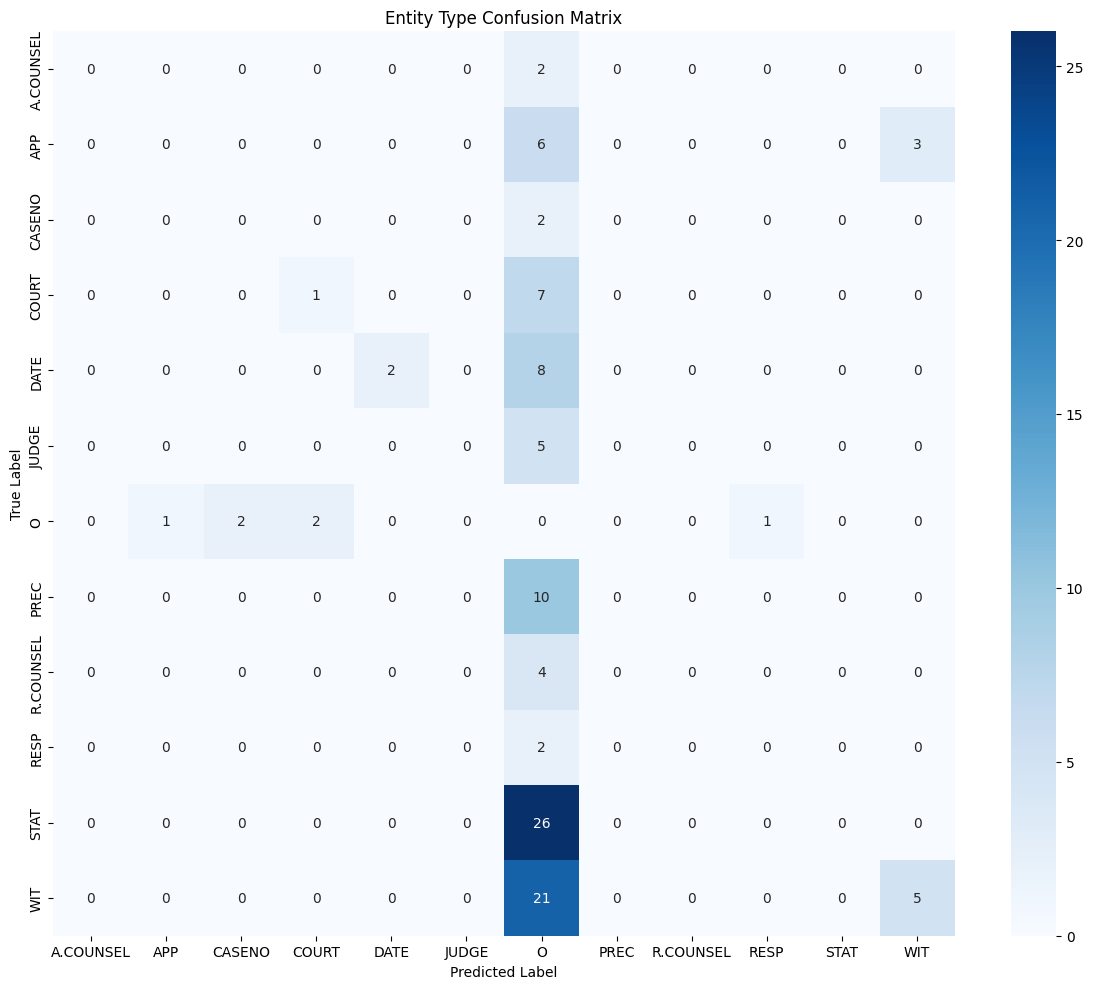


Entity recognition error analysis:


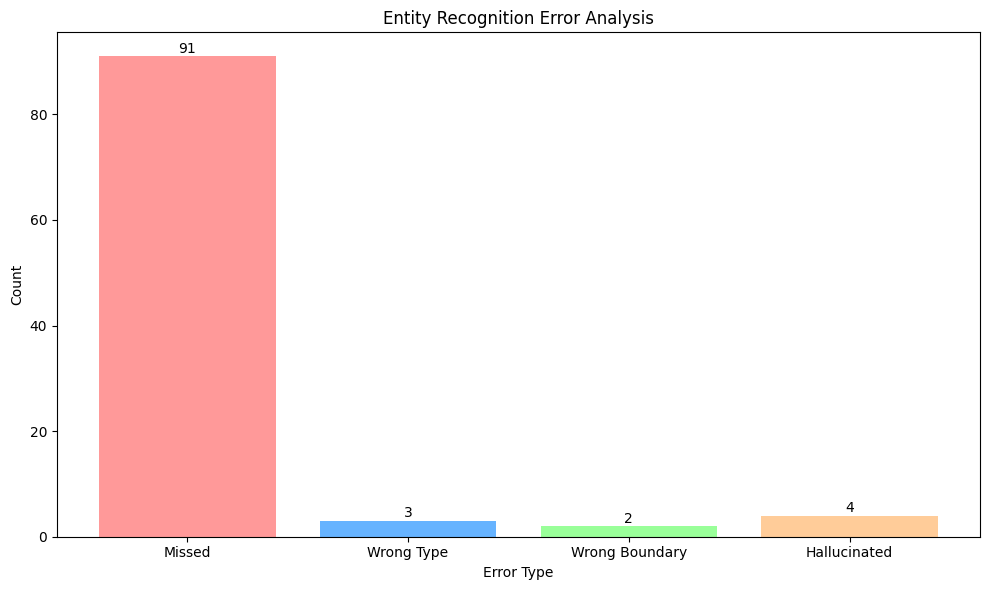

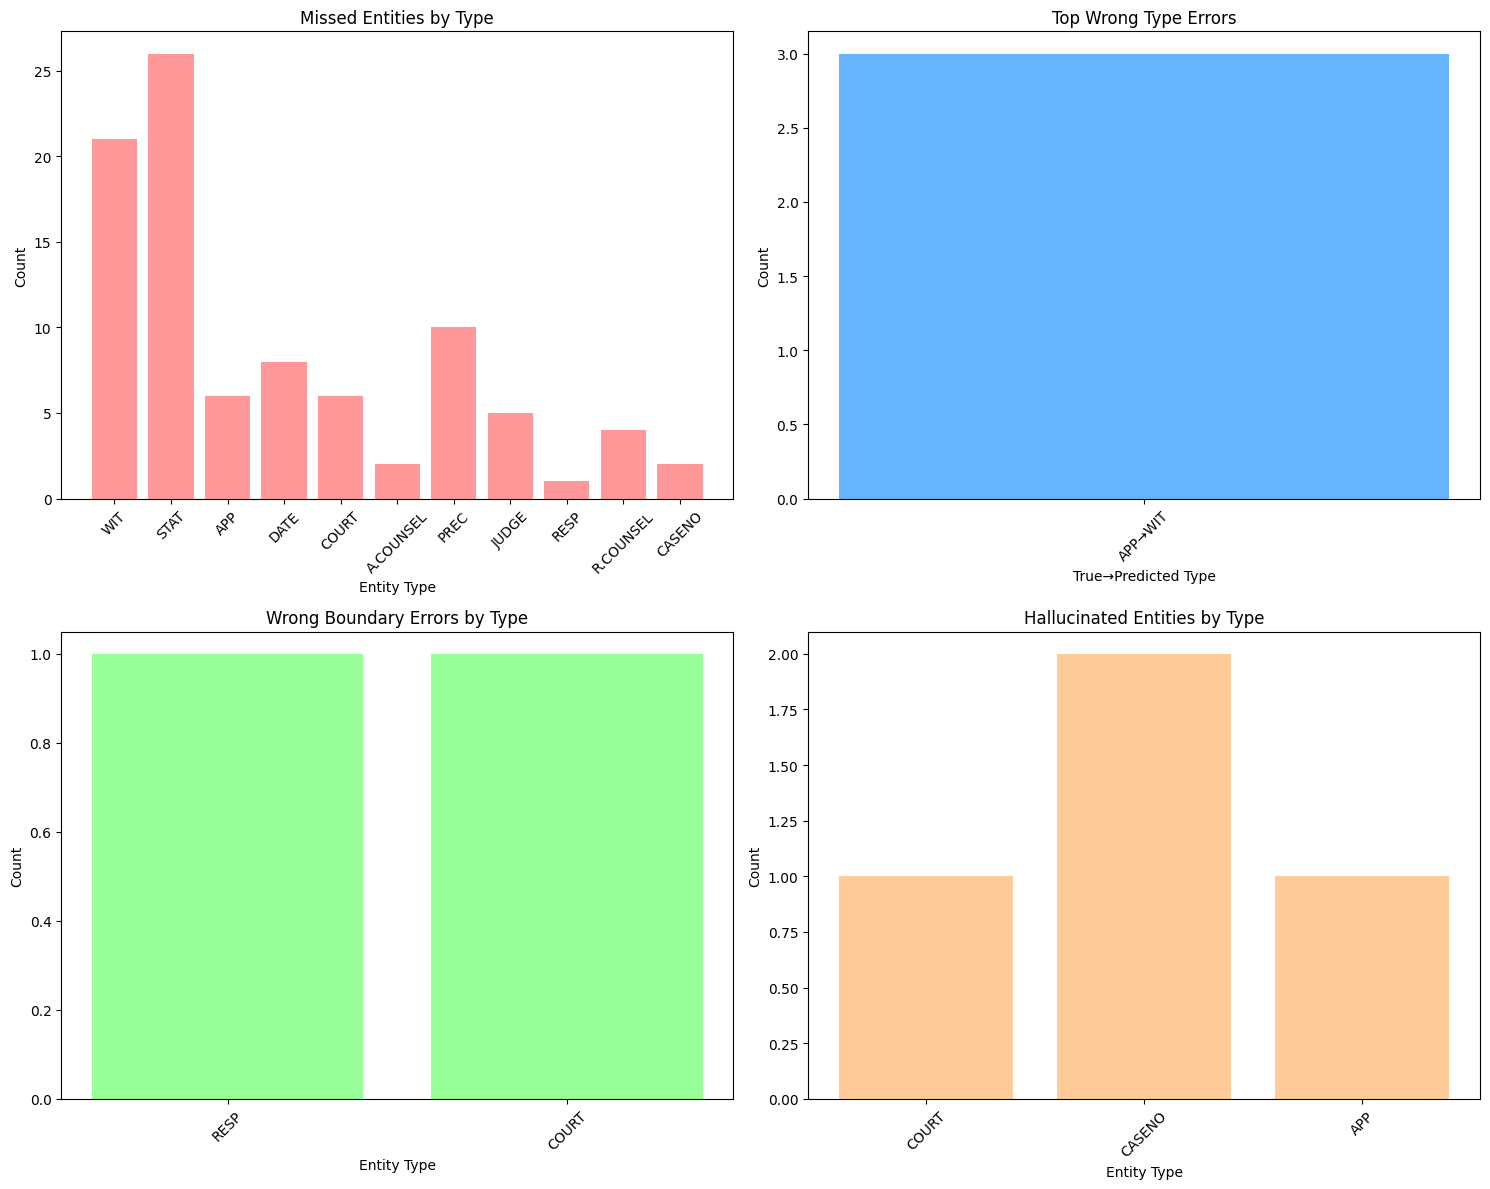


Testing on sample document from fold2:

Testing entity extraction on a sample document:

Sample document excerpt:
IN THE HIGH COURT AT CALCUTTA CIVIL REVISIONAL JURISDICTION APPELLATE SIDE Before: The Hon'ble Justice Hiranmay Bhattacharyya C.O. 3346 of 2018 The Kolkata Municipal Corporation Vs. Smt. Kajari Banerjee For the petitioner : Mr. Alok Kr. Ghosh, Mr. S.K. Debnath..... advocates For the opposite party : Mr. R.N. Chakraborty, Mr. M. Ahmed............ advocates Heard on : 18.12.2020 Judgment on : 22.12.2020 Hiranmay Bhattacharyya, J.: This application under Article 227 of the Constitution of India is ...


Predicted entities visualization:


Found 32 entities:
1. JUDGE: 'Hiran'
2. CASENO: 'C.O. 3346 of 2018'
3. APP: 'Kolkata Municipal Corporation'
4. R.COUNSEL: 'Alok Kr. Ghosh'
5. R.COUNSEL: 'S.K. Debnath'
6. R.COUNSEL: 'R.N. Chakraborty'
7. R.COUNSEL: 'M. Ahmed'
8. DATE: '18.12.2020'
9. DATE: '22.12.2020'
10. JUDGE: 'Hiran'
11. STAT: 'Constitution of India'
12. APP: 'Kolkata Municipal Corporation'
13. DATE: 'March 27, 2018'
14. AUTH: 'Learned'
15. AUTH: 'Municipal Assessment Tribunal'
16. APP: 'Kolkata Municipal'
17. CASENO: 'M.A. Appeal no. 947 of 2012'
18. DATE: 'March 24, 2012'
19. DATE: 'fourth quarter of 2009-10'
20. CASENO: 'M.A. Appeal no. 947 of 2012'
21. DATE: 'March 24, 2012'
22. AUTH: 'Municipal Assessment Tribunal'
23. DATE: 'February 16, 2015'
24. APP: 'Kolkata Municipal Corporation'
25. DATE: 'February 16, 2015'
26. STAT: 'Constitution of India'
27. CASENO: 'C.O. no. 2623 of 2017'
28. DATE: 'December 18, 2017'
29. CASENO: 'Civil Order No. 2623 of 2017'
30. DATE: 'February 16, 2015'
31. DATE: 'March 27, 2018'

Found 113 entities:
1. JUDGE: 'Hiranmay Bhattacharyya'
2. CASENO: 'C.O. 3346 of 2018'
3. APP: 'Kolkata Municipal Corporation'
4. RESP: 'Smt. Kajari Banerjee'
5. A.COUNSEL: 'Ghosh'
6. R.COUNSEL: 'R.N. Chakraborty'
7. R.COUNSEL: 'M. Ahmed'
8. CASENO: '18.12.2020'
9. CASENO: '22.12.2020'
10. JUDGE: 'Hiranmay Bhattacharyya'
11. STAT: 'Constitution of India'
12. APP: 'Kolkata Municipal Corporation'
13. DATE: 'March 27, 2018'
14. AUTH: 'Municipal Assessment Tribunal'
15. APP: 'Kolkata Municipal Corporation'
16. CASENO: 'M.A. Appeal no. 947 of 2012'
17. DATE: 'March 24, 2012'
18. DATE: 'fourth quarter of 2009-10'
19. CASENO: 'M.A. Appeal no. 947 of 2012'
20. DATE: 'March 24, 2012'
21. AUTH: 'Municipal Assessment Tribunal'
22. DATE: 'February 16, 2015'
23. APP: 'Kolkata Municipal Corporation'
24. DATE: 'February 16, 2015'
25. STAT: 'Constitution of India'
26. CASENO: 'C.O. no. 2623 of 2017'
27. DATE: 'December 18, 2017'
28. CASENO: 'Civil Order No. 2623 of 2017'
29. DATE: 'February 16, 2015'
3

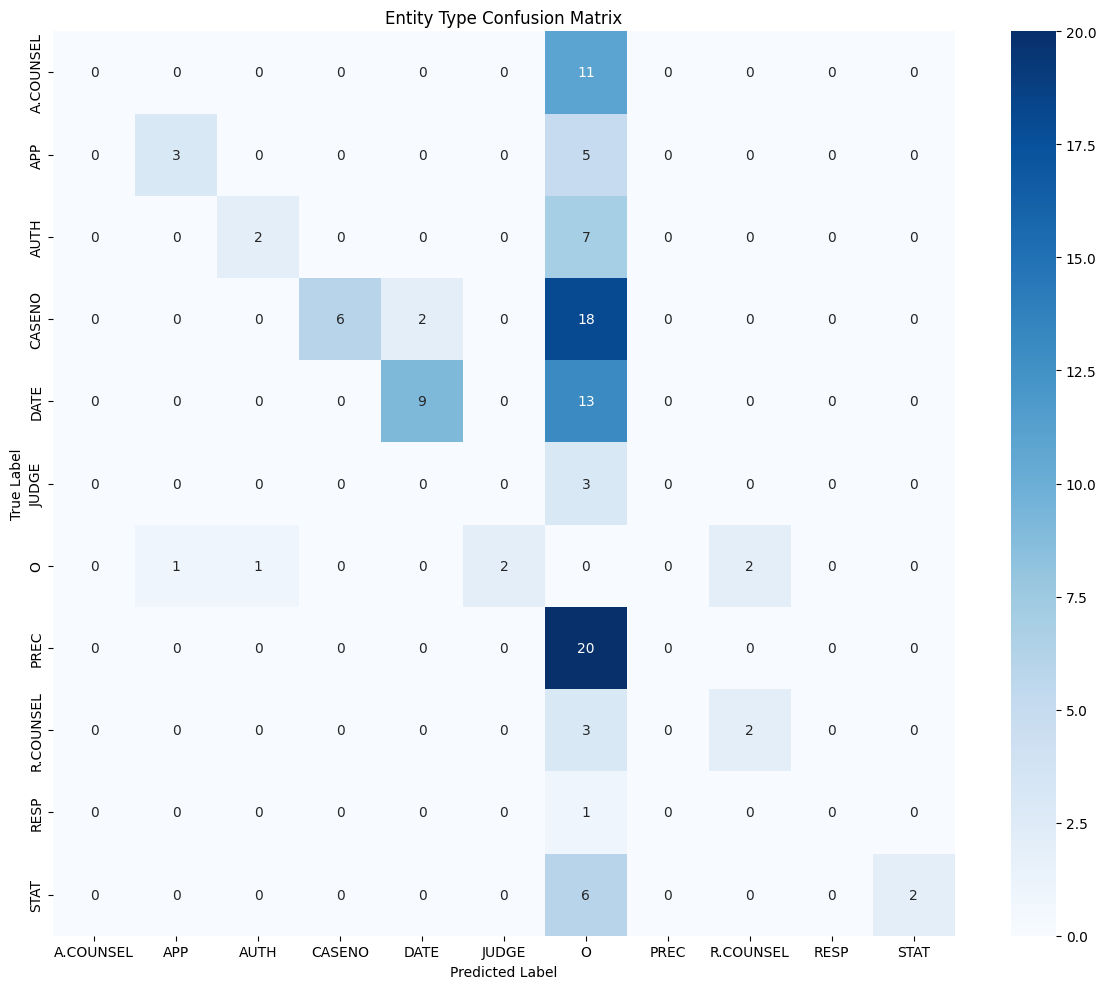


Entity recognition error analysis:


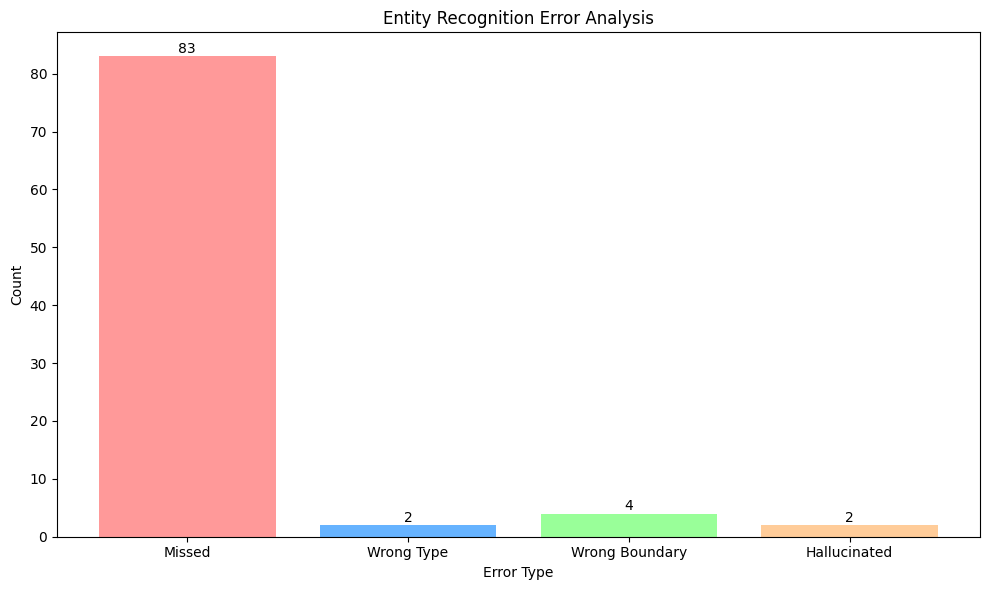

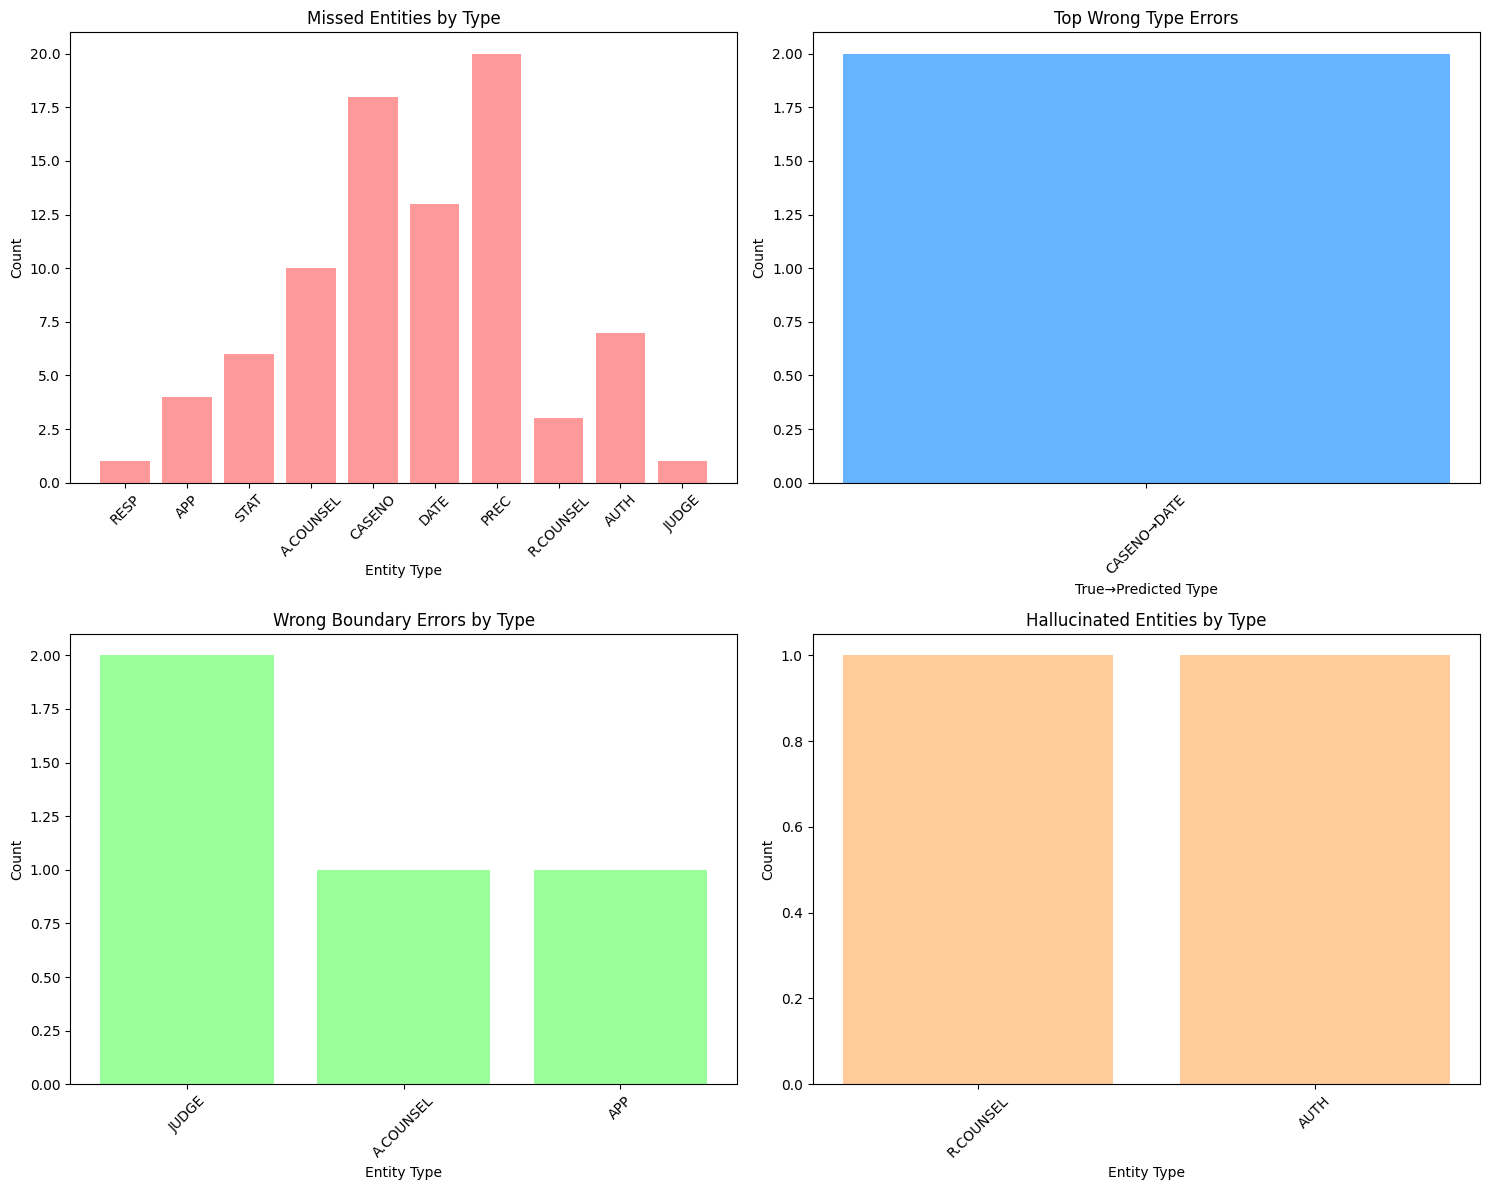


Testing on sample document from fold3:

Testing entity extraction on a sample document:

Sample document excerpt:
REPORTABLE IN THE SUPREME COURT OF INDIA CIVIL APPELLATE JURISDICTION CIVIL APPEAL NO.6580 OF 2008 ARISING OUT OF SPECIAL LEAVE PETITION (CIVIL) NO. 15449 OF 2004 ESSCO FABS PVT. LTD. & ANR. ... APPELLANTS VERSUS STATE OF HARYANA & ANR. ... RESPONDENTS WITH CIVIL APPEAL NO.6581 OF 2008 ARISING OUT OF SPECIAL LEAVE PETITION (CIVIL) NO. 15544 OF 2004 THE PANIPAT TEACHERS (RECOGNISED SCHOOLS)HOUSING CO-OPEATIVE SOCIETY LTD. & ANR. ... APPELLANTS VERSUS STATE OF HARYANA & ORS. ... RESPONDENTS WITH C...


Predicted entities visualization:


Found 19 entities:
1. COURT: 'SUPREME'
2. CASENO: 'CIVIL APPEAL NO.6580 OF 2008'
3. CASENO: 'SPECIAL LEAVE PETITION (CIVIL) NO. 15449 OF 2004'
4. RESP: 'STATE'
5. CASENO: 'CIVIL APPEAL NO.6581 OF 2008'
6. CASENO: 'SPECIAL LEAVE PETITION (CIVIL) NO. 15544 OF 2004'
7. AUTH: 'STATE OF HARYANA'
8. CASENO: 'CONTEMPT PETITION NO. 30 OF 2007'
9. CASENO: 'CIVIL APPEAL NO.6580 OF 2008'
10. CASENO: 'SPECIAL LEAVE PETITION (CIVIL) NO. 15449 OF 2004'
11. AUTH: 'STATE OF HARYANA'
12. DATE: 'April 02, 2004'
13. COURT: 'High Court'
14. CASENO: 'Civil Writ Petition Nos. 1853 of 2003 and 2077 of 2002'
15. AUTH: 'Government of Haryana'
16. AUTH: 'Government'
17. STAT: 'Land Acquisition Act, 1894'
18. DATE: 'December 15, 1982'
19. DATE: 'June 20, 1984'

Gold standard entities:


Found 87 entities:
1. COURT: 'SUPREME COURT OF INDIA'
2. CASENO: 'SPECIAL LEAVE PETITION (CIVIL) NO. 15449 OF 2004'
3. RESP: 'STATE OF HARYANA'
4. CASENO: 'SPECIAL LEAVE PETITION (CIVIL) NO. 15544 OF 2004'
5. APP: 'PANIPAT TEACHERS (RECOGNISED SCHOOLS)HOUSING CO-OPEATIVE SOCIETY LTD.'
6. RESP: 'STATE OF HARYANA'
7. CASENO: 'SPECIAL LEAVE PETITION (CIVIL) NO. 15449 OF 2004'
8. RESP: 'STATE OF HARYANA'
9. JUDGE: 'C.K. THAKKER'
10. DATE: 'April 02, 2004'
11. COURT: 'High Court of Punjab & Haryana'
12. CASENO: 'Civil Writ Petition Nos.'
13. APP: 'Essco Fabs Pvt. Ltd.'
14. APP: 'Essco'
15. AUTH: 'Haryana Urban Development Authority'
16. AUTH: 'HUDA'
17. DATE: 'December 15, 1982'
18. DATE: 'June 20, 1984'
19. APP: 'Essco'
20. DATE: 'June 6, 1991'
21. AUTH: 'Director, Town & Country Planning, Haryana'
22. DATE: 'September 5, 1991'
23. DATE: 'August 1, 2001'
24. AUTH: 'HUDA'
25. DATE: 'August 2, 2001'
26. CASENO: 'Civil Writ Petition No. 1853 of 2003'
27. COURT: 'High Court of Punjab & Haryana

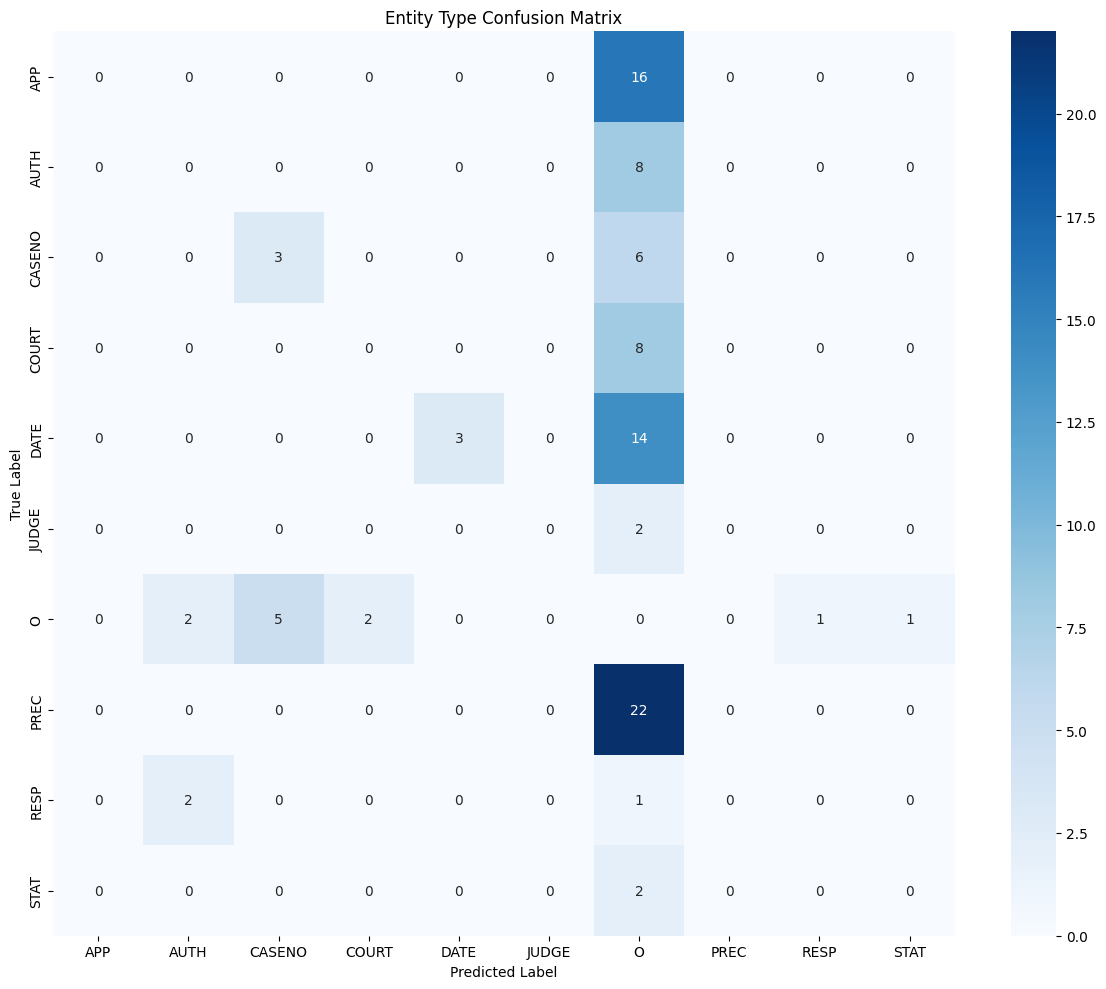


Entity recognition error analysis:


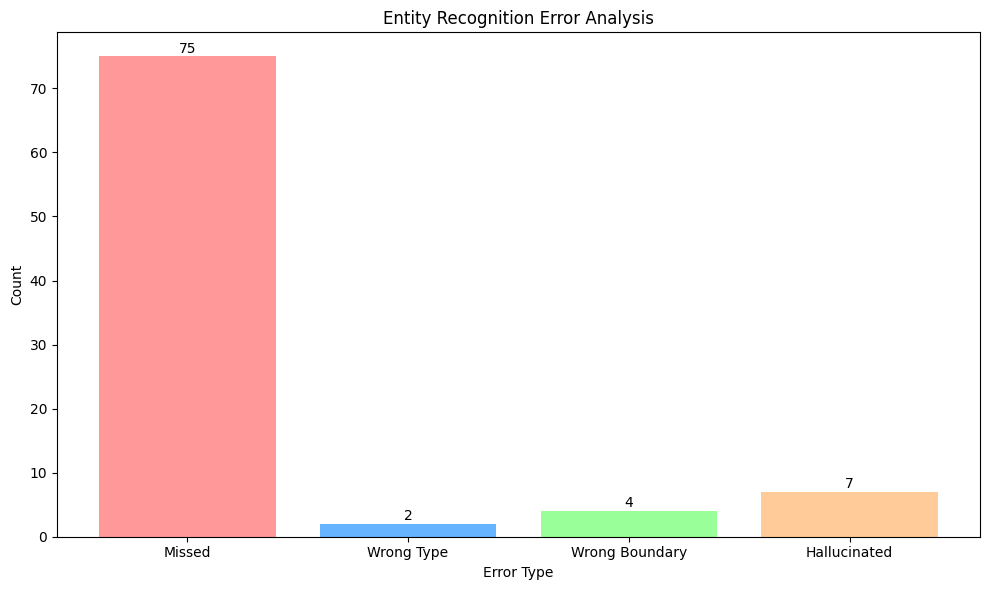

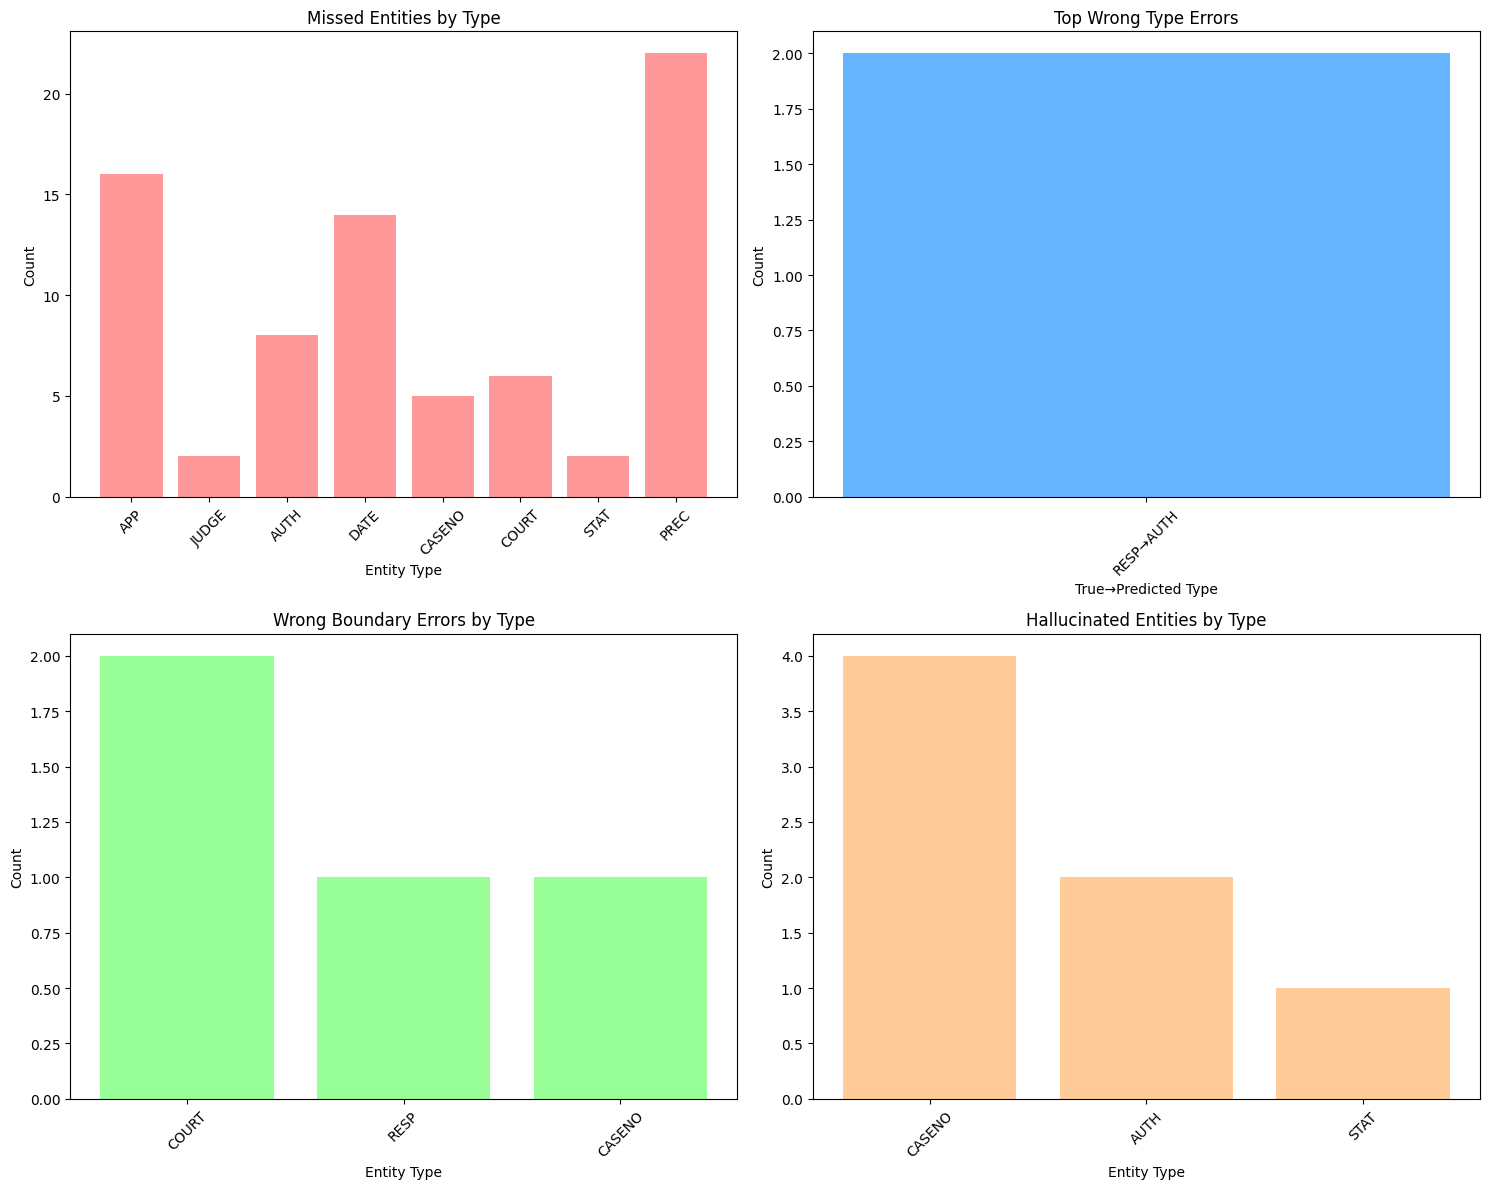

Cross-validation complete!


In [39]:
if __name__ == "__main__":
    best_model, cv_results = run_cross_validation()
    
    # Test on sample documents from each fold
    print("\nTesting on sample document from fold1:")
    predicted_entities1, true_entities1 = test_on_sample(best_model, sample_idx=0, fold_name="fold1")
    
    print("\nTesting on sample document from fold2:")
    predicted_entities2, true_entities2 = test_on_sample(best_model, sample_idx=0, fold_name="fold2")
    
    print("\nTesting on sample document from fold3:")
    predicted_entities3, true_entities3 = test_on_sample(best_model, sample_idx=0, fold_name="fold3")
    
    print("Cross-validation complete!")

## **Model : nlpaueb/legal-bert-base-uncased**

**Using a learning rate of `1e-4`, for the CRF configuration.**

In [39]:
# Update the model name in non_crf_config
crf_config["model_name"] = "nlpaueb/legal-bert-base-uncased"

print("CRF Config Model Name:", crf_config["model_name"])

CRF Config Model Name: nlpaueb/legal-bert-base-uncased


In [40]:
tokenizer = load_tokenizer(crf_config)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Tokenizer loaded for model: nlpaueb/legal-bert-base-uncased


In [41]:
for key, value in config.items():
    print(f"{key}: {value}")

max_length: 512
stride: 128
batch_size: 8
weight_decay: 0.01
epochs: 15
warmup_ratio: 0.1
early_stop_patience: 3
visualize_training: True
visualize_entities: True
visualize_confusion: True
problematic_entities: {'R.COUNSEL': 4.0, 'A.COUNSEL': 3.5, 'JUDGE': 3.0, 'WIT': 3.2, 'RESP': 2.3, 'APP': 1.8, 'CASENO': 1.4, 'AUTH': 1.4}
data_files: {'fold1': '/kaggle/input/legalcasedocuments/fold1.json', 'fold2': '/kaggle/input/legalcasedocuments/fold2.json', 'fold3': '/kaggle/input/legalcasedocuments/fold3.json'}
model_name: nlpaueb/legal-bert-base-uncased
use_crf: True
metrics_per_label: True
gradient_accumulation: 2
learning_rate: 0.0001
fp16: False
extra_transformer_layers: 2
transformer_nhead: 8
transformer_dim_feedforward: 3072
transformer_dropout: 0.1



Training on fold2, fold3 and validating on fold1

Created 1325 training samples and 639 validation samples


2025-04-28 10:52:31.449000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745837551.658631      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745837551.715511      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 1/15:
  Train Loss: 1466.2560
  Val   Loss: 493.3936
  Val   F1:   0.5298 (P: 0.5598, R: 0.5028)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9087, P=0.8940, R=0.9237, N=813
    PREC: F1=0.3592, P=0.3395, R=0.3814, N=624
    AUTH: F1=0.2723, P=0.3370, R=0.2285, N=534
    STAT: F1=0.6691, P=0.6413, R=0.6994, N=519
    COURT: F1=0.6073, P=0.5294, R=0.7121, N=455
  ↗ New best F1: 0.5298 (was 0.0000)


Epoch 2/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 2/15:
  Train Loss: 423.5067
  Val   Loss: 510.3095
  Val   F1:   0.5406 (P: 0.4966, R: 0.5930)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9401, P=0.9160, R=0.9656, N=813
    PREC: F1=0.3783, P=0.3721, R=0.3846, N=624
    AUTH: F1=0.3726, P=0.3636, R=0.3820, N=534
    STAT: F1=0.7254, P=0.6429, R=0.8324, N=519
    COURT: F1=0.6887, P=0.6324, R=0.7560, N=455
  ↗ New best F1: 0.5406 (was 0.5298)


Epoch 3/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 3/15:
  Train Loss: 308.3271
  Val   Loss: 495.9530
  Val   F1:   0.5083 (P: 0.5751, R: 0.4554)
  Per-type metrics (top 5 by support):
    DATE: F1=0.8748, P=0.9307, R=0.8253, N=813
    PREC: F1=0.4497, P=0.4905, R=0.4151, N=624
    AUTH: F1=0.3411, P=0.4215, R=0.2865, N=534
    STAT: F1=0.7477, P=0.7160, R=0.7823, N=519
    COURT: F1=0.6335, P=0.6527, R=0.6154, N=455
  ↘ No improvement (1/3)


Epoch 4/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 4/15:
  Train Loss: 251.5351
  Val   Loss: 452.3202
  Val   F1:   0.5802 (P: 0.5960, R: 0.5653)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9548, P=0.9479, R=0.9619, N=813
    PREC: F1=0.3097, P=0.2929, R=0.3285, N=624
    AUTH: F1=0.2411, P=0.4118, R=0.1704, N=534
    STAT: F1=0.7969, P=0.7226, R=0.8882, N=519
    COURT: F1=0.7130, P=0.6504, R=0.7890, N=455
  ↗ New best F1: 0.5802 (was 0.5406)


Epoch 5/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 5/15:
  Train Loss: 187.1609
  Val   Loss: 517.4913
  Val   F1:   0.5590 (P: 0.5387, R: 0.5808)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9550, P=0.9568, R=0.9533, N=813
    PREC: F1=0.4612, P=0.4708, R=0.4519, N=624
    AUTH: F1=0.3073, P=0.4167, R=0.2434, N=534
    STAT: F1=0.7193, P=0.6865, R=0.7553, N=519
    COURT: F1=0.7204, P=0.7053, R=0.7363, N=455
  ↘ No improvement (1/3)


Epoch 6/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 6/15:
  Train Loss: 146.7692
  Val   Loss: 506.2940
  Val   F1:   0.5992 (P: 0.6287, R: 0.5723)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9572, P=0.9514, R=0.9631, N=813
    PREC: F1=0.4134, P=0.4326, R=0.3958, N=624
    AUTH: F1=0.3286, P=0.4403, R=0.2622, N=534
    STAT: F1=0.7292, P=0.7169, R=0.7418, N=519
    COURT: F1=0.7289, P=0.6710, R=0.7978, N=455
  ↗ New best F1: 0.5992 (was 0.5802)


Epoch 7/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 7/15:
  Train Loss: 112.7536
  Val   Loss: 492.3550
  Val   F1:   0.5846 (P: 0.5982, R: 0.5716)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9616, P=0.9529, R=0.9705, N=813
    PREC: F1=0.4251, P=0.4064, R=0.4455, N=624
    AUTH: F1=0.3412, P=0.4302, R=0.2828, N=534
    STAT: F1=0.6772, P=0.6943, R=0.6609, N=519
    COURT: F1=0.6755, P=0.6271, R=0.7319, N=455
  ↘ No improvement (1/3)


Epoch 8/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 8/15:
  Train Loss: 83.6533
  Val   Loss: 609.3783
  Val   F1:   0.5724 (P: 0.5565, R: 0.5894)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9623, P=0.9519, R=0.9729, N=813
    PREC: F1=0.3328, P=0.3623, R=0.3077, N=624
    AUTH: F1=0.3734, P=0.3686, R=0.3783, N=534
    STAT: F1=0.6559, P=0.6117, R=0.7071, N=519
    COURT: F1=0.7257, P=0.6978, R=0.7560, N=455
  ↘ No improvement (2/3)


Epoch 9/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 9/15:
  Train Loss: 62.7405
  Val   Loss: 636.1105
  Val   F1:   0.5857 (P: 0.6065, R: 0.5663)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9570, P=0.9427, R=0.9717, N=813
    PREC: F1=0.3531, P=0.3755, R=0.3333, N=624
    AUTH: F1=0.3041, P=0.3814, R=0.2528, N=534
    STAT: F1=0.6861, P=0.6922, R=0.6802, N=519
    COURT: F1=0.7403, P=0.7955, R=0.6923, N=455
  ↘ No improvement (3/3)
Early stopping at epoch 9


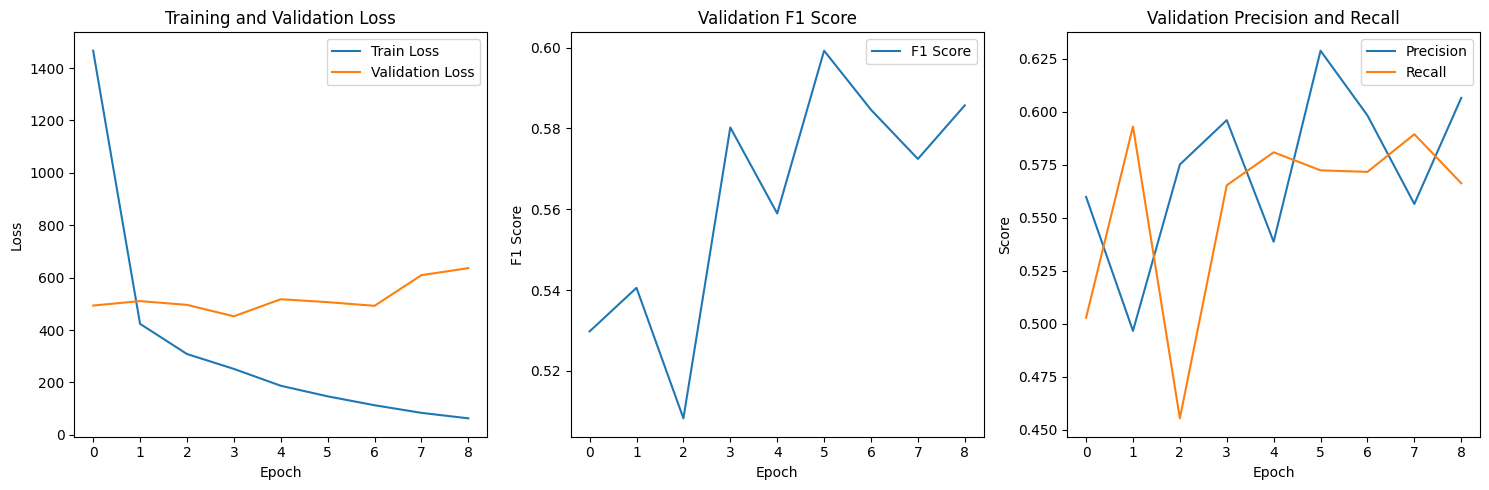


Final evaluation on validation set:


Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
  F1:        0.5992
  Precision: 0.6287
  Recall:    0.5723

Training on fold1, fold3 and validating on fold2

Created 1320 training samples and 644 validation samples


Epoch 1/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 1/15:
  Train Loss: 1472.1266
  Val   Loss: 564.3582
  Val   F1:   0.4291 (P: 0.5400, R: 0.3561)
  Per-type metrics (top 5 by support):
    DATE: F1=0.8770, P=0.8609, R=0.8937, N=762
    STAT: F1=0.3105, P=0.3456, R=0.2818, N=731
    PREC: F1=0.0638, P=0.0671, R=0.0608, N=559
    COURT: F1=0.7899, P=0.7464, R=0.8387, N=558
    AUTH: F1=0.0165, P=0.2500, R=0.0085, N=468
  ↗ New best F1: 0.4291 (was 0.0000)


Epoch 2/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 2/15:
  Train Loss: 415.8630
  Val   Loss: 563.7906
  Val   F1:   0.5543 (P: 0.7168, R: 0.4519)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9338, P=0.9425, R=0.9252, N=762
    STAT: F1=0.5794, P=0.8411, R=0.4419, N=731
    PREC: F1=0.4152, P=0.4101, R=0.4204, N=559
    COURT: F1=0.7745, P=0.7860, R=0.7634, N=558
    AUTH: F1=0.5476, P=0.6084, R=0.4979, N=468
  ↗ New best F1: 0.5543 (was 0.4291)


Epoch 3/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 3/15:
  Train Loss: 311.8561
  Val   Loss: 428.1458
  Val   F1:   0.6230 (P: 0.6079, R: 0.6388)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9480, P=0.9634, R=0.9331, N=762
    STAT: F1=0.7627, P=0.6956, R=0.8440, N=731
    PREC: F1=0.4768, P=0.4202, R=0.5510, N=559
    COURT: F1=0.8067, P=0.7982, R=0.8154, N=558
    AUTH: F1=0.5511, P=0.5955, R=0.5128, N=468
  ↗ New best F1: 0.6230 (was 0.5543)


Epoch 4/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 4/15:
  Train Loss: 239.5518
  Val   Loss: 471.0869
  Val   F1:   0.6381 (P: 0.6580, R: 0.6193)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9364, P=0.9358, R=0.9370, N=762
    STAT: F1=0.7887, P=0.7762, R=0.8016, N=731
    PREC: F1=0.4791, P=0.4057, R=0.5850, N=559
    COURT: F1=0.7588, P=0.7865, R=0.7330, N=558
    AUTH: F1=0.5510, P=0.6835, R=0.4615, N=468
  ↗ New best F1: 0.6381 (was 0.6230)


Epoch 5/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 5/15:
  Train Loss: 186.9466
  Val   Loss: 478.7072
  Val   F1:   0.6075 (P: 0.5785, R: 0.6395)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9381, P=0.9226, R=0.9541, N=762
    STAT: F1=0.7430, P=0.7237, R=0.7633, N=731
    PREC: F1=0.5152, P=0.4335, R=0.6351, N=559
    COURT: F1=0.8239, P=0.8440, R=0.8047, N=558
    AUTH: F1=0.5258, P=0.6886, R=0.4252, N=468
  ↘ No improvement (1/3)


Epoch 6/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 6/15:
  Train Loss: 137.8461
  Val   Loss: 533.2709
  Val   F1:   0.6058 (P: 0.6209, R: 0.5915)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9416, P=0.9319, R=0.9514, N=762
    STAT: F1=0.7466, P=0.7957, R=0.7031, N=731
    PREC: F1=0.4367, P=0.4266, R=0.4472, N=559
    COURT: F1=0.8069, P=0.8127, R=0.8011, N=558
    AUTH: F1=0.4219, P=0.5204, R=0.3547, N=468
  ↘ No improvement (2/3)


Epoch 7/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 7/15:
  Train Loss: 106.7105
  Val   Loss: 589.2393
  Val   F1:   0.6270 (P: 0.6041, R: 0.6517)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9449, P=0.9334, R=0.9567, N=762
    STAT: F1=0.7656, P=0.7584, R=0.7729, N=731
    PREC: F1=0.4581, P=0.4234, R=0.4991, N=559
    COURT: F1=0.8234, P=0.8279, R=0.8190, N=558
    AUTH: F1=0.5083, P=0.5722, R=0.4573, N=468
  ↘ No improvement (3/3)
Early stopping at epoch 7


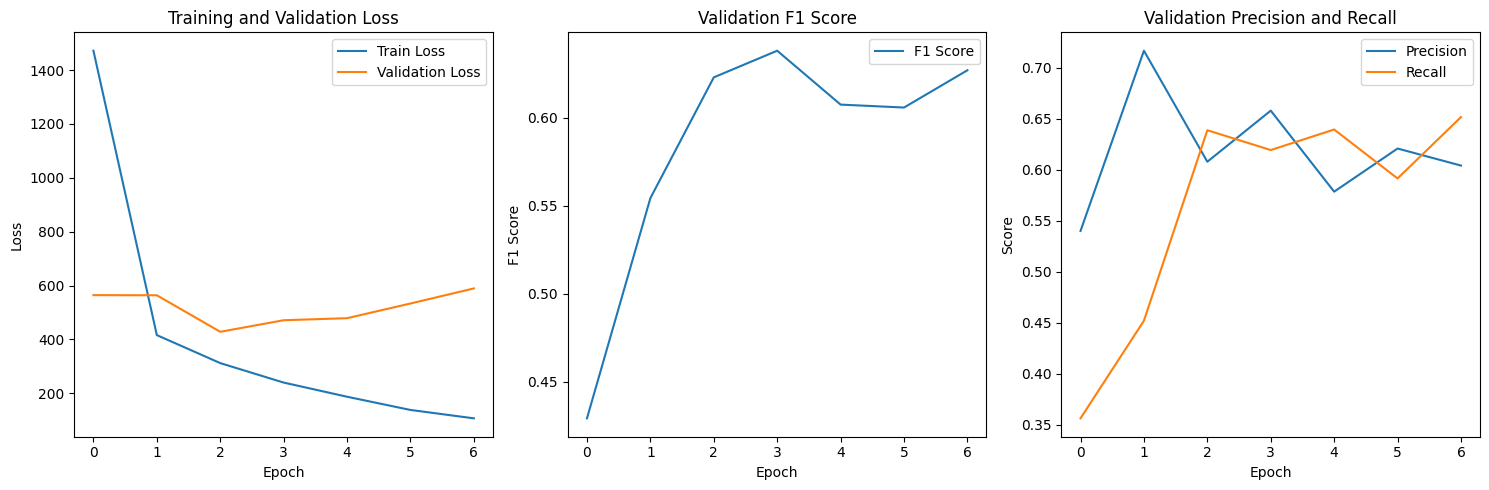


Final evaluation on validation set:


Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
  F1:        0.6381
  Precision: 0.6580
  Recall:    0.6193

Training on fold1, fold2 and validating on fold3

Created 1283 training samples and 681 validation samples


Epoch 1/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 681 documents
Epoch 1/15:
  Train Loss: 1663.5274
  Val   Loss: 468.6052
  Val   F1:   0.5657 (P: 0.5946, R: 0.5395)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7342, P=0.6646, R=0.8201, N=795
    DATE: F1=0.8901, P=0.8950, R=0.8853, N=741
    PREC: F1=0.1343, P=0.1928, R=0.1031, N=621
    COURT: F1=0.7936, P=0.7929, R=0.7943, N=559
    CASENO: F1=0.5241, P=0.5821, R=0.4766, N=342
  ↗ New best F1: 0.5657 (was 0.0000)


Epoch 2/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 681 documents
Epoch 2/15:
  Train Loss: 447.9620
  Val   Loss: 426.9730
  Val   F1:   0.5804 (P: 0.5946, R: 0.5669)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7192, P=0.6797, R=0.7635, N=795
    DATE: F1=0.8345, P=0.8608, R=0.8097, N=741
    PREC: F1=0.4864, P=0.4580, R=0.5185, N=621
    COURT: F1=0.6736, P=0.7195, R=0.6333, N=559
    CASENO: F1=0.5851, P=0.6217, R=0.5526, N=342
  ↗ New best F1: 0.5804 (was 0.5657)


Epoch 3/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 681 documents
Epoch 3/15:
  Train Loss: 319.4439
  Val   Loss: 400.3141
  Val   F1:   0.5887 (P: 0.5960, R: 0.5816)
  Per-type metrics (top 5 by support):
    STAT: F1=0.6872, P=0.6484, R=0.7308, N=795
    DATE: F1=0.9247, P=0.9388, R=0.9109, N=741
    PREC: F1=0.4492, P=0.4610, R=0.4380, N=621
    COURT: F1=0.7706, P=0.7025, R=0.8533, N=559
    CASENO: F1=0.5983, P=0.7382, R=0.5029, N=342
  ↗ New best F1: 0.5887 (was 0.5804)


Epoch 4/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 681 documents
Epoch 4/15:
  Train Loss: 248.0427
  Val   Loss: 395.8479
  Val   F1:   0.6292 (P: 0.6060, R: 0.6544)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7456, P=0.6809, R=0.8239, N=795
    DATE: F1=0.9453, P=0.9353, R=0.9555, N=741
    PREC: F1=0.4600, P=0.4290, R=0.4960, N=621
    COURT: F1=0.8190, P=0.7769, R=0.8658, N=559
    CASENO: F1=0.6435, P=0.6656, R=0.6228, N=342
  ↗ New best F1: 0.6292 (was 0.5887)


Epoch 5/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 681 documents
Epoch 5/15:
  Train Loss: 181.2260
  Val   Loss: 436.8751
  Val   F1:   0.6023 (P: 0.5783, R: 0.6284)
  Per-type metrics (top 5 by support):
    STAT: F1=0.5670, P=0.5171, R=0.6277, N=795
    DATE: F1=0.9467, P=0.9354, R=0.9582, N=741
    PREC: F1=0.5835, P=0.5472, R=0.6248, N=621
    COURT: F1=0.7148, P=0.6217, R=0.8408, N=559
    CASENO: F1=0.6635, P=0.7298, R=0.6082, N=342
  ↘ No improvement (1/3)


Epoch 6/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 681 documents
Epoch 6/15:
  Train Loss: 148.3477
  Val   Loss: 468.1488
  Val   F1:   0.6665 (P: 0.6776, R: 0.6558)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7647, P=0.7135, R=0.8239, N=795
    DATE: F1=0.9466, P=0.9485, R=0.9447, N=741
    PREC: F1=0.5910, P=0.5714, R=0.6119, N=621
    COURT: F1=0.8040, P=0.7504, R=0.8658, N=559
    CASENO: F1=0.6216, P=0.6918, R=0.5643, N=342
  ↗ New best F1: 0.6665 (was 0.6292)


Epoch 7/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 681 documents
Epoch 7/15:
  Train Loss: 111.4462
  Val   Loss: 437.5068
  Val   F1:   0.6543 (P: 0.6469, R: 0.6617)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7702, P=0.7165, R=0.8327, N=795
    DATE: F1=0.9539, P=0.9591, R=0.9487, N=741
    PREC: F1=0.5355, P=0.4952, R=0.5829, N=621
    COURT: F1=0.7896, P=0.7429, R=0.8426, N=559
    CASENO: F1=0.6553, P=0.6987, R=0.6170, N=342
  ↘ No improvement (1/3)


Epoch 8/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 681 documents
Epoch 8/15:
  Train Loss: 81.9264
  Val   Loss: 487.8897
  Val   F1:   0.6427 (P: 0.6222, R: 0.6646)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7438, P=0.6618, R=0.8491, N=795
    DATE: F1=0.9506, P=0.9538, R=0.9474, N=741
    PREC: F1=0.5004, P=0.4968, R=0.5040, N=621
    COURT: F1=0.7861, P=0.7648, R=0.8086, N=559
    CASENO: F1=0.6358, P=0.6286, R=0.6433, N=342
  ↘ No improvement (2/3)


Epoch 9/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 681 documents
Epoch 9/15:
  Train Loss: 61.4446
  Val   Loss: 543.8022
  Val   F1:   0.6654 (P: 0.6710, R: 0.6598)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7559, P=0.7114, R=0.8063, N=795
    DATE: F1=0.9327, P=0.9497, R=0.9163, N=741
    PREC: F1=0.5652, P=0.5457, R=0.5862, N=621
    COURT: F1=0.7928, P=0.7985, R=0.7871, N=559
    CASENO: F1=0.6626, P=0.6968, R=0.6316, N=342
  ↘ No improvement (3/3)
Early stopping at epoch 9


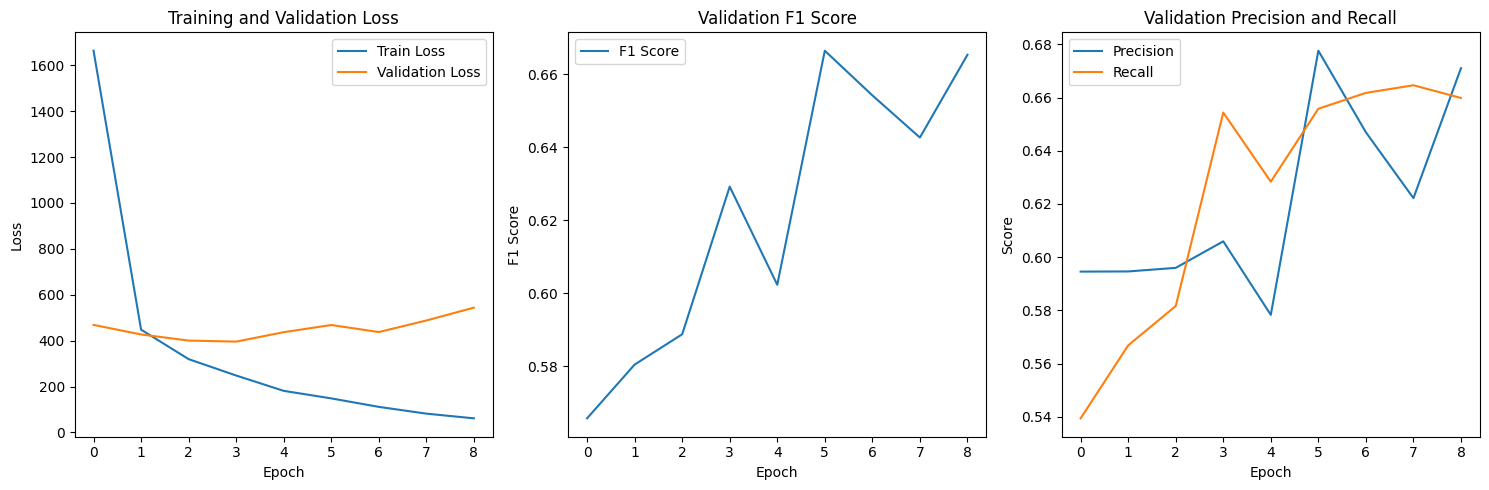


Final evaluation on validation set:


Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 681 documents
  F1:        0.6665
  Precision: 0.6776
  Recall:    0.6558

Cross-validation results:
  Fold 1: F1 = 0.5992
  Fold 2: F1 = 0.6381
  Fold 3: F1 = 0.6665
  Average: F1 = 0.6346, Precision = 0.6548, Recall = 0.6158


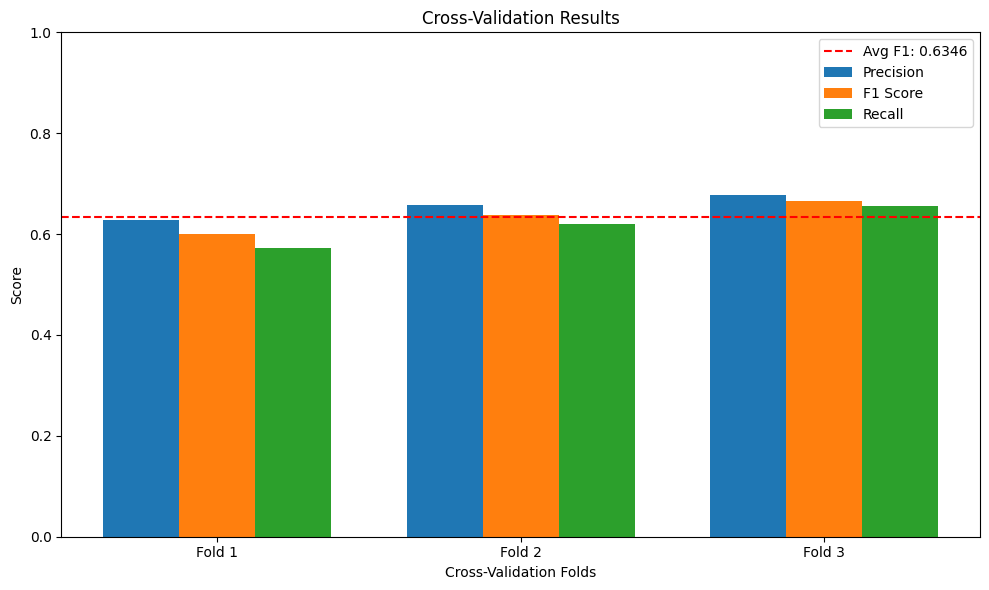


Analyzing entity distribution across the dataset:


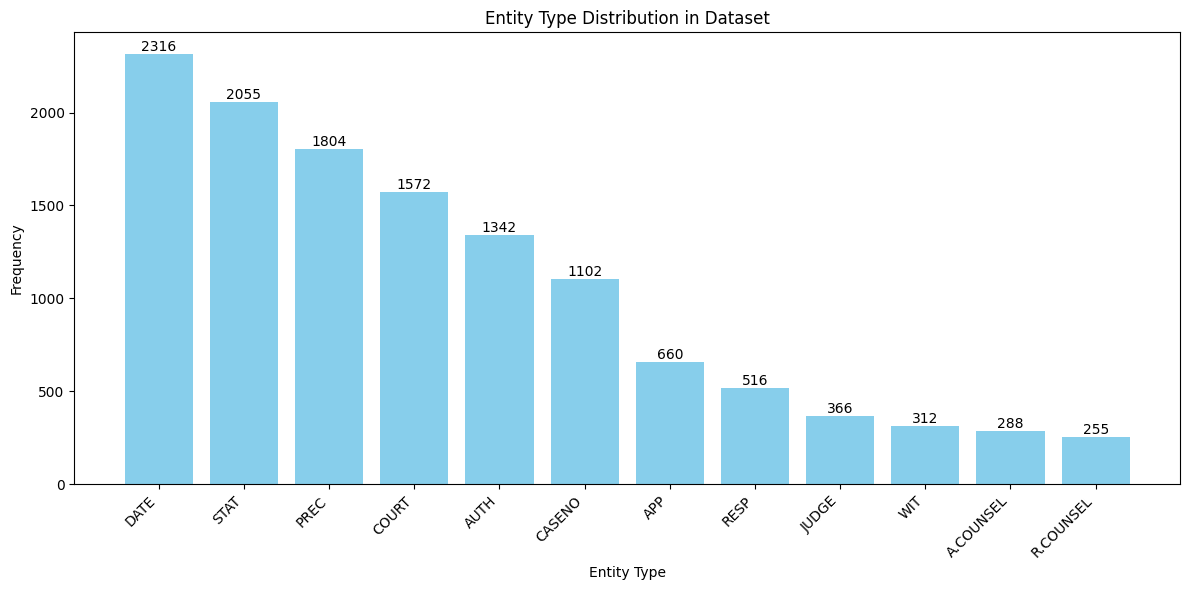

Best model saved to best_legal_ner_model_nlpaueb_legal_bert_base_uncased_CRF_true.pt
Model configuration saved to model_config_nlpaueb_legal_bert_base_uncased_CRF_true.json

Testing on sample document from fold2:

Testing entity extraction on a sample document:

Sample document excerpt:
IN THE HIGH COURT AT CALCUTTA CIVIL REVISIONAL JURISDICTION APPELLATE SIDE Before: The Hon'ble Justice Hiranmay Bhattacharyya C.O. 3346 of 2018 The Kolkata Municipal Corporation Vs. Smt. Kajari Banerjee For the petitioner : Mr. Alok Kr. Ghosh, Mr. S.K. Debnath..... advocates For the opposite party : Mr. R.N. Chakraborty, Mr. M. Ahmed............ advocates Heard on : 18.12.2020 Judgment on : 22.12.2020 Hiranmay Bhattacharyya, J.: This application under Article 227 of the Constitution of India is ...


Predicted entities visualization:


Found 33 entities:
1. JUDGE: 'Hiranmay Bhattacharyya'
2. CASENO: 'C.O. 3346 of 2018'
3. APP: 'Kolkata Municipal Corporation'
4. RESP: 'Smt. Kajari Banerjee'
5. A.COUNSEL: 'Alok Kr. Ghosh'
6. R.COUNSEL: 'S.'
7. A.COUNSEL: 'K. Debnath'
8. A.COUNSEL: 'R.N. Chakraborty'
9. R.COUNSEL: 'M. Ahmed'
10. DATE: '18.12.2020'
11. DATE: '22.12.2020'
12. JUDGE: 'Hiranmay Bhattacharyya,'
13. STAT: 'Constitution of India'
14. APP: 'Kolkata Municipal Corporation'
15. DATE: 'March 27, 2018'
16. AUTH: 'Municipal Assessment Tribunal'
17. APP: 'Kolkata Municipal Corporation'
18. CASENO: 'M.A. Appeal no. 947 of 2012'
19. DATE: 'March 24, 2012'
20. DATE: 'fourth quarter of 2009-10'
21. CASENO: 'M.A. Appeal no. 947 of 2012'
22. DATE: 'March 24, 2012'
23. AUTH: 'Municipal Assessment Tribunal'
24. DATE: 'February 16, 2015'
25. APP: 'Kolkata Municipal Corporation'
26. DATE: 'February 16, 2015'
27. STAT: 'Constitution of India'
28. CASENO: 'C.O. no. 2623 of 2017'
29. DATE: 'December 18, 2017'
30. CASENO: 'Civil Or

Found 113 entities:
1. JUDGE: 'Hiranmay Bhattacharyya'
2. CASENO: 'C.O. 3346 of 2018'
3. APP: 'Kolkata Municipal Corporation'
4. RESP: 'Smt. Kajari Banerjee'
5. A.COUNSEL: 'Ghosh'
6. R.COUNSEL: 'R.N. Chakraborty'
7. R.COUNSEL: 'M. Ahmed'
8. CASENO: '18.12.2020'
9. CASENO: '22.12.2020'
10. JUDGE: 'Hiranmay Bhattacharyya'
11. STAT: 'Constitution of India'
12. APP: 'Kolkata Municipal Corporation'
13. DATE: 'March 27, 2018'
14. AUTH: 'Municipal Assessment Tribunal'
15. APP: 'Kolkata Municipal Corporation'
16. CASENO: 'M.A. Appeal no. 947 of 2012'
17. DATE: 'March 24, 2012'
18. DATE: 'fourth quarter of 2009-10'
19. CASENO: 'M.A. Appeal no. 947 of 2012'
20. DATE: 'March 24, 2012'
21. AUTH: 'Municipal Assessment Tribunal'
22. DATE: 'February 16, 2015'
23. APP: 'Kolkata Municipal Corporation'
24. DATE: 'February 16, 2015'
25. STAT: 'Constitution of India'
26. CASENO: 'C.O. no. 2623 of 2017'
27. DATE: 'December 18, 2017'
28. CASENO: 'Civil Order No. 2623 of 2017'
29. DATE: 'February 16, 2015'
3

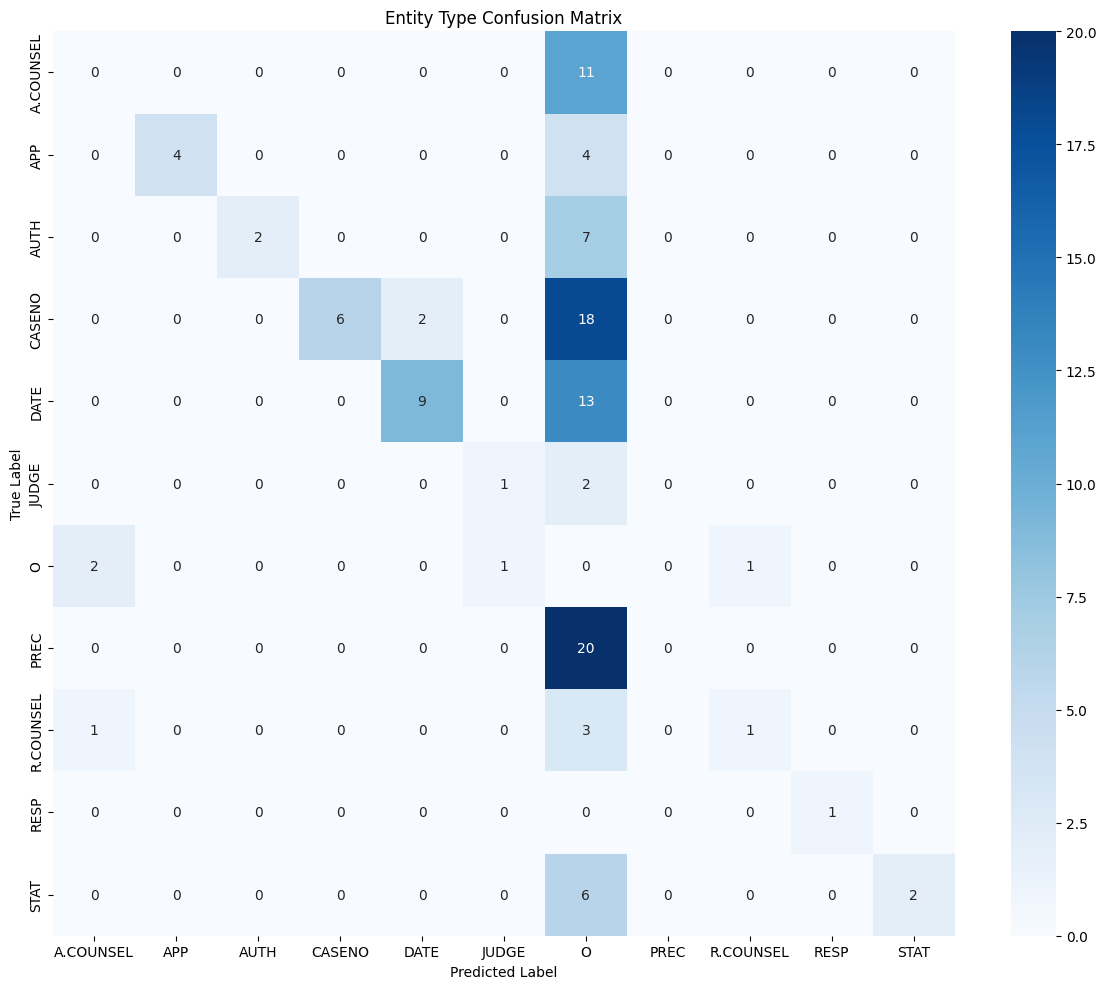


Entity recognition error analysis:


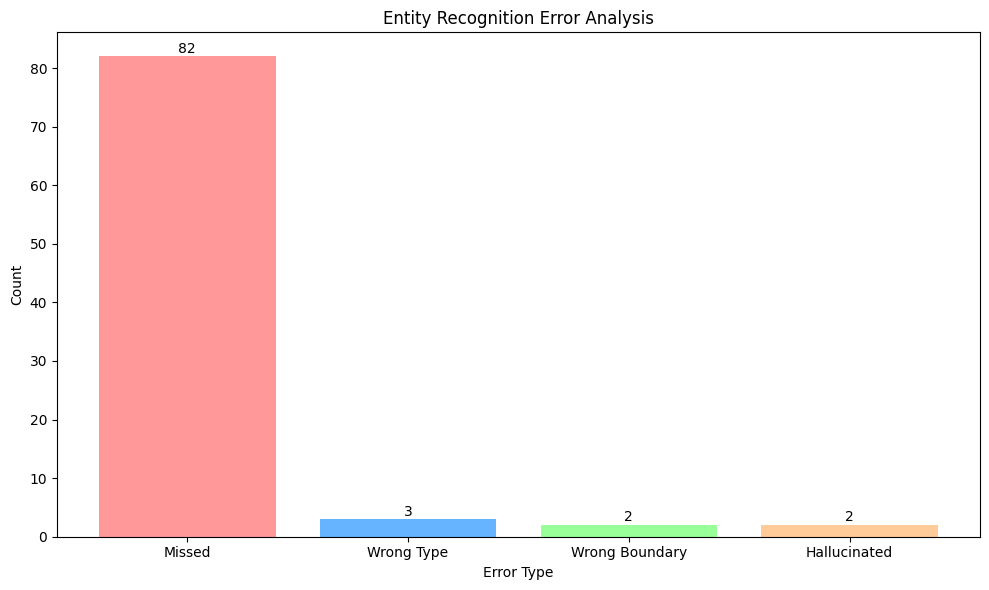

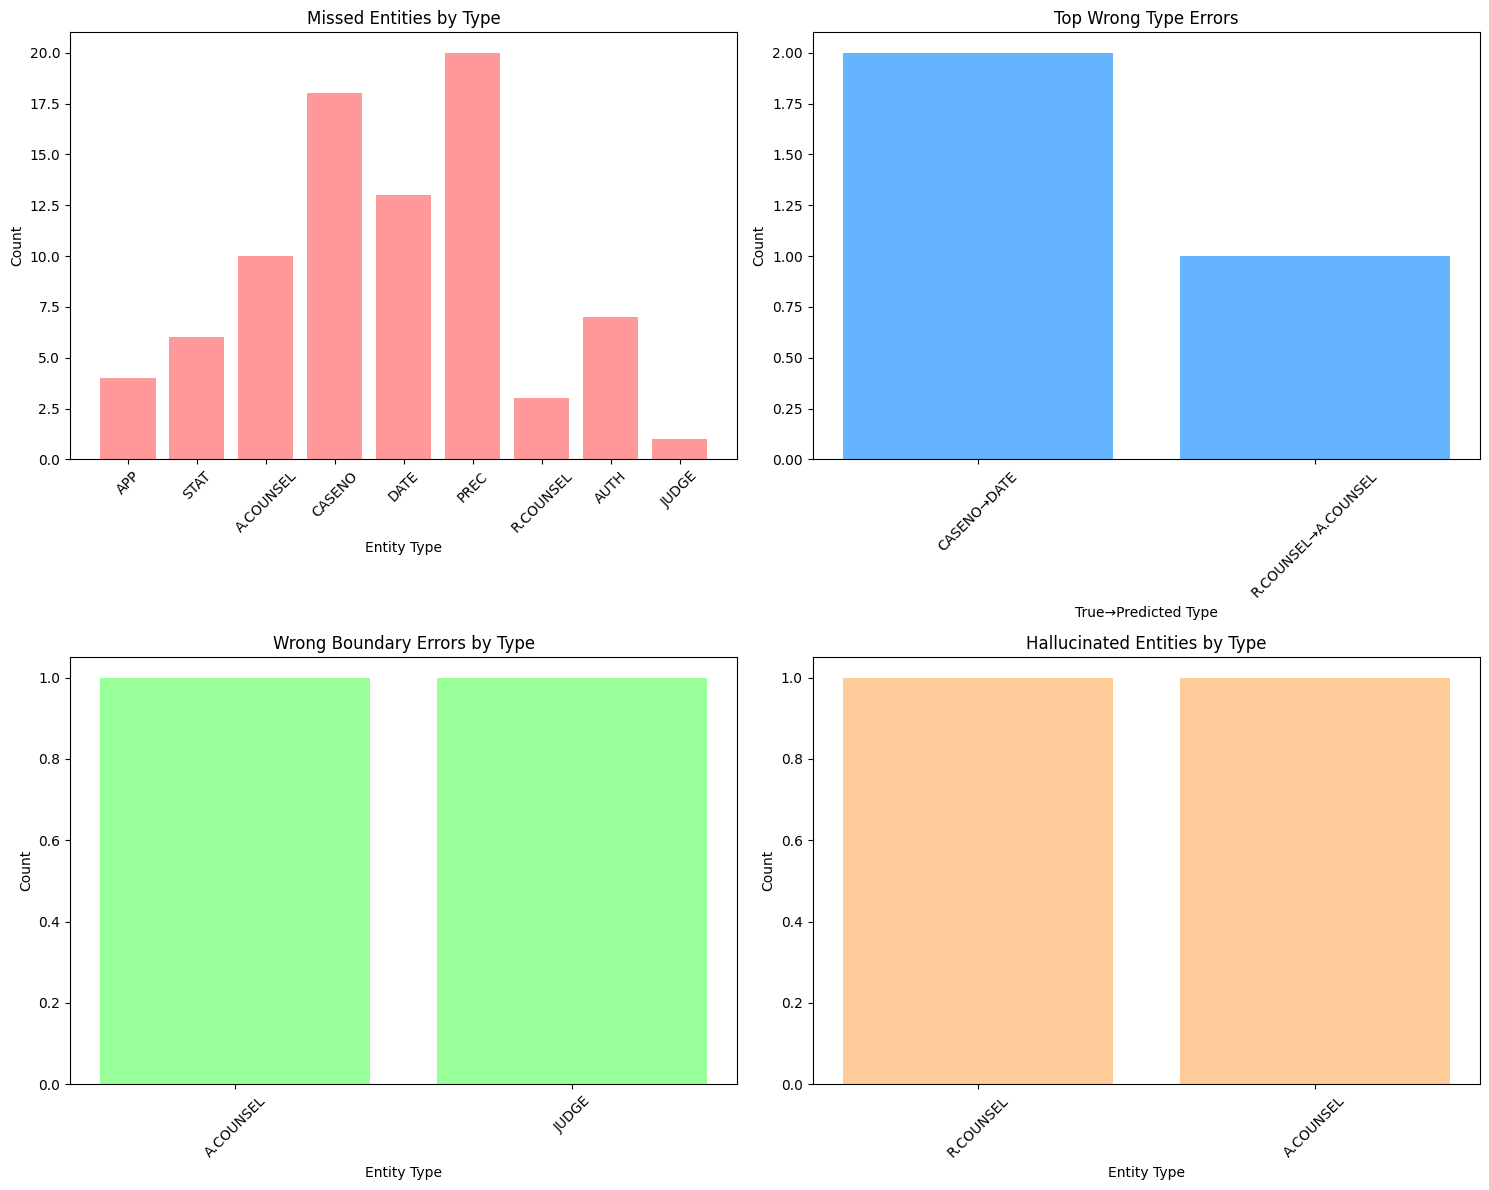

Cross-validation complete!


In [42]:
if __name__ == "__main__":
    best_model, cv_results = run_cross_validation()
    
    # Test on sample documents from fold 2    
    print("\nTesting on sample document from fold2:")
    predicted_entities2, true_entities2 = test_on_sample(best_model, sample_idx=0, fold_name="fold2")
    
    print("Cross-validation complete!")

## **Model : law-ai/InCaseLawBERT**

**Using a learning rate of `1e-4`, for the CRF configuration.**

In [45]:
# Update the model name in non_crf_config
crf_config["model_name"] = "law-ai/InCaseLawBERT"

print("CRF Config Model Name:", crf_config["model_name"])

CRF Config Model Name: law-ai/InCaseLawBERT


In [46]:
tokenizer = load_tokenizer(crf_config)

tokenizer_config.json:   0%|          | 0.00/343 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Tokenizer loaded for model: law-ai/InCaseLawBERT


In [47]:
for key, value in config.items():
    print(f"{key}: {value}")

max_length: 512
stride: 128
batch_size: 8
weight_decay: 0.01
epochs: 15
warmup_ratio: 0.1
early_stop_patience: 3
visualize_training: True
visualize_entities: True
visualize_confusion: True
problematic_entities: {'R.COUNSEL': 4.0, 'A.COUNSEL': 3.5, 'JUDGE': 3.0, 'WIT': 3.2, 'RESP': 2.3, 'APP': 1.8, 'CASENO': 1.4, 'AUTH': 1.4}
data_files: {'fold1': '/kaggle/input/legalcasedocuments/fold1.json', 'fold2': '/kaggle/input/legalcasedocuments/fold2.json', 'fold3': '/kaggle/input/legalcasedocuments/fold3.json'}
model_name: law-ai/InCaseLawBERT
use_crf: True
metrics_per_label: True
gradient_accumulation: 2
learning_rate: 0.0001
fp16: False
extra_transformer_layers: 2
transformer_nhead: 8
transformer_dim_feedforward: 3072
transformer_dropout: 0.1



Training on fold2, fold3 and validating on fold1

Created 1335 training samples and 643 validation samples


config.json:   0%|          | 0.00/861 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/534M [00:00<?, ?B/s]

Epoch 1/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/534M [00:00<?, ?B/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 1/15:
  Train Loss: 1251.4908
  Val   Loss: 558.2809
  Val   F1:   0.4778 (P: 0.6153, R: 0.3905)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9126, P=0.9006, R=0.9250, N=813
    PREC: F1=0.3549, P=0.4192, R=0.3077, N=624
    AUTH: F1=0.0067, P=0.0328, R=0.0037, N=534
    STAT: F1=0.0033, P=0.0111, R=0.0019, N=519
    COURT: F1=0.6567, P=0.6875, R=0.6286, N=455
  ↗ New best F1: 0.4778 (was 0.0000)


Epoch 2/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 2/15:
  Train Loss: 391.5731
  Val   Loss: 479.6936
  Val   F1:   0.5436 (P: 0.5442, R: 0.5429)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9188, P=0.9056, R=0.9323, N=813
    PREC: F1=0.1213, P=0.1597, R=0.0978, N=624
    AUTH: F1=0.3724, P=0.3704, R=0.3745, N=534
    STAT: F1=0.7296, P=0.7367, R=0.7225, N=519
    COURT: F1=0.6903, P=0.6949, R=0.6857, N=455
  ↗ New best F1: 0.5436 (was 0.4778)


Epoch 3/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 3/15:
  Train Loss: 284.1394
  Val   Loss: 406.1660
  Val   F1:   0.5971 (P: 0.5692, R: 0.6278)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9314, P=0.8965, R=0.9692, N=813
    PREC: F1=0.4044, P=0.4263, R=0.3846, N=624
    AUTH: F1=0.4062, P=0.3744, R=0.4438, N=534
    STAT: F1=0.7679, P=0.6832, R=0.8767, N=519
    COURT: F1=0.7143, P=0.7256, R=0.7033, N=455
  ↗ New best F1: 0.5971 (was 0.5436)


Epoch 4/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 4/15:
  Train Loss: 219.5980
  Val   Loss: 402.8592
  Val   F1:   0.5705 (P: 0.5508, R: 0.5915)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9376, P=0.9146, R=0.9619, N=813
    PREC: F1=0.3883, P=0.3311, R=0.4696, N=624
    AUTH: F1=0.4825, P=0.5020, R=0.4644, N=534
    STAT: F1=0.7223, P=0.7360, R=0.7091, N=519
    COURT: F1=0.5736, P=0.5103, R=0.6549, N=455
  ↘ No improvement (1/3)


Epoch 5/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 5/15:
  Train Loss: 171.1309
  Val   Loss: 406.5584
  Val   F1:   0.5658 (P: 0.5240, R: 0.6149)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9141, P=0.9322, R=0.8967, N=813
    PREC: F1=0.4223, P=0.3939, R=0.4551, N=624
    AUTH: F1=0.3061, P=0.3476, R=0.2734, N=534
    STAT: F1=0.7583, P=0.6950, R=0.8343, N=519
    COURT: F1=0.7537, P=0.7349, R=0.7736, N=455
  ↘ No improvement (2/3)


Epoch 6/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
Epoch 6/15:
  Train Loss: 130.5439
  Val   Loss: 478.7073
  Val   F1:   0.5779 (P: 0.6085, R: 0.5502)
  Per-type metrics (top 5 by support):
    DATE: F1=0.8730, P=0.8932, R=0.8536, N=813
    PREC: F1=0.3867, P=0.3527, R=0.4279, N=624
    AUTH: F1=0.3473, P=0.4243, R=0.2940, N=534
    STAT: F1=0.7334, P=0.7327, R=0.7341, N=519
    COURT: F1=0.6933, P=0.8012, R=0.6110, N=455
  ↘ No improvement (3/3)
Early stopping at epoch 6


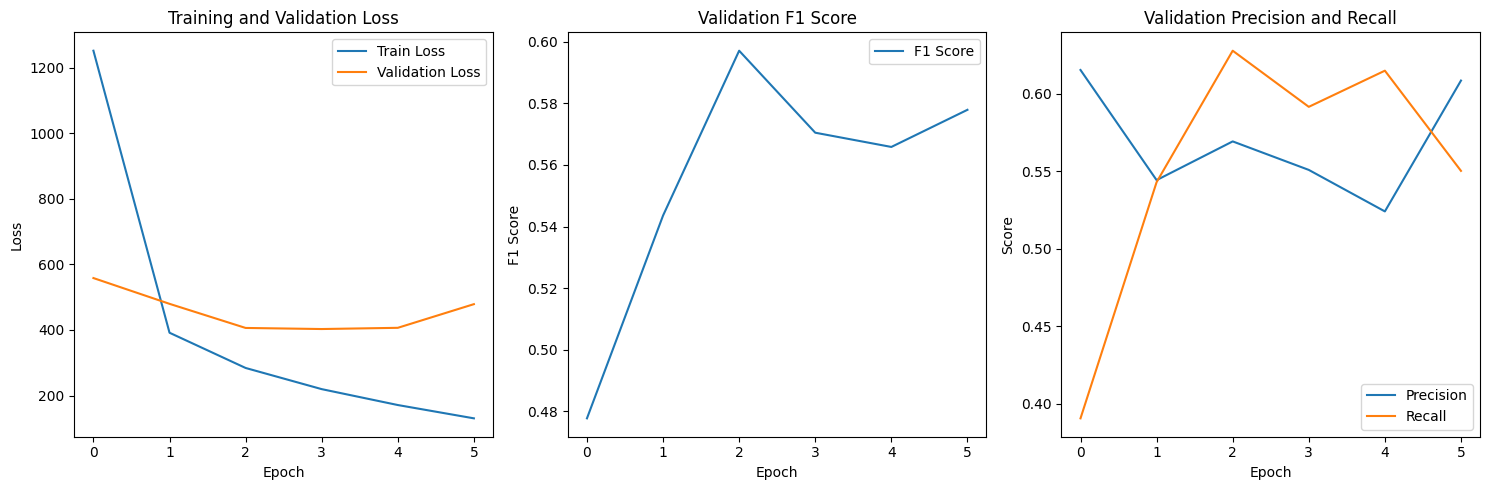


Final evaluation on validation set:


Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 643 documents
  F1:        0.5971
  Precision: 0.5692
  Recall:    0.6278

Training on fold1, fold3 and validating on fold2

Created 1330 training samples and 648 validation samples


Epoch 1/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 1/15:
  Train Loss: 1454.1695
  Val   Loss: 474.0717
  Val   F1:   0.4619 (P: 0.4748, R: 0.4498)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9090, P=0.9072, R=0.9108, N=762
    STAT: F1=0.4316, P=0.4157, R=0.4487, N=731
    PREC: F1=0.2697, P=0.2565, R=0.2844, N=559
    COURT: F1=0.6937, P=0.6150, R=0.7957, N=558
    AUTH: F1=0.2462, P=0.6154, R=0.1538, N=468
  ↗ New best F1: 0.4619 (was 0.0000)


Epoch 2/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 2/15:
  Train Loss: 387.8358
  Val   Loss: 494.9934
  Val   F1:   0.5554 (P: 0.6063, R: 0.5123)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9218, P=0.9083, R=0.9357, N=762
    STAT: F1=0.7144, P=0.6811, R=0.7510, N=731
    PREC: F1=0.1798, P=0.1846, R=0.1753, N=559
    COURT: F1=0.7876, P=0.7813, R=0.7939, N=558
    AUTH: F1=0.2222, P=0.5926, R=0.1368, N=468
  ↗ New best F1: 0.5554 (was 0.4619)


Epoch 3/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 3/15:
  Train Loss: 285.7580
  Val   Loss: 435.6708
  Val   F1:   0.5571 (P: 0.5032, R: 0.6240)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9221, P=0.9126, R=0.9318, N=762
    STAT: F1=0.6662, P=0.6341, R=0.7018, N=731
    PREC: F1=0.4799, P=0.4294, R=0.5438, N=559
    COURT: F1=0.7681, P=0.7034, R=0.8459, N=558
    AUTH: F1=0.3559, P=0.3208, R=0.3996, N=468
  ↗ New best F1: 0.5571 (was 0.5554)


Epoch 4/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 4/15:
  Train Loss: 211.9265
  Val   Loss: 452.9857
  Val   F1:   0.5759 (P: 0.5239, R: 0.6395)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9293, P=0.9269, R=0.9318, N=762
    STAT: F1=0.7625, P=0.7270, R=0.8016, N=731
    PREC: F1=0.4094, P=0.3176, R=0.5760, N=559
    COURT: F1=0.7962, P=0.7714, R=0.8226, N=558
    AUTH: F1=0.3098, P=0.3098, R=0.3098, N=468
  ↗ New best F1: 0.5759 (was 0.5571)


Epoch 5/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 5/15:
  Train Loss: 168.3635
  Val   Loss: 482.3449
  Val   F1:   0.5598 (P: 0.5802, R: 0.5409)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9200, P=0.9350, R=0.9055, N=762
    STAT: F1=0.6240, P=0.7514, R=0.5335, N=731
    PREC: F1=0.4128, P=0.4007, R=0.4258, N=559
    COURT: F1=0.7828, P=0.7512, R=0.8172, N=558
    AUTH: F1=0.1261, P=0.4023, R=0.0748, N=468
  ↘ No improvement (1/3)


Epoch 6/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 6/15:
  Train Loss: 131.4938
  Val   Loss: 495.5372
  Val   F1:   0.5865 (P: 0.5516, R: 0.6261)
  Per-type metrics (top 5 by support):
    DATE: F1=0.8965, P=0.8496, R=0.9488, N=762
    STAT: F1=0.7300, P=0.6644, R=0.8098, N=731
    PREC: F1=0.4206, P=0.3929, R=0.4526, N=559
    COURT: F1=0.8171, P=0.8099, R=0.8244, N=558
    AUTH: F1=0.3773, P=0.4461, R=0.3269, N=468
  ↗ New best F1: 0.5865 (was 0.5759)


Epoch 7/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 7/15:
  Train Loss: 94.9713
  Val   Loss: 451.8394
  Val   F1:   0.6102 (P: 0.6400, R: 0.5830)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9369, P=0.9290, R=0.9449, N=762
    STAT: F1=0.7011, P=0.7060, R=0.6963, N=731
    PREC: F1=0.4016, P=0.3694, R=0.4401, N=559
    COURT: F1=0.7924, P=0.8018, R=0.7832, N=558
    AUTH: F1=0.3425, P=0.4771, R=0.2671, N=468
  ↗ New best F1: 0.6102 (was 0.5865)


Epoch 8/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 8/15:
  Train Loss: 74.7044
  Val   Loss: 508.2250
  Val   F1:   0.6236 (P: 0.6203, R: 0.6268)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9382, P=0.9406, R=0.9357, N=762
    STAT: F1=0.7798, P=0.7405, R=0.8235, N=731
    PREC: F1=0.4617, P=0.3927, R=0.5599, N=559
    COURT: F1=0.7989, P=0.8040, R=0.7939, N=558
    AUTH: F1=0.3542, P=0.4887, R=0.2778, N=468
  ↗ New best F1: 0.6236 (was 0.6102)


Epoch 9/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 9/15:
  Train Loss: 54.5595
  Val   Loss: 563.1515
  Val   F1:   0.5920 (P: 0.6202, R: 0.5662)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9296, P=0.9149, R=0.9449, N=762
    STAT: F1=0.6601, P=0.7369, R=0.5978, N=731
    PREC: F1=0.5009, P=0.5027, R=0.4991, N=559
    COURT: F1=0.8094, P=0.8160, R=0.8029, N=558
    AUTH: F1=0.2931, P=0.4474, R=0.2179, N=468
  ↘ No improvement (1/3)


Epoch 10/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 10/15:
  Train Loss: 42.2707
  Val   Loss: 606.8089
  Val   F1:   0.6250 (P: 0.6465, R: 0.6048)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9314, P=0.9184, R=0.9449, N=762
    STAT: F1=0.7391, P=0.7858, R=0.6977, N=731
    PREC: F1=0.5140, P=0.4750, R=0.5599, N=559
    COURT: F1=0.8084, P=0.8234, R=0.7939, N=558
    AUTH: F1=0.3212, P=0.4637, R=0.2457, N=468
  ↗ New best F1: 0.6250 (was 0.6236)


Epoch 11/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 11/15:
  Train Loss: 30.2887
  Val   Loss: 664.4914
  Val   F1:   0.6149 (P: 0.5961, R: 0.6348)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9354, P=0.9300, R=0.9409, N=762
    STAT: F1=0.7916, P=0.7620, R=0.8235, N=731
    PREC: F1=0.5065, P=0.4446, R=0.5886, N=559
    COURT: F1=0.7710, P=0.7526, R=0.7903, N=558
    AUTH: F1=0.2806, P=0.3938, R=0.2179, N=468
  ↘ No improvement (1/3)


Epoch 12/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 12/15:
  Train Loss: 22.3329
  Val   Loss: 665.2400
  Val   F1:   0.6357 (P: 0.6435, R: 0.6280)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9430, P=0.9412, R=0.9449, N=762
    STAT: F1=0.8055, P=0.7774, R=0.8358, N=731
    PREC: F1=0.4920, P=0.4636, R=0.5242, N=559
    COURT: F1=0.7953, P=0.7968, R=0.7939, N=558
    AUTH: F1=0.3875, P=0.5296, R=0.3056, N=468
  ↗ New best F1: 0.6357 (was 0.6250)


Epoch 13/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 13/15:
  Train Loss: 14.7471
  Val   Loss: 694.1627
  Val   F1:   0.6287 (P: 0.6135, R: 0.6446)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9350, P=0.9265, R=0.9436, N=762
    STAT: F1=0.7945, P=0.7662, R=0.8249, N=731
    PREC: F1=0.4965, P=0.4426, R=0.5653, N=559
    COURT: F1=0.7996, P=0.7878, R=0.8118, N=558
    AUTH: F1=0.3504, P=0.4363, R=0.2927, N=468
  ↘ No improvement (1/3)


Epoch 14/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 14/15:
  Train Loss: 10.6526
  Val   Loss: 744.6237
  Val   F1:   0.6296 (P: 0.6352, R: 0.6240)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9359, P=0.9323, R=0.9396, N=762
    STAT: F1=0.7933, P=0.7737, R=0.8140, N=731
    PREC: F1=0.4955, P=0.4551, R=0.5438, N=559
    COURT: F1=0.8004, P=0.7926, R=0.8082, N=558
    AUTH: F1=0.3208, P=0.4618, R=0.2457, N=468
  ↘ No improvement (2/3)


Epoch 15/15 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
Epoch 15/15:
  Train Loss: 7.2189
  Val   Loss: 788.1757
  Val   F1:   0.6344 (P: 0.6311, R: 0.6379)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9399, P=0.9351, R=0.9449, N=762
    STAT: F1=0.7817, P=0.7590, R=0.8057, N=731
    PREC: F1=0.5109, P=0.4524, R=0.5868, N=559
    COURT: F1=0.8021, P=0.8014, R=0.8029, N=558
    AUTH: F1=0.3415, P=0.4735, R=0.2671, N=468
  ↘ No improvement (3/3)
Early stopping at epoch 15


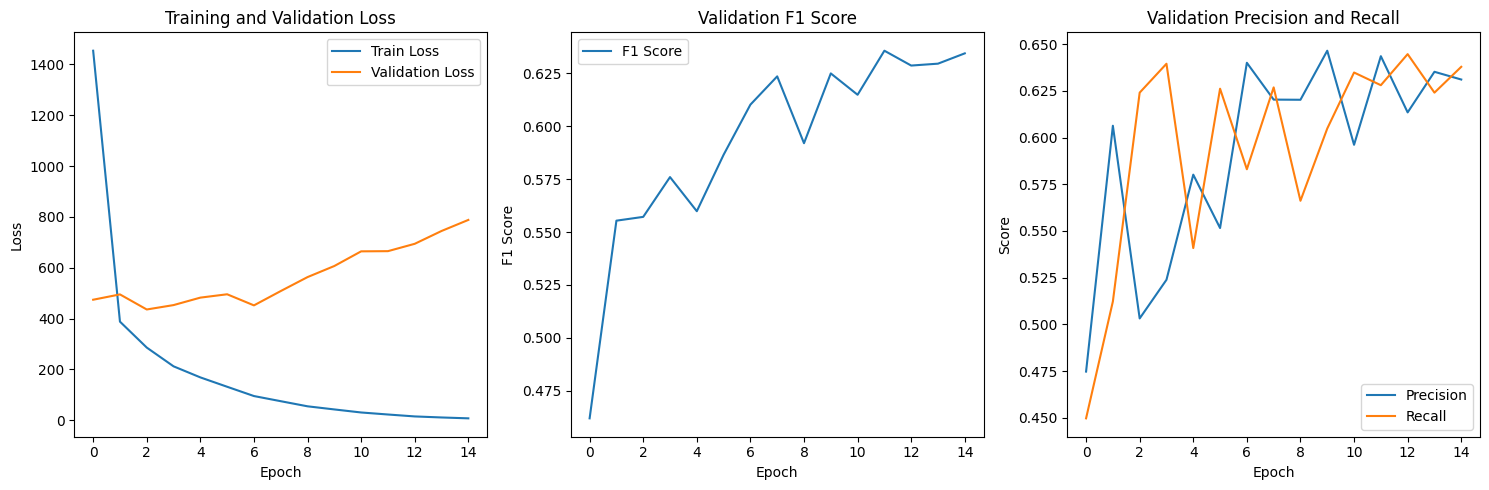


Final evaluation on validation set:


Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 648 documents
  F1:        0.6357
  Precision: 0.6435
  Recall:    0.6280

Training on fold1, fold2 and validating on fold3

Created 1291 training samples and 687 validation samples


Epoch 1/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 687 documents
Epoch 1/15:
  Train Loss: 1443.3582
  Val   Loss: 495.5863
  Val   F1:   0.4701 (P: 0.3916, R: 0.5878)
  Per-type metrics (top 5 by support):
    STAT: F1=0.5966, P=0.5624, R=0.6352, N=795
    DATE: F1=0.9042, P=0.8636, R=0.9487, N=741
    PREC: F1=0.2660, P=0.2446, R=0.2915, N=621
    COURT: F1=0.6373, P=0.5125, R=0.8426, N=559
    CASENO: F1=0.5803, P=0.5598, R=0.6023, N=342
  ↗ New best F1: 0.4701 (was 0.0000)


Epoch 2/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 687 documents
Epoch 2/15:
  Train Loss: 398.9947
  Val   Loss: 406.9527
  Val   F1:   0.5363 (P: 0.4746, R: 0.6164)
  Per-type metrics (top 5 by support):
    STAT: F1=0.6166, P=0.5431, R=0.7132, N=795
    DATE: F1=0.9160, P=0.8854, R=0.9487, N=741
    PREC: F1=0.2099, P=0.1838, R=0.2448, N=621
    COURT: F1=0.7873, P=0.7591, R=0.8175, N=559
    CASENO: F1=0.5439, P=0.4580, R=0.6696, N=342
  ↗ New best F1: 0.5363 (was 0.4701)


Epoch 3/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 687 documents
Epoch 3/15:
  Train Loss: 292.4588
  Val   Loss: 429.1584
  Val   F1:   0.5945 (P: 0.5674, R: 0.6243)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7134, P=0.6248, R=0.8314, N=795
    DATE: F1=0.8875, P=0.9142, R=0.8623, N=741
    PREC: F1=0.4005, P=0.3366, R=0.4944, N=621
    COURT: F1=0.7757, P=0.7547, R=0.7979, N=559
    CASENO: F1=0.6366, P=0.6788, R=0.5994, N=342
  ↗ New best F1: 0.5945 (was 0.5363)


Epoch 4/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 687 documents
Epoch 4/15:
  Train Loss: 222.7851
  Val   Loss: 396.5232
  Val   F1:   0.6036 (P: 0.6010, R: 0.6062)
  Per-type metrics (top 5 by support):
    STAT: F1=0.6957, P=0.6452, R=0.7547, N=795
    DATE: F1=0.9194, P=0.9226, R=0.9163, N=741
    PREC: F1=0.4060, P=0.4200, R=0.3929, N=621
    COURT: F1=0.7716, P=0.7668, R=0.7764, N=559
    CASENO: F1=0.5880, P=0.6808, R=0.5175, N=342
  ↗ New best F1: 0.6036 (was 0.5945)


Epoch 5/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 687 documents
Epoch 5/15:
  Train Loss: 169.2092
  Val   Loss: 382.0627
  Val   F1:   0.6318 (P: 0.6484, R: 0.6160)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7164, P=0.6871, R=0.7484, N=795
    DATE: F1=0.9296, P=0.9322, R=0.9271, N=741
    PREC: F1=0.4949, P=0.4789, R=0.5121, N=621
    COURT: F1=0.8073, P=0.7841, R=0.8318, N=559
    CASENO: F1=0.6524, P=0.7472, R=0.5789, N=342
  ↗ New best F1: 0.6318 (was 0.6036)


Epoch 6/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 687 documents
Epoch 6/15:
  Train Loss: 135.3515
  Val   Loss: 421.3440
  Val   F1:   0.5961 (P: 0.5556, R: 0.6429)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7026, P=0.6401, R=0.7786, N=795
    DATE: F1=0.9434, P=0.9304, R=0.9568, N=741
    PREC: F1=0.4070, P=0.4470, R=0.3736, N=621
    COURT: F1=0.7719, P=0.6964, R=0.8658, N=559
    CASENO: F1=0.5526, P=0.6316, R=0.4912, N=342
  ↘ No improvement (1/3)


Epoch 7/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 687 documents
Epoch 7/15:
  Train Loss: 101.0451
  Val   Loss: 442.0942
  Val   F1:   0.6130 (P: 0.6570, R: 0.5745)
  Per-type metrics (top 5 by support):
    STAT: F1=0.6417, P=0.6999, R=0.5925, N=795
    DATE: F1=0.9462, P=0.9436, R=0.9487, N=741
    PREC: F1=0.4780, P=0.4670, R=0.4895, N=621
    COURT: F1=0.7558, P=0.7586, R=0.7531, N=559
    CASENO: F1=0.6697, P=0.6916, R=0.6491, N=342
  ↘ No improvement (2/3)


Epoch 8/15 [Train]:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 687 documents
Epoch 8/15:
  Train Loss: 77.6182
  Val   Loss: 443.1109
  Val   F1:   0.6146 (P: 0.6065, R: 0.6229)
  Per-type metrics (top 5 by support):
    STAT: F1=0.6998, P=0.6822, R=0.7182, N=795
    DATE: F1=0.9266, P=0.9516, R=0.9028, N=741
    PREC: F1=0.4667, P=0.4543, R=0.4799, N=621
    COURT: F1=0.7778, P=0.7447, R=0.8140, N=559
    CASENO: F1=0.5858, P=0.6348, R=0.5439, N=342
  ↘ No improvement (3/3)
Early stopping at epoch 8


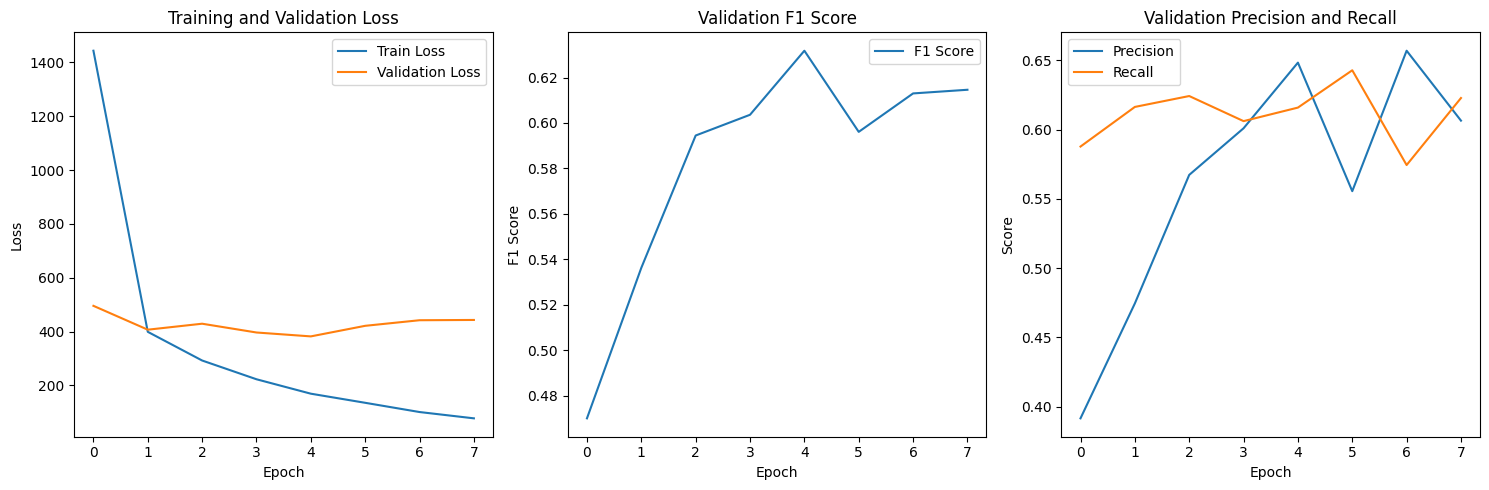


Final evaluation on validation set:


Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 687 documents
  F1:        0.6318
  Precision: 0.6484
  Recall:    0.6160

Cross-validation results:
  Fold 1: F1 = 0.5971
  Fold 2: F1 = 0.6357
  Fold 3: F1 = 0.6318
  Average: F1 = 0.6215, Precision = 0.6204, Recall = 0.6239


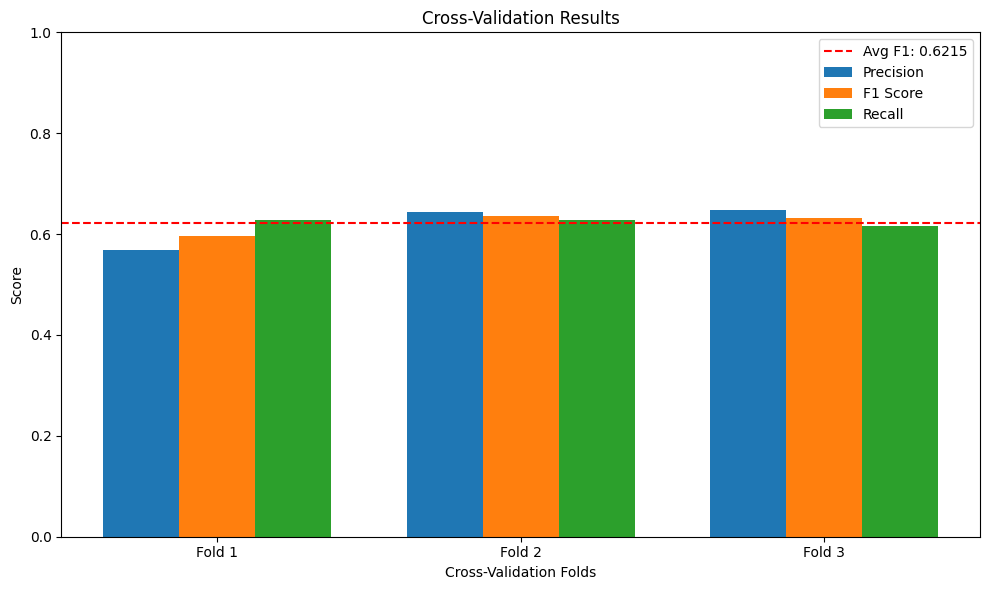


Analyzing entity distribution across the dataset:


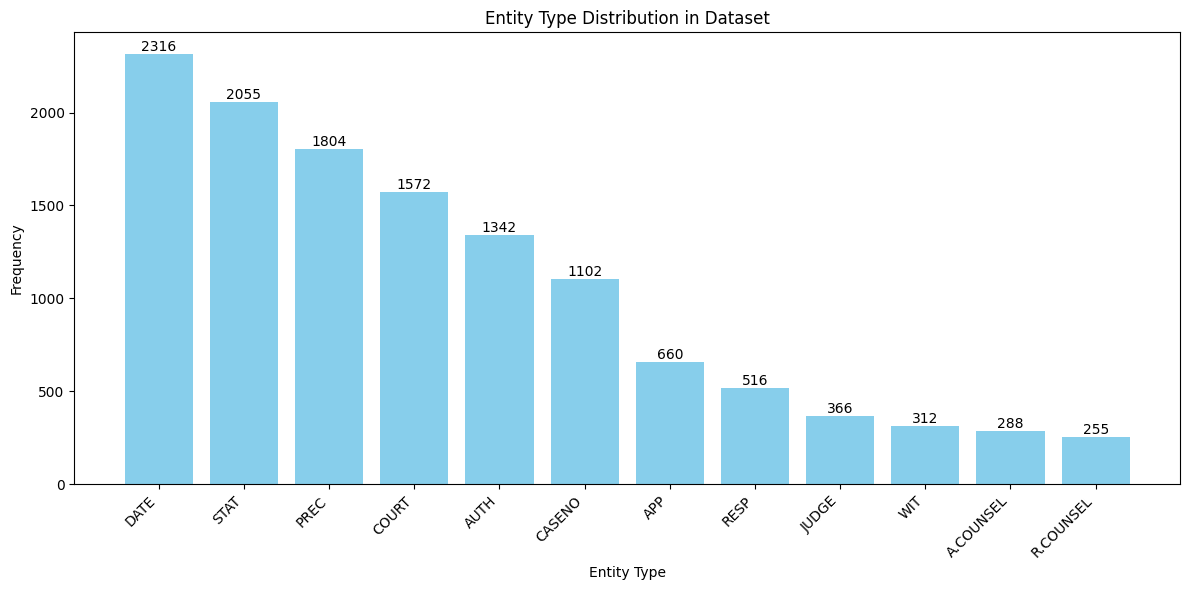

Best model saved to best_legal_ner_model_law_ai_InCaseLawBERT_CRF_true.pt
Model configuration saved to model_config_law_ai_InCaseLawBERT_CRF_true.json

Testing on sample document from fold3:

Testing entity extraction on a sample document:

Sample document excerpt:
REPORTABLE IN THE SUPREME COURT OF INDIA CIVIL APPELLATE JURISDICTION CIVIL APPEAL NO.6580 OF 2008 ARISING OUT OF SPECIAL LEAVE PETITION (CIVIL) NO. 15449 OF 2004 ESSCO FABS PVT. LTD. & ANR. ... APPELLANTS VERSUS STATE OF HARYANA & ANR. ... RESPONDENTS WITH CIVIL APPEAL NO.6581 OF 2008 ARISING OUT OF SPECIAL LEAVE PETITION (CIVIL) NO. 15544 OF 2004 THE PANIPAT TEACHERS (RECOGNISED SCHOOLS)HOUSING CO-OPEATIVE SOCIETY LTD. & ANR. ... APPELLANTS VERSUS STATE OF HARYANA & ORS. ... RESPONDENTS WITH C...


Predicted entities visualization:


Found 18 entities:
1. CASENO: 'SPECIAL LEAVE PETITION (CIVIL) NO. 15449 OF 2004'
2. RESP: 'STATE OF HARYANA'
3. CASENO: 'SPECIAL LEAVE PETITION (CIVIL) NO. 15544 OF 2004'
4. APP: 'PANIPAT TEACHERS (RECOGNISED SCHOOLS)HOUSING CO-OPEATIVE SOCIETY LTD.'
5. RESP: 'STATE OF HARYANA'
6. CASENO: 'SPECIAL LEAVE PETITION (CIVIL) NO. 15449 OF 2004'
7. RESP: 'STATE OF HARYANA'
8. JUDGE: 'C.K. THAKKER'
9. DATE: 'April 02, 2004'
10. COURT: 'High Court of Punjab & Haryana'
11. CASENO: 'Civil Writ Petition'
12. APP: 'Essco Fabs Pvt. Ltd.'
13. APP: 'Essco'
14. AUTH: 'Haryana Urban Development Authority'
15. AUTH: 'HUDA'
16. DATE: 'December 15, 1982'
17. DATE: 'June 20, 1984'
18. APP: 'Essco'

Gold standard entities:


Found 87 entities:
1. COURT: 'SUPREME COURT OF INDIA'
2. CASENO: 'SPECIAL LEAVE PETITION (CIVIL) NO. 15449 OF 2004'
3. RESP: 'STATE OF HARYANA'
4. CASENO: 'SPECIAL LEAVE PETITION (CIVIL) NO. 15544 OF 2004'
5. APP: 'PANIPAT TEACHERS (RECOGNISED SCHOOLS)HOUSING CO-OPEATIVE SOCIETY LTD.'
6. RESP: 'STATE OF HARYANA'
7. CASENO: 'SPECIAL LEAVE PETITION (CIVIL) NO. 15449 OF 2004'
8. RESP: 'STATE OF HARYANA'
9. JUDGE: 'C.K. THAKKER'
10. DATE: 'April 02, 2004'
11. COURT: 'High Court of Punjab & Haryana'
12. CASENO: 'Civil Writ Petition Nos.'
13. APP: 'Essco Fabs Pvt. Ltd.'
14. APP: 'Essco'
15. AUTH: 'Haryana Urban Development Authority'
16. AUTH: 'HUDA'
17. DATE: 'December 15, 1982'
18. DATE: 'June 20, 1984'
19. APP: 'Essco'
20. DATE: 'June 6, 1991'
21. AUTH: 'Director, Town & Country Planning, Haryana'
22. DATE: 'September 5, 1991'
23. DATE: 'August 1, 2001'
24. AUTH: 'HUDA'
25. DATE: 'August 2, 2001'
26. CASENO: 'Civil Writ Petition No. 1853 of 2003'
27. COURT: 'High Court of Punjab & Haryana

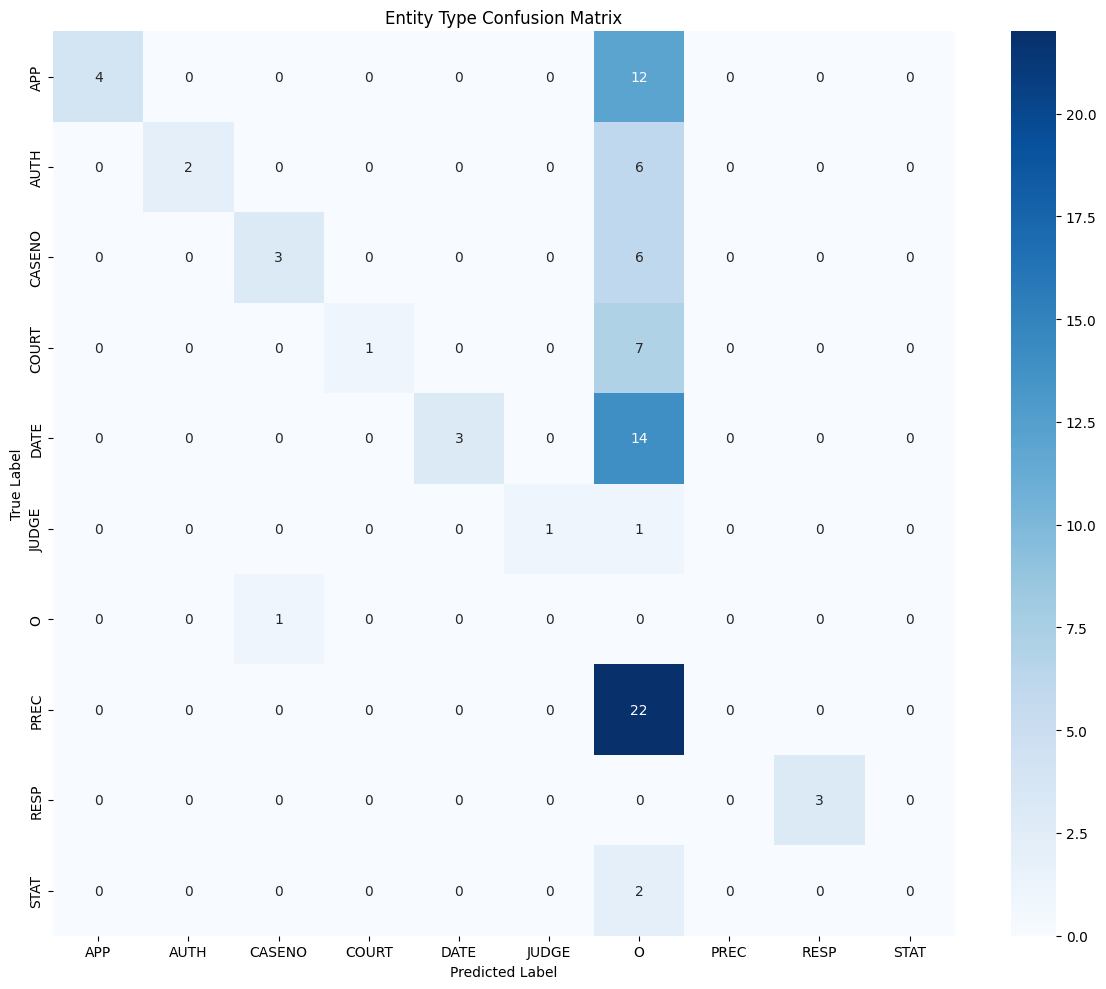


Entity recognition error analysis:


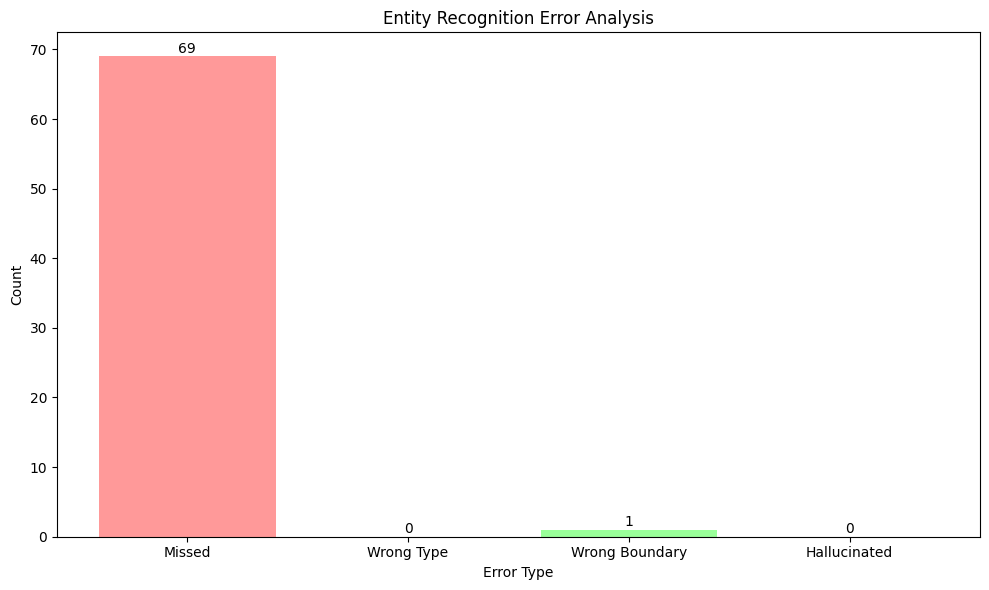

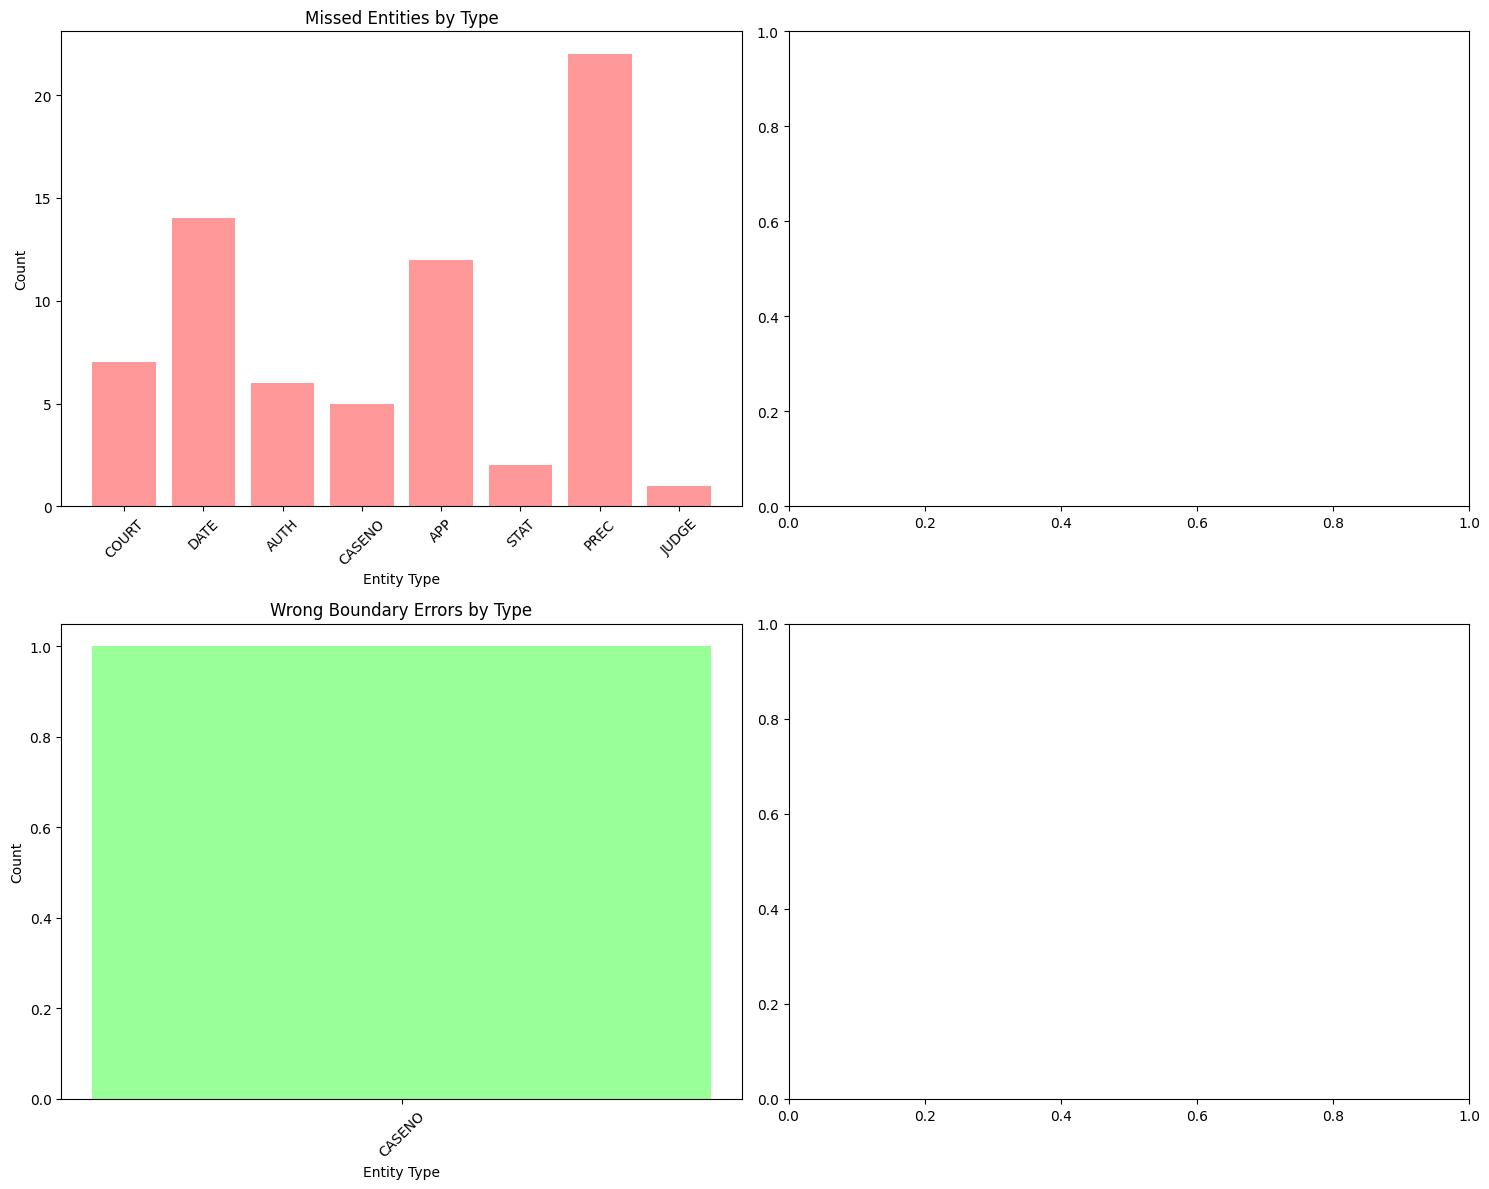

Cross-validation complete!


In [48]:
if __name__ == "__main__":
    best_model, cv_results = run_cross_validation()
    
    # Test on sample documents from fold 3    
    print("\nTesting on sample document from fold3:")
    predicted_entities2, true_entities2 = test_on_sample(best_model, sample_idx=0, fold_name="fold3")
    
    print("Cross-validation complete!")

## **Model : law-ai/InLegalBERT**

**Using a learning rate of `1e-4`, for the CRF configuration.**

In [51]:
# Update the model name in non_crf_config
crf_config["model_name"] = "law-ai/InLegalBERT"

print("CRF Config Model Name:", crf_config["model_name"])

CRF Config Model Name: law-ai/InLegalBERT


In [52]:
tokenizer = load_tokenizer(crf_config)

tokenizer_config.json:   0%|          | 0.00/516 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Tokenizer loaded for model: law-ai/InLegalBERT


In [53]:
for key, value in config.items():
    print(f"{key}: {value}")

max_length: 512
stride: 128
batch_size: 8
weight_decay: 0.01
epochs: 15
warmup_ratio: 0.1
early_stop_patience: 3
visualize_training: True
visualize_entities: True
visualize_confusion: True
problematic_entities: {'R.COUNSEL': 4.0, 'A.COUNSEL': 3.5, 'JUDGE': 3.0, 'WIT': 3.2, 'RESP': 2.3, 'APP': 1.8, 'CASENO': 1.4, 'AUTH': 1.4}
data_files: {'fold1': '/kaggle/input/legalcasedocuments/fold1.json', 'fold2': '/kaggle/input/legalcasedocuments/fold2.json', 'fold3': '/kaggle/input/legalcasedocuments/fold3.json'}
model_name: law-ai/InLegalBERT
use_crf: True
metrics_per_label: True
gradient_accumulation: 2
learning_rate: 0.0001
fp16: False
extra_transformer_layers: 2
transformer_nhead: 8
transformer_dim_feedforward: 3072
transformer_dropout: 0.1



Training on fold2, fold3 and validating on fold1

Created 1325 training samples and 639 validation samples


config.json:   0%|          | 0.00/671 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/534M [00:00<?, ?B/s]

Epoch 1/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/534M [00:00<?, ?B/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 1/15:
  Train Loss: 1542.6247
  Val   Loss: 487.8928
  Val   F1:   0.3930 (P: 0.3703, R: 0.4187)
  Per-type metrics (top 5 by support):
    DATE: F1=0.6132, P=0.6201, R=0.6064, N=813
    PREC: F1=0.2099, P=0.2052, R=0.2147, N=624
    AUTH: F1=0.3539, P=0.2935, R=0.4457, N=534
    STAT: F1=0.3630, P=0.3494, R=0.3776, N=519
    COURT: F1=0.6097, P=0.4959, R=0.7912, N=455
  ↗ New best F1: 0.3930 (was 0.0000)


Epoch 2/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 2/15:
  Train Loss: 392.0776
  Val   Loss: 502.5675
  Val   F1:   0.5027 (P: 0.4877, R: 0.5186)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9279, P=0.9141, R=0.9422, N=813
    PREC: F1=0.0459, P=0.0469, R=0.0449, N=624
    AUTH: F1=0.3434, P=0.3864, R=0.3090, N=534
    STAT: F1=0.7357, P=0.7069, R=0.7669, N=519
    COURT: F1=0.7480, P=0.7850, R=0.7143, N=455
  ↗ New best F1: 0.5027 (was 0.3930)


Epoch 3/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 3/15:
  Train Loss: 298.4231
  Val   Loss: 451.6288
  Val   F1:   0.5783 (P: 0.5628, R: 0.5947)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9084, P=0.8846, R=0.9336, N=813
    PREC: F1=0.4676, P=0.4862, R=0.4503, N=624
    AUTH: F1=0.2916, P=0.3256, R=0.2640, N=534
    STAT: F1=0.7433, P=0.6915, R=0.8035, N=519
    COURT: F1=0.6916, P=0.6722, R=0.7121, N=455
  ↗ New best F1: 0.5783 (was 0.5027)


Epoch 4/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 4/15:
  Train Loss: 230.7066
  Val   Loss: 396.7698
  Val   F1:   0.5767 (P: 0.5575, R: 0.5971)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9517, P=0.9465, R=0.9569, N=813
    PREC: F1=0.4143, P=0.4030, R=0.4263, N=624
    AUTH: F1=0.2872, P=0.3121, R=0.2659, N=534
    STAT: F1=0.7551, P=0.7281, R=0.7842, N=519
    COURT: F1=0.7331, P=0.7155, R=0.7516, N=455
  ↘ No improvement (1/3)


Epoch 5/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 5/15:
  Train Loss: 176.9334
  Val   Loss: 478.8915
  Val   F1:   0.5914 (P: 0.6003, R: 0.5828)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9523, P=0.9476, R=0.9569, N=813
    PREC: F1=0.4470, P=0.4063, R=0.4968, N=624
    AUTH: F1=0.3545, P=0.3834, R=0.3296, N=534
    STAT: F1=0.7073, P=0.7634, R=0.6590, N=519
    COURT: F1=0.7260, P=0.7454, R=0.7077, N=455
  ↗ New best F1: 0.5914 (was 0.5783)


Epoch 6/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 6/15:
  Train Loss: 140.4228
  Val   Loss: 509.6376
  Val   F1:   0.5495 (P: 0.5625, R: 0.5371)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9461, P=0.9526, R=0.9397, N=813
    PREC: F1=0.3139, P=0.2941, R=0.3365, N=624
    AUTH: F1=0.3039, P=0.3579, R=0.2640, N=534
    STAT: F1=0.7043, P=0.6498, R=0.7688, N=519
    COURT: F1=0.7373, P=0.6988, R=0.7802, N=455
  ↘ No improvement (1/3)


Epoch 7/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 7/15:
  Train Loss: 109.3893
  Val   Loss: 457.2639
  Val   F1:   0.6022 (P: 0.5963, R: 0.6083)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9346, P=0.9201, R=0.9496, N=813
    PREC: F1=0.3714, P=0.3865, R=0.3574, N=624
    AUTH: F1=0.3414, P=0.4105, R=0.2921, N=534
    STAT: F1=0.7877, P=0.7088, R=0.8863, N=519
    COURT: F1=0.6936, P=0.6722, R=0.7165, N=455
  ↗ New best F1: 0.6022 (was 0.5914)


Epoch 8/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 8/15:
  Train Loss: 86.4093
  Val   Loss: 484.3868
  Val   F1:   0.6143 (P: 0.5999, R: 0.6295)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9500, P=0.9420, R=0.9582, N=813
    PREC: F1=0.4585, P=0.4085, R=0.5224, N=624
    AUTH: F1=0.3942, P=0.3795, R=0.4101, N=534
    STAT: F1=0.7637, P=0.7495, R=0.7784, N=519
    COURT: F1=0.7237, P=0.7221, R=0.7253, N=455
  ↗ New best F1: 0.6143 (was 0.6022)


Epoch 9/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 9/15:
  Train Loss: 61.9433
  Val   Loss: 548.6351
  Val   F1:   0.6068 (P: 0.6158, R: 0.5981)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9512, P=0.9432, R=0.9594, N=813
    PREC: F1=0.4479, P=0.4519, R=0.4439, N=624
    AUTH: F1=0.3241, P=0.3941, R=0.2753, N=534
    STAT: F1=0.7302, P=0.7083, R=0.7534, N=519
    COURT: F1=0.7244, P=0.7048, R=0.7451, N=455
  ↘ No improvement (1/3)


Epoch 10/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 10/15:
  Train Loss: 47.3043
  Val   Loss: 585.5079
  Val   F1:   0.6011 (P: 0.5641, R: 0.6433)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9392, P=0.9110, R=0.9692, N=813
    PREC: F1=0.4455, P=0.3967, R=0.5080, N=624
    AUTH: F1=0.3490, P=0.3443, R=0.3539, N=534
    STAT: F1=0.7807, P=0.7074, R=0.8709, N=519
    COURT: F1=0.7213, P=0.7379, R=0.7055, N=455
  ↘ No improvement (2/3)


Epoch 11/15 [Train]:   0%|          | 0/166 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
Epoch 11/15:
  Train Loss: 31.1841
  Val   Loss: 632.2975
  Val   F1:   0.6092 (P: 0.5975, R: 0.6214)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9508, P=0.9388, R=0.9631, N=813
    PREC: F1=0.4432, P=0.3921, R=0.5096, N=624
    AUTH: F1=0.3304, P=0.4049, R=0.2790, N=534
    STAT: F1=0.7380, P=0.7198, R=0.7572, N=519
    COURT: F1=0.7248, P=0.7380, R=0.7121, N=455
  ↘ No improvement (3/3)
Early stopping at epoch 11


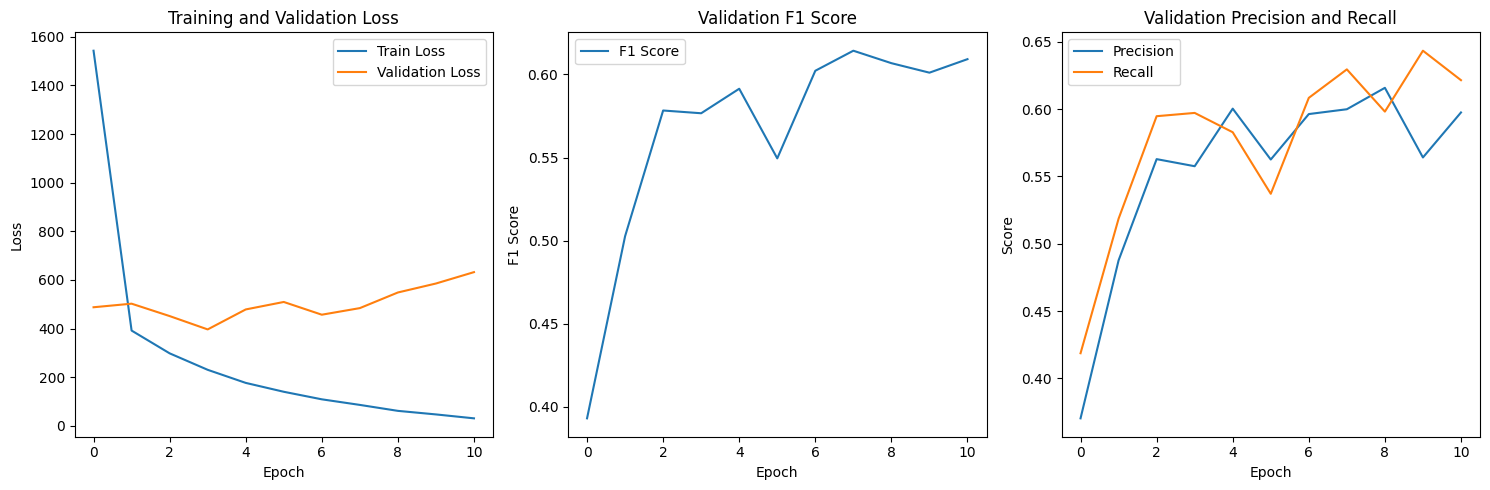


Final evaluation on validation set:


Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

Processing 639 documents
  F1:        0.6143
  Precision: 0.5999
  Recall:    0.6295

Training on fold1, fold3 and validating on fold2

Created 1320 training samples and 644 validation samples


Epoch 1/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 1/15:
  Train Loss: 1461.9721
  Val   Loss: 559.1846
  Val   F1:   0.4734 (P: 0.4744, R: 0.4725)
  Per-type metrics (top 5 by support):
    DATE: F1=0.8748, P=0.8286, R=0.9265, N=762
    STAT: F1=0.5495, P=0.5560, R=0.5431, N=731
    PREC: F1=0.2715, P=0.2397, R=0.3131, N=559
    COURT: F1=0.7952, P=0.7649, R=0.8280, N=558
    AUTH: F1=0.1705, P=0.2634, R=0.1261, N=468
  ↗ New best F1: 0.4734 (was 0.0000)


Epoch 2/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 2/15:
  Train Loss: 401.1125
  Val   Loss: 559.6916
  Val   F1:   0.5463 (P: 0.6299, R: 0.4823)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9212, P=0.9146, R=0.9278, N=762
    STAT: F1=0.6828, P=0.6541, R=0.7141, N=731
    PREC: F1=0.0000, P=0.0000, R=0.0000, N=559
    COURT: F1=0.7766, P=0.8351, R=0.7258, N=558
    AUTH: F1=0.1946, P=0.3250, R=0.1389, N=468
  ↗ New best F1: 0.5463 (was 0.4734)


Epoch 3/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 3/15:
  Train Loss: 302.5826
  Val   Loss: 502.9094
  Val   F1:   0.5903 (P: 0.5718, R: 0.6100)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9429, P=0.9321, R=0.9541, N=762
    STAT: F1=0.7314, P=0.7217, R=0.7415, N=731
    PREC: F1=0.4901, P=0.4391, R=0.5546, N=559
    COURT: F1=0.6594, P=0.6704, R=0.6487, N=558
    AUTH: F1=0.4767, P=0.4835, R=0.4701, N=468
  ↗ New best F1: 0.5903 (was 0.5463)


Epoch 4/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 4/15:
  Train Loss: 224.7791
  Val   Loss: 477.9720
  Val   F1:   0.6409 (P: 0.6261, R: 0.6564)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9523, P=0.9492, R=0.9554, N=762
    STAT: F1=0.7715, P=0.7715, R=0.7715, N=731
    PREC: F1=0.3701, P=0.3598, R=0.3810, N=559
    COURT: F1=0.7723, P=0.7293, R=0.8208, N=558
    AUTH: F1=0.5294, P=0.5625, R=0.5000, N=468
  ↗ New best F1: 0.6409 (was 0.5903)


Epoch 5/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 5/15:
  Train Loss: 176.1387
  Val   Loss: 514.0806
  Val   F1:   0.5969 (P: 0.5577, R: 0.6421)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9374, P=0.9225, R=0.9528, N=762
    STAT: F1=0.7273, P=0.7014, R=0.7551, N=731
    PREC: F1=0.5165, P=0.4378, R=0.6297, N=559
    COURT: F1=0.8033, P=0.8128, R=0.7939, N=558
    AUTH: F1=0.2471, P=0.3156, R=0.2030, N=468
  ↘ No improvement (1/3)


Epoch 6/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 6/15:
  Train Loss: 137.5673
  Val   Loss: 471.3283
  Val   F1:   0.6528 (P: 0.6441, R: 0.6617)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9366, P=0.9149, R=0.9593, N=762
    STAT: F1=0.7472, P=0.7723, R=0.7237, N=731
    PREC: F1=0.5541, P=0.5113, R=0.6047, N=559
    COURT: F1=0.8014, P=0.7797, R=0.8244, N=558
    AUTH: F1=0.5531, P=0.5349, R=0.5726, N=468
  ↗ New best F1: 0.6528 (was 0.6409)


Epoch 7/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 7/15:
  Train Loss: 109.9363
  Val   Loss: 526.8378
  Val   F1:   0.6575 (P: 0.6473, R: 0.6681)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9528, P=0.9528, R=0.9528, N=762
    STAT: F1=0.8015, P=0.7410, R=0.8728, N=731
    PREC: F1=0.5155, P=0.4543, R=0.5957, N=559
    COURT: F1=0.8015, P=0.8187, R=0.7849, N=558
    AUTH: F1=0.4406, P=0.5317, R=0.3761, N=468
  ↗ New best F1: 0.6575 (was 0.6528)


Epoch 8/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 8/15:
  Train Loss: 80.7649
  Val   Loss: 507.3849
  Val   F1:   0.6361 (P: 0.6337, R: 0.6386)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9478, P=0.9429, R=0.9528, N=762
    STAT: F1=0.7378, P=0.7328, R=0.7428, N=731
    PREC: F1=0.5371, P=0.4809, R=0.6082, N=559
    COURT: F1=0.8125, P=0.8096, R=0.8154, N=558
    AUTH: F1=0.4790, P=0.5109, R=0.4509, N=468
  ↘ No improvement (1/3)


Epoch 9/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 9/15:
  Train Loss: 61.0331
  Val   Loss: 673.6358
  Val   F1:   0.6670 (P: 0.6825, R: 0.6521)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9554, P=0.9542, R=0.9567, N=762
    STAT: F1=0.7956, P=0.7951, R=0.7962, N=731
    PREC: F1=0.5588, P=0.5333, R=0.5868, N=559
    COURT: F1=0.8145, P=0.8266, R=0.8029, N=558
    AUTH: F1=0.4063, P=0.6239, R=0.3013, N=468
  ↗ New best F1: 0.6670 (was 0.6575)


Epoch 10/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 10/15:
  Train Loss: 46.4531
  Val   Loss: 658.3884
  Val   F1:   0.6316 (P: 0.6164, R: 0.6477)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9477, P=0.9440, R=0.9514, N=762
    STAT: F1=0.7608, P=0.7906, R=0.7332, N=731
    PREC: F1=0.5379, P=0.4856, R=0.6029, N=559
    COURT: F1=0.7979, P=0.7929, R=0.8029, N=558
    AUTH: F1=0.4194, P=0.4439, R=0.3974, N=468
  ↘ No improvement (1/3)


Epoch 11/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 11/15:
  Train Loss: 35.2064
  Val   Loss: 675.0120
  Val   F1:   0.6646 (P: 0.6682, R: 0.6610)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9572, P=0.9604, R=0.9541, N=762
    STAT: F1=0.7870, P=0.7986, R=0.7756, N=731
    PREC: F1=0.5662, P=0.5085, R=0.6386, N=559
    COURT: F1=0.8106, P=0.7972, R=0.8244, N=558
    AUTH: F1=0.4713, P=0.5499, R=0.4124, N=468
  ↘ No improvement (2/3)


Epoch 12/15 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
Epoch 12/15:
  Train Loss: 23.2156
  Val   Loss: 773.8430
  Val   F1:   0.6481 (P: 0.6543, R: 0.6421)
  Per-type metrics (top 5 by support):
    DATE: F1=0.9545, P=0.9589, R=0.9501, N=762
    STAT: F1=0.7823, P=0.7781, R=0.7866, N=731
    PREC: F1=0.5466, P=0.4894, R=0.6190, N=559
    COURT: F1=0.8071, P=0.7972, R=0.8172, N=558
    AUTH: F1=0.3246, P=0.5045, R=0.2393, N=468
  ↘ No improvement (3/3)
Early stopping at epoch 12


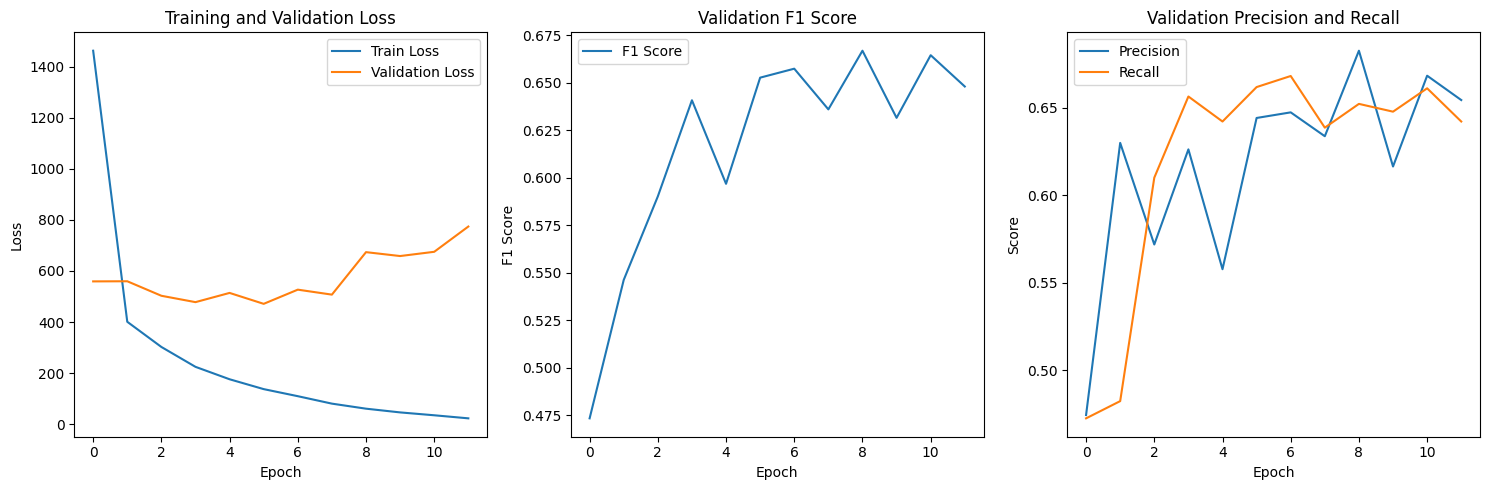


Final evaluation on validation set:


Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Processing 644 documents
  F1:        0.6670
  Precision: 0.6825
  Recall:    0.6521

Training on fold1, fold2 and validating on fold3

Created 1283 training samples and 681 validation samples


Epoch 1/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 681 documents
Epoch 1/15:
  Train Loss: 1560.7726
  Val   Loss: 425.5309
  Val   F1:   0.5843 (P: 0.6175, R: 0.5545)
  Per-type metrics (top 5 by support):
    STAT: F1=0.6172, P=0.5690, R=0.6742, N=795
    DATE: F1=0.8970, P=0.8724, R=0.9231, N=741
    PREC: F1=0.4036, P=0.4150, R=0.3929, N=621
    COURT: F1=0.7687, P=0.7185, R=0.8265, N=559
    CASENO: F1=0.6378, P=0.6776, R=0.6023, N=342
  ↗ New best F1: 0.5843 (was 0.0000)


Epoch 2/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 681 documents
Epoch 2/15:
  Train Loss: 405.1879
  Val   Loss: 382.2656
  Val   F1:   0.5794 (P: 0.5317, R: 0.6365)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7400, P=0.6883, R=0.8000, N=795
    DATE: F1=0.9160, P=0.8914, R=0.9420, N=741
    PREC: F1=0.4363, P=0.4081, R=0.4686, N=621
    COURT: F1=0.7400, P=0.6597, R=0.8426, N=559
    CASENO: F1=0.6498, P=0.6260, R=0.6754, N=342
  ↘ No improvement (1/3)


Epoch 3/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 681 documents
Epoch 3/15:
  Train Loss: 300.8203
  Val   Loss: 383.3508
  Val   F1:   0.6473 (P: 0.6426, R: 0.6520)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7415, P=0.6863, R=0.8063, N=795
    DATE: F1=0.9293, P=0.9369, R=0.9217, N=741
    PREC: F1=0.5413, P=0.5028, R=0.5862, N=621
    COURT: F1=0.8072, P=0.8168, R=0.7979, N=559
    CASENO: F1=0.6570, P=0.6532, R=0.6608, N=342
  ↗ New best F1: 0.6473 (was 0.5843)


Epoch 4/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 681 documents
Epoch 4/15:
  Train Loss: 233.8269
  Val   Loss: 434.5604
  Val   F1:   0.5967 (P: 0.5395, R: 0.6675)
  Per-type metrics (top 5 by support):
    STAT: F1=0.6700, P=0.5992, R=0.7597, N=795
    DATE: F1=0.9423, P=0.9258, R=0.9595, N=741
    PREC: F1=0.4353, P=0.3879, R=0.4960, N=621
    COURT: F1=0.7966, P=0.7597, R=0.8372, N=559
    CASENO: F1=0.6667, P=0.6279, R=0.7105, N=342
  ↘ No improvement (1/3)


Epoch 5/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 681 documents
Epoch 5/15:
  Train Loss: 184.7811
  Val   Loss: 412.1041
  Val   F1:   0.6027 (P: 0.6265, R: 0.5807)
  Per-type metrics (top 5 by support):
    STAT: F1=0.4971, P=0.5039, R=0.4906, N=795
    DATE: F1=0.9329, P=0.9373, R=0.9285, N=741
    PREC: F1=0.5606, P=0.5052, R=0.6296, N=621
    COURT: F1=0.7952, P=0.8131, R=0.7782, N=559
    CASENO: F1=0.6913, P=0.7679, R=0.6287, N=342
  ↘ No improvement (2/3)


Epoch 6/15 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 681 documents
Epoch 6/15:
  Train Loss: 139.8045
  Val   Loss: 418.3366
  Val   F1:   0.6382 (P: 0.6606, R: 0.6172)
  Per-type metrics (top 5 by support):
    STAT: F1=0.7308, P=0.6997, R=0.7648, N=795
    DATE: F1=0.9301, P=0.9545, R=0.9069, N=741
    PREC: F1=0.4733, P=0.4499, R=0.4992, N=621
    COURT: F1=0.7891, P=0.7985, R=0.7800, N=559
    CASENO: F1=0.6359, P=0.6969, R=0.5848, N=342
  ↘ No improvement (3/3)
Early stopping at epoch 6


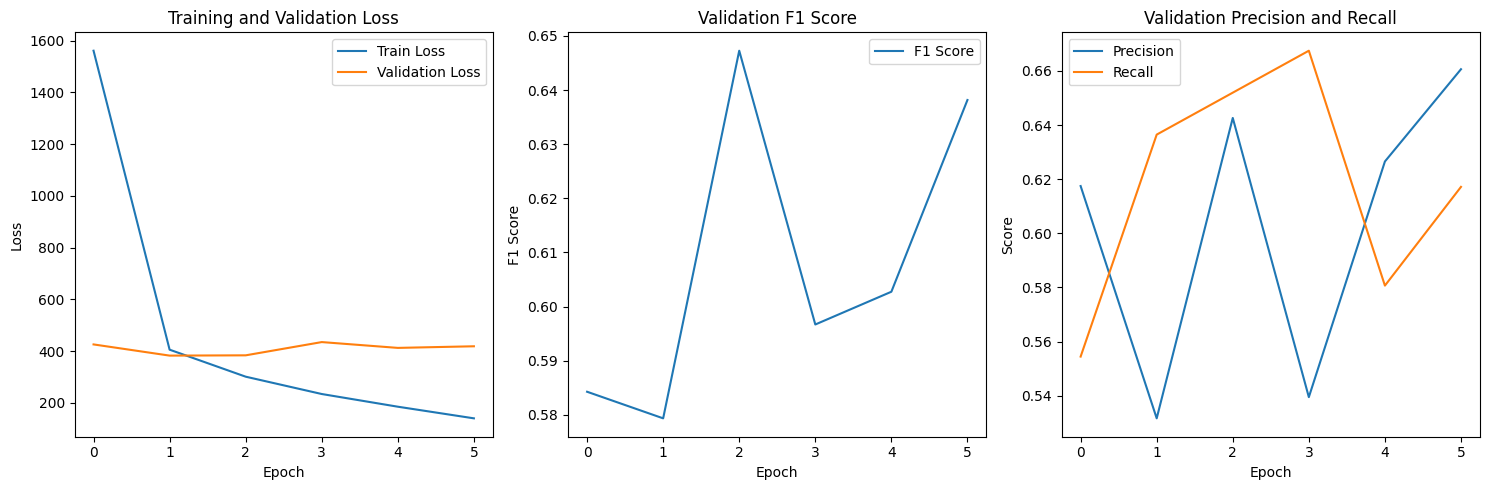


Final evaluation on validation set:


Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Processing 681 documents
  F1:        0.6473
  Precision: 0.6426
  Recall:    0.6520

Cross-validation results:
  Fold 1: F1 = 0.6143
  Fold 2: F1 = 0.6670
  Fold 3: F1 = 0.6473
  Average: F1 = 0.6429, Precision = 0.6417, Recall = 0.6445


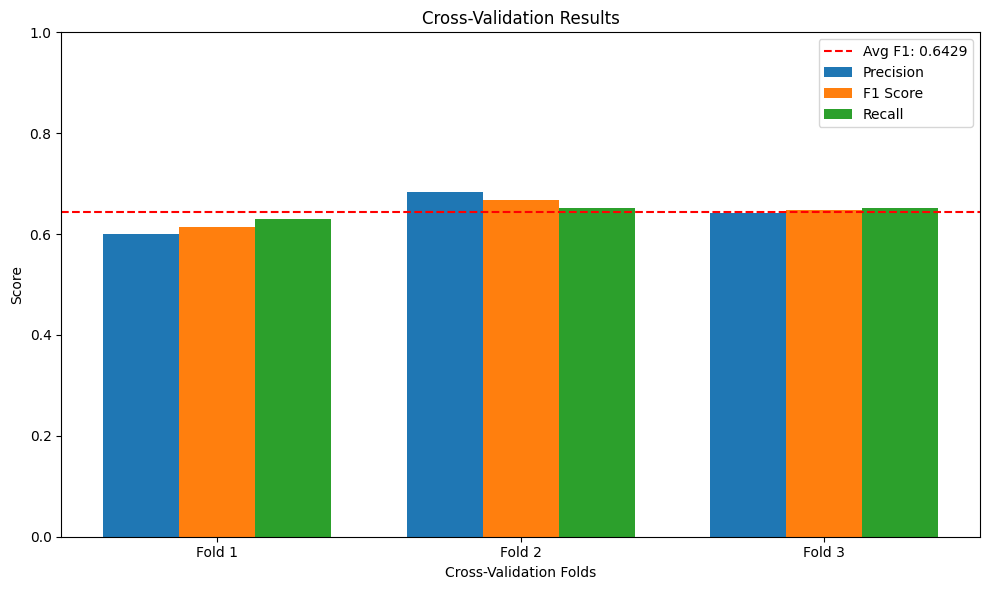


Analyzing entity distribution across the dataset:


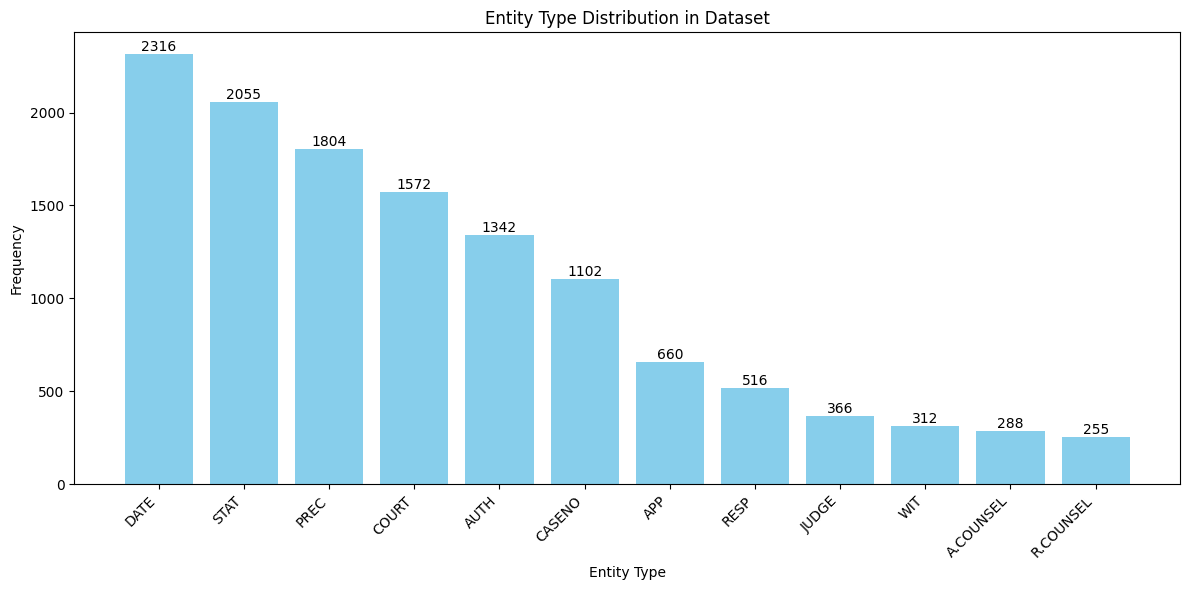

Best model saved to best_legal_ner_model_law_ai_InLegalBERT_CRF_true.pt
Model configuration saved to model_config_law_ai_InLegalBERT_CRF_true.json

Testing on sample document from fold3:

Testing entity extraction on a sample document:

Sample document excerpt:
REPORTABLE IN THE SUPREME COURT OF INDIA CIVIL APPELLATE JURISDICTION CIVIL APPEAL NO.6580 OF 2008 ARISING OUT OF SPECIAL LEAVE PETITION (CIVIL) NO. 15449 OF 2004 ESSCO FABS PVT. LTD. & ANR. ... APPELLANTS VERSUS STATE OF HARYANA & ANR. ... RESPONDENTS WITH CIVIL APPEAL NO.6581 OF 2008 ARISING OUT OF SPECIAL LEAVE PETITION (CIVIL) NO. 15544 OF 2004 THE PANIPAT TEACHERS (RECOGNISED SCHOOLS)HOUSING CO-OPEATIVE SOCIETY LTD. & ANR. ... APPELLANTS VERSUS STATE OF HARYANA & ORS. ... RESPONDENTS WITH C...


Predicted entities visualization:


Found 18 entities:
1. CASENO: 'SPECIAL LEAVE PETITION (CIVIL) NO. 15449 OF 2004'
2. RESP: 'STATE OF HARYANA'
3. CASENO: 'SPECIAL LEAVE PETITION (CIVIL) NO. 15544 OF 2004'
4. APP: 'PANIPAT TEACHERS (RECOGNISED SCHOOLS)HOUSING CO-OPEATIVE SOCIETY LTD.'
5. RESP: 'STATE OF HARYANA'
6. CASENO: 'SPECIAL LEAVE PETITION (CIVIL) NO. 15449 OF 2004'
7. RESP: 'STATE OF HARYANA'
8. JUDGE: 'C.K. THAKKER'
9. DATE: 'April 02, 2004'
10. COURT: 'High Court of Punjab & Haryana'
11. CASENO: 'Civil Writ Petition'
12. APP: 'Essco Fabs Pvt. Ltd.'
13. APP: 'Essco'
14. AUTH: 'Haryana Urban Development Authority'
15. AUTH: 'HUDA'
16. DATE: 'December 15, 1982'
17. DATE: 'June 20, 1984'
18. APP: 'Essco'

Gold standard entities:


Found 87 entities:
1. COURT: 'SUPREME COURT OF INDIA'
2. CASENO: 'SPECIAL LEAVE PETITION (CIVIL) NO. 15449 OF 2004'
3. RESP: 'STATE OF HARYANA'
4. CASENO: 'SPECIAL LEAVE PETITION (CIVIL) NO. 15544 OF 2004'
5. APP: 'PANIPAT TEACHERS (RECOGNISED SCHOOLS)HOUSING CO-OPEATIVE SOCIETY LTD.'
6. RESP: 'STATE OF HARYANA'
7. CASENO: 'SPECIAL LEAVE PETITION (CIVIL) NO. 15449 OF 2004'
8. RESP: 'STATE OF HARYANA'
9. JUDGE: 'C.K. THAKKER'
10. DATE: 'April 02, 2004'
11. COURT: 'High Court of Punjab & Haryana'
12. CASENO: 'Civil Writ Petition Nos.'
13. APP: 'Essco Fabs Pvt. Ltd.'
14. APP: 'Essco'
15. AUTH: 'Haryana Urban Development Authority'
16. AUTH: 'HUDA'
17. DATE: 'December 15, 1982'
18. DATE: 'June 20, 1984'
19. APP: 'Essco'
20. DATE: 'June 6, 1991'
21. AUTH: 'Director, Town & Country Planning, Haryana'
22. DATE: 'September 5, 1991'
23. DATE: 'August 1, 2001'
24. AUTH: 'HUDA'
25. DATE: 'August 2, 2001'
26. CASENO: 'Civil Writ Petition No. 1853 of 2003'
27. COURT: 'High Court of Punjab & Haryana

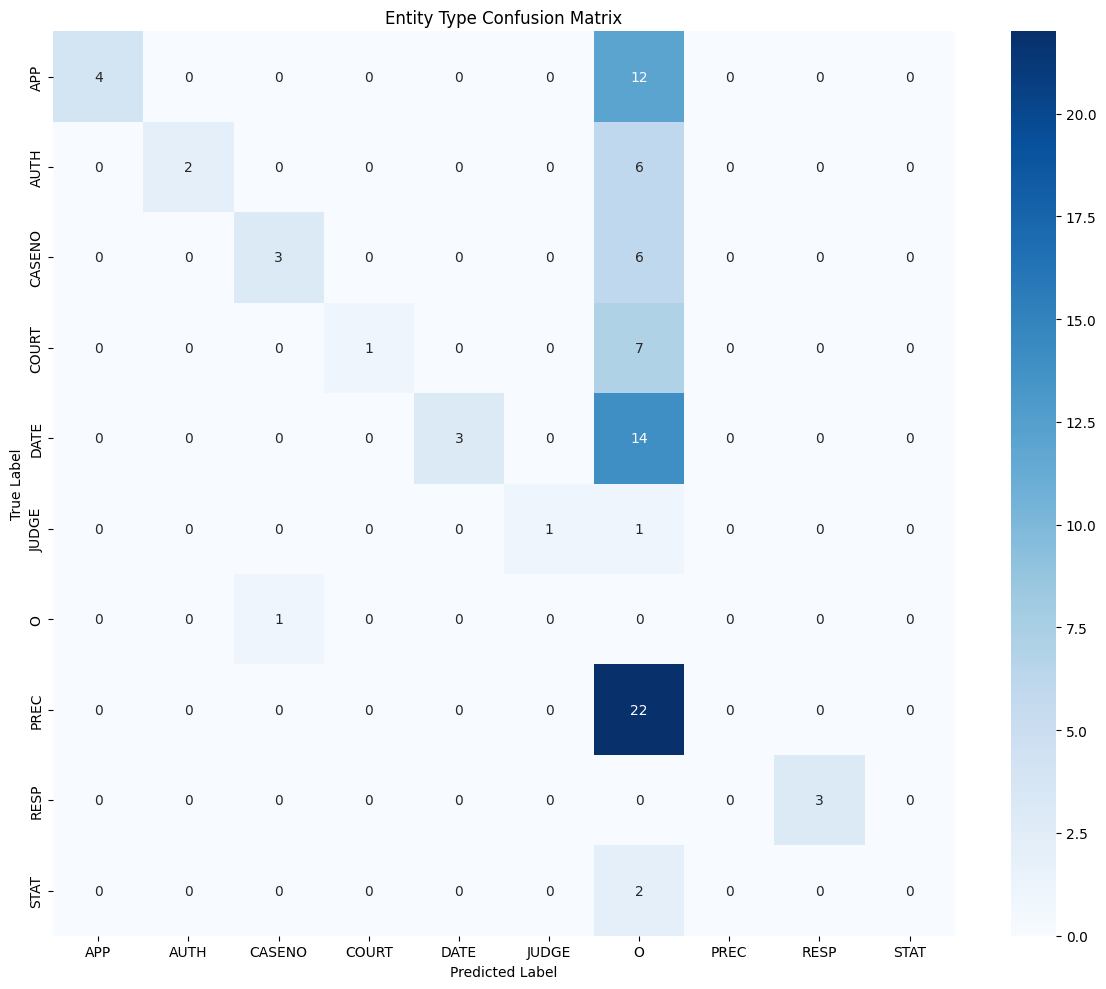


Entity recognition error analysis:


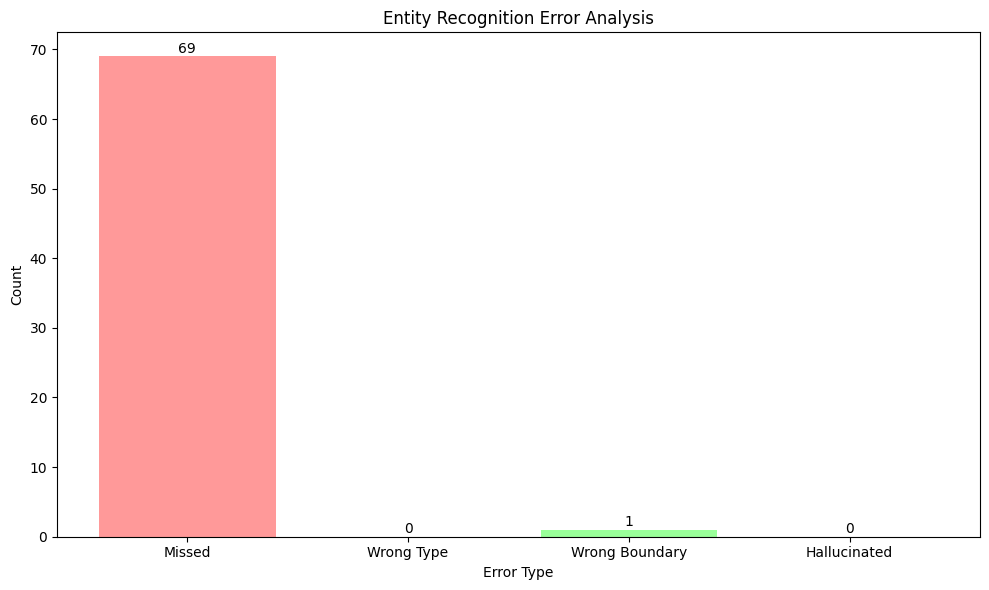

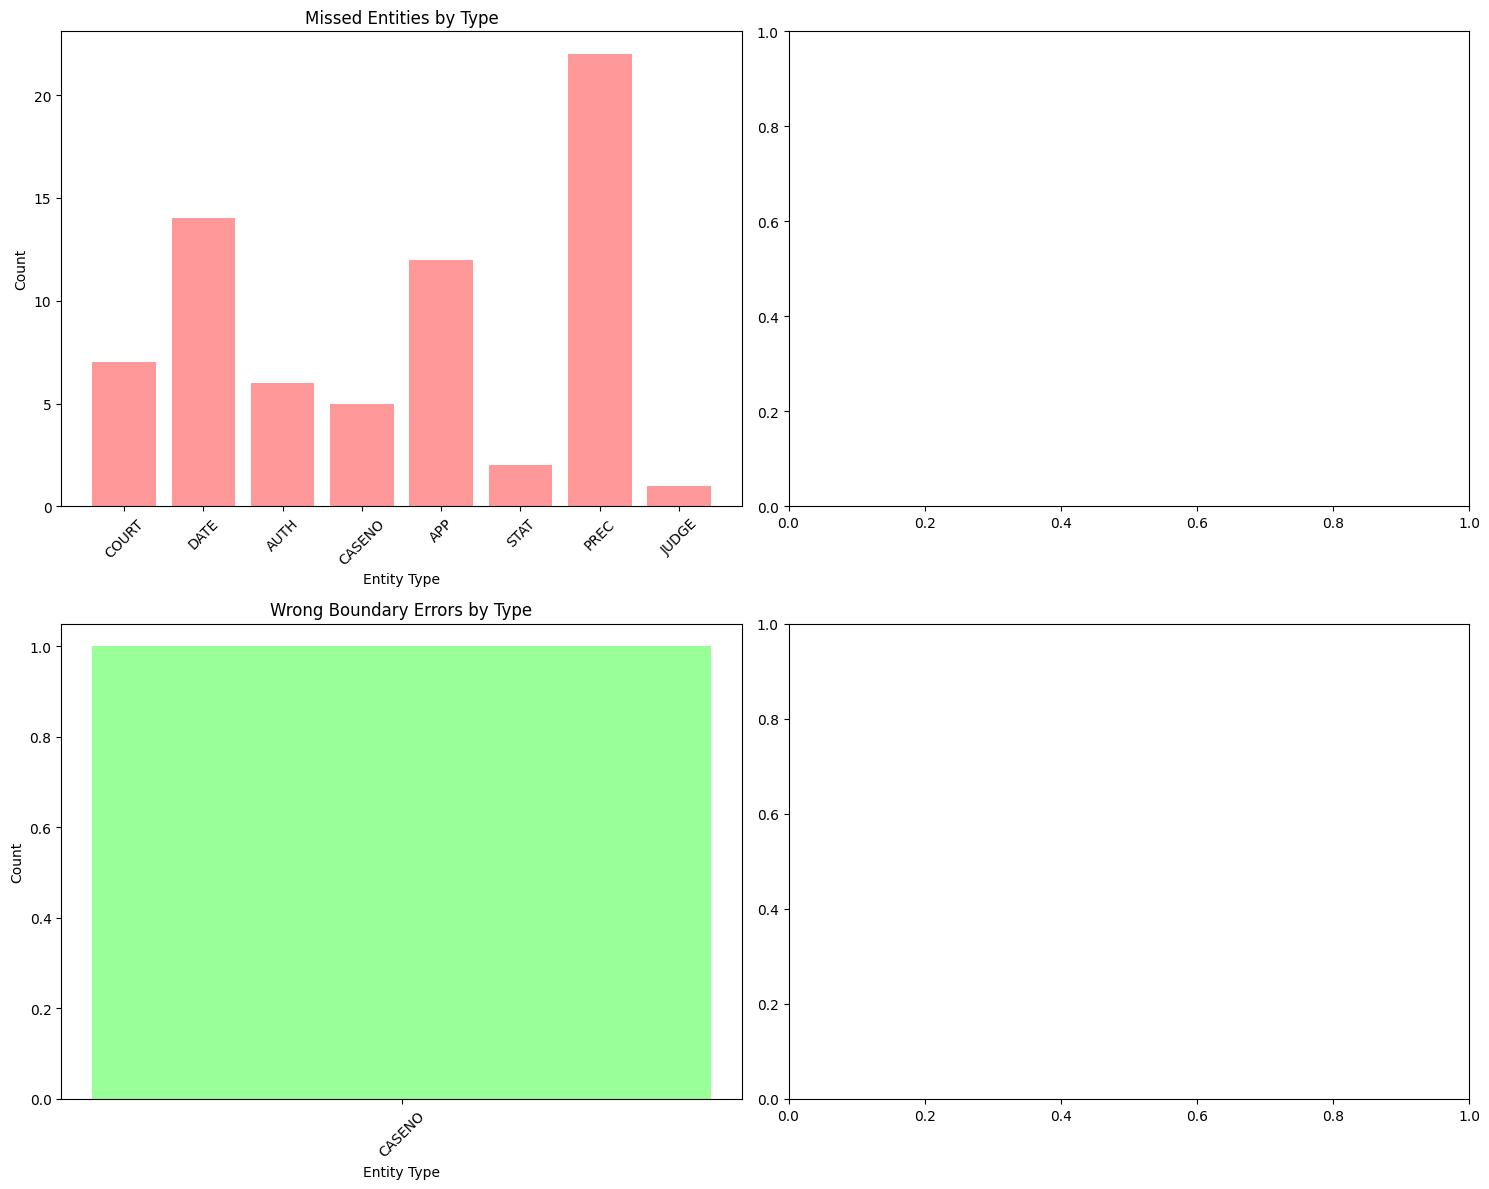

Cross-validation complete!


In [54]:
if __name__ == "__main__":
    best_model, cv_results = run_cross_validation()
    
    # Test on sample documents from fold 3    
    print("\nTesting on sample document from fold3:")
    predicted_entities2, true_entities2 = test_on_sample(best_model, sample_idx=0, fold_name="fold3")
    
    print("Cross-validation complete!")

In [49]:
clean_memory()

In [50]:
!rm -rf /kaggle/working/*

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
